In [62]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
#Import packages
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from itertools import count
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tqdm
from tqdm import tnrange, tqdm_notebook
from time import sleep
import os

#Import Custom Classes
import gym
import gym_combrf

#from Source.nn_model_dqn import QNetwork
#from Source.dqn_rcv_agent import Agent, DQN_ReplayBuffer, EpsilonGreedyStrategy
#from Source.env_manager import EnvManager
from Source.misc_fun.utils import plot, get_moving_average, Generate_BeamDir, All_Exhaustive_RateMeas

## Create channel variation for every location in the environment

In [64]:
#create a channel variation of vectors, one for each location in environment

#create same channel variation over time for all location, as we train MAB separately for every location.
#This can then be compared with DQN with same channel variation over time.

inp_fptr = open("ch_variation_large.txt")
ch_randvals = inp_fptr.read().splitlines()
ch_randvals = [np.complex(a.replace('i','j')) for a in ch_randvals]


## Perform MAB for each context inside the coverage area

In [65]:
#CAB for one location using gUCB
def implement_CAB(n, env, loc_ndx, eps_Qvals, eps_numselections, eps_chrandvals):
    
    totalrwd = 0
    alpha = 1/(4*(n+1))
    
    tx_locs = env.tx_locs
    tx_dirs = list(range(env.N_tx))
    num_actions = env.action_space.n
    
    selected_actions = []
    #action_sumrates = eps_actionsumrates[loc_ndx*len(tx_dirs)+tbdir_ndx]
    num_selections = eps_numselections[loc_ndx]
    qvals = eps_Qvals[loc_ndx]
    #prev_maxexhrate = eps_maxexhrates[loc_ndx*len(tx_dirs)+tbdir_ndx]
    #prev_minexhrate = eps_minexhrates[loc_ndx*len(tx_dirs)+tbdir_ndx]
    #maxexh_selections = eps_maxexhselections[loc_ndx*len(tx_dirs)+tbdir_ndx]
    
    #action_ndx = env.reset(tx_loc, tbdir_ndx, eps_chrandvals[0])
    done = env.reset(loc_ndx, eps_chrandvals)
    k = 0
    eps_rwd = 0
    #while not done:
    action_ndx = 0#env.action_space.sample()
    max_upperbound = 0
    for i in range(num_actions):#np.random.randint(num_actions, size=num_actions):#
        env.step(i, eps_chrandvals)
        if(num_selections[i] > 0):
            avg_rwd = qvals[i] / num_selections[i]
            delta_i = math.sqrt(2*math.log(n+1)/num_selections[i])
            upper_bound = avg_rwd + alpha*delta_i #(1-alpha)*avg_rwd + (alpha)*delta_i#
        else:
            upper_bound = 1e400
        if upper_bound > max_upperbound:
            max_upperbound = upper_bound
            action_ndx = i
        k=k+1
    selected_actions.append(action_ndx)
    num_selections[action_ndx] += 1
    #eps_numselections[action_ndx] +=1
    
    rwd = env.get_rewards(action_ndx)
    
    datarate = env.ep_rates[action_ndx]#env.get_rate()
    rssi_val = env.ep_rssi[action_ndx]
    #action_sumrates[action_ndx] += datarate
    qvals[action_ndx]+=rwd
    #eps_actionsumrates[action_ndx] += datarate
    #eps_Qvals[action_ndx] += rwd
    eps_rwd += rwd
        
    #totalrwd += rwd
    #expected_rwdvals = [x/y if (y>0) else 0 for x,y in zip(qvals,num_selections)]
    #best_action_ndx = expected_rwdvals.index(max(expected_rwdvals))
    
    #if (num_selections[best_action_ndx] > 0):
    #    avg_datarate = action_sumrates[best_action_ndx]/num_selections[best_action_ndx]
    #    avg_rwd = qvals[best_action_ndx]/num_selections[best_action_ndx]
    #else:
    #    avg_datarate = 0
    #    avg_rwd = 0
    #avg_rwd = qvals[action_ndx]/num_selections[action_ndx]
    #avg_datarate = action_sumrates[action_ndx]/num_selections[action_ndx]
    #if (num_selections[action_ndx] > 0):
    #    expected_rwdvals = [x/y if (y>0) else 0 for x,y in zip(action_sumrates,num_selections)]
    #    best_action_ndx = expected_rwdvals.index(max(expected_rwdvals))
    #    avg_datarate = action_sumrates[best_action_ndx]/num_selections[best_action_ndx]
    #else:
    #    avg_datarate = 0
    #min_exhrate, max_exhrate, min_action_ndx, max_action_ndx = env.get_minmax_exhrate(eps_chrandvals)
    #max_exhrate = (prev_maxexhrate*(maxexh_selections-1)+max_exhrate)/(maxexh_selections)
    #min_exhrate = (prev_minexhrate*(maxexh_selections-1)+min_exhrate)/(maxexh_selections)
    
    #print(qvals)
    #eps_actionsumrates[loc_ndx*len(tx_dirs)+tbdir_ndx] = action_sumrates
    eps_numselections[loc_ndx] = num_selections
    eps_Qvals[loc_ndx] = qvals
    #eps_maxexhrates[loc_ndx*len(tx_dirs)+tbdir_ndx] = max_exhrate
    #eps_minexhrates[loc_ndx*len(tx_dirs)+tbdir_ndx] = min_exhrate
    
    
    return action_ndx, datarate, rssi_val, rwd

def implement_CAB(N, env, loc_ndx, eps_Qvals, eps_numselections, eps_chrandvals):
    num_actions = env.action_space.n
    
    
    
    num_selections = eps_numselections[loc_ndx]
    #Loop phase
    for n in range(N):
        
    
    return

In [74]:
cab_env = gym.make('combrf-v5')
cab_env.ant_arr = 'ula'
N=1000
num_actions = cab_env.action_space.n
tx_locs = cab_env.tx_locs
#tx_dirs = list(range(cab_env.N_tx))
num_contexts = len(tx_locs)#*len(tx_dirs)

BeamMap = {}
Loc_Qvals = [[0]*num_actions for i in range(num_contexts)]
Loc_numselections = [[0]*num_actions for i in range(num_contexts)]
#Loc_actionsumrates = [[0]*num_actions for i in range(num_contexts)]
#Loc_maxexhrates =[0 for i in range(num_contexts)]
#Loc_maxexhselections = [0 for i in range(num_contexts)]
#Loc_minexhrates =[0 for i in range(num_contexts)]
Loc_count = [0 for i in range(num_contexts)]
train_datarates =[[] for i in range(num_contexts)]

In [75]:
from Source.misc_fun.conversion import *

#loc_SNRexh = [0.0 for i in range(em.env.obs_space.nvec[3] * len(em.env.tx_locs)) ]
#cabloc_exhrate = [0.0 for i in range(num_contexts) ]
cabloc_SNRexh = [0.0 for i in range(num_contexts) ]
cabloc_minSNRexh = [0.0 for i in range(num_contexts) ]
cabloc_exhbdir = [0 for i in range(num_contexts) ]
for loc_ndx in range(len(tx_locs)):
    #for tbdir_ndx in range(len(tx_dirs)):
    min_exh_rate, max_exh_rate,min_action_ndx,max_action_ndx,min_rssi_val,max_rssi_val = cab_env.get_minmax_exhrate(loc_ndx, ch_randvals[loc_ndx])
    #tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
    #Es = db2lin(cab_env.P_tx)
    #SNR_exh = Es * np.abs(max_rssi_val) ** 2 / (em.env.N0 * em.env.B)
    #SNR_exh = Es * np.abs(max_rssi_val) ** 2 / (cab_env.N0 * cab_env.B)
    #exh_rate = np.log2(1 + SNR_exh)
    #cabloc_exhrate[loc_ndx] = max_rssi_val #max_exh_rate#
    cabloc_SNRexh[loc_ndx] = max_rssi_val
    cabloc_minSNRexh[loc_ndx] = min_rssi_val
    cabloc_exhbdir[loc_ndx] = max_action_ndx

In [76]:
print(np.mean([np.abs(20*np.log10(np.abs(x))-20*np.log10(np.abs(y))) for x,y in zip(cabloc_SNRexh, cabloc_minSNRexh)]))
print(len(cab_env.tx_locs))

59.20757301711136
1


In [77]:
#cabenv_avgerrors = [[] for i in range(num_contexts)]
cabloc_errors = [np.abs(20*np.log10(np.abs(x))-20*np.log10(np.abs(y))) for x,y in zip(cabloc_SNRexh, cabloc_minSNRexh)]
cabenv_avgerrors = [np.mean(cabloc_errors)]
cabenv_epslen = [[] for i in range(num_contexts)]
for loc_ndx in range(len(tx_locs)):
    #for tbdir_ndx in range(len(tx_dirs)):
    cab_env = gym.make('combrf-v5')
    tx_loc = tx_locs[loc_ndx]
    #print("\n\nloc_ndx: {}, tbdir_ndx: {}".format(loc_ndx, tbdir_ndx))
    
    print("\n\nloc_ndx: {}, ch_model: {}".format(loc_ndx, cab_env.ch_model))
    #train each context separately
    totalrwd = 0
    
    #Initialization phase
    done = cab_env.reset(loc_ndx, ch_randvals[0])
    for i in range(num_actions):
        cab_env.step(i, ch_randvals[0])
    init_rwds= cab_env.get_rewards()
    for i in range(num_actions):
        Loc_Qvals[loc_ndx][i] = init_rwds[i]

    #Loop Phase    
    for n in range(0,N):

        #Loc_maxexhselections[loc_ndx*len(tx_dirs)+tbdir_ndx]+=1
        best_actionndx, datarate, cab_rssi, rwd= implement_CAB(n, cab_env,loc_ndx,Loc_Qvals, Loc_numselections, ch_randvals[n])

        #min_exhrate, max_exhrate, min_action_ndx, max_action_ndx, min_rssi_val, max_rssi_val = cab_env.get_minmax_exhrate(loc_ndx, tbdir_ndx, ch_randvals[n])
        #print("episode: {}, selected action: {}, eps_rwd: {}, eps best datarate: {}".format(n, best_rxndx, rwd, datarate))
        #print("eps_datarates: {}".format(eps_datarates))

        exh_action_ndx = cabloc_exhbdir[loc_ndx]
        max_exhrssi = cabloc_SNRexh[loc_ndx]#max_exhrate
        #print("eps txdir: {}, cab rxdir: {}, exh_rxdir: {}".format(cab_env.BeamSet[tbdir_ndx][0]*180/np.pi, cab_env.BeamSet[best_rxndx][0]*180/np.pi, cab_env.BeamSet[exh_action_ndx][0]*180/np.pi))


        #Es = db2lin(cab_env.P_tx)
        #SNR_exh = Es * np.abs(max_rssi_val) ** 2 / (em.env.N0 * em.env.B)
        #SNR = Es * np.abs(cab_env.rssi_val) ** 2 / (cab_env.N0 * cab_env.B)
        #rate = np.log2(1 + SNR)
        totalrwd += rwd
        #print(totalrwd)


        #_, max_exh_rate,_,max_action_ndx,_,max_rssi_val = cab_env.get_minmax_exhrate(loc_ndx, tbdir_ndx, ch_randvals[loc_ndx *len(tx_dirs) + tbdir_ndx])
        cabenv_epslen[loc_ndx].append(num_actions)
        cab_rate = datarate

        error = np.abs(20*np.log10(np.abs(max_exhrssi))-20*np.log10(np.abs(cab_rssi)))#max_exhrate-cab_rate
        print("max_exhrate: {}, cab_rate: {}, rate error (exh-dqn): {}, best actionndx: {}\n".format(np.abs(max_exhrssi), np.abs(cab_rssi),error, best_actionndx))
        for i in range(cab_env.action_space.n):
            cabloc_errors[loc_ndx] = error
            cabenv_avgerrors.append(error)
            train_datarates[loc_ndx].append(rwd)
        #cabenv_avgerrors.append(np.mean(cabloc_errors))

         #/Loc_numselections[loc_ndx*len(tx_dirs)+tbdir_ndx][best_action_ndx]
        #Loc_Qvals.append(Qvals)
        #Loc_numselections.append(num_selections)
        #expected_rwdvals = [ x/y if (y>0) else 0 for x,y in zip(Loc_Qvals[tbdir_ndx],Loc_numselections[tbdir_ndx])]
        #best_action_ndx = expected_rwdvals.index(max(expected_rwdvals))
        #BeamMap[str(tx_loc[0][0])+','+ str(tx_loc[0][1]) + ',' +str(tx_loc[0][2])+','+str(tbdir_ndx)] = best_action_ndx



loc_ndx: 0, ch_model: uma-los
ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.3222700208

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

ep_rates: [21.721944096136554, 18.111897368724996, 16.915897108976193, 16.513128386741073, 13.918937621897616, 22.46755739257796, 21.833914929966667, 22.414281551196712, 19.233124476046527, 19.716806133329015, 20.329126295416536, 24.867855185304506, 18.93651841751576, 26.250912130714696, 21.413819146898238, 21.029210161282467, 13.13578890849439, 15.659614914207639, 17.964693722690402, 22.63248208023749, 19.2709455566248, 19.719646623705223, 18.320891622804453, 16.627478767092317, 23.28517006102529, 19.44518229353774, 17.389954545913625, 20.000159363085647, 18.153855049225513, 22.111917087163, 23.872334820491815, 24.117183324258516, 19.473540263125503, 15.479249281506359, 16.070055091642462, 18.01144018101347, 6.597556990924632, 15.04712042485632, 19.379105348582236, 19.89456944295767, 13.711514430947044, 13.469768299177389, 15.347492466621432, 19.808774180917172, 12.801368717416153, 20.62547848600218, 15.837817961317423, 15.705414285912127, 17.32227002088658, 12.695105364394362, 16.601

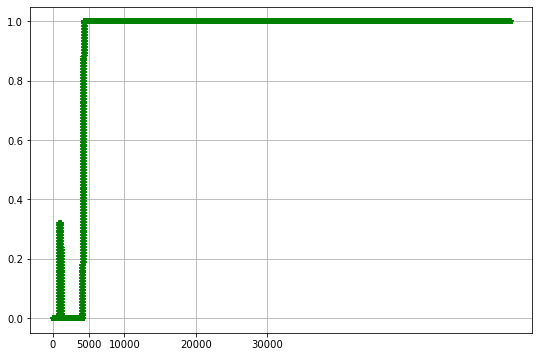

In [78]:
from Source.misc_fun.utils import *
fig = plt.figure(figsize=[9, 6])

#loc_ndx = 0
#tbdir_ndx = 3
context_ndx1 = 0#*len(tx_dirs)+ 1#tbdir_ndx
context_ndx2 = 1#*len(tx_dirs)+ 2#tbdir_ndx
context_ndx3 = 2#*len(tx_dirs)+ 3#tbdir_ndx
context_ndx4 = 3#*len(tx_dirs)+ 4#tbdir_ndx
# moving_avg_period = 1000
moving_avg1 = get_moving_average(moving_avg_period, train_datarates[context_ndx1])
#moving_avg2 = get_moving_average(moving_avg_period, train_datarates[context_ndx2])
#moving_avg3 = get_moving_average(moving_avg_period, train_datarates[context_ndx3])
#moving_avg4 = get_moving_average(moving_avg_period, train_datarates[context_ndx4])

#plot(, 800, [])
#for ndx in range(len(sel_ctxt_ndices)):
#plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), test_data_rates[min_ndx:max_ndx], 'b', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_minexh_rates[min_ndx:max_ndx], 'r--', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_maxexh_rates[min_ndx:max_ndx], 'g--')
plt.plot(np.arange(1,len(train_datarates[context_ndx1])+1), moving_avg1, 'g*-')
#plt.plot(np.arange(1,len(train_datarates[context_ndx2])+1), moving_avg2, 'b-')
#plt.plot(np.arange(1,len(train_datarates[context_ndx3])+1), moving_avg3, 'c-')
#plt.plot(np.arange(1,len(train_datarates[context_ndx4])+1), moving_avg4, 'm-')

#plt.plot(np.arange(1,len(train_datarates[context_ndx4])+1), train_datarates[context_ndx4], 'm-')
#plt.plot(np.arange(len(test_data_rates[3080:3140])), test_data_rates[3080:3140], 'b', np.arange(len(test_data_rates[3080:3140])), test_minexh_rates[3080:3140], 'r--', np.arange(len(test_data_rates[3080:3140])), test_maxexh_rates[3080:3140],'g--')
#plt.plot(np.arange(len(test_data_rates[4650:4740])), test_data_rates[4650:4740], 'b', np.arange(len(test_data_rates[4650:4740])), test_minexh_rates[4650:4740], 'r--', np.arange(len(test_data_rates[4650:4740])), test_maxexh_rates[4650:4740],'g--')
#plt.plot(np.arange(len(test_data_rates[6230:])), test_data_rates[6230:], 'b', np.arange(len(test_data_rates[6230:])), test_minexh_rates[6230:], 'r--', np.arange(len(test_data_rates[6230:])), test_maxexh_rates[6230:],'g--')

#plt.xticks(np.arange(1, len(train_datarates[context_ndx4])+1,1), [str(x) for x in np.arange(1,len(train_datarates[context_ndx4])+1)])
#plt.legend(['learnt rate','min exhrate', 'max exhrate'])
#plt.legend(['cab context txloc: {}, txbdir:{}'.format(cab_env.tx_locs[loc_ndx], cab_env.BeamSet[tbdir_ndx]*180/np.pi)])
#plt.legend(['cab context ndx:{}'.format(context_ndx1),'cab context ndx:{}'.format(context_ndx2),'cab context ndx:{}'.format(context_ndx3),'cab context ndx:{}'.format(context_ndx4)])
#plt.xlabel('Episode #')
#plt.ylabel('reward')
#plt.title('Beam alignment with episode length:{}'.format(em.env.goal_steps))
plt.xticks([0,5000,10000,20000,30000])#,4000,5000,6000,7000,8000])
plt.grid()
plt.show()

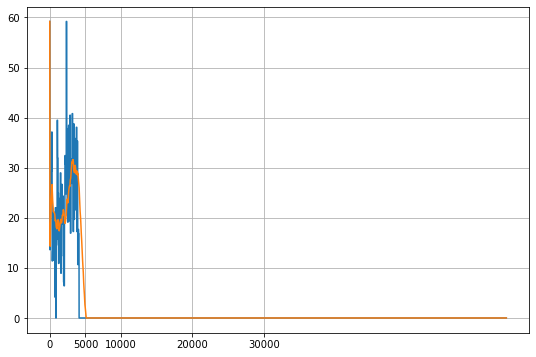

In [79]:
fig = plt.figure(figsize=[9, 6])
#cabenv_timeavgerrors =[item for item in cabenv_avgerrors[4] for i in range(cab_env.N_rx)]

moving_avg1 = get_moving_average(1000, cabenv_avgerrors)
plt.xticks([0,5000,10000,20000,30000])
plt.plot(cabenv_avgerrors)
plt.plot(moving_avg1)
plt.grid()
plt.show()

## Learn beamalignment using DQN without channel variation for 72 TX locations

In [80]:
# Assume LOS or NLOS throughout the environment. Do not change in between for now
from Source.nn_model_dqn import QNetwork
from Source.dqn_rcv_agent import Agent, DQN_ReplayBuffer, EpsilonGreedyStrategy
from Source.env_manager import EnvManager
from Source.misc_fun.utils import plot, get_moving_average, Generate_BeamDir, All_Exhaustive_RateMeas
from Source.PER import PrioritizedReplayBuffer

#Hyper-parameters
BUFFER_SIZE = int(1e5)      #replay buffer size
BATCH_SIZE = 64             #minibatch size
GAMMA = 0.999                #discount factor
ALPHA = 1.0                  #non-stationarity parameter
TAU = 1e-3                  #for soft update of target parameters
LR = 5e-4                   #learning rate
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.993 #125e-6
episodes = 1500 #3100 train, 500 test
UPDATE_EVERY = 50

test_episodes = 20
seed = 0                    #random seed number
episode_step_limit = 10
#%%
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Choose the environment
em = EnvManager(device, 'combrf-v7', seed)
em.env.ant_arr = 'ula'
#rx_xcov = np.array([-300,-100,100])
#rx_ycov = np.array([-300,-100,100])
#rx_zcov = np.array([51.5,71.5])
rx_xcov = np.array([-60,-40,-20,20,40,60])
rx_ycov = np.array([-60,-40,-20,20,40,60])
rx_zcov = np.array([41.5, 81.5])
beam_param = 'beam-narrow'
beam_paramvals = np.array([])
em.env.set_beamparameters(beam_param, beam_paramvals)
em.env.set_coverage(rx_xcov,rx_ycov,rx_zcov)

available_actions = em.num_actions_available()
random.seed(seed)
state_size = em.state_size()
print(em.env.ch_model)
print(em.env.sc_xyz)

#Select the strategy
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, len(em.env.tx_locs),1200)#episodes
#Initialize the agent
agent = Agent(strategy, state_size, available_actions, seed, device)

#Instantiate MemoryBuffer
#if not PRIORITIZED_REPLAY:
memory = DQN_ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, seed, device)
#else:
#    memory = PrioritizedReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, PER_ALPHA,seed, device)

policy_net = QNetwork(state_size, available_actions, seed).to(device)
target_net = QNetwork(state_size, available_actions, seed).to(device)
print(policy_net)

#Initialize target_net weights to policy_net weights
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() #Set the target_net in eval mode

#Select the optimizer
#optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)
optimizer = optim.SGD(params=policy_net.parameters(), lr=LR, momentum=0.01)

uma-los
[[  0.   20.   21.5]
 [ 20.    0.   21.5]
 [-20.    0.   21.5]
 [  0.  -20.   21.5]]
QNetwork(
  (fc11): Linear(in_features=32, out_features=200, bias=True)
  (fc12): Linear(in_features=3, out_features=32, bias=True)
  (fc22): Linear(in_features=32, out_features=200, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=256, bias=True)
  )
  (softmax): Softmax(dim=1)
  (output): Linear(in_features=256, out_features=64, bias=True)
)


In [81]:
from Source.misc_fun.conversion import *

#loc_SNRexh = [0.0 for i in range(em.env.obs_space.nvec[3] * len(em.env.tx_locs)) ]
loc_SNRexh = [0.0 for i in range(len(em.env.tx_locs)) ]
loc_minSNRexh = [0.0 for i in range(len(em.env.tx_locs)) ]
loc_exhbdir = [0 for i in range(len(em.env.tx_locs)) ]
for loc_ndx in range(len(em.env.tx_locs)):
    #for tbdir_ndx in range(em.env.obs_space.nvec[3]):
    min_exh_rate, max_exh_rate,min_action_ndx,max_action_ndx,min_rssi_val,max_rssi_val = em.env.get_minmax_exhrate(loc_ndx, ch_randvals[loc_ndx])
    #tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
    #Es = db2lin(em.env.P_tx)
    #SNR_exh = Es * np.abs(max_rssi_val) ** 2 / (em.env.N0 * em.env.B)
    #SNR_exh = Es * np.abs(max_rssi_val) ** 2 / (em.env.N0 * em.env.B)
    #exh_rate = np.log2(1 + SNR_exh)
    loc_minSNRexh[loc_ndx] = min_rssi_val#max_exh_rate#
    loc_SNRexh[loc_ndx] = max_rssi_val#max_exh_rate#
    loc_exhbdir[loc_ndx] = max_action_ndx

tx-loc: [[-60.  -60.   41.5]], sc-xyz: [[  0.   20.   21.5]
 [ 20.    0.   21.5]
 [-20.    0.   21.5]
 [  0.  -20.   21.5]], init ch-model: uma-los
txdir_ndx: 0, rxdir_ndx: 0, rate: 18.367167657744382,rssival:(8.548420796469923e-06,-2.7728331106628393e-06)
txdir_ndx: 0, rxdir_ndx: 1, rate: 12.959822233896713,rssival:(6.736930789113953e-07,-1.2037161129766377e-06)
txdir_ndx: 0, rxdir_ndx: 2, rate: 14.73696971336788,rssival:(-3.937066282976665e-07,-2.5233633769802454e-06)
txdir_ndx: 0, rxdir_ndx: 3, rate: 19.67227282120482,rssival:(3.767257898917734e-06,-1.3615344972686765e-05)
txdir_ndx: 0, rxdir_ndx: 4, rate: 16.519439787535973,rssival:(3.983218593111354e-06,-2.5636797398608853e-06)
txdir_ndx: 0, rxdir_ndx: 5, rate: 18.150757025851515,rssival:(8.33514086337816e-06,-1.9847604631905954e-07)
txdir_ndx: 0, rxdir_ndx: 6, rate: 18.287154546065842,rssival:(-2.9916697093843545e-06,-8.213202842028766e-06)
txdir_ndx: 0, rxdir_ndx: 7, rate: 18.818116951693444,rssival:(5.19523611710663e-06,-9.1328

txdir_ndx: 0, rxdir_ndx: 0, rate: 15.511221888057124,rssival:(1.6125124143790965e-06,-2.9249273759757485e-06)
txdir_ndx: 0, rxdir_ndx: 1, rate: 10.473819504537675,rssival:(-7.633481327404691e-08,-5.776036298077892e-07)
txdir_ndx: 0, rxdir_ndx: 2, rate: 14.509967157154305,rssival:(-1.0353633875852571e-06,-2.1214976906604217e-06)
txdir_ndx: 0, rxdir_ndx: 3, rate: 13.761325990002364,rssival:(3.929791543261633e-07,-1.7782457834764121e-06)
txdir_ndx: 0, rxdir_ndx: 4, rate: 18.587782995833336,rssival:(-9.699814729463676e-06,-1.497533809362667e-07)
txdir_ndx: 0, rxdir_ndx: 5, rate: 18.225678375060927,rssival:(8.051226076803587e-06,2.89777204204311e-06)
txdir_ndx: 0, rxdir_ndx: 6, rate: 16.194520228055985,rssival:(2.147212479594718e-06,-3.6473325714006994e-06)
txdir_ndx: 0, rxdir_ndx: 7, rate: 15.169063084713683,rssival:(1.9038204412800776e-06,-2.274964475320249e-06)


txdir_ndx: 1, rxdir_ndx: 0, rate: 20.170836978418965,rssival:(1.3926606394248076e-06,-1.6733625741117813e-05)
txdir_ndx: 1, rx

txdir_ndx: 2, rxdir_ndx: 0, rate: 13.13578890849439,rssival:(-5.16233923334485e-07,-1.372283149616904e-06)
txdir_ndx: 2, rxdir_ndx: 1, rate: 15.659614914207639,rssival:(-2.412673031556531e-06,2.5579176313192677e-06)
txdir_ndx: 2, rxdir_ndx: 2, rate: 17.964693722690402,rssival:(-5.660289935649346e-06,5.3910976522897415e-06)
txdir_ndx: 2, rxdir_ndx: 3, rate: 22.63248208023749,rssival:(-3.803592324129955e-05,-1.031485557656849e-05)
txdir_ndx: 2, rxdir_ndx: 4, rate: 19.2709455566248,rssival:(-1.455021839932015e-06,-1.2206122950825497e-05)
txdir_ndx: 2, rxdir_ndx: 5, rate: 19.719646623705223,rssival:(-1.1044278861654188e-05,9.179097145627712e-06)
txdir_ndx: 2, rxdir_ndx: 6, rate: 18.320891622804453,rssival:(-6.553852536321662e-06,-5.938149607130149e-06)
txdir_ndx: 2, rxdir_ndx: 7, rate: 16.627478767092317,rssival:(-1.735128268667712e-06,-4.601380224475483e-06)


txdir_ndx: 3, rxdir_ndx: 0, rate: 23.28517006102529,rssival:(4.628380331812956e-06,-4.919595325542311e-05)
txdir_ndx: 3, rxdir_ndx

txdir_ndx: 2, rxdir_ndx: 0, rate: 17.641691194897266,rssival:(3.420498150806587e-06,-6.094752357867775e-06)
txdir_ndx: 2, rxdir_ndx: 1, rate: 14.491887708117396,rssival:(-2.1919703840667154e-06,-8.358184800591015e-07)
txdir_ndx: 2, rxdir_ndx: 2, rate: 19.439846961984543,rssival:(-1.1188856072188248e-05,-6.684594395742237e-06)
txdir_ndx: 2, rxdir_ndx: 3, rate: 17.634013387142016,rssival:(1.1902659866582036e-06,-6.868028819490628e-06)
txdir_ndx: 2, rxdir_ndx: 4, rate: 11.249182721553684,rssival:(-5.356002704747932e-07,-5.425100122164946e-07)
txdir_ndx: 2, rxdir_ndx: 5, rate: 13.735762487076983,rssival:(-1.507025859206078e-06,-9.935842080397104e-07)
txdir_ndx: 2, rxdir_ndx: 6, rate: 17.270395441826548,rssival:(-5.966756733184637e-06,-1.4696477626461905e-06)
txdir_ndx: 2, rxdir_ndx: 7, rate: 17.97818975367698,rssival:(-3.6035674122405523e-06,-6.977922530972207e-06)


txdir_ndx: 3, rxdir_ndx: 0, rate: 22.018724060586244,rssival:(-6.907773007665358e-06,-3.110047378869414e-05)
txdir_ndx: 3, r

txdir_ndx: 2, rxdir_ndx: 2, rate: 17.726086124311717,rssival:(3.5046723653835222e-06,-6.285357368393031e-06)
txdir_ndx: 2, rxdir_ndx: 3, rate: 16.101011132448363,rssival:(-2.618497035857129e-06,-3.1516289908398717e-06)
txdir_ndx: 2, rxdir_ndx: 4, rate: 14.733261532419675,rssival:(-6.378954780983466e-07,-2.469557323376984e-06)
txdir_ndx: 2, rxdir_ndx: 5, rate: 13.32725140308976,rssival:(-3.771772686707735e-08,-1.5663176133801852e-06)
txdir_ndx: 2, rxdir_ndx: 6, rate: 16.35323017584813,rssival:(-3.8149878325074505e-06,-2.3329365020839873e-06)
txdir_ndx: 2, rxdir_ndx: 7, rate: 15.866536846375043,rssival:(-1.5715559424383685e-06,-3.435256171101407e-06)


txdir_ndx: 3, rxdir_ndx: 0, rate: 15.660711972564679,rssival:(7.752076397371051e-07,-3.4310920210418386e-06)
txdir_ndx: 3, rxdir_ndx: 1, rate: 11.094797662859529,rssival:(-3.728871539197044e-07,-6.189784477551056e-07)
txdir_ndx: 3, rxdir_ndx: 2, rate: 12.45186101755929,rssival:(-6.307554700759209e-07,-9.696140892193421e-07)
txdir_ndx: 3, r

 [  0.  -20.   21.5]], init ch-model: uma-los
txdir_ndx: 0, rxdir_ndx: 0, rate: 17.118506299991623,rssival:(-3.723684294789749e-06,-4.485831171889597e-06)
txdir_ndx: 0, rxdir_ndx: 1, rate: 19.155170302636108,rssival:(-2.416075845395781e-06,1.1559268763632803e-05)
txdir_ndx: 0, rxdir_ndx: 2, rate: 13.767951786886611,rssival:(-1.341649505050132e-06,1.2376733683458622e-06)
txdir_ndx: 0, rxdir_ndx: 3, rate: 17.445481854499093,rssival:(-6.098549515251747e-06,2.3328714163905946e-06)
txdir_ndx: 0, rxdir_ndx: 4, rate: 13.577464313406752,rssival:(-1.6782244981442743e-06,3.2136073363903953e-07)
txdir_ndx: 0, rxdir_ndx: 5, rate: 13.70547415237479,rssival:(-1.1604664541582535e-06,1.3579233515208523e-06)
txdir_ndx: 0, rxdir_ndx: 6, rate: 17.395440679398977,rssival:(-4.241680992003145e-06,4.8155231577589135e-06)
txdir_ndx: 0, rxdir_ndx: 7, rate: 17.754061187334692,rssival:(-7.202958242176471e-06,9.590952600372292e-07)


txdir_ndx: 1, rxdir_ndx: 0, rate: 15.184774058104022,rssival:(-1.574353769098152

In [82]:
print(np.mean([np.abs(20*np.log10(np.abs(x))-20*np.log10(np.abs(y))) for x,y in zip(loc_SNRexh, loc_minSNRexh)]))
print(len(em.env.tx_locs))

44.96638023202232
72


In [83]:
locndx_list = list(range(len(em.env.tx_locs)))
random_loc_ndices = random.sample(locndx_list, len(locndx_list))
#txdir_list = list(range(em.env.obs_space.nvec[3]))
#txdir_ndices = random.sample(txdir_list, len(txdir_list))

obs_list = []
for eps in range(episodes):
    ndx = eps % (len(em.env.tx_locs))
    #ndx = eps % (em.env.obs_space.nvec[3] * len(em.env.tx_locs))
    #ndx1 = int(ndx / em.env.obs_space.nvec[3])    
    #ndx2 = int(ndx % em.env.obs_space.nvec[3])
    obs_list.append((random_loc_ndices[ndx]))

In [84]:
action_list = list(range(em.env.action_space.n))
random_actions = random.sample(action_list,len(action_list))
print(random_actions)

[13, 19, 35, 18, 45, 7, 61, 21, 52, 34, 63, 51, 38, 57, 37, 60, 28, 5, 55, 24, 20, 36, 15, 48, 11, 12, 39, 2, 16, 30, 4, 46, 8, 47, 33, 1, 26, 42, 22, 17, 56, 59, 50, 31, 23, 58, 6, 53, 43, 40, 14, 10, 25, 32, 54, 49, 9, 3, 29, 27, 62, 0, 41, 44]


#### Train DQN agent

init rate: -inf, init tx action: -1, init rx action: -1
best_rate: inf, cur_rate: 15.017338895002949, error: 26.750512820713112, action: 14, iter_avg_error: 44.82157131694297
best_rate: inf, cur_rate: 13.315456574033988, error: 31.873984186277468, action: 45, iter_avg_error: 44.89273064146471
best_rate: inf, cur_rate: 15.345546608947705, error: 25.762482507363273, action: 63, iter_avg_error: 44.80784867370201
best_rate: inf, cur_rate: 16.538271282831396, error: 22.171964796931135, action: 23, iter_avg_error: 44.75798037216823
best_rate: inf, cur_rate: 15.01969999076297, error: 26.743405000102257, action: 50, iter_avg_error: 44.82147259721227
best_rate: inf, cur_rate: 18.28134654483337, error: 16.924753410904998, action: 10, iter_avg_error: 44.6851024362512
best_rate: inf, cur_rate: 13.190994163322433, error: 32.24869176502263, action: 21, iter_avg_error: 44.89793491339172
best_rate: inf, cur_rate: 15.691606337420357, error: 24.720716675650266, action: 27, iter_avg_error: 44.79337970381

best_rate: inf, cur_rate: 11.198607327514127, error: 32.9072884298558, action: 21, iter_avg_error: 44.559404057454216
best_rate: inf, cur_rate: 16.04565779917182, error: 18.314428562382332, action: 63, iter_avg_error: 44.35672544818375
best_rate: inf, cur_rate: 16.350939060360396, error: 17.39542815025544, action: 16, iter_avg_error: 44.34396155357088
best_rate: inf, cur_rate: 16.923943236644316, error: 15.670496671694792, action: 7, iter_avg_error: 44.3200041719242
best_rate: inf, cur_rate: 20.69442049132064, error: 4.320196787039038, action: 38, iter_avg_error: 44.16236111797065
best_rate: inf, cur_rate: 14.132836454637596, error: 24.07277213109427, action: 28, iter_avg_error: 44.43670244219364
best_rate: inf, cur_rate: 13.44717856800583, error: 26.136955140832114, action: 11, iter_avg_error: 44.46537165066221
best_rate: inf, cur_rate: 16.797785735488112, error: 16.050271783778868, action: 0, iter_avg_error: 44.3252788262587
best_rate: inf, cur_rate: 16.311997523076652, error: 17.512

best_rate: inf, cur_rate: 20.023957921494784, error: 14.053728252904506, action: 0, iter_avg_error: 43.786042723196985
best_rate: inf, cur_rate: 13.365304895016948, error: 34.09867866956604, action: 46, iter_avg_error: 44.064444812317284
best_rate: inf, cur_rate: 18.51969571976141, error: 18.58201617583738, action: 37, iter_avg_error: 43.8489356110155
best_rate: inf, cur_rate: 16.48202919488403, error: 24.716039517704672, action: 63, iter_avg_error: 43.934130379652544
best_rate: inf, cur_rate: 16.859229655479258, error: 23.58054207154423, action: 19, iter_avg_error: 43.918359581789204
best_rate: inf, cur_rate: 17.938769429558477, error: 20.330784291543637, action: 48, iter_avg_error: 43.87322405706698
best_rate: inf, cur_rate: 18.963796404020446, error: 17.24513684346161, action: 61, iter_avg_error: 43.83036784251028
best_rate: inf, cur_rate: 15.4384618008872, error: 27.85754075470622, action: 1, iter_avg_error: 43.97776234127756
best_rate: inf, cur_rate: 17.95605688389305, error: 20.2

best_rate: inf, cur_rate: 12.417529964732704, error: 34.18612658752487, action: 58, iter_avg_error: 43.62602408048531
best_rate: inf, cur_rate: 17.453666530556408, error: 19.02507517898971, action: 6, iter_avg_error: 43.415453922033436
best_rate: inf, cur_rate: 19.394463813722307, error: 13.18267530945812, action: 12, iter_avg_error: 43.33430947940105
best_rate: inf, cur_rate: 20.52621074710917, error: 9.7757741390256, action: 18, iter_avg_error: 43.28699140758948
best_rate: inf, cur_rate: 13.981258423251152, error: 29.478309506357476, action: 43, iter_avg_error: 43.56063773213576
best_rate: inf, cur_rate: 16.613824516958694, error: 21.55327066596338, action: 0, iter_avg_error: 43.4505677482414
best_rate: inf, cur_rate: 19.15646985426377, error: 13.899109645548023, action: 4, iter_avg_error: 43.34425995629118
best_rate: inf, cur_rate: 22.944725232886324, error: 2.4953177493611207, action: 19, iter_avg_error: 43.18587395773304
best_rate: inf, cur_rate: 13.906357307192735, error: 29.7037

best_rate: inf, cur_rate: 14.894972989949487, error: 29.493649843298584, action: 58, iter_avg_error: 43.388100999296235
best_rate: inf, cur_rate: 15.699583441516717, error: 27.071470098833515, action: 24, iter_avg_error: 43.354459613956436
best_rate: inf, cur_rate: 13.365304895016928, error: 34.0986786695661, action: 8, iter_avg_error: 43.45205973299439
best_rate: inf, cur_rate: 13.663128668646685, error: 33.20206300651414, action: 13, iter_avg_error: 43.439606737674225
best_rate: inf, cur_rate: 15.502495866903352, error: 27.66477476247708, action: 52, iter_avg_error: 43.36269995650704
best_rate: inf, cur_rate: 20.28368571586587, error: 13.271869013635879, action: 55, iter_avg_error: 43.16279848777314
best_rate: inf, cur_rate: 14.426771438207435, error: 30.90313160563177, action: 10, iter_avg_error: 43.40767713488419
best_rate: inf, cur_rate: 17.837527380801045, error: 20.635554483114674, action: 59, iter_avg_error: 43.26507189707146
best_rate: inf, cur_rate: 15.365445584406263, error:

best_rate: inf, cur_rate: 12.071675324275244, error: 36.149229620258154, action: 37, iter_avg_error: 43.194648574254856
best_rate: inf, cur_rate: 13.128976051981713, error: 32.96591310257031, action: 36, iter_avg_error: 43.15043584484252
best_rate: inf, cur_rate: 16.19659955592295, error: 23.731019194035795, action: 30, iter_avg_error: 43.02217342944621
best_rate: inf, cur_rate: 17.922496459450034, error: 18.535511475347278, action: 58, iter_avg_error: 42.95001360001998
best_rate: inf, cur_rate: 18.863023896068082, error: 15.704233400819561, action: 3, iter_avg_error: 42.910690293429326
best_rate: inf, cur_rate: 19.416024297116053, error: 14.039533417372041, action: 62, iter_avg_error: 42.88756946032588
best_rate: inf, cur_rate: 21.035191315647868, error: 9.165350824278846, action: 57, iter_avg_error: 42.81987247986625
Episode 6,	 Score: -64.00, eps: 1.0, moving avg_rwd: -1.0, ep_loss: 340.4820556640625
TX loc: [[ 60.  -40.   41.5]]
dqn action ndx: 57, exh action ndx: 40



init rate: 

best_rate: inf, cur_rate: 16.239736977495422, error: 17.156629137848157, action: 3, iter_avg_error: 42.53776311482248
best_rate: inf, cur_rate: 18.037776978824017, error: 11.743949415905874, action: 38, iter_avg_error: 42.46258700757328
best_rate: inf, cur_rate: 15.793206164398589, error: 18.500841184393593, action: 45, iter_avg_error: 42.556432726580056
Episode 7,	 Score: -64.00, eps: 1.0, moving avg_rwd: -1.0, ep_loss: 396.6923522949219
TX loc: [[ 40.  -40.   81.5]]
dqn action ndx: 45, exh action ndx: 34



init rate: -inf, init tx action: -1, init rx action: -1
best_rate: inf, cur_rate: 14.244004658744522, error: 36.28961273571832, action: 4, iter_avg_error: 42.43119837825707
best_rate: inf, cur_rate: 21.71425034011833, error: 13.801709914891347, action: 30, iter_avg_error: 42.11886639463447
best_rate: inf, cur_rate: 21.268319108323826, error: 15.144097139803236, action: 26, iter_avg_error: 42.13751066164714
best_rate: inf, cur_rate: 15.133954912730799, error: 33.61049247821276, act

init rate: -inf, init tx action: -1, init rx action: -1
best_rate: inf, cur_rate: 11.29537507339182, error: 31.337266591922898, action: 5, iter_avg_error: 42.24923239983653
best_rate: inf, cur_rate: 15.732290714881382, error: 17.979171089817598, action: 31, iter_avg_error: 42.06370329564062
best_rate: inf, cur_rate: 15.690569065629937, error: 18.10476810964981, action: 16, iter_avg_error: 42.06544769869384
best_rate: inf, cur_rate: 17.989769133803133, error: 11.183420807650563, action: 57, iter_avg_error: 41.96931787505496
best_rate: inf, cur_rate: 11.663151502034601, error: 30.229760251427038, action: 1, iter_avg_error: 42.23385036732964
best_rate: inf, cur_rate: 19.140375366215892, error: 7.719741746649376, action: 33, iter_avg_error: 41.92121122142995
best_rate: inf, cur_rate: 17.793758410912695, error: 11.773474306375462, action: 42, iter_avg_error: 41.977513062537255
best_rate: inf, cur_rate: 12.672230117122844, error: 27.19145701458295, action: 36, iter_avg_error: 42.191651711262

best_rate: inf, cur_rate: 15.944443880840828, error: 16.32519857193121, action: 14, iter_avg_error: 42.110384286353096
best_rate: inf, cur_rate: 15.68530903830696, error: 17.105285728276783, action: 54, iter_avg_error: 42.12121883019123
best_rate: inf, cur_rate: 14.577069715677778, error: 20.441513779690624, action: 9, iter_avg_error: 42.167555330905316
best_rate: inf, cur_rate: 21.148239664373754, error: 0.6601453487726019, action: 11, iter_avg_error: 41.89281410269812
best_rate: inf, cur_rate: 14.862889868385155, error: 19.581077450915785, action: 29, iter_avg_error: 42.155604826338994
best_rate: inf, cur_rate: 15.169063084713653, error: 18.659376360529535, action: 7, iter_avg_error: 42.14280342230585
best_rate: inf, cur_rate: 14.888986870980375, error: 19.50251503226916, action: 30, iter_avg_error: 42.15451368163557
best_rate: inf, cur_rate: 21.367535114917576, error: 0.0, action: 22, iter_avg_error: 41.8836454172985
best_rate: inf, cur_rate: 10.694892582013898, error: 32.1304745367

best_rate: inf, cur_rate: 15.877737694661121, error: 16.246731671052586, action: 0, iter_avg_error: 41.6336318577416
best_rate: inf, cur_rate: 14.840913046730137, error: 19.367960724093024, action: 55, iter_avg_error: 41.67698226125604
best_rate: inf, cur_rate: 15.191651411104019, error: 18.312101101838437, action: 46, iter_avg_error: 41.662317544280285
best_rate: inf, cur_rate: 15.61093421164748, error: 17.04990483685954, action: 20, iter_avg_error: 41.64478704060003
best_rate: inf, cur_rate: 14.544571844806876, error: 20.260070377628622, action: 62, iter_avg_error: 41.68937267311071
best_rate: inf, cur_rate: 11.97878306305851, error: 27.984758630961792, action: 13, iter_avg_error: 41.79666000996255
best_rate: inf, cur_rate: 10.618633717059309, error: 32.08090310839745, action: 60, iter_avg_error: 41.85355090548249
best_rate: inf, cur_rate: 17.678619982003262, error: 10.825484371063453, action: 18, iter_avg_error: 41.558336756352865
best_rate: inf, cur_rate: 20.310279688078325, error:

best_rate: inf, cur_rate: 19.938219775720825, error: 6.0230347309092735, action: 33, iter_avg_error: 41.245504525450606
best_rate: inf, cur_rate: 15.428938270231736, error: 19.597418778455207, action: 37, iter_avg_error: 41.434037637222076
best_rate: inf, cur_rate: 15.793206164398592, error: 18.500841184393522, action: 45, iter_avg_error: 41.4188073928601
best_rate: inf, cur_rate: 15.546664953910765, error: 19.24301843293226, action: 52, iter_avg_error: 41.42911541020092
best_rate: inf, cur_rate: 10.926150062757708, error: 33.15429600268443, action: 28, iter_avg_error: 41.622327598669706
best_rate: inf, cur_rate: 15.504720058234389, error: 19.369287827357795, action: 6, iter_avg_error: 41.43086915179017
best_rate: inf, cur_rate: 13.97756675880694, error: 23.966653160924466, action: 53, iter_avg_error: 41.494721448089706
best_rate: inf, cur_rate: 16.353230175848125, error: 16.814976321898882, action: 22, iter_avg_error: 41.39539260310324
best_rate: inf, cur_rate: 17.726086124311703, err

best_rate: inf, cur_rate: 18.22567837506094, error: 9.45794377062903, action: 49, iter_avg_error: 40.80840815608252
best_rate: inf, cur_rate: 20.81690457405546, error: 1.65756383923609, action: 39, iter_avg_error: 40.700069545924286
best_rate: inf, cur_rate: 15.19926629714795, error: 18.568453189179323, action: 57, iter_avg_error: 40.934943009117944
best_rate: inf, cur_rate: 15.553272528236912, error: 17.502763128122098, action: 1, iter_avg_error: 40.92014175826993
best_rate: inf, cur_rate: 15.632815479408066, error: 17.263310140576692, action: 62, iter_avg_error: 40.9168160223318
best_rate: inf, cur_rate: 12.899636627015886, error: 25.491481221079496, action: 56, iter_avg_error: 41.03109617622767
best_rate: inf, cur_rate: 14.862889868385203, error: 19.581077450915657, action: 25, iter_avg_error: 40.94900723497539
best_rate: inf, cur_rate: 15.685309038306983, error: 17.10528572827674, action: 0, iter_avg_error: 40.91462123882763
best_rate: inf, cur_rate: 20.74391865098357, error: 1.877

best_rate: inf, cur_rate: 13.124733575013783, error: 32.44817784039745, action: 42, iter_avg_error: 41.05946447010033
best_rate: inf, cur_rate: 16.237673708341635, error: 23.076864233341738, action: 32, iter_avg_error: 40.929307336669
best_rate: inf, cur_rate: 18.31689291411949, error: 16.817747845217056, action: 18, iter_avg_error: 40.84237516461172
best_rate: inf, cur_rate: 14.457571831250263, error: 28.43564166649348, action: 62, iter_avg_error: 41.00373480101833
best_rate: inf, cur_rate: 13.961941606211612, error: 29.927716445125725, action: 26, iter_avg_error: 41.024458061832675
best_rate: inf, cur_rate: 13.73369060033123, error: 30.614867093086616, action: 49, iter_avg_error: 41.034001820832124
best_rate: inf, cur_rate: 11.55425261927184, error: 37.1767547064254, action: 1, iter_avg_error: 41.12513914879517
best_rate: inf, cur_rate: 23.9036234938717, error: 0.0, action: 20, iter_avg_error: 40.60879533342815
best_rate: inf, cur_rate: 13.020099655869023, error: 32.7631939022141, ac

best_rate: inf, cur_rate: 21.413304197530568, error: 14.707648367654642, action: 15, iter_avg_error: 40.53559409854375
best_rate: inf, cur_rate: 21.807305645606927, error: 13.521585453967958, action: 11, iter_avg_error: 40.51912100252033
best_rate: inf, cur_rate: 17.10705351314726, error: 27.670783825590178, action: 27, iter_avg_error: 40.715637646570634
best_rate: inf, cur_rate: 17.978189753676975, error: 25.04838849342481, action: 39, iter_avg_error: 40.67921548917944
best_rate: inf, cur_rate: 15.844559030602783, error: 31.47131395466492, action: 7, iter_avg_error: 40.76842278725222
best_rate: inf, cur_rate: 17.339855506863863, error: 26.969975409478423, action: 47, iter_avg_error: 40.70590419634686
best_rate: inf, cur_rate: 17.665062900200333, error: 25.99099832386149, action: 9, iter_avg_error: 40.69230729237995
best_rate: inf, cur_rate: 20.57368328024392, error: 17.235160406373723, action: 17, iter_avg_error: 40.57069843241485
best_rate: inf, cur_rate: 15.133954912730749, error: 3

best_rate: inf, cur_rate: 13.538277892355277, error: 31.733672025267794, action: 42, iter_avg_error: 40.69313924842996
best_rate: inf, cur_rate: 13.179843673868241, error: 32.812769504927175, action: 49, iter_avg_error: 40.70812671342522
best_rate: inf, cur_rate: 23.289668811789465, error: 2.3786957179647743, action: 13, iter_avg_error: 40.285431244161856
best_rate: inf, cur_rate: 11.744136122605724, error: 37.13547807157315, action: 36, iter_avg_error: 40.768164332406414
best_rate: inf, cur_rate: 20.857911090264704, error: 9.699017743305802, action: 3, iter_avg_error: 40.3871023834027
best_rate: inf, cur_rate: 16.373803359505484, error: 23.1975759079386, action: 47, iter_avg_error: 40.574582357911495
best_rate: inf, cur_rate: 20.40862589898869, error: 11.05150177005848, action: 59, iter_avg_error: 40.405886883774265
best_rate: inf, cur_rate: 16.125488458824673, error: 23.94508784826364, action: 19, iter_avg_error: 40.58496446819379
best_rate: inf, cur_rate: 10.694568672110316, error: 

best_rate: inf, cur_rate: 24.58083143123134, error: 1.297584863856926, action: 5, iter_avg_error: 39.900156674933456
best_rate: inf, cur_rate: 18.074514094131654, error: 20.883567221641187, action: 27, iter_avg_error: 40.17218420768045
best_rate: inf, cur_rate: 18.958850749507537, error: 18.221441416398207, action: 29, iter_avg_error: 40.13521023816319
best_rate: inf, cur_rate: 16.03857632790321, error: 27.01239937803534, action: 57, iter_avg_error: 40.257306876519266
best_rate: inf, cur_rate: 22.874004747198768, error: 6.435645548690474, action: 61, iter_avg_error: 39.97151862888947
best_rate: inf, cur_rate: 19.699693648781473, error: 15.991278645835052, action: 2, iter_avg_error: 40.104235755238705
best_rate: inf, cur_rate: 18.700613314321334, error: 18.998815227030093, action: 45, iter_avg_error: 40.14600709664418
best_rate: inf, cur_rate: 14.774565882632304, error: 30.817540401164393, action: 18, iter_avg_error: 40.31015605739606
best_rate: inf, cur_rate: 10.939966339076687, error:

best_rate: inf, cur_rate: 14.092257300724274, error: 35.06144159173709, action: 26, iter_avg_error: 39.874131434062896
best_rate: inf, cur_rate: 16.480826004110646, error: 27.87093215406277, action: 24, iter_avg_error: 39.774263247428536
best_rate: inf, cur_rate: 15.212239892562522, error: 31.689823791045853, action: 8, iter_avg_error: 39.8273034090533
best_rate: inf, cur_rate: 18.865652119186755, error: 20.691851809423127, action: 17, iter_avg_error: 39.67455379819743
best_rate: inf, cur_rate: 14.027552685136982, error: 35.25623329976871, action: 53, iter_avg_error: 39.87683687445222
best_rate: inf, cur_rate: 18.195902400428, error: 22.708004730274425, action: 7, iter_avg_error: 39.702555922098135
best_rate: inf, cur_rate: 21.151217587114395, error: 13.811606953266732, action: 57, iter_avg_error: 39.57899484186193
best_rate: inf, cur_rate: 22.17821497222658, error: 10.720035819705672, action: 39, iter_avg_error: 39.5360563538958
best_rate: inf, cur_rate: 21.712803526533097, error: 12.

best_rate: inf, cur_rate: 9.564832425170058, error: 35.53541191129872, action: 13, iter_avg_error: 39.56531370969377
best_rate: inf, cur_rate: 20.185753350443814, error: 3.5575196305944132, action: 34, iter_avg_error: 39.121176316906215
best_rate: inf, cur_rate: 16.1773964302876, error: 15.623931253233053, action: 17, iter_avg_error: 39.288765367220634
best_rate: inf, cur_rate: 14.607771010776423, error: 20.349089930970337, action: 22, iter_avg_error: 39.3543925710781
best_rate: inf, cur_rate: 14.696342819811782, error: 20.082451859932647, action: 23, iter_avg_error: 39.35068926453591
best_rate: inf, cur_rate: 16.743848046351264, error: 13.918722948670265, action: 58, iter_avg_error: 39.26508191854615
best_rate: inf, cur_rate: 12.35826495089396, error: 27.12143119173092, action: 28, iter_avg_error: 39.448452866366445
best_rate: inf, cur_rate: 17.384683661509047, error: 11.989601331339301, action: 3, iter_avg_error: 39.238288562749894
best_rate: inf, cur_rate: 15.448576947764472, error:

best_rate: inf, cur_rate: 19.532715462693535, error: 19.694222697710074, action: 61, iter_avg_error: 38.650045887736326
best_rate: inf, cur_rate: 22.566410202787093, error: 10.561886526374607, action: 14, iter_avg_error: 38.52320788535667
best_rate: inf, cur_rate: 13.327727647796262, error: 38.37351395659607, action: 28, iter_avg_error: 38.90948048855418
best_rate: inf, cur_rate: 16.14778464238784, error: 29.88393388963469, action: 35, iter_avg_error: 38.79156965429084
best_rate: inf, cur_rate: 26.074992749615532, error: 0.0, action: 6, iter_avg_error: 38.376515016934796
best_rate: inf, cur_rate: 13.549053630264913, error: 37.707196278592804, action: 29, iter_avg_error: 38.9002260763597
Episode 20,	 Score: -64.00, eps: 1.0, moving avg_rwd: -1.0, ep_loss: 1139.155029296875
TX loc: [[-60.   20.   41.5]]
dqn action ndx: 29, exh action ndx: 6



init rate: -inf, init tx action: -1, init rx action: -1
best_rate: inf, cur_rate: 17.88664072251532, error: 17.721686714984642, action: 22, iter_a

Episode 21,	 Score: -64.00, eps: 1.0, moving avg_rwd: -1.0, ep_loss: 1195.2171630859375
TX loc: [[ 20.  -40.   81.5]]
dqn action ndx: 30, exh action ndx: 34



init rate: -inf, init tx action: -1, init rx action: -1
best_rate: inf, cur_rate: 18.919230509171733, error: 18.34071046147642, action: 9, iter_avg_error: 38.05606152598805
best_rate: inf, cur_rate: 11.988137864023058, error: 39.20643876484988, action: 36, iter_avg_error: 38.34586330797935
best_rate: inf, cur_rate: 15.039028787266057, error: 30.02140177686063, action: 28, iter_avg_error: 38.21829334981284
best_rate: inf, cur_rate: 23.380148617144112, error: 4.912000511767943, action: 15, iter_avg_error: 37.869551665575436
best_rate: inf, cur_rate: 16.80877601680507, error: 24.69384059819484, action: 47, iter_avg_error: 38.14429944455358
best_rate: inf, cur_rate: 18.700613314321338, error: 18.998815227030093, action: 45, iter_avg_error: 38.06520186995408
best_rate: inf, cur_rate: 22.87400474719877, error: 6.435645548690445, actio

best_rate: inf, cur_rate: 24.772822322966867, error: 0.0, action: 20, iter_avg_error: 37.52035198200246
best_rate: inf, cur_rate: 17.00873245262378, error: 23.372272182752113, action: 59, iter_avg_error: 37.84496687342957
best_rate: inf, cur_rate: 11.792830617948221, error: 39.0748925079553, action: 53, iter_avg_error: 38.06305882239073
best_rate: inf, cur_rate: 15.358293978441772, error: 28.340657506703877, action: 54, iter_avg_error: 37.91397222515113
best_rate: inf, cur_rate: 11.941769384230039, error: 38.62642205443127, action: 1, iter_avg_error: 38.056830066091784
best_rate: inf, cur_rate: 14.48847745090835, error: 30.959151712464887, action: 61, iter_avg_error: 37.95034020023113
best_rate: inf, cur_rate: 15.951351368253214, error: 26.555342022297197, action: 25, iter_avg_error: 37.889176176756585
best_rate: inf, cur_rate: 17.46795712742505, error: 21.98985918546282, action: 8, iter_avg_error: 37.825766692911664
best_rate: inf, cur_rate: 15.685541982280794, error: 27.3555218721181

best_rate: inf, cur_rate: 16.388425808028774, error: 22.23179571242605, action: 3, iter_avg_error: 37.463447109966765
best_rate: inf, cur_rate: 23.7736517685126, error: 0.0, action: 34, iter_avg_error: 37.1546721695164
best_rate: inf, cur_rate: 11.816539881127664, error: 35.99569732920703, action: 5, iter_avg_error: 37.65461241019983
best_rate: inf, cur_rate: 19.147183911473494, error: 13.927063166718298, action: 33, iter_avg_error: 37.34810360238749
best_rate: inf, cur_rate: 8.85281098735598, error: 44.92560962349718, action: 61, iter_avg_error: 37.77863896984275
best_rate: inf, cur_rate: 17.124624336129845, error: 20.015597080633768, action: 0, iter_avg_error: 37.43266657341409
best_rate: inf, cur_rate: 15.230572822150632, error: 25.717342840533647, action: 52, iter_avg_error: 37.51185748674604
best_rate: inf, cur_rate: 16.803182344117563, error: 20.983241480502258, action: 6, iter_avg_error: 37.44610607896782
best_rate: inf, cur_rate: 16.922491737652535, error: 20.624081403978522, a

best_rate: inf, cur_rate: 15.247476493451666, error: 32.594183300738294, action: 29, iter_avg_error: 37.114215620204824
best_rate: inf, cur_rate: 16.553597052434572, error: 28.662302142892244, action: 35, iter_avg_error: 37.05960615967919
best_rate: inf, cur_rate: 22.487046211029543, error: 10.800795986863903, action: 47, iter_avg_error: 36.81152968528991
best_rate: inf, cur_rate: 21.535631861874226, error: 13.66483925071168, action: 53, iter_avg_error: 36.85130806395446
best_rate: inf, cur_rate: 19.359059509507624, error: 20.216979938486958, action: 31, iter_avg_error: 36.942310017951336
best_rate: inf, cur_rate: 17.934577626499546, error: 24.50510856632819, action: 30, iter_avg_error: 37.00186736000469
best_rate: inf, cur_rate: 18.75471481160059, error: 22.036242116640352, action: 5, iter_avg_error: 36.96757754820347
best_rate: inf, cur_rate: 20.582710765245775, error: 16.533418923448792, action: 3, iter_avg_error: 36.89114944829802
best_rate: inf, cur_rate: 12.600068937203634, error

best_rate: inf, cur_rate: 17.395440679398977, error: 20.0584383588173, action: 48, iter_avg_error: 36.784370324282285
best_rate: inf, cur_rate: 16.711312010467168, error: 22.1178861451516, action: 43, iter_avg_error: 36.81297376575915
best_rate: inf, cur_rate: 13.577464313406756, error: 31.552022543318444, action: 50, iter_avg_error: 36.94400343795591
best_rate: inf, cur_rate: 22.34344722926286, error: 5.163430081933313, action: 11, iter_avg_error: 36.57749520932556
best_rate: inf, cur_rate: 18.371261831327768, error: 17.120911605096993, action: 9, iter_avg_error: 36.74357134159172
best_rate: inf, cur_rate: 13.207519589096131, error: 32.66577098762551, action: 1, iter_avg_error: 36.95947216634906
best_rate: inf, cur_rate: 15.73345795325728, error: 25.061559412798943, action: 40, iter_avg_error: 36.853858116698696
best_rate: inf, cur_rate: 16.010010832438116, error: 24.229038386925055, action: 20, iter_avg_error: 36.84229532467267
best_rate: inf, cur_rate: 16.364324946002327, error: 23.

best_rate: inf, cur_rate: 16.045657799171824, error: 18.31442856238236, action: 63, iter_avg_error: 36.48236363873692
best_rate: inf, cur_rate: 19.13017559792017, error: 9.02904813120442, action: 3, iter_avg_error: 36.35340002163722
best_rate: inf, cur_rate: 15.150516874879374, error: 21.009126450926175, action: 9, iter_avg_error: 36.51978999830003
best_rate: inf, cur_rate: 10.321563268137343, error: 35.54900098725949, action: 42, iter_avg_error: 36.72173270019354
best_rate: inf, cur_rate: 4.467832707041209, error: 53.367923981456784, action: 52, iter_avg_error: 36.969217741779616
best_rate: inf, cur_rate: 14.132836454637587, error: 24.07277213109434, action: 26, iter_avg_error: 36.56234063274681
best_rate: inf, cur_rate: 14.041826119813685, error: 24.346756281093363, action: 36, iter_avg_error: 36.566145968163454
best_rate: inf, cur_rate: 15.70054286877966, error: 19.353345373856428, action: 27, iter_avg_error: 36.496793038896286
best_rate: inf, cur_rate: 8.16603629562803, error: 42.0

best_rate: inf, cur_rate: 23.380148617144087, error: 4.912000511768028, action: 47, iter_avg_error: 35.96039590258041
best_rate: inf, cur_rate: 18.700613314321355, error: 18.99881522703005, action: 9, iter_avg_error: 36.15604610695904
best_rate: inf, cur_rate: 20.701661020130683, error: 12.975053757739985, action: 54, iter_avg_error: 36.0723827532189
best_rate: inf, cur_rate: 20.754243910220374, error: 12.816763394835817, action: 63, iter_avg_error: 36.07018427595634
best_rate: inf, cur_rate: 16.63959386564042, error: 25.203134327419335, action: 14, iter_avg_error: 36.24221720557556
best_rate: inf, cur_rate: 16.641295437589267, error: 25.19801203531469, action: 0, iter_avg_error: 36.24214606262966
best_rate: inf, cur_rate: 17.21233428768898, error: 23.478999921888715, action: 16, iter_avg_error: 36.21827089438764
best_rate: inf, cur_rate: 24.789077368908966, error: 0.6707021034332996, action: 40, iter_avg_error: 35.90148898024242
best_rate: inf, cur_rate: 18.377410453079964, error: 19.

best_rate: inf, cur_rate: 13.327727647796268, error: 38.37351395659606, action: 28, iter_avg_error: 36.03611229485418
best_rate: inf, cur_rate: 19.54416428715244, error: 19.65975825667769, action: 11, iter_avg_error: 35.77619902124421
best_rate: inf, cur_rate: 11.098629149146658, error: 45.085327538030256, action: 18, iter_avg_error: 36.129331927929655
best_rate: inf, cur_rate: 16.932568865578485, error: 27.521472879878758, action: 22, iter_avg_error: 35.885389502122
best_rate: inf, cur_rate: 21.473328988497784, error: 13.85238965078139, action: 8, iter_avg_error: 35.6955411239401
best_rate: inf, cur_rate: 13.408946824332547, error: 38.12899674721585, action: 21, iter_avg_error: 36.03271622250169
best_rate: inf, cur_rate: 22.487046211029547, error: 10.800795986863903, action: 15, iter_avg_error: 35.653157878607914
best_rate: inf, cur_rate: 17.45210440541651, error: 25.957504567464653, action: 58, iter_avg_error: 35.86366772000514
best_rate: inf, cur_rate: 12.560466112381487, error: 40.

best_rate: inf, cur_rate: 20.667074412424558, error: 3.8289619350779986, action: 15, iter_avg_error: 35.392051175964916
best_rate: inf, cur_rate: 19.546059972741116, error: 7.203554719124455, action: 12, iter_avg_error: 35.438920520187786
best_rate: inf, cur_rate: 18.92221134815246, error: 9.081529275810752, action: 18, iter_avg_error: 35.46500350014176
best_rate: inf, cur_rate: 14.248685322916643, error: 23.1504588318182, action: 13, iter_avg_error: 35.66040529953076
best_rate: inf, cur_rate: 15.006074323769313, error: 20.870399629395337, action: 46, iter_avg_error: 35.628737810608214
best_rate: inf, cur_rate: 15.393626654496726, error: 19.70371977320977, action: 44, iter_avg_error: 35.61253392371675
best_rate: inf, cur_rate: 20.75018328703503, error: 3.5787791474262036, action: 8, iter_avg_error: 35.388576415025305
best_rate: inf, cur_rate: 12.451861017559363, error: 28.559991098791258, action: 28, iter_avg_error: 35.7355376921276
best_rate: inf, cur_rate: 16.734783820345665, error: 

best_rate: inf, cur_rate: 24.867855185304503, error: 4.163416350259467, action: 11, iter_avg_error: 34.90723915595093
best_rate: inf, cur_rate: 13.135788908494362, error: 39.48093736239191, action: 16, iter_avg_error: 35.397760281119446
best_rate: inf, cur_rate: 20.517706729090186, error: 17.258670810472267, action: 59, iter_avg_error: 35.08911769012055
best_rate: inf, cur_rate: 22.414281551196705, error: 11.549409589767905, action: 7, iter_avg_error: 35.00982239538855
best_rate: inf, cur_rate: 17.322270020886613, error: 26.877917402714488, action: 48, iter_avg_error: 35.22271833723502
best_rate: inf, cur_rate: 16.070055091642462, error: 30.64749657642922, action: 34, iter_avg_error: 35.275073603536626
best_rate: inf, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 34.849413928863996
best_rate: inf, cur_rate: 19.233124476046605, error: 21.12565286570627, action: 8, iter_avg_error: 35.14282577422102
best_rate: inf, cur_rate: 20.677541313874837, error: 16.7775204634

best_rate: inf, cur_rate: 17.511291866821416, error: 11.329194734684293, action: 17, iter_avg_error: 34.73006623625097
best_rate: inf, cur_rate: 15.723200793960318, error: 16.71194225187037, action: 47, iter_avg_error: 34.80482661843411
best_rate: inf, cur_rate: 16.486550186880493, error: 14.413998620431812, action: 4, iter_avg_error: 34.77291073466413
best_rate: inf, cur_rate: 17.08677706921458, error: 12.607119564727938, action: 52, iter_avg_error: 34.7478151922238
best_rate: inf, cur_rate: 7.683804834906965, error: 40.934028488948826, action: 13, iter_avg_error: 35.14124448283798
best_rate: inf, cur_rate: 11.823382435343845, error: 28.452683540006745, action: 9, iter_avg_error: 34.96789246965823
best_rate: inf, cur_rate: 19.492213498553518, error: 5.36600907490029, action: 18, iter_avg_error: 34.64724421319842
best_rate: inf, cur_rate: 14.605609236369817, error: 20.07632199181414, action: 50, iter_avg_error: 34.85155411482222
best_rate: inf, cur_rate: 12.563002358356592, error: 26.2

best_rate: inf, cur_rate: 15.847849507577056, error: 31.461408463823332, action: 61, iter_avg_error: 34.58798218935878
best_rate: inf, cur_rate: 15.295994094618145, error: 33.12269310366517, action: 52, iter_avg_error: 34.61105558713436
best_rate: inf, cur_rate: 11.506934469159495, error: 44.530283718202895, action: 11, iter_avg_error: 34.769494345669614
best_rate: inf, cur_rate: 11.249182721553662, error: 45.30648581497363, action: 20, iter_avg_error: 34.78027493034698
best_rate: inf, cur_rate: 12.689979335453346, error: 40.96812855022628, action: 53, iter_avg_error: 34.7200199683366
best_rate: inf, cur_rate: 17.29845825773822, error: 27.094594308828334, action: 14, iter_avg_error: 34.52733199276164
best_rate: inf, cur_rate: 19.99032732886193, error: 18.99123818830077, action: 42, iter_avg_error: 34.41478537997653
best_rate: inf, cur_rate: 21.413304197530568, error: 14.707648367654642, action: 47, iter_avg_error: 34.355291076911996
best_rate: inf, cur_rate: 22.322553764927402, error: 

best_rate: inf, cur_rate: 17.845619952994348, error: 24.772898949596836, action: 11, iter_avg_error: 34.22098754453918
best_rate: inf, cur_rate: 24.928620806723355, error: 3.450923484539132, action: 63, iter_avg_error: 33.924848996413374
best_rate: inf, cur_rate: 22.566410202787083, error: 10.56188652637465, action: 40, iter_avg_error: 34.023612371994425
best_rate: inf, cur_rate: 11.47682453292473, error: 43.946389113216995, action: 37, iter_avg_error: 34.4872860190339
best_rate: inf, cur_rate: 11.098629149146662, error: 45.085327538030256, action: 36, iter_avg_error: 34.50310460826742
best_rate: inf, cur_rate: 20.791600348994894, error: 15.904598245767033, action: 61, iter_avg_error: 34.09781670143043
best_rate: inf, cur_rate: 13.402594984889841, error: 38.148119451233455, action: 17, iter_avg_error: 34.4067544959508
best_rate: inf, cur_rate: 17.557359026357183, error: 25.640654882490367, action: 2, iter_avg_error: 34.23303971027381
Episode 34,	 Score: -64.00, eps: 1.0, moving avg_rwd

best_rate: inf, cur_rate: 15.62856366889105, error: 24.51924377817788, action: 29, iter_avg_error: 33.94961796242215
best_rate: inf, cur_rate: 15.143607724660557, error: 25.979140888530267, action: 37, iter_avg_error: 33.96989431117705
best_rate: inf, cur_rate: 11.81653988112765, error: 35.99569732920709, action: 49, iter_avg_error: 34.109013150630894
Episode 35,	 Score: -64.00, eps: 1.0, moving avg_rwd: -1.0, ep_loss: 2002.09716796875
TX loc: [[-20.  -40.   81.5]]
dqn action ndx: 49, exh action ndx: 20



init rate: -inf, init tx action: -1, init rx action: -1
best_rate: inf, cur_rate: 17.729104044020282, error: 24.113213327952252, action: 10, iter_avg_error: 33.68728452073728
best_rate: inf, cur_rate: 14.74259627533982, error: 33.10363597217726, action: 38, iter_avg_error: 33.812151501907074
best_rate: inf, cur_rate: 15.212239892562593, error: 31.68982379104561, action: 46, iter_avg_error: 33.79251522161358
best_rate: inf, cur_rate: 18.238838769382976, error: 22.5787529565619, action

best_rate: inf, cur_rate: 17.846787652175863, error: 18.23291081816292, action: 18, iter_avg_error: 33.476366117096276
best_rate: inf, cur_rate: 16.538271282831392, error: 22.171964796931093, action: 23, iter_avg_error: 33.53107520013472
best_rate: inf, cur_rate: 14.49096769268263, error: 28.335105689124816, action: 39, iter_avg_error: 33.61667437919297
best_rate: inf, cur_rate: 15.754771196770164, error: 24.53056798687352, action: 51, iter_avg_error: 33.56383357777282
best_rate: inf, cur_rate: 18.571116047275673, error: 16.05245780973368, action: 40, iter_avg_error: 33.44608204753476
best_rate: inf, cur_rate: 13.124733575013794, error: 32.448177840397406, action: 12, iter_avg_error: 33.67380038129399
best_rate: inf, cur_rate: 19.17447598029691, error: 14.236159618250156, action: 47, iter_avg_error: 33.42085568376416
best_rate: inf, cur_rate: 12.589114880133154, error: 34.06076939773847, action: 52, iter_avg_error: 33.696197486257056
best_rate: inf, cur_rate: 23.9036234938717, error: 0

best_rate: inf, cur_rate: 16.891183503443063, error: 25.065194828028865, action: 0, iter_avg_error: 33.226864402284235
best_rate: inf, cur_rate: 18.854711840477204, error: 19.154358991348815, action: 18, iter_avg_error: 33.14476946010813
best_rate: inf, cur_rate: 19.08807093408134, error: 18.451876753786863, action: 51, iter_avg_error: 33.13501276236421
best_rate: inf, cur_rate: 17.229470439104215, error: 24.046842211963096, action: 7, iter_avg_error: 33.21272061595
best_rate: inf, cur_rate: 15.56691110346732, error: 29.051705717098102, action: 10, iter_avg_error: 33.28223260907687
best_rate: inf, cur_rate: 13.580453609849984, error: 35.031803703679984, action: 60, iter_avg_error: 33.36528952555717
best_rate: inf, cur_rate: 15.582515344703419, error: 29.00473130786648, action: 17, iter_avg_error: 33.28158018672643
best_rate: inf, cur_rate: 11.592866938164256, error: 41.01608744689284, action: 12, iter_avg_error: 33.44840457754624
best_rate: inf, cur_rate: 20.038820673899718, error: 15.

best_rate: inf, cur_rate: 21.413819146898238, error: 14.56110229953184, action: 14, iter_avg_error: 32.3695200707064
best_rate: inf, cur_rate: 20.38271517765681, error: 17.665036155656978, action: 62, iter_avg_error: 32.41263026315258
best_rate: inf, cur_rate: 23.872334820491815, error: 7.160231402254681, action: 30, iter_avg_error: 32.26673019713311
best_rate: inf, cur_rate: 23.28517006102529, error: 8.92777359427049, action: 24, iter_avg_error: 32.291279394244434
best_rate: inf, cur_rate: 18.111897368724996, error: 24.500891061378567, action: 1, iter_avg_error: 32.50757269239872
best_rate: inf, cur_rate: 21.029210161282467, error: 15.718891187154327, action: 15, iter_avg_error: 32.385600471923375
best_rate: inf, cur_rate: 22.46755739257796, error: 11.389033298598804, action: 5, iter_avg_error: 32.32546355680456
best_rate: inf, cur_rate: 22.63248208023749, error: 10.892560437597595, action: 19, iter_avg_error: 32.31856810040176
best_rate: inf, cur_rate: 21.833914929966667, error: 13.2

best_rate: inf, cur_rate: 16.48082600411065, error: 27.870932154062743, action: 24, iter_avg_error: 32.3362218719915
best_rate: inf, cur_rate: 21.7128035265331, error: 12.121064222891448, action: 32, iter_avg_error: 32.117473706280784
best_rate: inf, cur_rate: 14.614921547356893, error: 33.48798986002831, action: 58, iter_avg_error: 32.41423656235213
best_rate: inf, cur_rate: 15.628089053214325, error: 30.43796443067646, action: 13, iter_avg_error: 32.371875098055575
best_rate: inf, cur_rate: 21.65609507459194, error: 12.291773723965306, action: 43, iter_avg_error: 32.119844671573475
best_rate: inf, cur_rate: 18.686881380818328, error: 21.23000655478606, action: 34, iter_avg_error: 32.243986794223765
best_rate: inf, cur_rate: 18.900357678035743, error: 20.587377451017616, action: 62, iter_avg_error: 32.23506139000475
best_rate: inf, cur_rate: 18.85041922512305, error: 20.737707486269997, action: 63, iter_avg_error: 32.23714930716104
best_rate: inf, cur_rate: 17.86143096261028, error: 2

best_rate: inf, cur_rate: 15.206003539738616, error: 26.6493905967519, action: 18, iter_avg_error: 32.2810540983209
best_rate: inf, cur_rate: 16.114132018112933, error: 23.91559780389582, action: 47, iter_avg_error: 32.24308475397567
best_rate: inf, cur_rate: 20.711764217272542, error: 10.075287094935177, action: 22, iter_avg_error: 32.05085821635123
best_rate: inf, cur_rate: 13.705474152374762, error: 31.166644363203147, action: 49, iter_avg_error: 32.34379373396606
best_rate: inf, cur_rate: 13.79468075948437, error: 30.898086222755595, action: 24, iter_avg_error: 32.340063759793175
best_rate: inf, cur_rate: 17.395440679398973, error: 20.0584383588173, action: 48, iter_avg_error: 32.18951309501626
best_rate: inf, cur_rate: 12.062018896814239, error: 36.114628323119334, action: 36, iter_avg_error: 32.412515733409336
best_rate: inf, cur_rate: 17.8399561889967, error: 18.720306659806823, action: 59, iter_avg_error: 32.17092793253
best_rate: inf, cur_rate: 15.817987532395607, error: 24.80

best_rate: inf, cur_rate: 14.605609236369812, error: 20.076321991814197, action: 50, iter_avg_error: 32.10118033153203
best_rate: inf, cur_rate: 10.297075197539966, error: 33.04958086820842, action: 61, iter_avg_error: 32.281364482593055
best_rate: inf, cur_rate: 15.877737694661132, error: 16.246731671052615, action: 54, iter_avg_error: 32.047991577077
best_rate: inf, cur_rate: 15.610934211647487, error: 17.049904836859596, action: 34, iter_avg_error: 32.05914675993543
best_rate: inf, cur_rate: 16.310416261673097, error: 14.944220709597033, action: 55, iter_avg_error: 32.02990114705679
best_rate: inf, cur_rate: 17.086777069214587, error: 12.607119564727967, action: 52, iter_avg_error: 31.997441408933607
best_rate: inf, cur_rate: 7.6838048349070815, error: 40.93402848894853, action: 13, iter_avg_error: 32.390870699547776
best_rate: inf, cur_rate: 8.781243335155398, error: 37.61911856481923, action: 57, iter_avg_error: 32.344830283934876
best_rate: inf, cur_rate: 15.106912569660732, erro

best_rate: inf, cur_rate: 9.54360483509477, error: 47.18939807708978, action: 57, iter_avg_error: 32.118644521893025
best_rate: inf, cur_rate: 20.519738065773772, error: 14.142124345232972, action: 18, iter_avg_error: 31.659654608950568
best_rate: inf, cur_rate: 12.131639707033354, error: 39.39378151488644, action: 50, iter_avg_error: 32.0103720696402
best_rate: inf, cur_rate: 17.229470439104208, error: 24.04684221196311, action: 55, iter_avg_error: 31.797220134877378
best_rate: inf, cur_rate: 21.763813581072597, error: 10.397082206221171, action: 24, iter_avg_error: 31.607640134797627
best_rate: inf, cur_rate: 17.850645599917144, error: 22.176908764674266, action: 13, iter_avg_error: 31.771248836998364
best_rate: inf, cur_rate: 15.582515344703422, error: 29.00473130786648, action: 37, iter_avg_error: 31.86607970565381
best_rate: inf, cur_rate: 19.379256410704233, error: 17.57531970181536, action: 27, iter_avg_error: 31.707337877791993
best_rate: inf, cur_rate: 15.56691110346734, error

best_rate: inf, cur_rate: 18.187287268620054, error: 11.867431809297386, action: 20, iter_avg_error: 31.108404824723987
best_rate: inf, cur_rate: 13.447178568005777, error: 26.1369551408323, action: 43, iter_avg_error: 31.306592648773076
best_rate: inf, cur_rate: 12.028072134701013, error: 30.409542291729565, action: 1, iter_avg_error: 31.365934136979984
best_rate: inf, cur_rate: 10.060750895473067, error: 36.334797528527545, action: 49, iter_avg_error: 31.448229348602176
best_rate: inf, cur_rate: 16.95425781579423, error: 15.579239969128793, action: 24, iter_avg_error: 31.15995771583275
best_rate: inf, cur_rate: 15.377303483770637, error: 20.326413362387, action: 32, iter_avg_error: 31.225890679628005
best_rate: inf, cur_rate: 16.157039861564478, error: 17.979130374442946, action: 2, iter_avg_error: 31.19328952701767
best_rate: inf, cur_rate: 16.89053052420627, error: 15.771079776867538, action: 31, iter_avg_error: 31.162622157606897
best_rate: inf, cur_rate: 16.425841661345363, error

best_rate: inf, cur_rate: 19.870779542140507, error: 14.323295813645245, action: 21, iter_avg_error: 30.977062888735027
best_rate: inf, cur_rate: 14.935137975018547, error: 29.181191512324204, action: 54, iter_avg_error: 31.18342255121668
best_rate: inf, cur_rate: 13.512464200469108, error: 33.46409934115785, action: 50, iter_avg_error: 31.242907382172703
best_rate: inf, cur_rate: 18.620951436384416, error: 18.085659548944392, action: 16, iter_avg_error: 31.029317940614177
best_rate: inf, cur_rate: 20.072117758689497, error: 13.71720679905485, action: 11, iter_avg_error: 30.968644985754604
best_rate: inf, cur_rate: 18.148536701746867, error: 19.507773777766914, action: 37, iter_avg_error: 31.049069527125603
best_rate: inf, cur_rate: 12.374194981333625, error: 36.89107759032514, action: 46, iter_avg_error: 31.290504302300025
best_rate: inf, cur_rate: 12.959822233896713, error: 35.12789091954399, action: 1, iter_avg_error: 31.26601559853917
best_rate: inf, cur_rate: 14.169746007542035, e

best_rate: inf, cur_rate: 19.388728828273624, error: 14.121701084624519, action: 4, iter_avg_error: 30.751736809958768
best_rate: inf, cur_rate: 12.987038071930247, error: 33.39323912603447, action: 16, iter_avg_error: 31.019397060533908
best_rate: inf, cur_rate: 9.823435185036084, error: 42.92089375585718, action: 25, iter_avg_error: 31.15172559705922
best_rate: inf, cur_rate: 17.3779784749963, error: 20.17468195615845, action: 12, iter_avg_error: 30.835805988730076
best_rate: inf, cur_rate: 17.68851484578449, error: 19.23986939488563, action: 7, iter_avg_error: 30.82282248093462
best_rate: inf, cur_rate: 18.29101384393767, error: 17.42615966810709, action: 55, iter_avg_error: 30.797632068062697
best_rate: inf, cur_rate: 15.064083124630878, error: 27.14030231152975, action: 35, iter_avg_error: 30.932550715888006
best_rate: inf, cur_rate: 17.084162003515985, error: 21.059163426820135, action: 9, iter_avg_error: 30.84809045360037
best_rate: inf, cur_rate: 20.8579110902647, error: 9.6990

best_rate: inf, cur_rate: 14.432364387741773, error: 28.511527035068667, action: 10, iter_avg_error: 30.840239623547525
best_rate: inf, cur_rate: 15.489759496468572, error: 25.32834853564235, action: 43, iter_avg_error: 30.79602881105549
best_rate: inf, cur_rate: 13.190994163322436, error: 32.24869176502261, action: 33, iter_avg_error: 30.892144689241327
best_rate: inf, cur_rate: 13.247758636746287, error: 32.077795753419934, action: 41, iter_avg_error: 30.889771133524626
best_rate: inf, cur_rate: 15.92024311942291, error: 24.03243935361587, action: 55, iter_avg_error: 30.778030072416236
best_rate: inf, cur_rate: 16.70248633098592, error: 21.67762333518644, action: 0, iter_avg_error: 30.745324294382492
best_rate: inf, cur_rate: 15.691606337420334, error: 24.720716675650323, action: 27, iter_avg_error: 30.78758947966671
best_rate: inf, cur_rate: 14.490967692682533, error: 28.335105689125143, action: 23, iter_avg_error: 30.837789327076084
best_rate: inf, cur_rate: 15.019699990763073, err

best_rate: inf, cur_rate: 15.530522872058754, error: 17.571247852686966, action: 24, iter_avg_error: 30.691973820319397
best_rate: inf, cur_rate: 15.511221888057124, error: 17.629350839805454, action: 0, iter_avg_error: 30.6927808062516
best_rate: inf, cur_rate: 18.882304447142552, error: 7.481297153914596, action: 16, iter_avg_error: 30.551835616169782
best_rate: inf, cur_rate: 14.744198465918743, error: 19.938386673055646, action: 52, iter_avg_error: 30.724850748380074
best_rate: inf, cur_rate: 16.397914233937698, error: 14.960098212144942, action: 27, iter_avg_error: 30.65570785308965
best_rate: inf, cur_rate: 21.367535114917573, error: 0.0, action: 22, iter_avg_error: 30.4479287112543
best_rate: inf, cur_rate: 13.382348799509757, error: 24.03821115328698, action: 34, iter_avg_error: 30.781792755049953
best_rate: inf, cur_rate: 15.199266297147972, error: 18.56845318917921, action: 61, iter_avg_error: 30.705823894437344
best_rate: inf, cur_rate: 15.553272528236853, error: 17.50276312

best_rate: inf, cur_rate: 11.823382435343877, error: 28.452683540006674, action: 45, iter_avg_error: 30.441098938787597
best_rate: inf, cur_rate: 16.31041626167309, error: 14.944220709597047, action: 7, iter_avg_error: 30.25348139947635
best_rate: inf, cur_rate: 16.120817383138892, error: 15.514977710876565, action: 10, iter_avg_error: 30.26140858004968
best_rate: inf, cur_rate: 15.312928455534653, error: 17.947011463377308, action: 33, iter_avg_error: 30.29518682661219
best_rate: inf, cur_rate: 15.106912569660723, error: 18.56719745322816, action: 25, iter_avg_error: 30.30380052091568
best_rate: inf, cur_rate: 10.297075197539966, error: 33.04958086820842, action: 57, iter_avg_error: 30.504944735012625
best_rate: inf, cur_rate: 20.310279688078325, error: 2.903381911282878, action: 30, iter_avg_error: 30.08624752727754
best_rate: inf, cur_rate: 17.511291866821427, error: 11.329194734684293, action: 37, iter_avg_error: 30.20327270538034
best_rate: inf, cur_rate: 14.317448338112495, error

best_rate: inf, cur_rate: 23.28517006102529, error: 8.92777359427049, action: 30, iter_avg_error: 29.63847849828307
best_rate: inf, cur_rate: 16.91589710897617, error: 28.101230383951517, action: 52, iter_avg_error: 29.904776509250862
best_rate: inf, cur_rate: 16.070055091642462, error: 30.647496576429276, action: 20, iter_avg_error: 29.940141317479725
best_rate: inf, cur_rate: 14.336278666383517, error: 35.86683051070354, action: 0, iter_avg_error: 30.012632066566866
best_rate: inf, cur_rate: 19.710334083858893, error: 19.68910681917201, action: 1, iter_avg_error: 29.787941459740036
Episode 50,	 Score: -64.00, eps: 1.0, moving avg_rwd: -1.0, ep_loss: 2867.5908203125
TX loc: [[20.  20.  41.5]]
dqn action ndx: 1, exh action ndx: 41



init rate: -inf, init tx action: -1, init rx action: -1
best_rate: inf, cur_rate: 14.236943913113024, error: 31.71637909936534, action: 44, iter_avg_error: 29.496540160973268
best_rate: inf, cur_rate: 10.70612407850405, error: 42.34758142186203, action: 62

Episode 51,	 Score: -64.00, eps: 1.0, moving avg_rwd: -1.0, ep_loss: 2927.618896484375
TX loc: [[ 20.  -60.   41.5]]
dqn action ndx: 55, exh action ndx: 34



init rate: -inf, init tx action: -1, init rx action: -1
best_rate: inf, cur_rate: 18.71770148399709, error: 16.07802159945065, action: 9, iter_avg_error: 29.053202042975563
best_rate: inf, cur_rate: 12.06201889681425, error: 36.11462832311932, action: 18, iter_avg_error: 29.33148824747096
best_rate: inf, cur_rate: 18.41487671633198, error: 16.98961733724586, action: 40, iter_avg_error: 29.065863094889387
best_rate: inf, cur_rate: 18.55747350637824, error: 16.560357056841752, action: 42, iter_avg_error: 29.059901146550438
best_rate: inf, cur_rate: 15.817987532395621, error: 24.807095487866462, action: 63, iter_avg_error: 29.17443918031467
best_rate: inf, cur_rate: 17.282928869781134, error: 20.39713469760764, action: 33, iter_avg_error: 29.113189724894408
best_rate: inf, cur_rate: 12.540914588526977, error: 34.67272168432831, acti

best_rate: inf, cur_rate: 18.14853670174688, error: 19.507773777766886, action: 17, iter_avg_error: 28.994038271651448
best_rate: inf, cur_rate: 16.146680541128447, error: 25.53400620718905, action: 62, iter_avg_error: 29.07773594428231
best_rate: inf, cur_rate: 14.56937055406467, error: 30.282301169486587, action: 61, iter_avg_error: 29.143684485425336
best_rate: inf, cur_rate: 19.132633320341192, error: 16.545340379205314, action: 39, iter_avg_error: 28.95289336333809
best_rate: inf, cur_rate: 12.613369041941203, error: 36.17096693080376, action: 29, iter_avg_error: 29.22547150988807
best_rate: inf, cur_rate: 13.350051321821306, error: 33.95305511085088, action: 36, iter_avg_error: 29.194667179055394
best_rate: inf, cur_rate: 18.15075702585152, error: 19.501089913226224, action: 49, iter_avg_error: 28.993945440199493
best_rate: inf, cur_rate: 14.943152380724356, error: 29.157064979169405, action: 16, iter_avg_error: 29.128056205004256
best_rate: inf, cur_rate: 14.8606425804396, error

best_rate: inf, cur_rate: 15.866536846375048, error: 18.280090045232427, action: 39, iter_avg_error: 28.759254201909755
best_rate: inf, cur_rate: 12.00065794791964, error: 29.918532369149716, action: 60, iter_avg_error: 28.92089923418638
best_rate: inf, cur_rate: 15.447181346993801, error: 19.542500408178938, action: 27, iter_avg_error: 28.776787679172898
best_rate: inf, cur_rate: 11.094797662859415, error: 32.64636978223166, action: 29, iter_avg_error: 28.958785864923627
best_rate: inf, cur_rate: 10.451156744218125, error: 34.58503916916197, action: 57, iter_avg_error: 28.985711828630997
best_rate: inf, cur_rate: 17.726086124311706, error: 12.68223627381299, action: 36, iter_avg_error: 28.68150623286226
best_rate: inf, cur_rate: 14.965961608017954, error: 20.991154657041832, action: 47, iter_avg_error: 28.796907877073775
best_rate: inf, cur_rate: 13.327251403089765, error: 25.924450787645796, action: 33, iter_avg_error: 28.865425878887713
best_rate: inf, cur_rate: 19.54605997274112, e

best_rate: inf, cur_rate: 14.10943127057775, error: 31.666923452504165, action: 30, iter_avg_error: 28.617232233232397
best_rate: inf, cur_rate: 19.83100881119586, error: 14.44301776989488, action: 15, iter_avg_error: 28.378011320973933
best_rate: inf, cur_rate: 12.613369041941223, error: 36.170966930803715, action: 25, iter_avg_error: 28.679788392653222
best_rate: inf, cur_rate: 14.942553805501296, error: 29.158866927350516, action: 40, iter_avg_error: 28.582398114827484
best_rate: inf, cur_rate: 12.374194981333497, error: 36.89107759032554, action: 46, iter_avg_error: 28.689789929591022
best_rate: inf, cur_rate: 19.470699163035537, error: 15.52765920917443, action: 61, iter_avg_error: 28.39307578540837
best_rate: inf, cur_rate: 12.78415941983721, error: 35.65675927391422, action: 26, iter_avg_error: 28.67264661964087
best_rate: inf, cur_rate: 19.672272821204817, error: 14.920861255269273, action: 3, iter_avg_error: 28.384648036048574
best_rate: inf, cur_rate: 9.741754032438356, error

best_rate: inf, cur_rate: 18.957668894734844, error: 17.26358252055148, action: 45, iter_avg_error: 28.143585949803438
best_rate: inf, cur_rate: 14.270897423953222, error: 31.37238164416226, action: 36, iter_avg_error: 28.33954149318692
best_rate: inf, cur_rate: 15.438461800887197, error: 27.857540754706235, action: 1, iter_avg_error: 28.290724258611142
best_rate: inf, cur_rate: 15.483781420484641, error: 27.72111208123755, action: 35, iter_avg_error: 28.288829415924074
best_rate: inf, cur_rate: 13.899312555144897, error: 32.49102810229638, action: 24, iter_avg_error: 28.355078249549894
best_rate: inf, cur_rate: 14.071781161265218, error: 31.97181383630624, action: 47, iter_avg_error: 28.34786694030003
best_rate: inf, cur_rate: 14.894972989949478, error: 29.4936498432986, action: 60, iter_avg_error: 28.313447995952703
best_rate: inf, cur_rate: 19.46565863404289, error: 15.734378498596072, action: 6, iter_avg_error: 28.12234700505406
best_rate: inf, cur_rate: 16.859229655479254, error: 

best_rate: inf, cur_rate: 19.416024297116035, error: 14.039533417372098, action: 62, iter_avg_error: 27.867077753819736
best_rate: inf, cur_rate: 13.152639417188414, error: 32.894671387404756, action: 28, iter_avg_error: 28.128954670070193
best_rate: inf, cur_rate: 16.13572430825652, error: 23.914274441681457, action: 23, iter_avg_error: 28.00422693471292
best_rate: inf, cur_rate: 18.717944090532452, error: 16.140968096742938, action: 0, iter_avg_error: 27.896264346588776
best_rate: inf, cur_rate: 18.210870010389378, error: 17.66741742025502, action: 56, iter_avg_error: 27.917465031637555
best_rate: inf, cur_rate: 13.128976051981716, error: 32.96591310257031, action: 36, iter_avg_error: 28.129944138336377
best_rate: inf, cur_rate: 16.56550721264705, error: 22.620483443513294, action: 63, iter_avg_error: 27.98625761529392
best_rate: inf, cur_rate: 14.595315124585023, error: 28.551483276899774, action: 4, iter_avg_error: 28.06863261297984
best_rate: inf, cur_rate: 22.490992852793568, err

best_rate: inf, cur_rate: 21.156234928020574, error: 1.651394137993151, action: 22, iter_avg_error: 27.399040453195056
best_rate: inf, cur_rate: 13.029277047324737, error: 26.116492761279858, action: 2, iter_avg_error: 27.73883348962959
best_rate: inf, cur_rate: 14.447612748966511, error: 21.84655170437776, action: 58, iter_avg_error: 27.679528752728174
best_rate: inf, cur_rate: 13.924691228274877, error: 23.420787251039926, action: 28, iter_avg_error: 27.701393135320707
best_rate: inf, cur_rate: 15.487190339014111, error: 18.717011514201047, action: 51, iter_avg_error: 27.6360629167535
best_rate: inf, cur_rate: 17.486459807085456, error: 12.698539817386532, action: 59, iter_avg_error: 27.55247303207552
best_rate: inf, cur_rate: 14.057132832410321, error: 23.022073797933757, action: 4, iter_avg_error: 27.69585544847201
best_rate: inf, cur_rate: 17.904671881399747, error: 11.439590076637927, action: 14, iter_avg_error: 27.534987619009566
best_rate: inf, cur_rate: 19.14037536621587, erro

best_rate: inf, cur_rate: 20.00015936308564, error: 18.81664487227515, action: 27, iter_avg_error: 26.882246493634074
best_rate: inf, cur_rate: 22.707135986804417, error: 10.66782975221254, action: 57, iter_avg_error: 26.76906850585543
best_rate: inf, cur_rate: 18.93651841751583, error: 22.01852767945313, action: 42, iter_avg_error: 26.92671708817822
best_rate: inf, cur_rate: 12.695105364394406, error: 40.80769941859758, action: 5, iter_avg_error: 27.187677806777444
best_rate: inf, cur_rate: 19.894569442957682, error: 19.134502518724588, action: 23, iter_avg_error: 26.886661183168098
best_rate: inf, cur_rate: 14.336278666383572, error: 35.86683051070334, action: 0, iter_avg_error: 27.119054627501136
best_rate: inf, cur_rate: 20.625478486002137, error: 16.93424528708023, action: 9, iter_avg_error: 26.856102054950814
best_rate: inf, cur_rate: 23.285170061025287, error: 8.927773594270462, action: 30, iter_avg_error: 26.744901059217344
best_rate: inf, cur_rate: 19.710334083858825, error: 1

best_rate: inf, cur_rate: 11.44303313171702, error: 30.89260337499948, action: 9, iter_avg_error: 26.922137518184822
best_rate: inf, cur_rate: 14.553158313780065, error: 21.52881418276793, action: 37, iter_avg_error: 26.792084890514943
best_rate: inf, cur_rate: 17.79375841091266, error: 11.773474306375647, action: 12, iter_avg_error: 26.65659405889838
best_rate: inf, cur_rate: 12.798615036481262, error: 26.810944680710648, action: 52, iter_avg_error: 26.86544781409748
best_rate: inf, cur_rate: 12.918548551650165, error: 26.449860193986282, action: 42, iter_avg_error: 26.86043275178186
best_rate: inf, cur_rate: 21.46896611424708, error: 0.7099790994968487, action: 11, iter_avg_error: 26.50293440324729
best_rate: inf, cur_rate: 9.860141887454567, error: 35.66069607869032, action: 41, iter_avg_error: 26.988361027958305
best_rate: inf, cur_rate: 15.732290714881351, error: 17.97917108981777, action: 31, iter_avg_error: 26.742784292001748
best_rate: inf, cur_rate: 13.62679552261121, error: 2

best_rate: inf, cur_rate: 18.173465216544226, error: 21.205121202837503, action: 29, iter_avg_error: 26.45746955987633
best_rate: inf, cur_rate: 9.629564753881715, error: 46.930295893835876, action: 41, iter_avg_error: 26.81476365280686
best_rate: inf, cur_rate: 19.097024687133295, error: 18.424923223147275, action: 60, iter_avg_error: 26.4188556990473
best_rate: inf, cur_rate: 16.891183503443056, error: 25.065194828028865, action: 54, iter_avg_error: 26.511081693559543
best_rate: inf, cur_rate: 17.850645599917137, error: 22.176908764674252, action: 13, iter_avg_error: 26.470966609346284
best_rate: inf, cur_rate: 18.00688949286774, error: 21.706565894550693, action: 0, iter_avg_error: 26.464434069483456
best_rate: inf, cur_rate: 18.880886991046513, error: 19.075563772010298, action: 38, iter_avg_error: 26.42789237333706
best_rate: inf, cur_rate: 21.335492767015126, error: 11.68645675578719, action: 28, iter_avg_error: 26.32526588700063
best_rate: inf, cur_rate: 15.450048451092563, erro

best_rate: inf, cur_rate: 17.962249154445242, error: 20.50188496867179, action: 43, iter_avg_error: 26.191989300332764
best_rate: inf, cur_rate: 18.32043028820338, error: 19.423648578371555, action: 27, iter_avg_error: 26.17701379491193
best_rate: inf, cur_rate: 13.27101698831675, error: 34.624323320386566, action: 60, iter_avg_error: 26.388134277439914
best_rate: inf, cur_rate: 16.218985571138628, error: 25.749671187504774, action: 51, iter_avg_error: 26.26487522003878
best_rate: inf, cur_rate: 15.685541982280801, error: 27.355521872118118, action: 6, iter_avg_error: 26.28717870176952
best_rate: inf, cur_rate: 12.085294899288813, error: 38.19426263688402, action: 8, iter_avg_error: 26.437716767946824
best_rate: inf, cur_rate: 16.622954085132537, error: 24.533590882195057, action: 54, iter_avg_error: 26.247985215798366
best_rate: inf, cur_rate: 18.54295491233148, error: 18.75378081561962, action: 38, iter_avg_error: 26.167710075984818
best_rate: inf, cur_rate: 14.488477450908368, error

best_rate: inf, cur_rate: 21.656095074591928, error: 12.291773723965363, action: 11, iter_avg_error: 25.794642850076137
best_rate: inf, cur_rate: 18.49992690879444, error: 21.792797017708978, action: 6, iter_avg_error: 25.92660150693369
best_rate: inf, cur_rate: 20.21410132891637, error: 16.6326096904195, action: 9, iter_avg_error: 25.85493223849911
best_rate: inf, cur_rate: 14.092257300724276, error: 35.06144159173709, action: 28, iter_avg_error: 26.11088823712852
best_rate: inf, cur_rate: 7.649445216811991, error: 54.47767468029197, action: 34, iter_avg_error: 26.38055814113623
best_rate: inf, cur_rate: 21.47259480997627, error: 12.844164740829257, action: 3, iter_avg_error: 25.80231494753258
best_rate: inf, cur_rate: 25.739333510754456, error: 0.0, action: 13, iter_avg_error: 25.623923770576617
best_rate: inf, cur_rate: 11.617505983637258, error: 42.512319121164694, action: 43, iter_avg_error: 26.21437264725946
best_rate: inf, cur_rate: 17.810160958094365, error: 23.86920661091939, 

best_rate: inf, cur_rate: 15.449126285959041, error: 20.11020022858, action: 15, iter_avg_error: 25.40069178069913
best_rate: inf, cur_rate: 10.060750895473076, error: 36.3347975285275, action: 5, iter_avg_error: 25.62603340986507
best_rate: inf, cur_rate: 16.089103329889234, error: 18.18364257850223, action: 26, iter_avg_error: 25.373934035559163
best_rate: inf, cur_rate: 16.797785735488116, error: 16.050271783778868, action: 0, iter_avg_error: 25.34430388563245
best_rate: inf, cur_rate: 16.92394323664432, error: 15.670496671694806, action: 7, iter_avg_error: 25.33902923129795
best_rate: inf, cur_rate: 17.647713271964296, error: 13.491717987150665, action: 48, iter_avg_error: 25.308768416234834
best_rate: inf, cur_rate: 12.028072134701002, error: 30.409542291729593, action: 53, iter_avg_error: 25.543738198242878
best_rate: inf, cur_rate: 17.41022101360252, error: 14.206644706685296, action: 50, iter_avg_error: 25.31869795400615
best_rate: inf, cur_rate: 13.965210162179657, error: 24.5

best_rate: inf, cur_rate: 22.018724060586244, error: 12.885152447210942, action: 30, iter_avg_error: 24.939883610942374
best_rate: inf, cur_rate: 17.270395441826537, error: 27.17907233155023, action: 32, iter_avg_error: 25.138410276002645
best_rate: inf, cur_rate: 20.735725706826386, error: 16.747363801006287, action: 52, iter_avg_error: 24.993525435300644
best_rate: inf, cur_rate: 12.689979335453334, error: 40.96812855022631, action: 1, iter_avg_error: 25.32992494570648
best_rate: inf, cur_rate: 21.158762194733466, error: 15.473896447690834, action: 16, iter_avg_error: 24.975838388726817
best_rate: inf, cur_rate: 18.124632070912792, error: 24.607551568714726, action: 22, iter_avg_error: 25.10269470985215
best_rate: inf, cur_rate: 15.844559030602788, error: 31.471313954664907, action: 7, iter_avg_error: 25.19802474299035
best_rate: inf, cur_rate: 17.634013387141994, error: 26.084467126280174, action: 35, iter_avg_error: 25.123207425929447
Episode 65,	 Score: -64.00, eps: 1.0, moving av

best_rate: inf, cur_rate: 22.63207245113247, error: 6.2025177919949215, action: 43, iter_avg_error: 24.64215360849004
best_rate: inf, cur_rate: 19.599464991738213, error: 15.331580694508219, action: 49, iter_avg_error: 24.768946148802726
best_rate: inf, cur_rate: 19.723078823327235, error: 14.959465533706748, action: 32, iter_avg_error: 24.763777882680486
best_rate: inf, cur_rate: 14.071781161265182, error: 31.971813836306353, action: 15, iter_avg_error: 25.00006049799437
Episode 66,	 Score: -64.00, eps: 1.0, moving avg_rwd: -1.0, ep_loss: 66.31832122802734
TX loc: [[60.  20.  81.5]]
dqn action ndx: 15, exh action ndx: 41



init rate: -inf, init tx action: -1, init rx action: -1
best_rate: inf, cur_rate: 18.955153238904106, error: 18.85199963790791, action: 55, iter_avg_error: 24.606485519672397
best_rate: inf, cur_rate: 16.651661399284716, error: 25.786234660717398, action: 6, iter_avg_error: 24.702794339433638
best_rate: inf, cur_rate: 19.071455658187393, error: 18.501893808359142, 

Episode 67,	 Score: -64.00, eps: 1.0, moving avg_rwd: -1.0, ep_loss: 67.86347198486328
TX loc: [[20.  20.  81.5]]
dqn action ndx: 45, exh action ndx: 34



init rate: -inf, init tx action: -1, init rx action: -1
best_rate: inf, cur_rate: 19.172599631545125, error: 17.577991992370556, action: 39, iter_avg_error: 24.470727275241654
best_rate: inf, cur_rate: 18.753370266633638, error: 18.840000609732044, action: 42, iter_avg_error: 24.488255172705003
best_rate: inf, cur_rate: 15.069011162325015, error: 29.931143181230055, action: 12, iter_avg_error: 24.642298819531366
best_rate: inf, cur_rate: 24.580831431231346, error: 1.2975848638569119, action: 49, iter_avg_error: 24.24461050956785
best_rate: inf, cur_rate: 16.04502903325227, error: 26.99297451146775, action: 4, iter_avg_error: 24.601490921340226
best_rate: inf, cur_rate: 20.94426363147005, error: 12.244746733176868, action: 43, iter_avg_error: 24.396654424419516
best_rate: inf, cur_rate: 20.029160382173135, error: 14.999483911289772, 

best_rate: inf, cur_rate: 8.77364487597205, error: 38.93663718289015, action: 61, iter_avg_error: 24.621018833609057
best_rate: inf, cur_rate: 15.58185696926968, error: 18.43203055592737, action: 11, iter_avg_error: 24.336232630456795
best_rate: inf, cur_rate: 16.14754599070716, error: 16.729108196704445, action: 30, iter_avg_error: 24.31258093102315
best_rate: inf, cur_rate: 12.918548551650156, error: 26.44986019398631, action: 12, iter_avg_error: 24.447591375429838
best_rate: inf, cur_rate: 12.965746275791275, error: 26.307762830665595, action: 10, iter_avg_error: 24.445617800939274
best_rate: inf, cur_rate: 21.28554745309289, error: 1.2621244900547879, action: 39, iter_avg_error: 24.097761712875233
best_rate: inf, cur_rate: 16.611878050160822, error: 15.331312954398328, action: 62, iter_avg_error: 24.293167108213343
best_rate: inf, cur_rate: 12.74478730837738, error: 26.973005464261163, action: 4, iter_avg_error: 24.454857281961438
best_rate: inf, cur_rate: 14.553158313780026, error

best_rate: inf, cur_rate: 16.397989038364756, error: 23.06109209226689, action: 27, iter_avg_error: 24.087813873125796
best_rate: inf, cur_rate: 13.013542628337445, error: 33.24976590465326, action: 56, iter_avg_error: 24.229323231631163
best_rate: inf, cur_rate: 16.11413201811293, error: 23.91559780389582, action: 15, iter_avg_error: 24.099682008009534
best_rate: inf, cur_rate: 15.659233054729075, error: 25.285002830287752, action: 51, iter_avg_error: 24.118701522264974
best_rate: inf, cur_rate: 14.359689950365672, error: 29.19714004059705, action: 58, iter_avg_error: 24.17303676129705
best_rate: inf, cur_rate: 19.969884224830928, error: 12.30857010429294, action: 57, iter_avg_error: 23.938473289959493
best_rate: inf, cur_rate: 15.639730627221278, error: 25.34371212918093, action: 37, iter_avg_error: 24.11951692919405
best_rate: inf, cur_rate: 17.754061187334685, error: 18.978877515146024, action: 7, iter_avg_error: 24.031116448443566
best_rate: inf, cur_rate: 13.207519589096131, erro

best_rate: inf, cur_rate: 16.007629677251064, error: 26.385924808880958, action: 5, iter_avg_error: 23.882032567447027
best_rate: inf, cur_rate: 13.641646385067647, error: 33.50851811766334, action: 26, iter_avg_error: 23.980957474513446
best_rate: inf, cur_rate: 15.685541982280785, error: 27.355521872118175, action: 48, iter_avg_error: 23.895499193325318
best_rate: inf, cur_rate: 17.076870305836707, error: 23.167155286866304, action: 32, iter_avg_error: 23.837327435196826
best_rate: inf, cur_rate: 20.542254940506112, error: 12.735279500610886, action: 28, iter_avg_error: 23.69244027149883
best_rate: inf, cur_rate: 13.452204897565851, error: 34.0788415065212, action: 34, iter_avg_error: 23.98887863269203
best_rate: inf, cur_rate: 10.57225332035003, error: 42.75082549440377, action: 41, iter_avg_error: 24.10932285474595
best_rate: inf, cur_rate: 17.467957127425073, error: 21.989859185462777, action: 8, iter_avg_error: 23.82097610045511
best_rate: inf, cur_rate: 15.317807151909566, error

best_rate: inf, cur_rate: 14.109431270577756, error: 31.66692345250415, action: 24, iter_avg_error: 23.541620501592416
best_rate: inf, cur_rate: 11.456768962176797, error: 39.653532330670856, action: 26, iter_avg_error: 23.652545624900288
best_rate: inf, cur_rate: 14.731542000835764, error: 29.794097476894592, action: 5, iter_avg_error: 23.51560902970895
best_rate: inf, cur_rate: 14.896258497847413, error: 29.29823418767512, action: 60, iter_avg_error: 23.508722039580903
best_rate: inf, cur_rate: 20.072117758689515, error: 13.717206799054807, action: 43, iter_avg_error: 23.29231888140562
best_rate: inf, cur_rate: 13.35005132182126, error: 33.953055110851025, action: 36, iter_avg_error: 23.573372330180565
best_rate: inf, cur_rate: 14.215322505764977, error: 31.34814168216647, action: 15, iter_avg_error: 23.53719297700439
best_rate: inf, cur_rate: 16.32482058285855, error: 24.997744293770026, action: 34, iter_avg_error: 23.448993013276663
best_rate: inf, cur_rate: 20.36015238522861, erro

best_rate: 23.903623493871706, cur_rate: 16.23767370834163, error: 23.076864233341794, action: 22, iter_avg_error: 23.402368361379914
best_rate: 23.903623493871706, cur_rate: 17.931424208821486, error: 17.978128345640386, action: 58, iter_avg_error: 23.33155258516184
best_rate: 23.903623493871706, cur_rate: 12.772211850158527, error: 33.509508575663375, action: 8, iter_avg_error: 23.547266199467714
best_rate: 23.903623493871706, cur_rate: 12.34039096171509, error: 34.80963563952278, action: 1, iter_avg_error: 23.565323519799094
best_rate: 23.903623493871706, cur_rate: 13.733690600331217, error: 30.6148670930867, action: 5, iter_avg_error: 23.50706284554304
best_rate: 23.903623493871706, cur_rate: 15.4897594964686, error: 25.32834853564225, action: 11, iter_avg_error: 23.433638976689643
best_rate: 23.903623493871706, cur_rate: 15.590051374494408, error: 25.026433560953933, action: 16, iter_avg_error: 23.429445713152305
best_rate: 23.903623493871706, cur_rate: 15.01969999076297, error: 2

best_rate: 22.129558263749956, cur_rate: 19.13017559792016, error: 9.029048131204434, action: 51, iter_avg_error: 23.46656122775751
best_rate: 22.129558263749956, cur_rate: 16.971317240352477, error: 15.527885582078028, action: 62, iter_avg_error: 23.556822859019647
best_rate: 22.129558263749956, cur_rate: 14.132836454637596, error: 24.07277213109427, action: 28, iter_avg_error: 23.675501838867092
best_rate: 22.129558263749956, cur_rate: 13.353169945021568, error: 26.41997547877267, action: 10, iter_avg_error: 23.708101885362623
best_rate: 22.129558263749956, cur_rate: 15.36644861440482, error: 20.35909054580523, action: 14, iter_avg_error: 23.623922927960297
best_rate: 22.129558263749956, cur_rate: 17.282514247724873, error: 14.591082686231786, action: 19, iter_avg_error: 23.543811707688445
best_rate: 22.129558263749956, cur_rate: 11.198607327514127, error: 32.9072884298558, action: 21, iter_avg_error: 23.79820345412767
best_rate: 22.129558263749956, cur_rate: 20.69442049132064, error

best_rate: 23.773651768512597, cur_rate: 15.448453039018817, error: 25.061442198903165, action: 10, iter_avg_error: 23.110451748699422
best_rate: 23.773651768512597, cur_rate: 15.414747852037584, error: 25.162907217704074, action: 13, iter_avg_error: 23.111860985071658
best_rate: 23.773651768512597, cur_rate: 17.124624336129852, error: 20.015597080633754, action: 54, iter_avg_error: 23.040370566501238
best_rate: 23.773651768512597, cur_rate: 11.46157035249331, error: 37.06459807736303, action: 45, iter_avg_error: 23.277162247011365
best_rate: 23.773651768512597, cur_rate: 17.972220575724826, error: 17.46406465441106, action: 22, iter_avg_error: 23.004932616137033
best_rate: 23.773651768512597, cur_rate: 20.52621074710917, error: 9.7757741390256, action: 18, iter_avg_error: 22.89815080342335
best_rate: 23.773651768512597, cur_rate: 16.833843520474595, error: 20.890941344036193, action: 15, iter_avg_error: 23.05252812571516
best_rate: 23.773651768512597, cur_rate: 18.956125463546847, err

best_rate: 24.692504093625523, cur_rate: 19.86430277940073, error: 14.534338596914466, action: 47, iter_avg_error: 22.855429033220428
best_rate: 24.692504093625523, cur_rate: 19.203145087850505, error: 16.524624212404746, action: 45, iter_avg_error: 22.88307188899112
best_rate: 24.692504093625523, cur_rate: 15.55163544516247, error: 27.51684675918527, action: 62, iter_avg_error: 23.035741646585297
best_rate: 24.692504093625523, cur_rate: 14.97628171461252, error: 29.248878381255395, action: 31, iter_avg_error: 23.05979764133627
best_rate: 24.692504093625523, cur_rate: 20.28368571586587, error: 13.271869013635879, action: 55, iter_avg_error: 22.837894733452668
best_rate: 24.692504093625523, cur_rate: 15.483781420484659, error: 27.721112081237493, action: 19, iter_avg_error: 23.038578664947135
best_rate: 24.692504093625523, cur_rate: 17.122664173905868, error: 22.78751905531405, action: 23, iter_avg_error: 22.970056539587087
best_rate: 24.692504093625523, cur_rate: 22.632072451132476, er

best_rate: 21.939027527383853, cur_rate: 16.73478382034566, error: 15.666373346708028, action: 55, iter_avg_error: 22.694669425926367
best_rate: 21.939027527383853, cur_rate: 17.726086124311717, error: 12.682236273813032, action: 18, iter_avg_error: 22.653223077691717
best_rate: 21.939027527383853, cur_rate: 14.983760215969292, error: 20.937573844388083, action: 11, iter_avg_error: 22.767880543949698
best_rate: 21.939027527383853, cur_rate: 14.33368740808134, error: 22.8945642927316, action: 16, iter_avg_error: 22.795060966843362
best_rate: 21.939027527383853, cur_rate: 15.504720058234405, error: 19.369287827357795, action: 6, iter_avg_error: 22.74609879371317
best_rate: 21.939027527383853, cur_rate: 15.42893827023174, error: 19.597418778455264, action: 37, iter_avg_error: 22.749267279145077
best_rate: 21.939027527383853, cur_rate: 11.094797662859529, error: 32.646369782231375, action: 25, iter_avg_error: 22.930502709753082
best_rate: 21.939027527383853, cur_rate: 20.750183287035032, e

best_rate: 21.939027527383853, cur_rate: 18.643716740505237, error: 9.919883442648455, action: 50, iter_avg_error: 22.614857066147763
Episode 79,	 Score: -64.00, eps: 0.9520170786828757, moving avg_rwd: -0.9722222089767456, ep_loss: 103.66691589355469
TX loc: [[ 40.  -40.   81.5]]
dqn action ndx: 50, exh action ndx: 34



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 20.564517201839475, error: 17.262753069534085, action: 33, iter_avg_error: 22.40460069964129
best_rate: 26.29907873065871, cur_rate: 21.1987459883941, error: 15.35353318466096, action: 39, iter_avg_error: 22.37808375679583
best_rate: 26.29907873065871, cur_rate: 17.339855506863866, error: 26.969975409478423, action: 15, iter_avg_error: 22.53942323214052
best_rate: 26.29907873065871, cur_rate: 20.067644755859718, error: 18.758489323584328, action: 40, iter_avg_error: 22.42537481428088
best_rate: 26.29907873065871, cur_rate: 18.124632070912796, error: 24.6075515687

best_rate: 21.367535114917576, cur_rate: 10.651036556330299, error: 32.26257524593902, action: 33, iter_avg_error: 21.956865781392985
best_rate: 21.367535114917576, cur_rate: 16.743848046351317, error: 13.91872294867008, action: 60, iter_avg_error: 21.702090055042028
best_rate: 21.367535114917576, cur_rate: 20.923697197496107, error: 1.3360858417727428, action: 12, iter_avg_error: 21.52733120633512
best_rate: 21.367535114917576, cur_rate: 17.97074706903992, error: 10.225366208475066, action: 10, iter_avg_error: 21.65079343365043
best_rate: 21.367535114917576, cur_rate: 21.367535114917576, error: 0.0, action: 22, iter_avg_error: 21.50877445853272
Episode 82,	 Score: -46.00, eps: 0.9321643399992436, moving avg_rwd: -0.9166666865348816, ep_loss: 101.0320816040039
TX loc: [[-40.   60.   41.5]]
dqn action ndx: 22, exh action ndx: 22



init rate: 21.274761741228225, init tx action: 4, init rx action: 2
best_rate: 21.274761741228225, cur_rate: 16.11297945888269, error: 15.538572545932368, ac

best_rate: 21.93902752738383, cur_rate: 14.263547681185088, error: 23.10571638870006, action: 17, iter_avg_error: 21.546678898469267
best_rate: 21.93902752738383, cur_rate: 15.45288881653979, error: 19.525318829021728, action: 7, iter_avg_error: 21.496951154584846
best_rate: 21.93902752738383, cur_rate: 14.89414315371626, error: 21.20735667336659, action: 1, iter_avg_error: 21.520312791311856
best_rate: 21.93902752738383, cur_rate: 21.785643677397506, error: 0.46173151812752167, action: 32, iter_avg_error: 21.232179108600203
best_rate: 21.93902752738383, cur_rate: 17.421854985640092, error: 13.598067959853665, action: 54, iter_avg_error: 21.4146282258464
best_rate: 21.93902752738383, cur_rate: 18.92221134815245, error: 9.08152927581071, action: 36, iter_avg_error: 21.35189852190136
best_rate: 21.93902752738383, cur_rate: 15.006074323769319, error: 20.870399629395266, action: 8, iter_avg_error: 21.51563283236781
best_rate: 21.93902752738383, cur_rate: 19.546059972741133, error: 7.203554

best_rate: 21.36753511491758, cur_rate: 18.22567837506094, error: 9.45794377062903, action: 49, iter_avg_error: 20.962215205011873
best_rate: 21.36753511491758, cur_rate: 14.744198465918776, error: 19.93838667305559, action: 2, iter_avg_error: 21.107776911990022
best_rate: 21.36753511491758, cur_rate: 19.146389465969847, error: 6.686320529799318, action: 47, iter_avg_error: 20.92372043777813
best_rate: 21.36753511491758, cur_rate: 16.419817225722888, error: 14.894162879111548, action: 36, iter_avg_error: 21.037718248185243
best_rate: 21.36753511491758, cur_rate: 17.970747069039902, error: 10.225366208475123, action: 44, iter_avg_error: 20.97287384998196
best_rate: 21.36753511491758, cur_rate: 14.744198465918776, error: 19.93838667305559, action: 2, iter_avg_error: 21.107776911990022
best_rate: 21.36753511491758, cur_rate: 15.530522872058738, error: 17.571247852687065, action: 30, iter_avg_error: 21.074899983929342
best_rate: 21.36753511491758, cur_rate: 15.553272528236912, error: 17.50

best_rate: 23.9036234938717, cur_rate: 23.9036234938717, error: 0.0, action: 20, iter_avg_error: 20.479072256313657
Episode 86,	 Score: -37.00, eps: 0.9063365181038767, moving avg_rwd: -0.9444444179534912, ep_loss: 129.69154357910156
TX loc: [[-40.  -60.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 16.306095609628077, error: 30.081930203134007, action: 58, iter_avg_error: 20.379680718995374
best_rate: 26.29907873065871, cur_rate: 17.339855506863863, error: 26.969975409478423, action: 47, iter_avg_error: 20.336459124639045
best_rate: 26.29907873065871, cur_rate: 16.405472381289723, error: 29.7827727438803, action: 54, iter_avg_error: 20.375525754283515
best_rate: 26.29907873065871, cur_rate: 22.322553764927402, error: 11.970533707311574, action: 31, iter_avg_error: 20.128133545442285
best_rate: 26.29907873065871, cur_rate: 15.535659620545806, error: 32.401211458000006, action

best_rate: 24.079854365922706, cur_rate: 18.291013843937673, error: 17.426159668107104, action: 55, iter_avg_error: 19.985791775441946
best_rate: 24.079854365922706, cur_rate: 17.61930267589126, error: 19.44821979728296, action: 29, iter_avg_error: 20.01387594390273
best_rate: 24.079854365922706, cur_rate: 16.373803359505484, error: 23.1975759079386, action: 47, iter_avg_error: 20.065950334328495
best_rate: 24.079854365922706, cur_rate: 19.94030127043791, error: 12.4613005756635, action: 0, iter_avg_error: 19.91683539915801
best_rate: 24.079854365922706, cur_rate: 13.179843673868241, error: 32.812769504927175, action: 49, iter_avg_error: 20.19949468984223
best_rate: 24.079854365922706, cur_rate: 14.421702616660315, error: 29.074131439510836, action: 28, iter_avg_error: 20.147569161155886
best_rate: 24.079854365922706, cur_rate: 13.179843673868241, error: 32.812769504927175, action: 49, iter_avg_error: 20.19949468984223
best_rate: 24.079854365922706, cur_rate: 12.071675324275324, error:

best_rate: 25.01187977785716, cur_rate: 19.172599631545147, error: 17.5779919923705, action: 23, iter_avg_error: 20.058376583167128
best_rate: 25.01187977785716, cur_rate: 22.678308040817235, error: 7.024751417502074, action: 7, iter_avg_error: 19.911803797405064
best_rate: 25.01187977785716, cur_rate: 15.041898517265606, error: 30.01276277241756, action: 35, iter_avg_error: 20.231081732890004
best_rate: 25.01187977785716, cur_rate: 16.808776016805083, error: 24.693840598194782, action: 47, iter_avg_error: 20.157207813803577
best_rate: 25.01187977785716, cur_rate: 23.60024199337793, error: 4.249453374550626, action: 13, iter_avg_error: 19.873257991252963
best_rate: 25.01187977785716, cur_rate: 15.563526108522698, error: 28.44246819377892, action: 52, iter_avg_error: 20.209272085964464
best_rate: 25.01187977785716, cur_rate: 10.939966339076687, error: 42.36289153115692, action: 49, iter_avg_error: 20.402611298983604
best_rate: 25.01187977785716, cur_rate: 12.057629304071416, error: 38.9

best_rate: 25.739333510754456, cur_rate: 13.34529885626529, error: 37.310179226163925, action: 21, iter_avg_error: 20.511677251364517
best_rate: 25.739333510754456, cur_rate: 14.927286368245115, error: 32.54764435633953, action: 27, iter_avg_error: 20.445530933728065
best_rate: 25.739333510754456, cur_rate: 16.207543338904443, error: 28.69360485273016, action: 49, iter_avg_error: 20.392002607289047
best_rate: 25.739333510754456, cur_rate: 19.04135587365268, error: 20.162929762447092, action: 55, iter_avg_error: 20.273521008812892
best_rate: 25.739333510754456, cur_rate: 19.52448299833093, error: 18.708569909308693, action: 25, iter_avg_error: 20.25332156640819
best_rate: 25.739333510754456, cur_rate: 14.092257300724274, error: 35.06144159173709, action: 26, iter_avg_error: 20.4804447842197
best_rate: 25.739333510754456, cur_rate: 21.269711023973002, error: 13.454906018387518, action: 1, iter_avg_error: 20.180354012367623
best_rate: 25.739333510754456, cur_rate: 20.030594597053568, erro

best_rate: 21.367535114917583, cur_rate: 15.199266297147883, error: 18.56845318917952, action: 57, iter_avg_error: 20.22530225804116
best_rate: 21.367535114917583, cur_rate: 14.862889868385144, error: 19.581077450915814, action: 25, iter_avg_error: 20.23936648389861
best_rate: 21.367535114917583, cur_rate: 13.548126373139429, error: 23.539126776327834, action: 60, iter_avg_error: 20.294339391196
best_rate: 21.367535114917583, cur_rate: 20.74391865098357, error: 1.8772734822970705, action: 33, iter_avg_error: 19.993480317667792
best_rate: 21.367535114917583, cur_rate: 9.892789595686693, error: 34.546995072806126, action: 61, iter_avg_error: 20.44722645086931
best_rate: 21.367535114917583, cur_rate: 14.888986870980391, error: 19.50251503226913, action: 24, iter_avg_error: 20.238275339195184
best_rate: 21.367535114917583, cur_rate: 15.199266297147883, error: 18.56845318917952, action: 57, iter_avg_error: 20.22530225804116
best_rate: 21.367535114917583, cur_rate: 13.38234879950977, error: 

best_rate: 23.773651768512597, cur_rate: 18.278611167088258, error: 16.541733838980974, action: 43, iter_avg_error: 19.93668520938172
best_rate: 23.773651768512597, cur_rate: 11.816539881127648, error: 35.99569732920709, action: 5, iter_avg_error: 20.206879146745973
best_rate: 23.773651768512597, cur_rate: 17.37302333370097, error: 19.26783678189169, action: 7, iter_avg_error: 19.97454775025548
best_rate: 23.773651768512597, cur_rate: 15.448453039018842, error: 25.061442198903066, action: 44, iter_avg_error: 20.055014492158413
best_rate: 23.773651768512597, cur_rate: 16.103861476992055, error: 23.08843074463826, action: 15, iter_avg_error: 20.027611555293625
best_rate: 23.773651768512597, cur_rate: 13.906357307192717, error: 29.70379864378056, action: 1, iter_avg_error: 20.119491665003935
best_rate: 23.773651768512597, cur_rate: 11.805037788984095, error: 36.030331717352354, action: 12, iter_avg_error: 20.20736017991466
best_rate: 23.773651768512597, cur_rate: 13.761726211392556, error

best_rate: 24.772822322966867, cur_rate: 19.687916352034467, error: 15.307097214301763, action: 22, iter_avg_error: 19.57114278207982
best_rate: 24.772822322966867, cur_rate: 17.46795712742505, error: 21.98985918546282, action: 8, iter_avg_error: 19.66395892056817
best_rate: 24.772822322966867, cur_rate: 17.554932179672726, error: 21.728036787922733, action: 38, iter_avg_error: 19.660322498380115
best_rate: 24.772822322966867, cur_rate: 21.14085762444465, error: 10.933304901220097, action: 30, iter_avg_error: 19.510395666620354
best_rate: 24.772822322966867, cur_rate: 16.410907100904765, error: 25.17192272273809, action: 43, iter_avg_error: 19.70815424747477
best_rate: 24.772822322966867, cur_rate: 17.554932179672726, error: 21.728036787922733, action: 38, iter_avg_error: 19.660322498380115
best_rate: 24.772822322966867, cur_rate: 21.14085762444465, error: 10.933304901220097, action: 30, iter_avg_error: 19.510395666620354
best_rate: 24.772822322966867, cur_rate: 15.987047864898031, err

best_rate: 24.058701386243346, cur_rate: 11.724732836878994, error: 37.1302281117561, action: 34, iter_avg_error: 18.815031773347997
best_rate: 24.058701386243346, cur_rate: 14.35968995036569, error: 29.19714004059702, action: 60, iter_avg_error: 18.7048499945819
best_rate: 24.058701386243346, cur_rate: 13.207519589096131, error: 32.66577098762551, action: 1, iter_avg_error: 18.75302542440174
best_rate: 24.058701386243346, cur_rate: 22.34344722926286, error: 5.163430081933313, action: 11, iter_avg_error: 18.371048467378237
best_rate: 24.058701386243346, cur_rate: 14.171955137313791, error: 29.76230685080597, action: 4, iter_avg_error: 18.71269953361258
best_rate: 24.058701386243346, cur_rate: 17.193935331837185, error: 20.66503367384678, action: 19, iter_avg_error: 18.586348517265925
best_rate: 24.058701386243346, cur_rate: 11.674427522558567, error: 37.281707743424874, action: 30, iter_avg_error: 18.817135657121177
best_rate: 24.058701386243346, cur_rate: 17.28292886978108, error: 20.

best_rate: 22.129558263749963, cur_rate: 16.42584166134534, error: 17.16994622492264, action: 29, iter_avg_error: 18.28525504466278
best_rate: 22.129558263749963, cur_rate: 16.932961907597253, error: 15.643347549253306, action: 7, iter_avg_error: 18.26405228527848
best_rate: 22.129558263749963, cur_rate: 15.366448614404822, error: 20.35909054580526, action: 40, iter_avg_error: 18.32954871578615
best_rate: 22.129558263749963, cur_rate: 17.282514247724883, error: 14.591082686231772, action: 35, iter_avg_error: 18.249437495514297
best_rate: 22.129558263749963, cur_rate: 20.797486583397088, error: 4.009936758063148, action: 13, iter_avg_error: 18.102477135400843
best_rate: 22.129558263749963, cur_rate: 21.028378221350554, error: 3.314883317922437, action: 11, iter_avg_error: 18.09282361539889
best_rate: 22.129558263749963, cur_rate: 21.91979067719644, error: 0.631463504836546, action: 23, iter_avg_error: 18.055553895772693
best_rate: 22.129558263749963, cur_rate: 20.797486583397088, error:

best_rate: 25.01187977785716, cur_rate: 19.611072820358885, error: 16.258054244905978, action: 32, iter_avg_error: 17.94029218037742
best_rate: 25.01187977785716, cur_rate: 16.63959386564042, error: 25.203134327419335, action: 14, iter_avg_error: 18.06452940374566
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 48, iter_avg_error: 17.714485871420393
Episode 100,	 Score: -40.00, eps: 0.8214458840486588, moving avg_rwd: -0.9444444179534912, ep_loss: 85.95590209960938
TX loc: [[ 40.  -20.   41.5]]
dqn action ndx: 48, exh action ndx: 48



init rate: 26.074992749615536, init tx action: 0, init rx action: 6
best_rate: 26.074992749615536, cur_rate: 26.074992749615536, error: 0.0, action: 6, iter_avg_error: 17.358365664719138
Episode 101,	 Score: 1.00, eps: 0.8156957628603182, moving avg_rwd: -0.9166666865348816, ep_loss: 87.85234832763672
TX loc: [[-60.  -20.   41.5]]
dqn action ndx: 6, exh action ndx: 6



init rate: 21.939027527383853, init tx action: 2, init

best_rate: 26.250912130714678, cur_rate: 22.46755739257795, error: 11.389033298598761, action: 5, iter_avg_error: 16.891845945990628
best_rate: 26.250912130714678, cur_rate: 14.336278666383592, error: 35.86683051070325, action: 54, iter_avg_error: 17.231815351714303
best_rate: 26.250912130714678, cur_rate: 16.10162724414966, error: 30.55245356061036, action: 55, iter_avg_error: 17.158004560740792
best_rate: 26.250912130714678, cur_rate: 18.111897368724982, error: 24.50089106137854, action: 1, iter_avg_error: 17.073955081584796
best_rate: 26.250912130714678, cur_rate: 19.719646623705255, error: 19.661073248301904, action: 21, iter_avg_error: 17.006735389736505
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 16.733664927954536
Episode 103,	 Score: -33.00, eps: 0.8043159912726539, moving avg_rwd: -0.8888888955116272, ep_loss: 3335.25048828125
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 21.274761741

best_rate: 26.29907873065871, cur_rate: 15.838646824932136, error: 31.489111770227353, action: 48, iter_avg_error: 16.516229213006902
best_rate: 26.29907873065871, cur_rate: 16.720823796551137, error: 28.833460568632063, action: 25, iter_avg_error: 16.4793451685403
best_rate: 26.29907873065871, cur_rate: 11.249182721553662, error: 45.30648581497363, action: 20, iter_avg_error: 16.7081371858506
best_rate: 26.29907873065871, cur_rate: 17.29845825773822, error: 27.094594308828334, action: 14, iter_avg_error: 16.455194248265247
best_rate: 26.29907873065871, cur_rate: 19.157287764627206, error: 21.49894041068336, action: 44, iter_avg_error: 16.377476833013233
best_rate: 26.29907873065871, cur_rate: 11.506934469159495, error: 44.530283718202895, action: 11, iter_avg_error: 16.69735660117323
best_rate: 26.29907873065871, cur_rate: 20.42466265427456, error: 17.68375749308703, action: 58, iter_avg_error: 16.32448818137995
best_rate: 26.29907873065871, cur_rate: 21.505811446064328, error: 14.429

best_rate: 25.73933351075445, cur_rate: 18.865652119186734, error: 20.69185180942317, action: 37, iter_avg_error: 15.523575271924512
best_rate: 25.73933351075445, cur_rate: 18.195902400427997, error: 22.708004730274396, action: 55, iter_avg_error: 15.551577395825221
best_rate: 25.73933351075445, cur_rate: 18.686881380818324, error: 21.23000655478606, action: 20, iter_avg_error: 15.531049643387885
best_rate: 25.73933351075445, cur_rate: 18.883427658701745, error: 20.6383419922564, action: 0, iter_avg_error: 15.522832080019416
best_rate: 25.73933351075445, cur_rate: 18.85041922512305, error: 20.737707486269997, action: 63, iter_avg_error: 15.524212156325161
best_rate: 25.73933351075445, cur_rate: 21.386355062085368, error: 13.103772342097969, action: 8, iter_avg_error: 15.418185279322772
best_rate: 25.73933351075445, cur_rate: 14.614921547356847, error: 33.48798986002845, action: 60, iter_avg_error: 15.701299411516251
best_rate: 25.73933351075445, cur_rate: 18.865652119186734, error: 20.

best_rate: 25.217649161469165, cur_rate: 16.651661399284716, error: 25.786234660717398, action: 6, iter_avg_error: 15.397038539940667
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 15.038896391875149
Episode 110,	 Score: -3.00, eps: 0.7657225603493133, moving avg_rwd: -0.9444444179534912, ep_loss: 3382.81396484375
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 19.233124476046527, error: 21.12565286570657, action: 8, iter_avg_error: 14.793830813367075
best_rate: 26.250912130714696, cur_rate: 16.915897108976193, error: 28.10123038395146, action: 2, iter_avg_error: 14.890713834453809
best_rate: 26.250912130714696, cur_rate: 21.833914929966667, error: 13.296487589278186, action: 6, iter_avg_error: 14.685092406750012
best_rate: 26.250912130714696, cur_rate: 19.473540263125503, error: 20.40192815049899, act

best_rate: 26.250912130714696, cur_rate: 19.233124476046527, error: 21.12565286570657, action: 8, iter_avg_error: 14.793830813367075
best_rate: 26.250912130714696, cur_rate: 18.93651841751576, error: 22.0185276794534, action: 12, iter_avg_error: 14.80623185244689
best_rate: 26.250912130714696, cur_rate: 19.44518229353774, error: 20.487294263543774, action: 25, iter_avg_error: 14.784964721670368
best_rate: 26.250912130714696, cur_rate: 21.833914929966667, error: 13.296487589278186, action: 6, iter_avg_error: 14.685092406750012
best_rate: 26.250912130714696, cur_rate: 6.597556990924632, error: 59.20757301711136, action: 36, iter_avg_error: 15.322746371025472
best_rate: 26.250912130714696, cur_rate: 19.710334083858896, error: 19.68910681917201, action: 53, iter_avg_error: 14.773878784942983
best_rate: 26.250912130714696, cur_rate: 14.336278666383516, error: 35.86683051070354, action: 54, iter_avg_error: 14.998569391769811
Episode 111,	 Score: -64.00, eps: 0.7603625024268681, moving avg_rw

best_rate: 21.27476174122825, cur_rate: 15.285844327204444, error: 18.028544835652113, action: 46, iter_avg_error: 13.987578815744548
best_rate: 21.27476174122825, cur_rate: 16.851346078396467, error: 13.315842996649607, action: 35, iter_avg_error: 13.922124623536178
best_rate: 21.27476174122825, cur_rate: 17.236505704613908, error: 12.156388384379838, action: 32, iter_avg_error: 13.906021087254654
best_rate: 21.27476174122825, cur_rate: 15.167127941742228, error: 18.385926090154825, action: 0, iter_avg_error: 13.992542444279305
best_rate: 21.27476174122825, cur_rate: 17.511291866821416, error: 11.329194734684336, action: 17, iter_avg_error: 13.894532286564438
best_rate: 21.27476174122825, cur_rate: 14.317448338112486, error: 20.94381124652145, action: 62, iter_avg_error: 14.02806862700662
best_rate: 21.27476174122825, cur_rate: 15.743149109190197, error: 16.651890736921118, action: 25, iter_avg_error: 13.968458619928839
best_rate: 21.27476174122825, cur_rate: 13.629466757916102, error

best_rate: 22.129558263749963, cur_rate: 14.132836454637593, error: 24.072772131094325, action: 26, iter_avg_error: 13.39291641036268
best_rate: 22.129558263749963, cur_rate: 21.43122317701065, error: 2.1021986706558664, action: 8, iter_avg_error: 13.087769556745478
best_rate: 22.129558263749963, cur_rate: 16.07601144573181, error: 18.22305364473408, action: 48, iter_avg_error: 13.311670320274343
best_rate: 22.129558263749963, cur_rate: 14.132836454637593, error: 24.072772131094325, action: 26, iter_avg_error: 13.39291641036268
best_rate: 22.129558263749963, cur_rate: 21.91979067719644, error: 0.631463504836546, action: 23, iter_avg_error: 13.067342679442433
best_rate: 22.129558263749963, cur_rate: 16.95425781579423, error: 15.579239969128793, action: 24, iter_avg_error: 13.274950685890936
best_rate: 22.129558263749963, cur_rate: 17.647713271964292, error: 13.491717987150665, action: 6, iter_avg_error: 13.24595732503013
best_rate: 22.129558263749963, cur_rate: 11.8776431469057, error: 

best_rate: 24.628873970438807, cur_rate: 18.287154546065842, error: 19.090491117784595, action: 6, iter_avg_error: 13.518947077362888
best_rate: 24.628873970438807, cur_rate: 18.287154546065842, error: 19.090491117784595, action: 6, iter_avg_error: 13.518947077362888
best_rate: 24.628873970438807, cur_rate: 20.094181725917114, error: 13.650787579670876, action: 12, iter_avg_error: 13.443395639333533
best_rate: 24.628873970438807, cur_rate: 10.794593542167975, error: 41.647779345172125, action: 34, iter_avg_error: 13.832242747187715
best_rate: 24.628873970438807, cur_rate: 16.14668054112846, error: 25.53400620718901, action: 56, iter_avg_error: 13.608440342493505
best_rate: 24.628873970438807, cur_rate: 17.606590515682246, error: 21.139201172700126, action: 29, iter_avg_error: 13.54740138368116
best_rate: 24.628873970438807, cur_rate: 14.73696971336788, error: 29.777757834593643, action: 2, iter_avg_error: 13.66738133731857
best_rate: 24.628873970438807, cur_rate: 18.287154546065842, er

best_rate: 24.079854365922703, cur_rate: 22.36262932831209, error: 5.169363016647338, action: 6, iter_avg_error: 12.920610140758598
best_rate: 24.079854365922703, cur_rate: 19.359570631394938, error: 14.209476132599065, action: 22, iter_avg_error: 13.046167267369038
best_rate: 24.079854365922703, cur_rate: 22.36262932831209, error: 5.169363016647338, action: 6, iter_avg_error: 12.920610140758598
best_rate: 24.079854365922703, cur_rate: 13.18942457499762, error: 32.783925020588555, action: 57, iter_avg_error: 13.30414572414667
best_rate: 24.079854365922703, cur_rate: 16.196599555922926, error: 23.731019194035895, action: 24, iter_avg_error: 13.178410921000104
best_rate: 24.079854365922703, cur_rate: 13.605475669457086, error: 31.531369944876758, action: 1, iter_avg_error: 13.286749125872895
best_rate: 24.079854365922703, cur_rate: 23.360529460670218, error: 2.1653838894111743, action: 5, iter_avg_error: 12.878888208435873
best_rate: 24.079854365922703, cur_rate: 17.922496459450016, erro

Episode 119,	 Score: -8.00, eps: 0.718810941682325, moving avg_rwd: -0.9722222089767456, ep_loss: 3590.6455078125
TX loc: [[-40.   60.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 21.367535114917573, init tx action: 2, init rx action: 6
best_rate: 21.367535114917573, cur_rate: 15.68530903830696, error: 17.105285728276755, action: 54, iter_avg_error: 12.775480931837194
best_rate: 21.367535114917573, cur_rate: 10.694892582013807, error: 32.13047453679255, action: 45, iter_avg_error: 12.984164109733248
best_rate: 21.367535114917573, cur_rate: 13.842115057765676, error: 22.654065804680627, action: 46, iter_avg_error: 12.852547321787249
best_rate: 21.367535114917573, cur_rate: 13.382348799509757, error: 24.03821115328698, action: 34, iter_avg_error: 12.871771562740115
best_rate: 21.367535114917573, cur_rate: 11.012691647569602, error: 31.17328574970537, action: 49, iter_avg_error: 12.970869821023705
best_rate: 21.367535114917573, cur_rate: 17.384683661509072, error: 11.9896

best_rate: 21.367535114917573, cur_rate: 15.511221888057124, error: 17.629350839805454, action: 0, iter_avg_error: 12.782759613941758
best_rate: 21.367535114917573, cur_rate: 14.696342819811788, error: 20.082451859932576, action: 39, iter_avg_error: 12.816830461443525
best_rate: 21.367535114917573, cur_rate: 15.632815479408087, error: 17.26331014057658, action: 56, iter_avg_error: 12.777675715341358
best_rate: 21.367535114917573, cur_rate: 13.382348799509757, error: 24.03821115328698, action: 34, iter_avg_error: 12.871771562740115
Episode 120,	 Score: -64.00, eps: 0.7137792650905487, moving avg_rwd: -0.9722222089767456, ep_loss: 3622.0048828125
TX loc: [[-40.  -60.   41.5]]
dqn action ndx: 34, exh action ndx: 22



init rate: 21.274761741228247, init tx action: 4, init rx action: 2
best_rate: 21.274761741228247, cur_rate: 15.106912569660723, error: 18.56719745322816, action: 25, iter_avg_error: 12.838763037833264
best_rate: 21.274761741228247, cur_rate: 15.610934211647484, error: 17.04

best_rate: 21.274761741228247, cur_rate: 10.618633717059245, error: 32.08090310839772, action: 60, iter_avg_error: 13.026453394155062
best_rate: 21.274761741228247, cur_rate: 15.167127941742223, error: 18.385926090154825, action: 54, iter_avg_error: 12.836245380012802
best_rate: 21.274761741228247, cur_rate: 15.167127941742223, error: 18.385926090154825, action: 54, iter_avg_error: 12.836245380012802
best_rate: 21.274761741228247, cur_rate: 14.146016996266987, error: 21.45989784850586, action: 28, iter_avg_error: 12.878939432212121
best_rate: 21.274761741228247, cur_rate: 15.106912569660723, error: 18.56719745322816, action: 25, iter_avg_error: 12.838763037833264
best_rate: 21.274761741228247, cur_rate: 15.610934211647484, error: 17.049904836859596, action: 20, iter_avg_error: 12.81768952927259
best_rate: 21.274761741228247, cur_rate: 16.31041626167309, error: 14.944220709597047, action: 7, iter_avg_error: 12.788443916393943
best_rate: 21.274761741228247, cur_rate: 21.274761741228247, 

best_rate: 21.93902752738383, cur_rate: 10.926150062757678, error: 33.15429600268453, action: 26, iter_avg_error: 11.357793384158263
best_rate: 21.93902752738383, cur_rate: 15.504720058234382, error: 19.36928782735781, action: 48, iter_avg_error: 11.166334937278727
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 20, iter_avg_error: 10.897317050787645
Episode 126,	 Score: -6.00, eps: 0.6843202928256938, moving avg_rwd: -0.8333333134651184, ep_loss: 3699.995849609375
TX loc: [[-40.  -40.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.628873970438804, init tx action: 1, init rx action: 5
best_rate: 24.628873970438804, cur_rate: 15.69324317002401, error: 26.899010812987456, action: 62, iter_avg_error: 10.97731440690275
best_rate: 24.628873970438804, cur_rate: 14.94315238072437, error: 29.15706497916935, action: 38, iter_avg_error: 11.008676270321942
best_rate: 24.628873970438804, cur_rate: 17.594778190329453, error: 21.17475999409922, action

best_rate: 24.079854365922696, cur_rate: 22.36262932831209, error: 5.169363016647324, action: 48, iter_avg_error: 10.043899546632806
best_rate: 24.079854365922696, cur_rate: 23.360529460670232, error: 2.1653838894111175, action: 49, iter_avg_error: 10.002177614310078
best_rate: 24.079854365922696, cur_rate: 22.36262932831209, error: 5.169363016647324, action: 48, iter_avg_error: 10.043899546632806
best_rate: 24.079854365922696, cur_rate: 17.084162003515946, error: 21.059163426820234, action: 45, iter_avg_error: 10.264591218996319
best_rate: 24.079854365922696, cur_rate: 23.360529460670232, error: 2.1653838894111175, action: 49, iter_avg_error: 10.002177614310078
best_rate: 24.079854365922696, cur_rate: 22.36262932831209, error: 5.169363016647324, action: 48, iter_avg_error: 10.043899546632806
best_rate: 24.079854365922696, cur_rate: 19.359570631394927, error: 14.209476132599079, action: 32, iter_avg_error: 10.169456673243246
best_rate: 24.079854365922696, cur_rate: 17.26284941402404, e

best_rate: 21.704815991029303, cur_rate: 16.187210391414414, error: 16.609704830550882, action: 6, iter_avg_error: 9.37500769028572
best_rate: 21.704815991029303, cur_rate: 15.926039222391914, error: 17.395919940042006, action: 63, iter_avg_error: 9.385927344584209
best_rate: 21.704815991029303, cur_rate: 16.66703817399525, error: 15.165262809377808, action: 54, iter_avg_error: 9.354945995547205
best_rate: 21.704815991029303, cur_rate: 15.69056906562994, error: 18.104768109649882, action: 38, iter_avg_error: 9.395772458050983
best_rate: 21.704815991029303, cur_rate: 18.903150844556958, error: 8.433860057105107, action: 19, iter_avg_error: 9.261454290654529
best_rate: 21.704815991029303, cur_rate: 15.830677527409383, error: 17.68299201290364, action: 20, iter_avg_error: 9.389914456707286
best_rate: 21.704815991029303, cur_rate: 11.44303313171702, error: 30.89260337499948, action: 9, iter_avg_error: 9.57338128118084
best_rate: 21.704815991029303, cur_rate: 15.830677527409383, error: 17.6

best_rate: 25.217649161469165, cur_rate: 12.783142486228263, error: 37.432210971448626, action: 43, iter_avg_error: 9.188015690053716
best_rate: 25.217649161469165, cur_rate: 9.543604835094689, error: 47.189398077089976, action: 57, iter_avg_error: 9.323532177632067
best_rate: 25.217649161469165, cur_rate: 17.570289701139945, error: 23.020868055754008, action: 25, iter_avg_error: 8.987858149557958
best_rate: 25.217649161469165, cur_rate: 16.3744372496795, error: 26.620771443223347, action: 26, iter_avg_error: 9.037856807717255
best_rate: 25.217649161469165, cur_rate: 13.580453609849986, error: 35.03180370367994, action: 58, iter_avg_error: 9.154676700223597
best_rate: 25.217649161469165, cur_rate: 12.542227430685594, error: 38.15754954738979, action: 53, iter_avg_error: 9.198089836941788
best_rate: 25.217649161469165, cur_rate: 14.766913815551638, error: 31.460003826072736, action: 47, iter_avg_error: 9.105068368590162
best_rate: 25.217649161469165, cur_rate: 14.650425809185503, error:

best_rate: 22.129558263749963, cur_rate: 15.45209917121543, error: 20.101250752373588, action: 1, iter_avg_error: 7.966513362537701
best_rate: 22.129558263749963, cur_rate: 18.187287268620054, error: 11.867431809297386, action: 34, iter_avg_error: 7.852154766106087
best_rate: 22.129558263749963, cur_rate: 16.19965460161717, error: 17.85084549440029, action: 23, iter_avg_error: 7.935257733954738
best_rate: 22.129558263749963, cur_rate: 18.187287268620054, error: 11.867431809297386, action: 34, iter_avg_error: 7.852154766106087
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 32, iter_avg_error: 7.68732932431029
Episode 136,	 Score: -7.00, eps: 0.6378989741099521, moving avg_rwd: -0.8888888955116272, ep_loss: 3843.477294921875
TX loc: [[40.  20.  81.5]]
dqn action ndx: 32, exh action ndx: 32



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 17.834967321127746, error: 25.479532731348172, action: 25

best_rate: 26.29907873065871, cur_rate: 15.295994094618138, error: 33.122693103665185, action: 2, iter_avg_error: 7.785082462885081
best_rate: 26.29907873065871, cur_rate: 15.847849507577056, error: 31.461408463823332, action: 57, iter_avg_error: 7.7620090651095
best_rate: 26.29907873065871, cur_rate: 17.61890853581185, error: 26.12993748430185, action: 48, iter_avg_error: 7.687960857060592
best_rate: 26.29907873065871, cur_rate: 17.868601473335346, error: 25.37828341638094, action: 55, iter_avg_error: 7.677521217228357
best_rate: 26.29907873065871, cur_rate: 20.42466265427455, error: 17.683757493087057, action: 60, iter_avg_error: 7.570652801627053
best_rate: 26.29907873065871, cur_rate: 17.446334656724783, error: 26.64943936661541, action: 26, iter_avg_error: 7.695176160981613
best_rate: 26.29907873065871, cur_rate: 18.124632070912792, error: 24.607551568714726, action: 22, iter_avg_error: 7.666816608232992
best_rate: 26.29907873065871, cur_rate: 17.634013387141994, error: 26.0844671

best_rate: 24.05870138624335, cur_rate: 17.395440679398973, error: 20.0584383588173, action: 6, iter_avg_error: 5.944136372615113
best_rate: 24.05870138624335, cur_rate: 16.01001083243811, error: 24.229038386925083, action: 34, iter_avg_error: 6.0020613730055
best_rate: 24.05870138624335, cur_rate: 16.711312010467157, error: 22.117886145151616, action: 11, iter_avg_error: 5.9727398140919785
best_rate: 24.05870138624335, cur_rate: 11.919988864760436, error: 36.542286426711115, action: 28, iter_avg_error: 6.173078706891417
best_rate: 24.05870138624335, cur_rate: 18.37126183132779, error: 17.12091160509692, action: 45, iter_avg_error: 5.903337389924553
best_rate: 24.05870138624335, cur_rate: 13.166547616846588, error: 32.78912214102721, action: 13, iter_avg_error: 6.120951425145807
best_rate: 24.05870138624335, cur_rate: 14.171955137313798, error: 29.762306850805942, action: 50, iter_avg_error: 6.078912323892734
best_rate: 24.05870138624335, cur_rate: 16.01001083243811, error: 24.22903838

best_rate: 24.772822322966878, cur_rate: 19.86075492789362, error: 14.786800676333513, action: 18, iter_avg_error: 5.662181620910433
best_rate: 24.772822322966878, cur_rate: 14.130501816378175, error: 32.036818961955916, action: 63, iter_avg_error: 5.901765208210744
best_rate: 24.772822322966878, cur_rate: 13.452204897565851, error: 34.0788415065212, action: 34, iter_avg_error: 5.930126632440817
best_rate: 24.772822322966878, cur_rate: 12.996993164530025, error: 35.449309136732424, action: 33, iter_avg_error: 5.949160905082639
best_rate: 24.772822322966878, cur_rate: 12.595848581839403, error: 36.65704497594787, action: 17, iter_avg_error: 5.965935013960632
best_rate: 24.772822322966878, cur_rate: 14.236943913113018, error: 31.71637909936537, action: 10, iter_avg_error: 5.897314654563653
best_rate: 24.772822322966878, cur_rate: 19.687916352034478, error: 15.307097214301763, action: 22, iter_avg_error: 5.669407961715547
best_rate: 24.772822322966878, cur_rate: 18.602397987159666, error:

best_rate: 22.129558263749956, cur_rate: 20.797486583397088, error: 4.009936758063105, action: 41, iter_avg_error: 5.122604457111178
best_rate: 22.129558263749956, cur_rate: 16.971317240352477, error: 15.527885582078028, action: 62, iter_avg_error: 5.28257596855583
best_rate: 22.129558263749956, cur_rate: 8.528348073724647, error: 40.95549985031232, action: 9, iter_avg_error: 5.635737277836862
best_rate: 22.129558263749956, cur_rate: 18.187287268620068, error: 11.867431809297315, action: 34, iter_avg_error: 5.231736332822765
best_rate: 22.129558263749956, cur_rate: 19.13017559792016, error: 9.029048131204434, action: 51, iter_avg_error: 5.192314337293697
best_rate: 22.129558263749956, cur_rate: 21.91979067719643, error: 0.631463504836546, action: 39, iter_avg_error: 5.075681217483032
best_rate: 22.129558263749956, cur_rate: 15.377303483770646, error: 20.326413362386944, action: 22, iter_avg_error: 5.349222187726787
best_rate: 22.129558263749956, cur_rate: 14.132836454637596, error: 24.

best_rate: 24.692504093625523, cur_rate: 18.957668894734844, error: 17.26358252055148, action: 45, iter_avg_error: 5.306682870479072
best_rate: 24.692504093625523, cur_rate: 14.426771438207451, error: 30.903131605631714, action: 44, iter_avg_error: 5.496121052216298
best_rate: 24.692504093625523, cur_rate: 13.663128668646689, error: 33.20206300651414, action: 41, iter_avg_error: 5.528050655006331
best_rate: 24.692504093625523, cur_rate: 16.498263466227257, error: 24.667168960474072, action: 20, iter_avg_error: 5.4095104599224415
best_rate: 24.692504093625523, cur_rate: 19.46565863404289, error: 15.734378498596072, action: 6, iter_avg_error: 5.285443925729691
best_rate: 24.692504093625523, cur_rate: 20.300422038570698, error: 13.221487622880815, action: 21, iter_avg_error: 5.250542663566979
best_rate: 24.692504093625523, cur_rate: 20.449959375091726, error: 12.771335054096355, action: 53, iter_avg_error: 5.244290544556084
best_rate: 24.692504093625523, cur_rate: 13.899312555144906, erro

best_rate: 24.692504093625523, cur_rate: 21.2230291651112, error: 10.4441618409476, action: 46, iter_avg_error: 5.130286320407048
best_rate: 24.692504093625523, cur_rate: 20.22081324238835, error: 13.461134169374162, action: 38, iter_avg_error: 5.172188713857417
best_rate: 24.692504093625523, cur_rate: 19.723078823327235, error: 14.959465533706748, action: 32, iter_avg_error: 5.1929988716953694
best_rate: 24.692504093625523, cur_rate: 11.126928908156634, error: 40.838392647632276, action: 29, iter_avg_error: 5.552428414944335
best_rate: 24.692504093625523, cur_rate: 19.723078823327235, error: 14.959465533706748, action: 32, iter_avg_error: 5.1929988716953694
best_rate: 24.692504093625523, cur_rate: 24.692504093625523, error: 0.0, action: 41, iter_avg_error: 4.985228517060553
Episode 149,	 Score: -11.00, eps: 0.5822267221519124, moving avg_rwd: -0.9444444179534912, ep_loss: 4089.4814453125
TX loc: [[ 60.  -20.   81.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.079854365922

best_rate: 21.36753511491758, cur_rate: 20.81690457405546, error: 1.65756383923609, action: 39, iter_avg_error: 4.817294051248187
best_rate: 21.36753511491758, cur_rate: 15.511221888057108, error: 17.629350839805554, action: 54, iter_avg_error: 5.039124426256098
best_rate: 21.36753511491758, cur_rate: 14.60777101077642, error: 20.34908993097035, action: 22, iter_avg_error: 5.076898580300053
best_rate: 21.36753511491758, cur_rate: 14.60777101077642, error: 20.34908993097035, action: 22, iter_avg_error: 5.076898580300053
best_rate: 21.36753511491758, cur_rate: 9.564832425170037, error: 35.535411911298795, action: 13, iter_avg_error: 5.287819718915726
best_rate: 21.36753511491758, cur_rate: 14.744198465918776, error: 19.93838667305559, action: 2, iter_avg_error: 5.07119436838457
best_rate: 21.36753511491758, cur_rate: 13.771525648304975, error: 22.866575931422616, action: 4, iter_avg_error: 5.111863663639667
best_rate: 21.36753511491758, cur_rate: 20.18575335044379, error: 3.5575196305945

best_rate: 26.29907873065871, cur_rate: 19.439846961984514, error: 20.64835114993778, action: 36, iter_avg_error: 5.081054986119045
best_rate: 26.29907873065871, cur_rate: 17.29845825773823, error: 27.09459430882832, action: 40, iter_avg_error: 5.1705861411036365
best_rate: 26.29907873065871, cur_rate: 17.29845825773823, error: 27.09459430882832, action: 40, iter_avg_error: 5.1705861411036365
best_rate: 26.29907873065871, cur_rate: 17.29845825773823, error: 27.09459430882832, action: 40, iter_avg_error: 5.1705861411036365
best_rate: 26.29907873065871, cur_rate: 20.067644755859714, error: 18.758489323584328, action: 14, iter_avg_error: 5.05480690519747
best_rate: 26.29907873065871, cur_rate: 15.224262978800288, error: 33.338630781719615, action: 49, iter_avg_error: 5.257308869893793
best_rate: 26.29907873065871, cur_rate: 11.506934469159308, error: 44.530283718203435, action: 43, iter_avg_error: 5.412748494011623
best_rate: 26.29907873065871, cur_rate: 15.63459123145848, error: 32.10339

best_rate: 21.367535114917583, cur_rate: 20.185753350443814, error: 3.5575196305944132, action: 34, iter_avg_error: 3.7774638268644023
best_rate: 21.367535114917583, cur_rate: 12.35826495089396, error: 27.12143119173092, action: 28, iter_avg_error: 4.1047403763246315
best_rate: 21.367535114917583, cur_rate: 18.225678375060916, error: 9.457943770629115, action: 49, iter_avg_error: 3.859414162142662
best_rate: 21.367535114917583, cur_rate: 20.17083697841896, error: 3.6024224224986057, action: 46, iter_avg_error: 3.7780874767519603
best_rate: 21.367535114917583, cur_rate: 19.592373808987453, error: 5.34377189116816, action: 41, iter_avg_error: 3.8022728860390376
best_rate: 21.367535114917583, cur_rate: 14.607771010776423, error: 20.349089930970337, action: 22, iter_avg_error: 4.0106800810362895
best_rate: 21.367535114917583, cur_rate: 20.185753350443814, error: 3.5575196305944132, action: 34, iter_avg_error: 3.7774638268644023
best_rate: 21.367535114917583, cur_rate: 19.146389465969865, e

best_rate: 24.058701386243346, cur_rate: 11.674427522558567, error: 37.281707743424874, action: 30, iter_avg_error: 3.8850339272019045
best_rate: 24.058701386243346, cur_rate: 18.717701483997104, error: 16.078021599450622, action: 45, iter_avg_error: 3.590538286313373
best_rate: 24.058701386243346, cur_rate: 20.420034505550394, error: 10.953481600214985, action: 15, iter_avg_error: 3.519364119657322
best_rate: 24.058701386243346, cur_rate: 11.919988864760459, error: 36.542286426711044, action: 26, iter_avg_error: 3.8747641866919897
best_rate: 24.058701386243346, cur_rate: 12.772107745868183, error: 33.97665300649692, action: 28, iter_avg_error: 3.839130389189016
best_rate: 24.058701386243346, cur_rate: 24.058701386243346, error: 0.0, action: 13, iter_avg_error: 3.3672324307654478
Episode 170,	 Score: -8.00, eps: 0.5023730720845032, moving avg_rwd: -0.7777777910232544, ep_loss: 439.3245849609375
TX loc: [[-60.   40.   81.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 22.129558

best_rate: 21.939027527383853, cur_rate: 12.74321907607036, error: 27.682774170294607, action: 49, iter_avg_error: 3.7517154053528725
best_rate: 21.939027527383853, cur_rate: 15.452888816539787, error: 19.5253188290218, action: 55, iter_avg_error: 3.6384174145018613
best_rate: 21.939027527383853, cur_rate: 15.504720058234405, error: 19.369287827357795, action: 48, iter_avg_error: 3.6362503172565277
best_rate: 21.939027527383853, cur_rate: 21.7856436773975, error: 0.46173151812762114, action: 22, iter_avg_error: 3.3736453685172205
best_rate: 21.939027527383853, cur_rate: 13.807906990432372, error: 24.47741355412593, action: 6, iter_avg_error: 3.7071965079060853
best_rate: 21.939027527383853, cur_rate: 15.493214599362371, error: 19.403923457647295, action: 54, iter_avg_error: 3.636731367677216
best_rate: 21.939027527383853, cur_rate: 15.493214599362371, error: 19.403923457647295, action: 54, iter_avg_error: 3.636731367677216
best_rate: 21.939027527383853, cur_rate: 15.493214599362371, er

best_rate: 21.274761741228232, cur_rate: 14.146016996266981, error: 21.459897848505832, action: 26, iter_avg_error: 3.665286567550251
best_rate: 21.274761741228232, cur_rate: 13.818955027864925, error: 22.444513438333615, action: 6, iter_avg_error: 3.678961784075637
best_rate: 21.274761741228232, cur_rate: 15.877737694661127, error: 16.2467316710526, action: 54, iter_avg_error: 3.5928814817522894
best_rate: 21.274761741228232, cur_rate: 15.877737694661127, error: 16.2467316710526, action: 54, iter_avg_error: 3.5928814817522894
best_rate: 21.274761741228232, cur_rate: 21.08093635755707, error: 0.5834727901993944, action: 31, iter_avg_error: 3.375336219518217
best_rate: 21.274761741228232, cur_rate: 13.818955027864925, error: 22.444513438333615, action: 6, iter_avg_error: 3.678961784075637
best_rate: 21.274761741228232, cur_rate: 15.312928455534662, error: 17.94701146337725, action: 21, iter_avg_error: 3.6164964788679095
best_rate: 21.274761741228232, cur_rate: 14.544571844806867, error:

best_rate: 23.9036234938717, cur_rate: 11.90697335725802, error: 36.11464616693483, action: 17, iter_avg_error: 3.243765054094233
best_rate: 23.9036234938717, cur_rate: 19.24508875101917, error: 14.023593647003125, action: 32, iter_avg_error: 2.9369448802062927
best_rate: 23.9036234938717, cur_rate: 23.9036234938717, error: 0.0, action: 34, iter_avg_error: 2.742172746220138
Episode 181,	 Score: -13.00, eps: 0.4650162033308321, moving avg_rwd: -0.8055555820465088, ep_loss: 460.67559814453125
TX loc: [[40.  60.  81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 24.133193856997902, error: 3.2645358807534706, action: 35, iter_avg_error: 2.787513522341714
best_rate: 25.217649161469165, cur_rate: 18.00688949286774, error: 21.70656589455072, action: 54, iter_avg_error: 3.043652828088898
best_rate: 25.217649161469165, cur_rate: 18.880886991046513, error: 19.075563772010327, action: 16, i

best_rate: 26.250912130714696, cur_rate: 15.705414285912127, error: 31.745192931297538, action: 47, iter_avg_error: 2.6849277798394997
best_rate: 26.250912130714696, cur_rate: 13.711514430947044, error: 37.74767205764854, action: 40, iter_avg_error: 2.768295545483263
best_rate: 26.250912130714696, cur_rate: 15.705414285912127, error: 31.745192931297538, action: 47, iter_avg_error: 2.6849277798394997
best_rate: 26.250912130714696, cur_rate: 16.070055091642462, error: 30.647496576429276, action: 34, iter_avg_error: 2.6696819971329955
best_rate: 26.250912130714696, cur_rate: 15.705414285912127, error: 31.745192931297538, action: 47, iter_avg_error: 2.6849277798394997
best_rate: 26.250912130714696, cur_rate: 24.867855185304506, error: 4.16341635025951, action: 11, iter_avg_error: 2.3018475495473045
best_rate: 26.250912130714696, cur_rate: 18.93651841751576, error: 22.0185276794534, action: 12, iter_avg_error: 2.549835206897219
best_rate: 26.250912130714696, cur_rate: 15.705414285912127, er

best_rate: 24.05870138624335, cur_rate: 17.445481854499103, error: 19.907798552806696, action: 51, iter_avg_error: 2.8590554331680758
best_rate: 24.05870138624335, cur_rate: 18.09690221353058, error: 17.94681903340421, action: 6, iter_avg_error: 2.831819606509708
best_rate: 24.05870138624335, cur_rate: 18.37126183132777, error: 17.12091160509698, action: 9, iter_avg_error: 2.820348670005441
best_rate: 24.05870138624335, cur_rate: 13.013542628337431, error: 33.249765904653316, action: 62, iter_avg_error: 3.0443605352770566
best_rate: 24.05870138624335, cur_rate: 15.733457953257258, error: 25.061559412799, action: 40, iter_avg_error: 2.9306354451124133
best_rate: 24.05870138624335, cur_rate: 12.98686620333581, error: 33.33007974836566, action: 25, iter_avg_error: 3.0454760053286165
best_rate: 24.05870138624335, cur_rate: 12.97445280695679, error: 33.367452418625305, action: 44, iter_avg_error: 3.0459950701933343
best_rate: 24.05870138624335, cur_rate: 17.754061187334685, error: 18.978877

best_rate: 24.628873970438807, cur_rate: 12.613369041941207, error: 36.17096693080374, action: 25, iter_avg_error: 2.516106384941478
best_rate: 24.628873970438807, cur_rate: 18.287154546065842, error: 19.090491117784595, action: 6, iter_avg_error: 2.278877554205101
best_rate: 24.628873970438807, cur_rate: 12.613369041941207, error: 36.17096693080374, action: 25, iter_avg_error: 2.516106384941478
best_rate: 24.628873970438807, cur_rate: 18.287154546065842, error: 19.090491117784595, action: 6, iter_avg_error: 2.278877554205101
best_rate: 24.628873970438807, cur_rate: 17.594778190329514, error: 21.17475999409905, action: 10, iter_avg_error: 2.307825733042802
best_rate: 24.628873970438807, cur_rate: 18.940614686212196, error: 17.123375140869285, action: 9, iter_avg_error: 2.251556498970166
best_rate: 24.628873970438807, cur_rate: 18.150757025851515, error: 19.501089913226238, action: 5, iter_avg_error: 2.284580315252901
best_rate: 24.628873970438807, cur_rate: 14.215322505764968, error: 3

best_rate: 24.079854365922703, cur_rate: 22.36262932831209, error: 5.169363016647338, action: 6, iter_avg_error: 2.14626228885555
best_rate: 24.079854365922703, cur_rate: 12.987038071930247, error: 33.39323912603447, action: 16, iter_avg_error: 2.5382605681525927
best_rate: 24.079854365922703, cur_rate: 17.619302675891262, error: 19.44821979728293, action: 29, iter_avg_error: 2.344579744142155
best_rate: 24.079854365922703, cur_rate: 16.373803359505487, error: 23.19757590793857, action: 47, iter_avg_error: 2.3966541345679278
best_rate: 24.079854365922703, cur_rate: 9.823435185036084, error: 42.92089375585718, action: 25, iter_avg_error: 2.6705891046779087
best_rate: 24.079854365922703, cur_rate: 12.987038071930247, error: 33.39323912603447, action: 16, iter_avg_error: 2.5382605681525927
best_rate: 24.079854365922703, cur_rate: 22.36262932831209, error: 5.169363016647338, action: 6, iter_avg_error: 2.14626228885555
best_rate: 24.079854365922703, cur_rate: 21.035191315647843, error: 9.16

best_rate: 23.903623493871706, cur_rate: 13.424059709580249, error: 31.547025276390016, action: 30, iter_avg_error: 2.7099725443047404
best_rate: 23.903623493871706, cur_rate: 23.903623493871706, error: 0.0, action: 20, iter_avg_error: 2.2718194154659903
Episode 191,	 Score: -2.00, eps: 0.4334715222668392, moving avg_rwd: -0.9722222089767456, ep_loss: 474.24432373046875
TX loc: [[-40.   60.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 21.367535114917573, init tx action: 2, init rx action: 6
best_rate: 21.367535114917573, cur_rate: 20.923697197496107, error: 1.3360858417727144, action: 12, iter_avg_error: 1.9565121194727364
best_rate: 21.367535114917573, cur_rate: 16.194520228055985, error: 15.572382794105735, action: 6, iter_avg_error: 2.154238466032917
best_rate: 21.367535114917573, cur_rate: 15.511221888057124, error: 17.629350839805454, action: 0, iter_avg_error: 2.1828074666676356
best_rate: 21.367535114917573, cur_rate: 14.315108187303945, error: 21.23013193714356

best_rate: 21.367535114917573, cur_rate: 20.18575335044379, error: 3.55751963059447, action: 20, iter_avg_error: 1.9873653665397053
best_rate: 21.367535114917573, cur_rate: 15.095535514423654, error: 18.880722565908044, action: 48, iter_avg_error: 2.2001876295301717
best_rate: 21.367535114917573, cur_rate: 14.315108187303945, error: 21.230131937143568, action: 47, iter_avg_error: 2.232818315241776
best_rate: 21.367535114917573, cur_rate: 10.694892582013807, error: 32.13047453679255, action: 45, iter_avg_error: 2.384211962459123
best_rate: 21.367535114917573, cur_rate: 14.315108187303945, error: 21.230131937143568, action: 47, iter_avg_error: 2.232818315241776
best_rate: 21.367535114917573, cur_rate: 15.095535514423654, error: 18.880722565908044, action: 48, iter_avg_error: 2.2001876295301717
Episode 192,	 Score: -64.00, eps: 0.43043722161097137, moving avg_rwd: -0.9722222089767456, ep_loss: 455.51141357421875
TX loc: [[-40.  -60.   41.5]]
dqn action ndx: 48, exh action ndx: 22



init 

best_rate: 24.628873970438807, cur_rate: 18.28715454606584, error: 19.090491117784595, action: 48, iter_avg_error: 2.465333339499402
best_rate: 24.628873970438807, cur_rate: 18.28715454606584, error: 19.090491117784595, action: 48, iter_avg_error: 2.465333339499402
best_rate: 24.628873970438807, cur_rate: 16.982152327250752, error: 23.01895921014436, action: 40, iter_avg_error: 2.5198953963377324
best_rate: 24.628873970438807, cur_rate: 16.982152327250752, error: 23.01895921014436, action: 40, iter_avg_error: 2.5198953963377324
best_rate: 24.628873970438807, cur_rate: 14.943152380724356, error: 29.157064979169405, action: 16, iter_avg_error: 2.605146865351969
best_rate: 24.628873970438807, cur_rate: 19.870779542140514, error: 14.323295813645231, action: 33, iter_avg_error: 2.3991222936085776
best_rate: 24.628873970438807, cur_rate: 18.63758243351097, error: 18.035595135544895, action: 32, iter_avg_error: 2.4506820064127393
best_rate: 24.628873970438807, cur_rate: 20.094181725917107, er

best_rate: 24.628873970438804, cur_rate: 14.304430800964887, error: 31.079885308694287, action: 24, iter_avg_error: 2.631852703262037
best_rate: 24.628873970438804, cur_rate: 18.14853670174686, error: 19.50777377776693, action: 37, iter_avg_error: 2.4711289319991567
best_rate: 24.628873970438804, cur_rate: 16.465017125893528, error: 24.5757057467506, action: 55, iter_avg_error: 2.541516876012819
best_rate: 24.628873970438804, cur_rate: 18.14853670174686, error: 19.50777377776693, action: 37, iter_avg_error: 2.4711289319991567
best_rate: 24.628873970438804, cur_rate: 14.942553805501296, error: 29.158866927350516, action: 40, iter_avg_error: 2.6051718924100395
best_rate: 24.628873970438804, cur_rate: 16.572533159259393, error: 24.25204678837717, action: 59, iter_avg_error: 2.537021612702077
best_rate: 24.628873970438804, cur_rate: 24.628873970438804, error: 0.0, action: 13, iter_avg_error: 2.2001876295301717
Episode 199,	 Score: -34.00, eps: 0.4097835862744505, moving avg_rwd: -0.8333333

Episode 206,	 Score: -7.00, eps: 0.39012097269719453, moving avg_rwd: -0.7777777910232544, ep_loss: 584.789794921875
TX loc: [[20.  60.  41.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 25.739333510754456, init tx action: 1, init rx action: 5
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 13, iter_avg_error: 2.2001876295301717
Episode 207,	 Score: 1.00, eps: 0.3873901258883142, moving avg_rwd: -0.75, ep_loss: 584.1842041015625
TX loc: [[-40.  -40.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 22.129558263749963, init tx action: 4, init rx action: 0
best_rate: 22.129558263749963, cur_rate: 18.187287268620054, error: 11.867431809297386, action: 34, iter_avg_error: 2.3650130713259685
best_rate: 22.129558263749963, cur_rate: 16.350939060360396, error: 17.39542815025547, action: 16, iter_avg_error: 2.44179079828372
best_rate: 22.129558263749963, cur_rate: 18.187287268620054, error: 11.867431809297386, action: 34, iter_avg_error: 2

Episode 212,	 Score: -3.00, eps: 0.37401996853988423, moving avg_rwd: -0.75, ep_loss: 598.9994506835938
TX loc: [[40.  20.  41.5]]
dqn action ndx: 48, exh action ndx: 48



init rate: 21.704815991029303, init tx action: 5, init rx action: 1
best_rate: 21.704815991029303, cur_rate: 19.042960265574994, error: 8.012990944879192, action: 47, iter_avg_error: 1.9491949047884916
best_rate: 21.704815991029303, cur_rate: 14.916211244641957, error: 20.43587576694067, action: 24, iter_avg_error: 2.1217349717615672
best_rate: 21.704815991029303, cur_rate: 21.704815991029303, error: 0.0, action: 41, iter_avg_error: 1.8379033638873912
Episode 213,	 Score: -1.00, eps: 0.371401828760105, moving avg_rwd: -0.7222222089767456, ep_loss: 582.2106323242188
TX loc: [[60.  60.  81.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.05870138624335, init tx action: 5, init rx action: 1
best_rate: 24.05870138624335, cur_rate: 19.155170302636108, error: 14.761106598642996, action: 1, iter_avg_error: 2.042

best_rate: 21.367535114917576, cur_rate: 20.185753350443818, error: 3.557519630594399, action: 20, iter_avg_error: 1.2611119664144927
best_rate: 21.367535114917576, cur_rate: 19.146389465969865, error: 6.6863205297992465, action: 15, iter_avg_error: 1.3045675344590046
best_rate: 21.367535114917576, cur_rate: 16.419817225722902, error: 14.89416287911149, action: 18, iter_avg_error: 1.418565344866119
best_rate: 21.367535114917576, cur_rate: 16.743848046351317, error: 13.91872294867008, action: 60, iter_avg_error: 1.4050175680544328
best_rate: 21.367535114917576, cur_rate: 20.185753350443818, error: 3.557519630594399, action: 20, iter_avg_error: 1.2611119664144927
best_rate: 21.367535114917576, cur_rate: 20.306848017241496, error: 3.1929880672145288, action: 19, iter_avg_error: 1.2560490280342167
best_rate: 21.367535114917576, cur_rate: 15.68530903830696, error: 17.105285728276783, action: 54, iter_avg_error: 1.4492753844378592
best_rate: 21.367535114917576, cur_rate: 10.473819504537706, 

best_rate: 24.079854365922706, cur_rate: 23.289668811789465, error: 2.3786957179647743, action: 13, iter_avg_error: 1.2447394120724147
best_rate: 24.079854365922706, cur_rate: 19.359570631394934, error: 14.209476132599107, action: 22, iter_avg_error: 1.4090558067201138
best_rate: 24.079854365922706, cur_rate: 17.084281723678536, error: 21.058803030626336, action: 48, iter_avg_error: 1.504185346970492
best_rate: 24.079854365922706, cur_rate: 19.359570631394934, error: 14.209476132599107, action: 22, iter_avg_error: 1.4090558067201138
best_rate: 24.079854365922706, cur_rate: 19.416024297116028, error: 14.039533417372155, action: 56, iter_avg_error: 1.4066954912308505
best_rate: 24.079854365922706, cur_rate: 19.359570631394934, error: 14.209476132599107, action: 22, iter_avg_error: 1.4090558067201138
best_rate: 24.079854365922706, cur_rate: 14.421702616660315, error: 29.074131439510836, action: 28, iter_avg_error: 1.6155093526494433
best_rate: 24.079854365922706, cur_rate: 23.289668811789

best_rate: 24.772822322966867, cur_rate: 19.687916352034467, error: 15.307097214301763, action: 22, iter_avg_error: 1.6484806564207461
best_rate: 24.772822322966867, cur_rate: 15.358293978441772, error: 28.340657506703877, action: 54, iter_avg_error: 1.8295023271485533
best_rate: 24.772822322966867, cur_rate: 15.31780715190961, error: 28.462537941483347, action: 52, iter_avg_error: 1.8311951109649351
best_rate: 24.772822322966867, cur_rate: 9.79327120391649, error: 45.09783927842459, action: 45, iter_avg_error: 2.0622409628668965
best_rate: 24.772822322966867, cur_rate: 24.772822322966867, error: 0.0, action: 20, iter_avg_error: 1.4358820839998883
Episode 239,	 Score: -4.00, eps: 0.3094029846013059, moving avg_rwd: -0.8055555820465088, ep_loss: 612.616943359375
TX loc: [[-20.   60.   41.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 23.7736517685126, init tx action: 4, init rx action: 2
best_rate: 23.7736517685126, cur_rate: 15.628563668891047, error: 24.519243778177895, acti

best_rate: 21.274761741228232, cur_rate: 15.723200793960318, error: 16.71194225187037, action: 47, iter_avg_error: 1.6679923930536436
best_rate: 21.274761741228232, cur_rate: 15.191651411103997, error: 18.31210110183855, action: 8, iter_avg_error: 1.6902168215254239
best_rate: 21.274761741228232, cur_rate: 15.61093421164749, error: 17.049904836859525, action: 34, iter_avg_error: 1.6726863178451596
best_rate: 21.274761741228232, cur_rate: 18.9600323418305, error: 6.968036615087996, action: 22, iter_avg_error: 1.532660370320555
best_rate: 21.274761741228232, cur_rate: 21.274761741228232, error: 0.0, action: 20, iter_avg_error: 1.4358820839998883
Episode 248,	 Score: -5.00, eps: 0.2904475618677467, moving avg_rwd: -0.5555555820465088, ep_loss: 701.2046508789062
TX loc: [[-20.   60.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 16.720823796551137, error: 28.833460568632063, actio

best_rate: 25.217649161469165, cur_rate: 14.111716144788373, error: 33.43243489503301, action: 20, iter_avg_error: 1.9002214575420138
best_rate: 25.217649161469165, cur_rate: 18.27433904070343, error: 20.90145974228723, action: 22, iter_avg_error: 1.7261801359761
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 1.4358820839998883
Episode 254,	 Score: -2.00, eps: 0.2784602611882135, moving avg_rwd: -0.6666666865348816, ep_loss: 630.2406616210938
TX loc: [[ 20.  -20.   81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 6.597556990924632, error: 59.20757301711136, action: 36, iter_avg_error: 1.9196735784299304
best_rate: 26.250912130714696, cur_rate: 14.336278666383516, error: 35.86683051070354, action: 54, iter_avg_error: 1.5954965991742662
best_rate: 26.250912130714696, cur_rate: 19.44518229353774, error: 20.487294263543774, actio

best_rate: 24.079854365922703, cur_rate: 23.28966881178946, error: 2.37869571796476, action: 13, iter_avg_error: 0.5194498108418846
best_rate: 24.079854365922703, cur_rate: 18.29101384393767, error: 17.42615966810709, action: 55, iter_avg_error: 0.7284423657049724
best_rate: 24.079854365922703, cur_rate: 23.28966881178946, error: 2.37869571796476, action: 13, iter_avg_error: 0.5194498108418846
best_rate: 24.079854365922703, cur_rate: 19.940301270437907, error: 12.461300575663486, action: 0, iter_avg_error: 0.6594859894210335
best_rate: 24.079854365922703, cur_rate: 23.28966881178946, error: 2.37869571796476, action: 13, iter_avg_error: 0.5194498108418846
best_rate: 24.079854365922703, cur_rate: 23.28966881178946, error: 2.37869571796476, action: 13, iter_avg_error: 0.5194498108418846
best_rate: 24.079854365922703, cur_rate: 23.28966881178946, error: 2.37869571796476, action: 13, iter_avg_error: 0.5194498108418846
best_rate: 24.079854365922703, cur_rate: 23.28966881178946, error: 2.3786

best_rate: 21.367535114917573, cur_rate: 19.592373808987492, error: 5.343771891168004, action: 13, iter_avg_error: 0.5908825419241273
best_rate: 21.367535114917573, cur_rate: 10.473819504537675, error: 32.79640496811348, action: 1, iter_avg_error: 0.9721691124372589
best_rate: 21.367535114917573, cur_rate: 9.566671213678347, error: 35.52986929263767, action: 25, iter_avg_error: 1.010133894722317
best_rate: 21.367535114917573, cur_rate: 20.18575335044379, error: 3.55751963059447, action: 20, iter_avg_error: 0.5660734827494949
best_rate: 21.367535114917573, cur_rate: 15.169063084713683, error: 18.65937636052942, action: 7, iter_avg_error: 0.7758214928874803
best_rate: 21.367535114917573, cur_rate: 19.592373808987492, error: 5.343771891168004, action: 13, iter_avg_error: 0.5908825419241273
best_rate: 21.367535114917573, cur_rate: 19.592373808987492, error: 5.343771891168004, action: 13, iter_avg_error: 0.5908825419241273
best_rate: 21.367535114917573, cur_rate: 20.18575335044379, error: 3

best_rate: 21.367535114917573, cur_rate: 19.592373808987492, error: 5.343771891168004, action: 13, iter_avg_error: 0.5908825419241273
Episode 264,	 Score: -64.00, eps: 0.25957072558652805, moving avg_rwd: -0.9722222089767456, ep_loss: 589.7824096679688
TX loc: [[-40.  -60.   41.5]]
dqn action ndx: 13, exh action ndx: 22



init rate: 21.274761741228247, init tx action: 4, init rx action: 2
best_rate: 21.274761741228247, cur_rate: 21.274761741228247, error: 0.0, action: 34, iter_avg_error: 0.5908825419241273
Episode 265,	 Score: 1.00, eps: 0.25775373050742234, moving avg_rwd: -0.9444444179534912, ep_loss: 590.9115600585938
TX loc: [[20.  60.  81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 18.320891622804464, error: 23.87175359989206, action: 32, iter_avg_error: 0.9224346752559615
best_rate: 26.250912130714696, cur_rate: 21.721944096136554, error: 13.633553479261096, action: 54,

best_rate: 21.704815991029303, cur_rate: 11.295375073391785, error: 31.33726659192307, action: 49, iter_avg_error: 1.0261223557008365
best_rate: 21.704815991029303, cur_rate: 8.773644875972034, error: 38.936637182890166, action: 57, iter_avg_error: 1.1316691694642684
best_rate: 21.704815991029303, cur_rate: 20.349730554671588, error: 4.079215609947639, action: 16, iter_avg_error: 0.6475383142845111
best_rate: 21.704815991029303, cur_rate: 10.907377347943445, error: 32.50578958482615, action: 36, iter_avg_error: 1.0423518417133792
best_rate: 21.704815991029303, cur_rate: 16.66703817399525, error: 15.165262809377808, action: 54, iter_avg_error: 0.8015111920543746
best_rate: 21.704815991029303, cur_rate: 21.704815991029303, error: 0.0, action: 13, iter_avg_error: 0.5908825419241273
Episode 276,	 Score: -5.00, eps: 0.2385869542282287, moving avg_rwd: -0.6666666865348816, ep_loss: 673.131103515625
TX loc: [[-60.  -60.   81.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 25.21764916

Episode 289,	 Score: 1.00, eps: 0.21776442030233817, moving avg_rwd: -0.3333333432674408, ep_loss: 622.7457885742188
TX loc: [[ 40.  -60.   81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 22.129558263749956, init tx action: 4, init rx action: 0
best_rate: 22.129558263749956, cur_rate: 20.797486583397088, error: 4.009936758063105, action: 41, iter_avg_error: 0.6465761080083371
best_rate: 22.129558263749956, cur_rate: 22.129558263749956, error: 0.0, action: 32, iter_avg_error: 0.5908825419241273
Episode 290,	 Score: 0.00, eps: 0.2162400693602218, moving avg_rwd: -0.3333333432674408, ep_loss: 651.635009765625
TX loc: [[ 40.  -20.   81.5]]
dqn action ndx: 32, exh action ndx: 32



init rate: 24.692504093625523, init tx action: 1, init rx action: 5
best_rate: 24.692504093625523, cur_rate: 14.205964238162169, error: 31.567860124950315, action: 42, iter_avg_error: 1.0293250436595482
best_rate: 24.692504093625523, cur_rate: 19.723078823327242, error: 14.959465533706734, action: 22,

best_rate: 26.29907873065871, cur_rate: 16.45177576590351, error: 29.64338408689278, action: 13, iter_avg_error: 1.0025962097976382
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.5908825419241273
Episode 303,	 Score: -9.00, eps: 0.19736784646373035, moving avg_rwd: -0.25, ep_loss: 663.8028564453125
TX loc: [[-20.   40.   41.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.079854365922706, init tx action: 1, init rx action: 6
best_rate: 24.079854365922706, cur_rate: 9.823435185036104, error: 42.92089375585715, action: 25, iter_avg_error: 0.9628259538562699
best_rate: 24.079854365922706, cur_rate: 16.125488458824673, error: 23.94508784826364, action: 19, iter_avg_error: 0.6992730940285823
best_rate: 24.079854365922706, cur_rate: 23.289668811789465, error: 2.3786957179647743, action: 13, iter_avg_error: 0.39973986999665356
best_rate: 24.079854365922706, cur_rate: 17.084281723678536, error: 21.058803030626336, action: 48, ite

best_rate: 24.079854365922706, cur_rate: 17.084281723678536, error: 21.058803030626336, action: 48, iter_avg_error: 0.6591858048947308
best_rate: 24.079854365922706, cur_rate: 18.71794409053248, error: 16.14096809674288, action: 54, iter_avg_error: 0.5908825419241273
best_rate: 24.079854365922706, cur_rate: 15.231635647870435, error: 26.63590505674472, action: 53, iter_avg_error: 0.7366455552574861
best_rate: 24.079854365922706, cur_rate: 14.42519615486044, error: 29.063614362983728, action: 46, iter_avg_error: 0.7703637400663612
best_rate: 24.079854365922706, cur_rate: 9.823435185036104, error: 42.92089375585715, action: 25, iter_avg_error: 0.9628259538562699
best_rate: 24.079854365922706, cur_rate: 18.71794409053248, error: 16.14096809674288, action: 54, iter_avg_error: 0.5908825419241273
Episode 304,	 Score: -64.00, eps: 0.19598627153848422, moving avg_rwd: -0.9722222089767456, ep_loss: 680.7842407226562
TX loc: [[-60.   40.   41.5]]
dqn action ndx: 54, exh action ndx: 14



init ra

best_rate: 21.367535114917583, cur_rate: 15.461004043395869, error: 17.78052490934442, action: 31, iter_avg_error: 0.8378342767761331
best_rate: 21.367535114917583, cur_rate: 19.146389465969865, error: 6.686320529799261, action: 47, iter_avg_error: 0.6837481048380059
best_rate: 21.367535114917583, cur_rate: 15.944443880840877, error: 16.325198571931082, action: 40, iter_avg_error: 0.8176214109787256
best_rate: 21.367535114917583, cur_rate: 19.592373808987453, error: 5.34377189116816, action: 41, iter_avg_error: 0.6651015959681295
best_rate: 21.367535114917583, cur_rate: 15.095535514423636, error: 18.880722565908115, action: 6, iter_avg_error: 0.8531147997839622
best_rate: 21.367535114917583, cur_rate: 20.185753350443814, error: 3.5575196305944132, action: 34, iter_avg_error: 0.6402925367934942
best_rate: 21.367535114917583, cur_rate: 20.185753350443814, error: 3.5575196305944132, action: 34, iter_avg_error: 0.6402925367934942
best_rate: 21.367535114917583, cur_rate: 20.185753350443814,

init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 0.8735087909653819
Episode 323,	 Score: 1.00, eps: 0.17149891324191083, moving avg_rwd: -0.5555555820465088, ep_loss: 819.2734375
TX loc: [[-20.  -40.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 25.73933351075445, init tx action: 1, init rx action: 5
best_rate: 25.73933351075445, cur_rate: 21.712803526533108, error: 12.121064222891434, action: 22, iter_avg_error: 1.0418569051722075
best_rate: 25.73933351075445, cur_rate: 25.73933351075445, error: 0.0, action: 13, iter_avg_error: 0.8735087909653819
Episode 324,	 Score: 0.00, eps: 0.17029842084921745, moving avg_rwd: -0.5277777910232544, ep_loss: 821.8228759765625
TX loc: [[-40.   40.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 23.9036234938717, init tx action: 4, init rx action: 2
best_rate: 23.9036234938717, cur_rate: 23.9036234938717, erro

best_rate: 24.079854365922703, cur_rate: 20.408625898988692, error: 11.05150177005845, action: 59, iter_avg_error: 0.7345184956797177
best_rate: 24.079854365922703, cur_rate: 23.28966881178946, error: 2.37869571796476, action: 13, iter_avg_error: 0.6140628560673053
best_rate: 24.079854365922703, cur_rate: 17.3779784749963, error: 20.17468195615845, action: 12, iter_avg_error: 0.8612293315977733
best_rate: 24.079854365922703, cur_rate: 18.791636608660475, error: 15.919131011052855, action: 8, iter_avg_error: 0.8021244573601956
best_rate: 24.079854365922703, cur_rate: 23.28966881178946, error: 2.37869571796476, action: 13, iter_avg_error: 0.6140628560673053
best_rate: 24.079854365922703, cur_rate: 13.179843673868227, error: 32.81276950492719, action: 49, iter_avg_error: 1.0367583253306725
best_rate: 24.079854365922703, cur_rate: 14.069769449668721, error: 30.133610510100183, action: 31, iter_avg_error: 0.9995477837358528
best_rate: 24.079854365922703, cur_rate: 18.71794409053247, error: 

best_rate: 21.367535114917573, cur_rate: 16.194520228055985, error: 15.572382794105735, action: 6, iter_avg_error: 1.178822365649252
best_rate: 21.367535114917573, cur_rate: 14.03345096209898, error: 22.078050606734124, action: 17, iter_avg_error: 1.2691788630468686
best_rate: 21.367535114917573, cur_rate: 16.194520228055985, error: 15.572382794105735, action: 6, iter_avg_error: 1.178822365649252
best_rate: 21.367535114917573, cur_rate: 16.194520228055985, error: 15.572382794105735, action: 6, iter_avg_error: 1.178822365649252
best_rate: 21.367535114917573, cur_rate: 9.566671213678347, error: 35.52986929263767, action: 25, iter_avg_error: 1.4560096781288623
best_rate: 21.367535114917573, cur_rate: 19.592373808987492, error: 5.343771891168004, action: 13, iter_avg_error: 1.0367583253306725
best_rate: 21.367535114917573, cur_rate: 11.012691647569602, error: 31.17328574970537, action: 49, iter_avg_error: 1.3955015733659135
best_rate: 21.367535114917573, cur_rate: 19.592373808987492, error

Episode 341,	 Score: 1.00, eps: 0.15112901272483775, moving avg_rwd: -0.8055555820465088, ep_loss: 716.1141967773438
TX loc: [[60.  60.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 20, iter_avg_error: 0.9625392712866723
Episode 342,	 Score: 1.00, eps: 0.1500711096357639, moving avg_rwd: -0.7777777910232544, ep_loss: 715.2012329101562
TX loc: [[-40.  -40.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.628873970438804, init tx action: 1, init rx action: 5
best_rate: 24.628873970438804, cur_rate: 18.637582433510975, error: 18.035595135544895, action: 22, iter_avg_error: 1.2130336481692403
best_rate: 24.628873970438804, cur_rate: 24.628873970438804, error: 0.0, action: 13, iter_avg_error: 0.9625392712866723
Episode 343,	 Score: 0.00, eps: 0.14902061186831353, moving avg_rwd: -0.75, ep_loss: 715.4220581054688
TX loc: [[-60. 

Episode 360,	 Score: 1.00, eps: 0.13224631112257876, moving avg_rwd: -0.3055555522441864, ep_loss: 681.5482177734375
TX loc: [[ 60.  -60.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 23.903623493871706, init tx action: 4, init rx action: 2
best_rate: 23.903623493871706, cur_rate: 23.903623493871706, error: 0.0, action: 34, iter_avg_error: 0.9625392712866723
Episode 361,	 Score: 1.00, eps: 0.1313205869447207, moving avg_rwd: -0.2777777910232544, ep_loss: 681.5916748046875
TX loc: [[ 40.  -60.   81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 22.129558263749956, init tx action: 4, init rx action: 0
best_rate: 22.129558263749956, cur_rate: 22.129558263749956, error: 0.0, action: 32, iter_avg_error: 0.9625392712866723
Episode 362,	 Score: 1.00, eps: 0.13040134283610766, moving avg_rwd: -0.25, ep_loss: 682.6061401367188
TX loc: [[ 40.  -20.   81.5]]
dqn action ndx: 32, exh action ndx: 32



init rate: 24.692504093625523, init tx action: 1, init rx action: 5
best

Episode 373,	 Score: -25.00, eps: 0.12070459330807655, moving avg_rwd: -0.02777777798473835, ep_loss: 732.8043212890625
TX loc: [[40.  60.  41.5]]
dqn action ndx: 32, exh action ndx: 32



init rate: 23.9036234938717, init tx action: 2, init rx action: 4
best_rate: 23.9036234938717, cur_rate: 23.9036234938717, error: 0.0, action: 20, iter_avg_error: 0.9625392712866723
Episode 374,	 Score: 1.00, eps: 0.11985966115492001, moving avg_rwd: -0.02777777798473835, ep_loss: 718.3801879882812
TX loc: [[-40.  -60.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.9625392712866723
Episode 375,	 Score: 1.00, eps: 0.11902064352683557, moving avg_rwd: 0.0, ep_loss: 716.5140991210938
TX loc: [[-20.   40.   41.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.079854365922706, init tx action: 1, init rx action: 6
best_rate: 24

best_rate: 24.079854365922706, cur_rate: 17.084281723678536, error: 21.058803030626336, action: 48, iter_avg_error: 1.0308425342572758
best_rate: 24.079854365922706, cur_rate: 23.289668811789465, error: 2.3786957179647743, action: 13, iter_avg_error: 0.7713965993591986
best_rate: 24.079854365922706, cur_rate: 16.648434535590923, error: 22.370844825496974, action: 40, iter_avg_error: 1.0490653369638125
best_rate: 24.079854365922706, cur_rate: 23.289668811789465, error: 2.3786957179647743, action: 13, iter_avg_error: 0.7713965993591986
best_rate: 24.079854365922706, cur_rate: 13.179843673868241, error: 32.812769504927175, action: 49, iter_avg_error: 1.1940920686225653
best_rate: 24.079854365922706, cur_rate: 19.359570631394934, error: 14.209476132599107, action: 22, iter_avg_error: 0.9357129940068977
best_rate: 24.079854365922706, cur_rate: 21.03519131564783, error: 9.165350824279031, action: 61, iter_avg_error: 0.8656556980580077
best_rate: 24.079854365922706, cur_rate: 13.1894245749976

best_rate: 25.01187977785716, cur_rate: 24.58083143123135, error: 1.2975848638568976, action: 49, iter_avg_error: 0.5067923623159564
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 48, iter_avg_error: 0.4887703503179439
Episode 388,	 Score: -3.00, eps: 0.10863318795226069, moving avg_rwd: -0.6666666865348816, ep_loss: 745.7567749023438
TX loc: [[ 40.  -20.   41.5]]
dqn action ndx: 48, exh action ndx: 48



init rate: 26.074992749615536, init tx action: 0, init rx action: 6
best_rate: 26.074992749615536, cur_rate: 26.074992749615536, error: 0.0, action: 6, iter_avg_error: 0.4887703503179439
Episode 389,	 Score: 1.00, eps: 0.10787275563659486, moving avg_rwd: -0.6388888955116272, ep_loss: 751.5315551757812
TX loc: [[-60.  -20.   41.5]]
dqn action ndx: 6, exh action ndx: 6



init rate: 21.939027527383853, init tx action: 2, init rx action: 4
best_rate: 21.939027527383853, cur_rate: 21.939027527383853, error: 0.0, action: 20, iter_avg_error: 0.48877035031794

best_rate: 24.079854365922703, cur_rate: 18.71794409053247, error: 16.140968096742895, action: 54, iter_avg_error: 0.25721755298205096
best_rate: 24.079854365922703, cur_rate: 22.36262932831209, error: 5.169363016647338, action: 6, iter_avg_error: 0.1048341490918349
best_rate: 24.079854365922703, cur_rate: 18.71794409053247, error: 16.140968096742895, action: 54, iter_avg_error: 0.25721755298205096
best_rate: 24.079854365922703, cur_rate: 22.36262932831209, error: 5.169363016647338, action: 6, iter_avg_error: 0.1048341490918349
best_rate: 24.079854365922703, cur_rate: 17.084281723678547, error: 21.05880303062628, action: 48, iter_avg_error: 0.32552081595265353
best_rate: 24.079854365922703, cur_rate: 22.36262932831209, error: 5.169363016647338, action: 6, iter_avg_error: 0.1048341490918349
best_rate: 24.079854365922703, cur_rate: 17.084281723678547, error: 21.05880303062628, action: 48, iter_avg_error: 0.32552081595265353
best_rate: 24.079854365922703, cur_rate: 22.36262932831209, erro

best_rate: 21.367535114917573, cur_rate: 15.944443880840794, error: 16.32519857193128, action: 14, iter_avg_error: 0.4839564220366521
best_rate: 21.367535114917573, cur_rate: 11.012691647569602, error: 31.17328574970537, action: 49, iter_avg_error: 0.6901798550612922
best_rate: 21.367535114917573, cur_rate: 9.566671213678347, error: 35.52986929263767, action: 25, iter_avg_error: 0.7506879598242409
best_rate: 21.367535114917573, cur_rate: 19.592373808987492, error: 5.343771891168004, action: 13, iter_avg_error: 0.33143660702605104
best_rate: 21.367535114917573, cur_rate: 9.564832425170065, error: 35.53541191129867, action: 41, iter_avg_error: 0.7507649406389769
best_rate: 21.367535114917573, cur_rate: 11.012691647569602, error: 31.17328574970537, action: 49, iter_avg_error: 0.6901798550612922
best_rate: 21.367535114917573, cur_rate: 9.566671213678347, error: 35.52986929263767, action: 25, iter_avg_error: 0.7506879598242409
best_rate: 21.367535114917573, cur_rate: 14.607771010776425, err

Episode 408,	 Score: -64.00, eps: 0.09439467476401031, moving avg_rwd: -0.9722222089767456, ep_loss: 849.5808715820312
TX loc: [[-40.  -60.   41.5]]
dqn action ndx: 25, exh action ndx: 22



init rate: 21.274761741228247, init tx action: 4, init rx action: 2
best_rate: 21.274761741228247, cur_rate: 21.274761741228247, error: 0.0, action: 34, iter_avg_error: 0.7506879598242409
Episode 409,	 Score: 1.00, eps: 0.09373391204066224, moving avg_rwd: -0.9444444179534912, ep_loss: 831.3294067382812
TX loc: [[20.  60.  81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 0.7506879598242409
Episode 410,	 Score: 1.00, eps: 0.09307777465637761, moving avg_rwd: -0.9166666865348816, ep_loss: 851.8085327148438
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.772822322966864, init tx action: 4, init rx act

Episode 423,	 Score: 1.00, eps: 0.08495446746718886, moving avg_rwd: -0.5833333134651184, ep_loss: 769.3745727539062
TX loc: [[-40.  -40.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 22.129558263749963, init tx action: 4, init rx action: 0
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 32, iter_avg_error: 0.7506879598242409
Episode 424,	 Score: 1.00, eps: 0.08435978619491853, moving avg_rwd: -0.5555555820465088, ep_loss: 770.9221801757812
TX loc: [[40.  20.  81.5]]
dqn action ndx: 32, exh action ndx: 32



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.7506879598242409
Episode 425,	 Score: 1.00, eps: 0.08376926769155411, moving avg_rwd: -0.5277777910232544, ep_loss: 770.7822265625
TX loc: [[-20.  -40.   41.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.692504093625523, init tx action: 5, init rx action: 

best_rate: 21.36753511491758, cur_rate: 20.18575335044379, error: 3.5575196305945127, action: 34, iter_avg_error: 0.8000979546936091
best_rate: 21.36753511491758, cur_rate: 19.592373808987492, error: 5.343771891168046, action: 41, iter_avg_error: 0.8249070138682415
best_rate: 21.36753511491758, cur_rate: 21.36753511491758, error: 0.0, action: 32, iter_avg_error: 0.7506879598242409
Episode 445,	 Score: -2.00, eps: 0.07278965966126756, moving avg_rwd: 0.02777777798473835, ep_loss: 928.8458862304688
TX loc: [[40.  60.  41.5]]
dqn action ndx: 32, exh action ndx: 32



init rate: 23.9036234938717, init tx action: 2, init rx action: 4
best_rate: 23.9036234938717, cur_rate: 23.9036234938717, error: 0.0, action: 20, iter_avg_error: 0.7506879598242409
Episode 446,	 Score: 1.00, eps: 0.07228013204363869, moving avg_rwd: 0.0555555559694767, ep_loss: 959.4515380859375
TX loc: [[-40.  -60.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 2, init rx ac

best_rate: 24.079854365922706, cur_rate: 16.648434535590923, error: 22.370844825496974, action: 40, iter_avg_error: 1.0283566974288547
best_rate: 24.079854365922706, cur_rate: 22.36262932831208, error: 5.169363016647395, action: 6, iter_avg_error: 0.7894472278614995
best_rate: 24.079854365922706, cur_rate: 9.823435185036104, error: 42.92089375585715, action: 25, iter_avg_error: 1.3137740436838572
best_rate: 24.079854365922706, cur_rate: 18.71794409053248, error: 16.14096809674288, action: 54, iter_avg_error: 0.9418306317517146
best_rate: 24.079854365922706, cur_rate: 22.36262932831208, error: 5.169363016647395, action: 6, iter_avg_error: 0.7894472278614995
best_rate: 24.079854365922706, cur_rate: 23.289668811789465, error: 2.3786957179647743, action: 13, iter_avg_error: 0.7506879598242409
best_rate: 24.079854365922706, cur_rate: 17.084281723678536, error: 21.058803030626336, action: 48, iter_avg_error: 1.0101338947223182
best_rate: 24.079854365922706, cur_rate: 22.36262932831208, error

Episode 465,	 Score: 1.00, eps: 0.06324914493835736, moving avg_rwd: -0.5277777910232544, ep_loss: 826.1115112304688
TX loc: [[20.  40.  41.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.074992749615536, init tx action: 6, init rx action: 0
best_rate: 26.074992749615536, cur_rate: 26.074992749615536, error: 0.0, action: 48, iter_avg_error: 1.0101338947223182
Episode 466,	 Score: 1.00, eps: 0.06280640092378886, moving avg_rwd: -0.5, ep_loss: 825.341064453125
TX loc: [[60.  20.  41.5]]
dqn action ndx: 48, exh action ndx: 48



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 1.0101338947223182
Episode 467,	 Score: 1.00, eps: 0.062366756117322335, moving avg_rwd: -0.4722222089767456, ep_loss: 823.3334350585938
TX loc: [[-20.  -40.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 25.73933351075445, init tx action: 1, init rx action: 5
best_rate: 25.739

best_rate: 24.079854365922703, cur_rate: 15.640547841402064, error: 25.404928838624087, action: 27, iter_avg_error: 1.1388000161373346
best_rate: 24.079854365922703, cur_rate: 18.71794409053247, error: 16.140968096742895, action: 54, iter_avg_error: 1.0101338947223182
best_rate: 24.079854365922703, cur_rate: 15.640547841402064, error: 25.404928838624087, action: 27, iter_avg_error: 1.1388000161373346
best_rate: 24.079854365922703, cur_rate: 15.640547841402064, error: 25.404928838624087, action: 27, iter_avg_error: 1.1388000161373346
best_rate: 24.079854365922703, cur_rate: 18.71794409053247, error: 16.140968096742895, action: 54, iter_avg_error: 1.0101338947223182
best_rate: 24.079854365922703, cur_rate: 15.640547841402064, error: 25.404928838624087, action: 27, iter_avg_error: 1.1388000161373346
best_rate: 24.079854365922703, cur_rate: 15.640547841402064, error: 25.404928838624087, action: 27, iter_avg_error: 1.1388000161373346
best_rate: 24.079854365922703, cur_rate: 17.0842817236785

best_rate: 21.367535114917573, cur_rate: 15.095535514423654, error: 18.880722565908044, action: 48, iter_avg_error: 0.7788957457399621
best_rate: 21.367535114917573, cur_rate: 16.397914233937698, error: 14.960098212144942, action: 27, iter_avg_error: 0.7244426297154747
best_rate: 21.367535114917573, cur_rate: 12.513989917228757, error: 26.652567685644726, action: 42, iter_avg_error: 0.8868380390696383
best_rate: 21.367535114917573, cur_rate: 9.564832425170065, error: 35.53541191129867, action: 41, iter_avg_error: 1.0102108755370542
best_rate: 21.367535114917573, cur_rate: 16.397914233937698, error: 14.960098212144942, action: 27, iter_avg_error: 0.7244426297154747
best_rate: 21.367535114917573, cur_rate: 16.397914233937698, error: 14.960098212144942, action: 27, iter_avg_error: 0.7244426297154747
best_rate: 21.367535114917573, cur_rate: 15.095535514423654, error: 18.880722565908044, action: 48, iter_avg_error: 0.7788957457399621
best_rate: 21.367535114917573, cur_rate: 9.56667121367834

Episode 485,	 Score: 1.00, eps: 0.05495910207644557, moving avg_rwd: -0.8333333134651184, ep_loss: 866.2977294921875
TX loc: [[60.  60.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 21.785643677397506, error: 0.4617315181275501, action: 22, iter_avg_error: 1.0165468324740896
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 20, iter_avg_error: 1.0101338947223182
Episode 486,	 Score: 0.00, eps: 0.05457438836191045, moving avg_rwd: -0.8333333134651184, ep_loss: 870.9129638671875
TX loc: [[-40.  -40.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.628873970438804, init tx action: 1, init rx action: 5
best_rate: 24.628873970438804, cur_rate: 24.628873970438804, error: 0.0, action: 13, iter_avg_error: 1.0101338947223182
Episode 487,	 Score: 1.00, eps: 0.05419236764337707, moving avg_rwd: -0.8055555820465088, ep_loss: 875.1744995117188
T

Episode 506,	 Score: 1.00, eps: 0.04742134274961339, moving avg_rwd: -0.2777777910232544, ep_loss: 822.3701171875
TX loc: [[ 40.  -20.   81.5]]
dqn action ndx: 32, exh action ndx: 32



init rate: 24.692504093625523, init tx action: 1, init rx action: 5
best_rate: 24.692504093625523, cur_rate: 24.692504093625523, error: 0.0, action: 13, iter_avg_error: 1.0101338947223182
Episode 507,	 Score: 1.00, eps: 0.0470893933503661, moving avg_rwd: -0.25, ep_loss: 822.133056640625
TX loc: [[-60.  -20.   81.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 23.773651768512597, init tx action: 2, init rx action: 4
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 20, iter_avg_error: 1.0101338947223182
Episode 508,	 Score: 1.00, eps: 0.04675976759691353, moving avg_rwd: -0.2222222238779068, ep_loss: 820.3869018554688
TX loc: [[-20.   40.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.692504093625523, init tx action: 5, init rx action: 1
best_rat

best_rate: 24.079854365922706, cur_rate: 17.084281723678536, error: 21.058803030626336, action: 48, iter_avg_error: 1.0101338947223182
best_rate: 24.079854365922706, cur_rate: 15.640547841402068, error: 25.4049288386241, action: 27, iter_avg_error: 1.0704967531667315
best_rate: 24.079854365922706, cur_rate: 17.922496459450006, error: 18.53551147534739, action: 60, iter_avg_error: 0.9750881786767772
best_rate: 24.079854365922706, cur_rate: 23.289668811789465, error: 2.3786957179647743, action: 13, iter_avg_error: 0.7506879598242409
best_rate: 24.079854365922706, cur_rate: 15.640547841402068, error: 25.4049288386241, action: 27, iter_avg_error: 1.0704967531667315
best_rate: 24.079854365922706, cur_rate: 9.823435185036104, error: 42.92089375585715, action: 25, iter_avg_error: 1.3137740436838572
best_rate: 24.079854365922706, cur_rate: 9.823435185036104, error: 42.92089375585715, action: 25, iter_avg_error: 1.3137740436838572
best_rate: 24.079854365922706, cur_rate: 17.084281723678536, err

Episode 526,	 Score: 1.00, eps: 0.04120584427375503, moving avg_rwd: -0.8333333134651184, ep_loss: 829.46533203125
TX loc: [[-40.  -20.   41.5]]
dqn action ndx: 6, exh action ndx: 6



init rate: 24.772822322966867, init tx action: 2, init rx action: 4
best_rate: 24.772822322966867, cur_rate: 18.602397987159648, error: 18.57483887104449, action: 14, iter_avg_error: 1.2681177679312694
best_rate: 24.772822322966867, cur_rate: 19.687916352034467, error: 15.307097214301763, action: 22, iter_avg_error: 1.2227324671431758
best_rate: 24.772822322966867, cur_rate: 24.772822322966867, error: 0.0, action: 20, iter_avg_error: 1.0101338947223182
Episode 527,	 Score: -1.00, eps: 0.04091740336383874, moving avg_rwd: -0.8055555820465088, ep_loss: 832.2116088867188
TX loc: [[-20.   60.   41.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 23.7736517685126, init tx action: 4, init rx action: 2
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 34, iter_avg_error: 1.010

Episode 548,	 Score: 1.00, eps: 0.03530549328556774, moving avg_rwd: -0.2222222238779068, ep_loss: 849.4906005859375
TX loc: [[-40.  -20.   81.5]]
dqn action ndx: 22, exh action ndx: 22



init rate: 24.628873970438807, init tx action: 1, init rx action: 5
best_rate: 24.628873970438807, cur_rate: 24.628873970438807, error: 0.0, action: 13, iter_avg_error: 1.0101338947223182
Episode 549,	 Score: 1.00, eps: 0.035058354832568764, moving avg_rwd: -0.1944444477558136, ep_loss: 850.03369140625
TX loc: [[-60.  -60.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 24.079854365922703, init tx action: 1, init rx action: 6
best_rate: 24.079854365922703, cur_rate: 9.823435185036084, error: 42.92089375585718, action: 25, iter_avg_error: 1.382077306654461
best_rate: 24.079854365922703, cur_rate: 23.28966881178946, error: 2.37869571796476, action: 13, iter_avg_error: 0.8189912227948439
best_rate: 24.079854365922703, cur_rate: 15.640547841402064, error: 25.404928838624087, action: 27, ite

best_rate: 24.079854365922703, cur_rate: 11.492865638682666, error: 37.89211854537815, action: 41, iter_avg_error: 1.3122332065089188
best_rate: 24.079854365922703, cur_rate: 23.28966881178946, error: 2.37869571796476, action: 13, iter_avg_error: 0.8189912227948439
best_rate: 24.079854365922703, cur_rate: 22.36262932831209, error: 5.169363016647338, action: 6, iter_avg_error: 0.857750490832102
best_rate: 24.079854365922703, cur_rate: 23.28966881178946, error: 2.37869571796476, action: 13, iter_avg_error: 0.8189912227948439
best_rate: 24.079854365922703, cur_rate: 22.36262932831209, error: 5.169363016647338, action: 6, iter_avg_error: 0.857750490832102
best_rate: 24.079854365922703, cur_rate: 23.28966881178946, error: 2.37869571796476, action: 13, iter_avg_error: 0.8189912227948439
best_rate: 24.079854365922703, cur_rate: 22.36262932831209, error: 5.169363016647338, action: 6, iter_avg_error: 0.857750490832102
Episode 550,	 Score: -64.00, eps: 0.034812946348740784, moving avg_rwd: -0.77

best_rate: 21.367535114917573, cur_rate: 16.397914233937698, error: 14.960098212144942, action: 27, iter_avg_error: 0.5720592258252586
best_rate: 21.367535114917573, cur_rate: 17.97074706903992, error: 10.225366208475052, action: 10, iter_avg_error: 0.5062990591076212
best_rate: 21.367535114917573, cur_rate: 9.564832425170065, error: 35.53541191129867, action: 41, iter_avg_error: 0.857827471646838
best_rate: 21.367535114917573, cur_rate: 16.194520228055985, error: 15.572382794105735, action: 6, iter_avg_error: 0.5805631783524918
best_rate: 21.367535114917573, cur_rate: 16.397914233937698, error: 14.960098212144942, action: 27, iter_avg_error: 0.5720592258252586
best_rate: 21.367535114917573, cur_rate: 19.592373808987492, error: 5.343771891168004, action: 13, iter_avg_error: 0.4384991380339122
best_rate: 21.367535114917573, cur_rate: 9.566671213678347, error: 35.52986929263767, action: 25, iter_avg_error: 0.857750490832102
best_rate: 21.367535114917573, cur_rate: 16.194520228055985, err

Episode 568,	 Score: 1.00, eps: 0.03067801487643596, moving avg_rwd: -0.5555555820465088, ep_loss: 1055.84619140625
TX loc: [[40.  20.  81.5]]
dqn action ndx: 32, exh action ndx: 32



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.4384991380339122
Episode 569,	 Score: 1.00, eps: 0.030463268772300905, moving avg_rwd: -0.5277777910232544, ep_loss: 1051.0523681640625
TX loc: [[-20.  -40.   41.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.692504093625523, init tx action: 5, init rx action: 1
best_rate: 24.692504093625523, cur_rate: 24.692504093625523, error: 0.0, action: 41, iter_avg_error: 0.4384991380339122
Episode 570,	 Score: 1.00, eps: 0.0302500258908948, moving avg_rwd: -0.5, ep_loss: 1049.9984130859375
TX loc: [[60.  20.  81.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 25.217649161469172, init tx action: 4, init rx action: 2
best_rate: 2

Episode 590,	 Score: 1.00, eps: 0.02628516578956278, moving avg_rwd: 0.0555555559694767, ep_loss: 1057.2127685546875
TX loc: [[-40.  -60.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.4384991380339122
Episode 591,	 Score: 1.00, eps: 0.026101169629035838, moving avg_rwd: 0.0833333358168602, ep_loss: 1057.9532470703125
TX loc: [[-20.   40.   41.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.079854365922706, init tx action: 1, init rx action: 6
best_rate: 24.079854365922706, cur_rate: 23.289668811789465, error: 2.3786957179647743, action: 13, iter_avg_error: 0.17905320313583495
best_rate: 24.079854365922706, cur_rate: 14.421702616660315, error: 29.074131439510836, action: 28, iter_avg_error: 0.5498231437128636
best_rate: 24.079854365922706, cur_rate: 17.084281723678536, error: 21.058803030626336, action: 4

best_rate: 24.079854365922706, cur_rate: 12.28910151869847, error: 35.49457037955352, action: 32, iter_avg_error: 0.638995906769012
best_rate: 24.079854365922706, cur_rate: 11.492865638682677, error: 37.89211854537815, action: 41, iter_avg_error: 0.6722951868499096
best_rate: 24.079854365922706, cur_rate: 12.28910151869847, error: 35.49457037955352, action: 32, iter_avg_error: 0.638995906769012
best_rate: 24.079854365922706, cur_rate: 17.022593153968483, error: 21.244505494732877, action: 37, iter_avg_error: 0.44107833892428083
best_rate: 24.079854365922706, cur_rate: 12.28910151869847, error: 35.49457037955352, action: 32, iter_avg_error: 0.638995906769012
best_rate: 24.079854365922706, cur_rate: 16.125488458824673, error: 23.94508784826364, action: 19, iter_avg_error: 0.4785864271677636
best_rate: 24.079854365922706, cur_rate: 18.71794409053248, error: 16.14096809674288, action: 54, iter_avg_error: 0.37019587506330864
Episode 592,	 Score: -64.00, eps: 0.02591846144163259, moving avg_

Episode 611,	 Score: 1.00, eps: 0.02268009863777388, moving avg_rwd: -0.4722222089767456, ep_loss: 942.0274047851562
TX loc: [[-20.  -40.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 25.73933351075445, init tx action: 1, init rx action: 5
best_rate: 25.73933351075445, cur_rate: 25.73933351075445, error: 0.0, action: 13, iter_avg_error: 0.37019587506330864
Episode 612,	 Score: 1.00, eps: 0.022521337947309462, moving avg_rwd: -0.4444444477558136, ep_loss: 942.5287475585938
TX loc: [[-40.   40.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 23.9036234938717, init tx action: 4, init rx action: 2
best_rate: 23.9036234938717, cur_rate: 23.9036234938717, error: 0.0, action: 34, iter_avg_error: 0.37019587506330864
Episode 613,	 Score: 1.00, eps: 0.0223636885816783, moving avg_rwd: -0.4166666567325592, ep_loss: 942.9173583984375
TX loc: [[40.  60.  81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 25.217649161469165, init tx action: 4, init rx action: 2

best_rate: 24.079854365922703, cur_rate: 11.492865638682666, error: 37.89211854537815, action: 41, iter_avg_error: 0.8246785907401255
best_rate: 24.079854365922703, cur_rate: 11.492865638682666, error: 37.89211854537815, action: 41, iter_avg_error: 0.8246785907401255
best_rate: 24.079854365922703, cur_rate: 11.492865638682666, error: 37.89211854537815, action: 41, iter_avg_error: 0.8246785907401255
best_rate: 24.079854365922703, cur_rate: 11.492865638682666, error: 37.89211854537815, action: 41, iter_avg_error: 0.8246785907401255
best_rate: 24.079854365922703, cur_rate: 11.492865638682666, error: 37.89211854537815, action: 41, iter_avg_error: 0.8246785907401255
best_rate: 24.079854365922703, cur_rate: 11.492865638682666, error: 37.89211854537815, action: 41, iter_avg_error: 0.8246785907401255
best_rate: 24.079854365922703, cur_rate: 11.492865638682666, error: 37.89211854537815, action: 41, iter_avg_error: 0.8246785907401255
best_rate: 24.079854365922703, cur_rate: 11.492865638682666, e

best_rate: 21.367535114917573, cur_rate: 15.095535514423654, error: 18.880722565908044, action: 48, iter_avg_error: 1.0126917945559595
best_rate: 21.367535114917573, cur_rate: 15.095535514423654, error: 18.880722565908044, action: 48, iter_avg_error: 1.0126917945559595
best_rate: 21.367535114917573, cur_rate: 9.564832425170065, error: 35.53541191129867, action: 41, iter_avg_error: 1.2440069243530514
best_rate: 21.367535114917573, cur_rate: 16.194520228055985, error: 15.572382794105735, action: 6, iter_avg_error: 0.9667426310587052
best_rate: 21.367535114917573, cur_rate: 14.315108187303945, error: 21.230131937143568, action: 47, iter_avg_error: 1.045322480267564
best_rate: 21.367535114917573, cur_rate: 16.194520228055985, error: 15.572382794105735, action: 6, iter_avg_error: 0.9667426310587052
best_rate: 21.367535114917573, cur_rate: 14.315108187303945, error: 21.230131937143568, action: 47, iter_avg_error: 1.045322480267564
best_rate: 21.367535114917573, cur_rate: 16.194520228055985, 

Episode 633,	 Score: 1.00, eps: 0.01943248789788649, moving avg_rwd: -0.75, ep_loss: 967.07568359375
TX loc: [[60.  40.  41.5]]
dqn action ndx: 40, exh action ndx: 40



init rate: 21.70481599102927, init tx action: 1, init rx action: 5
best_rate: 21.70481599102927, cur_rate: 21.70481599102927, error: 0.0, action: 13, iter_avg_error: 1.045322480267564
Episode 634,	 Score: 1.00, eps: 0.019296460482601283, moving avg_rwd: -0.7222222089767456, ep_loss: 967.7691650390625
TX loc: [[-60.   60.   81.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 26.250912130714678, init tx action: 5, init rx action: 1
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 41, iter_avg_error: 1.045322480267564
Episode 635,	 Score: 1.00, eps: 0.019161385259223073, moving avg_rwd: -0.6944444179534912, ep_loss: 968.5130004882812
TX loc: [[ 20.  -20.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 21.704815991029303, init tx action: 1, init rx action: 5
best_rate: 

Episode 655,	 Score: 1.00, eps: 0.0166499093294318, moving avg_rwd: -0.1388888955116272, ep_loss: 1040.3226318359375
TX loc: [[ 40.  -40.   81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 34, iter_avg_error: 1.045322480267564
Episode 656,	 Score: 1.00, eps: 0.016533359964125777, moving avg_rwd: -0.1111111119389534, ep_loss: 1040.83984375
TX loc: [[ 20.  -40.   41.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 21.704815991029275, init tx action: 5, init rx action: 1
best_rate: 21.704815991029275, cur_rate: 21.704815991029275, error: 0.0, action: 41, iter_avg_error: 1.045322480267564
Episode 657,	 Score: 1.00, eps: 0.016417626444376898, moving avg_rwd: -0.0833333358168602, ep_loss: 1041.4429931640625
TX loc: [[ 60.  -60.   81.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 21.367535114917576, init tx action: 2, init rx actio

Episode 676,	 Score: 1.00, eps: 0.014366338372172242, moving avg_rwd: 0.4444444477558136, ep_loss: 1057.608642578125
TX loc: [[ 40.  -20.   41.5]]
dqn action ndx: 48, exh action ndx: 48



init rate: 26.074992749615536, init tx action: 0, init rx action: 6
best_rate: 26.074992749615536, cur_rate: 26.074992749615536, error: 0.0, action: 6, iter_avg_error: 0.8211423678128017
Episode 677,	 Score: 1.00, eps: 0.014265774003567036, moving avg_rwd: 0.4722222089767456, ep_loss: 1058.4683837890625
TX loc: [[-60.  -20.   41.5]]
dqn action ndx: 6, exh action ndx: 6



init rate: 21.939027527383853, init tx action: 2, init rx action: 4
best_rate: 21.939027527383853, cur_rate: 21.939027527383853, error: 0.0, action: 20, iter_avg_error: 0.8211423678128017
Episode 678,	 Score: 1.00, eps: 0.014165913585542067, moving avg_rwd: 0.5, ep_loss: 1059.3353271484375
TX loc: [[-40.   40.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_

best_rate: 21.367535114917573, cur_rate: 9.566671213678347, error: 35.52986929263767, action: 25, iter_avg_error: 0.49347040684218985
best_rate: 21.367535114917573, cur_rate: 15.944443880840794, error: 16.32519857193128, action: 14, iter_avg_error: 0.22673886905460114
best_rate: 21.367535114917573, cur_rate: 9.566671213678347, error: 35.52986929263767, action: 25, iter_avg_error: 0.49347040684218985
best_rate: 21.367535114917573, cur_rate: 15.944443880840794, error: 16.32519857193128, action: 14, iter_avg_error: 0.22673886905460114
best_rate: 21.367535114917573, cur_rate: 9.566671213678347, error: 35.52986929263767, action: 25, iter_avg_error: 0.49347040684218985
best_rate: 21.367535114917573, cur_rate: 12.513989917228757, error: 26.652567685644726, action: 42, iter_avg_error: 0.3701745511895101
best_rate: 21.367535114917573, cur_rate: 16.397914233937698, error: 14.960098212144942, action: 27, iter_avg_error: 0.2077791418353464
best_rate: 21.367535114917573, cur_rate: 15.94444388084079

Episode 698,	 Score: 1.00, eps: 0.01230919234580459, moving avg_rwd: -0.7777777910232544, ep_loss: 1090.7352294921875
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.772822322966864, init tx action: 4, init rx action: 2
best_rate: 24.772822322966864, cur_rate: 24.772822322966864, error: 0.0, action: 34, iter_avg_error: 0.22673886905460114
Episode 699,	 Score: 1.00, eps: 0.012223027999383957, moving avg_rwd: -0.7777777910232544, ep_loss: 1091.1822509765625
TX loc: [[ 20.  -60.   41.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 24.058701386243346, init tx action: 5, init rx action: 1
best_rate: 24.058701386243346, cur_rate: 24.058701386243346, error: 0.0, action: 41, iter_avg_error: 0.22673886905460114
Episode 700,	 Score: 1.00, eps: 0.012137466803388269, moving avg_rwd: -0.7777777910232544, ep_loss: 1091.72021484375
TX loc: [[ 60.  -40.   81.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.628873970438807, init tx action: 5, init 

Episode 720,	 Score: 1.00, eps: 0.010546613359706388, moving avg_rwd: -0.3333333432674408, ep_loss: 1064.1072998046875
TX loc: [[ 60.  -60.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 23.903623493871706, init tx action: 4, init rx action: 2
best_rate: 23.903623493871706, cur_rate: 23.903623493871706, error: 0.0, action: 34, iter_avg_error: 0.22673886905460114
Episode 721,	 Score: 1.00, eps: 0.010472787066188443, moving avg_rwd: -0.3055555522441864, ep_loss: 1065.0181884765625
TX loc: [[ 40.  -60.   81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 22.129558263749956, init tx action: 4, init rx action: 0
best_rate: 22.129558263749956, cur_rate: 22.129558263749956, error: 0.0, action: 32, iter_avg_error: 0.22673886905460114
Episode 722,	 Score: 1.00, eps: 0.010399477556725123, moving avg_rwd: -0.2777777910232544, ep_loss: 1065.933837890625
TX loc: [[ 40.  -20.   81.5]]
dqn action ndx: 32, exh action ndx: 32



init rate: 24.692504093625523, init tx action: 1, 

Episode 742,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.2777777910232544, ep_loss: 1084.8729248046875
TX loc: [[-40.  -20.   41.5]]
dqn action ndx: 6, exh action ndx: 6



init rate: 24.772822322966867, init tx action: 2, init rx action: 4
best_rate: 24.772822322966867, cur_rate: 24.772822322966867, error: 0.0, action: 20, iter_avg_error: 0.22673886905460114
Episode 743,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.3055555522441864, ep_loss: 1085.782470703125
TX loc: [[-20.   60.   41.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 23.7736517685126, init tx action: 4, init rx action: 2
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 34, iter_avg_error: 0.22673886905460114
Episode 744,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.3333333432674408, ep_loss: 1086.702880859375
TX loc: [[20.  40.  81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.074992749615536, init tx action: 6, init rx action: 0
best_rate: 26.074992749615536, cur_rate: 26.0

Episode 765,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1057.1324462890625
TX loc: [[-60.  -60.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 24.079854365922703, init tx action: 1, init rx action: 6
best_rate: 24.079854365922703, cur_rate: 24.079854365922703, error: 0.0, action: 14, iter_avg_error: 0.22673886905460114
Episode 766,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1058.054931640625
TX loc: [[-60.  -40.   41.5]]
dqn action ndx: 14, exh action ndx: 14



init rate: 23.903623493871706, init tx action: 2, init rx action: 4
best_rate: 23.903623493871706, cur_rate: 23.903623493871706, error: 0.0, action: 20, iter_avg_error: 0.22673886905460114
Episode 767,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1058.9901123046875
TX loc: [[-40.   60.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 21.367535114917573, init tx action: 2, init rx action: 6
best_rate: 21.367535114917573, cu

best_rate: 21.367535114917573, cur_rate: 20.18575335044379, error: 3.55751963059447, action: 20, iter_avg_error: 0.04940999486936764
best_rate: 21.367535114917573, cur_rate: 18.587782995833336, error: 8.367897101521905, action: 4, iter_avg_error: 0.11622079307669313
best_rate: 21.367535114917573, cur_rate: 20.18575335044379, error: 3.55751963059447, action: 20, iter_avg_error: 0.04940999486936764
best_rate: 21.367535114917573, cur_rate: 18.587782995833336, error: 8.367897101521905, action: 4, iter_avg_error: 0.11622079307669313
best_rate: 21.367535114917573, cur_rate: 18.587782995833336, error: 8.367897101521905, action: 4, iter_avg_error: 0.11622079307669313
best_rate: 21.367535114917573, cur_rate: 18.587782995833336, error: 8.367897101521905, action: 4, iter_avg_error: 0.11622079307669313
best_rate: 21.367535114917573, cur_rate: 18.587782995833336, error: 8.367897101521905, action: 4, iter_avg_error: 0.11622079307669313
best_rate: 21.367535114917573, cur_rate: 18.587782995833336, err

Episode 787,	 Score: 1.00, eps: 0.01, moving avg_rwd: -0.4722222089767456, ep_loss: 1079.8973388671875
TX loc: [[20.  20.  81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 6, init rx action: 0
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 48, iter_avg_error: 0.2375734128927327
Episode 788,	 Score: 1.00, eps: 0.01, moving avg_rwd: -0.4444444477558136, ep_loss: 1080.83203125
TX loc: [[40.  20.  41.5]]
dqn action ndx: 48, exh action ndx: 48



init rate: 21.704815991029303, init tx action: 5, init rx action: 1
best_rate: 21.704815991029303, cur_rate: 21.704815991029303, error: 0.0, action: 41, iter_avg_error: 0.2375734128927327
Episode 789,	 Score: 1.00, eps: 0.01, moving avg_rwd: -0.4166666567325592, ep_loss: 1081.76904296875
TX loc: [[60.  60.  81.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.05870138624335, init tx action: 5, init rx action: 1
best_rate: 24.05870138624335, cur_rate: 24.05870

Episode 810,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.1666666716337204, ep_loss: 1090.6990966796875
TX loc: [[40.  40.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 21.367535114917583, init tx action: 4, init rx action: 0
best_rate: 21.367535114917583, cur_rate: 16.397914233937694, error: 14.960098212144999, action: 27, iter_avg_error: 0.4453525547280799
best_rate: 21.367535114917583, cur_rate: 21.367535114917583, error: 0.0, action: 32, iter_avg_error: 0.2375734128927327
Episode 811,	 Score: 0.00, eps: 0.01, moving avg_rwd: 0.1944444477558136, ep_loss: 1090.768798828125
TX loc: [[ 40.  -60.   41.5]]
dqn action ndx: 32, exh action ndx: 32



init rate: 26.074992749615532, init tx action: 0, init rx action: 6
best_rate: 26.074992749615532, cur_rate: 26.074992749615532, error: 0.0, action: 6, iter_avg_error: 0.2375734128927327
Episode 812,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.2222222238779068, ep_loss: 1091.6939697265625
TX loc: [[-60.   20.   41.5]]
dqn action ndx

Episode 833,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8055555820465088, ep_loss: 1111.779541015625
TX loc: [[-60.  -40.   81.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 21.27476174122825, init tx action: 2, init rx action: 4
best_rate: 21.27476174122825, cur_rate: 21.27476174122825, error: 0.0, action: 20, iter_avg_error: 0.2375734128927327
Episode 834,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8333333134651184, ep_loss: 1112.7501220703125
TX loc: [[-20.  -60.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 25.217649161469172, init tx action: 2, init rx action: 4
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 20, iter_avg_error: 0.2375734128927327
Episode 835,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8611111044883728, ep_loss: 1113.7213134765625
TX loc: [[-20.  -20.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rat

Episode 847,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.2777777910232544, ep_loss: 1126.969970703125
TX loc: [[-60.   60.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 24.692504093625523, init tx action: 1, init rx action: 5
best_rate: 24.692504093625523, cur_rate: 24.692504093625523, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 848,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.2777777910232544, ep_loss: 1127.8472900390625
TX loc: [[-60.   20.   81.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 24.079854365922696, init tx action: 5, init rx action: 0
best_rate: 24.079854365922696, cur_rate: 24.079854365922696, error: 0.0, action: 40, iter_avg_error: 0.0
Episode 849,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.2777777910232544, ep_loss: 1128.7347412109375
TX loc: [[60.  40.  41.5]]
dqn action ndx: 40, exh action ndx: 40



init rate: 21.70481599102927, init tx action: 1, init rx action: 5
best_rate: 21.70481599102927, cur_rate: 21.70481599102927, error: 0.0

Episode 871,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.3055555522441864, ep_loss: 1182.0120849609375
TX loc: [[ 40.  -40.   81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 872,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.3055555522441864, ep_loss: 1182.9171142578125
TX loc: [[ 20.  -40.   41.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 21.704815991029275, init tx action: 5, init rx action: 1
best_rate: 21.704815991029275, cur_rate: 21.704815991029275, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 873,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.3055555522441864, ep_loss: 1183.82373046875
TX loc: [[ 60.  -60.   81.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 21.367535114917576, init tx action: 2, init rx action: 6
best_rate: 21.367535114917576, cur_rate: 21.367535114917576, error: 0

Episode 895,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.5555555820465088, ep_loss: 1204.696533203125
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 21.274761741228232, init tx action: 2, init rx action: 4
best_rate: 21.274761741228232, cur_rate: 21.274761741228232, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 896,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.5833333134651184, ep_loss: 1205.6661376953125
TX loc: [[-20.   60.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 897,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.6111111044883728, ep_loss: 1206.6357421875
TX loc: [[20.  40.  41.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.074992749615536, init tx action: 6, init rx action: 0
best_rate: 26.074992749615536, cur_rate: 26.074992749615536, error: 0.0, a

Episode 918,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8611111044883728, ep_loss: 1227.9105224609375
TX loc: [[-40.  -40.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.628873970438804, init tx action: 1, init rx action: 5
best_rate: 24.628873970438804, cur_rate: 24.628873970438804, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 919,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8611111044883728, ep_loss: 1228.8297119140625
TX loc: [[-60.   60.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 24.692504093625523, init tx action: 1, init rx action: 5
best_rate: 24.692504093625523, cur_rate: 24.692504093625523, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 920,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8611111044883728, ep_loss: 1229.7584228515625
TX loc: [[-60.   20.   81.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 24.079854365922696, init tx action: 5, init rx action: 0
best_rate: 24.079854365922696, cur_rate: 24.079854365922696, err

Episode 942,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8333333134651184, ep_loss: 1251.0062255859375
TX loc: [[ 60.  -40.   41.5]]
dqn action ndx: 40, exh action ndx: 40



init rate: 21.939027527383853, init tx action: 4, init rx action: 2
best_rate: 21.939027527383853, cur_rate: 21.939027527383853, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 943,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8333333134651184, ep_loss: 1251.9862060546875
TX loc: [[ 40.  -40.   81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 944,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8333333134651184, ep_loss: 1252.96630859375
TX loc: [[ 20.  -40.   41.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 21.704815991029275, init tx action: 5, init rx action: 1
best_rate: 21.704815991029275, cur_rate: 21.704815991029275, error: 0

Episode 966,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8333333134651184, ep_loss: 1239.625
TX loc: [[-40.   40.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 967,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8333333134651184, ep_loss: 1240.577392578125
TX loc: [[-20.   20.   41.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 21.274761741228232, init tx action: 2, init rx action: 4
best_rate: 21.274761741228232, cur_rate: 21.274761741228232, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 968,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8333333134651184, ep_loss: 1241.5460205078125
TX loc: [[-20.   60.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, actio

Episode 988,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.7777777910232544, ep_loss: 1261.1226806640625
TX loc: [[ 60.  -40.   81.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.628873970438807, init tx action: 5, init rx action: 1
best_rate: 24.628873970438807, cur_rate: 24.628873970438807, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 989,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.7777777910232544, ep_loss: 1262.0916748046875
TX loc: [[60.  60.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 990,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.7777777910232544, ep_loss: 1263.0623779296875
TX loc: [[-40.  -40.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.628873970438804, init tx action: 1, init rx action: 5
best_rate: 24.628873970438804, cur_rate: 24.628873970438804, error: 0.

Episode 1012,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.75, ep_loss: 1268.746826171875
TX loc: [[-20.   40.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.692504093625523, init tx action: 5, init rx action: 1
best_rate: 24.692504093625523, cur_rate: 24.692504093625523, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1013,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.75, ep_loss: 1269.726318359375
TX loc: [[ 60.  -20.   81.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.079854365922692, init tx action: 5, init rx action: 0
best_rate: 24.079854365922692, cur_rate: 24.079854365922692, error: 0.0, action: 40, iter_avg_error: 0.0
Episode 1014,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.75, ep_loss: 1270.7061767578125
TX loc: [[ 60.  -40.   41.5]]
dqn action ndx: 40, exh action ndx: 40



init rate: 21.939027527383853, init tx action: 4, init rx action: 2
best_rate: 21.939027527383853, cur_rate: 21.939027527383853, error: 0.0, action: 34, iter_avg_error: 0.0


Episode 1035,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.6944444179534912, ep_loss: 1292.2574462890625
TX loc: [[-40.   20.   81.5]]
dqn action ndx: 22, exh action ndx: 22



init rate: 25.01187977785716, init tx action: 6, init rx action: 0
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 1036,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.6944444179534912, ep_loss: 1293.565673828125
TX loc: [[ 40.  -20.   41.5]]
dqn action ndx: 48, exh action ndx: 48



init rate: 26.074992749615536, init tx action: 0, init rx action: 6
best_rate: 26.074992749615536, cur_rate: 26.074992749615536, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 1037,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.6944444179534912, ep_loss: 1294.0101318359375
TX loc: [[-60.  -20.   41.5]]
dqn action ndx: 6, exh action ndx: 6



init rate: 21.939027527383853, init tx action: 2, init rx action: 4
best_rate: 21.939027527383853, cur_rate: 21.939027527383853, error: 

Episode 1059,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8611111044883728, ep_loss: 1238.4295654296875
TX loc: [[ 20.  -60.   41.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 24.058701386243346, init tx action: 5, init rx action: 1
best_rate: 24.058701386243346, cur_rate: 24.058701386243346, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1060,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8611111044883728, ep_loss: 1239.41015625
TX loc: [[ 60.  -40.   81.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.628873970438807, init tx action: 5, init rx action: 1
best_rate: 24.628873970438807, cur_rate: 24.628873970438807, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1061,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8611111044883728, ep_loss: 1240.38232421875
TX loc: [[60.  60.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, a

Episode 1083,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8611111044883728, ep_loss: 1262.02294921875
TX loc: [[-60.  -20.   81.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 23.773651768512597, init tx action: 2, init rx action: 4
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1084,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8611111044883728, ep_loss: 1263.010009765625
TX loc: [[-20.   40.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.692504093625523, init tx action: 5, init rx action: 1
best_rate: 24.692504093625523, cur_rate: 24.692504093625523, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1085,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8611111044883728, ep_loss: 1263.9998779296875
TX loc: [[ 60.  -20.   81.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.079854365922692, init tx action: 5, init rx action: 0
best_rate: 24.079854365922692, cur_rate: 24.079854365922692, err

Episode 1106,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1279.505859375
TX loc: [[-60.   40.   81.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 1107,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1280.332275390625
TX loc: [[-40.   20.   81.5]]
dqn action ndx: 22, exh action ndx: 22



init rate: 25.01187977785716, init tx action: 6, init rx action: 0
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 1108,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1281.1773681640625
TX loc: [[ 40.  -20.   41.5]]
dqn action ndx: 48, exh action ndx: 48



init rate: 26.074992749615536, init tx action: 0, init rx action: 6
best_rate: 26.074992749615536, cur_rate: 26.074992749615536, error: 0

Episode 1130,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1302.7315673828125
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.772822322966864, init tx action: 4, init rx action: 2
best_rate: 24.772822322966864, cur_rate: 24.772822322966864, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1131,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1303.7109375
TX loc: [[ 20.  -60.   41.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 24.058701386243346, init tx action: 5, init rx action: 1
best_rate: 24.058701386243346, cur_rate: 24.058701386243346, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1132,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1304.68798828125
TX loc: [[ 60.  -40.   81.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.628873970438807, init tx action: 5, init rx action: 1
best_rate: 24.628873970438807, cur_rate: 24.628873970438807, error: 0.0,

Episode 1154,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1337.165283203125
TX loc: [[ 40.  -20.   81.5]]
dqn action ndx: 32, exh action ndx: 32



init rate: 24.692504093625523, init tx action: 1, init rx action: 5
best_rate: 24.692504093625523, cur_rate: 24.692504093625523, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1155,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1338.1116943359375
TX loc: [[-60.  -20.   81.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 23.773651768512597, init tx action: 2, init rx action: 4
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1156,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1339.1085205078125
TX loc: [[-20.   40.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 24.692504093625523, init tx action: 5, init rx action: 1
best_rate: 24.692504093625523, cur_rate: 24.692504093625523, e

Episode 1177,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1360.4918212890625
TX loc: [[ 60.  -20.   41.5]]
dqn action ndx: 48, exh action ndx: 48



init rate: 24.058701386243346, init tx action: 1, init rx action: 5
best_rate: 24.058701386243346, cur_rate: 24.058701386243346, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1178,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1361.5115966796875
TX loc: [[-60.   40.   81.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 1179,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1362.4658203125
TX loc: [[-40.   20.   81.5]]
dqn action ndx: 22, exh action ndx: 22



init rate: 25.01187977785716, init tx action: 6, init rx action: 0
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error:

Episode 1201,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1383.947998046875
TX loc: [[20.  60.  81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1202,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1366.01904296875
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.772822322966864, init tx action: 4, init rx action: 2
best_rate: 24.772822322966864, cur_rate: 24.772822322966864, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1203,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1366.769775390625
TX loc: [[ 20.  -60.   41.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 24.058701386243346, init tx action: 5, init rx action: 1
best_rate: 24.058701386243346, cur_rate: 24.058701386243346, error: 0.0

Episode 1225,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1388.202392578125
TX loc: [[ 40.  -60.   81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 22.129558263749956, init tx action: 4, init rx action: 0
best_rate: 22.129558263749956, cur_rate: 22.129558263749956, error: 0.0, action: 32, iter_avg_error: 0.0
Episode 1226,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1389.1898193359375
TX loc: [[ 40.  -20.   81.5]]
dqn action ndx: 32, exh action ndx: 32



init rate: 24.692504093625523, init tx action: 1, init rx action: 5
best_rate: 24.692504093625523, cur_rate: 24.692504093625523, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1227,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1390.1787109375
TX loc: [[-60.  -20.   81.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 23.773651768512597, init tx action: 2, init rx action: 4
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, erro

Episode 1249,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9444444179534912, ep_loss: 1410.5853271484375
TX loc: [[ 60.  -20.   41.5]]
dqn action ndx: 48, exh action ndx: 48



init rate: 24.058701386243346, init tx action: 1, init rx action: 5
best_rate: 24.058701386243346, cur_rate: 24.058701386243346, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1250,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9444444179534912, ep_loss: 1411.57666015625
TX loc: [[-60.   40.   81.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 1251,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9444444179534912, ep_loss: 1412.5595703125
TX loc: [[-40.   20.   81.5]]
dqn action ndx: 22, exh action ndx: 22



init rate: 25.01187977785716, init tx action: 6, init rx action: 0
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0

Episode 1273,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9444444179534912, ep_loss: 1425.8292236328125
TX loc: [[20.  60.  81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1274,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9444444179534912, ep_loss: 1426.8284912109375
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.772822322966864, init tx action: 4, init rx action: 2
best_rate: 24.772822322966864, cur_rate: 24.772822322966864, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1275,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9444444179534912, ep_loss: 1427.8184814453125
TX loc: [[ 20.  -60.   41.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 24.058701386243346, init tx action: 5, init rx action: 1
best_rate: 24.058701386243346, cur_rate: 24.058701386243346, error:

Episode 1297,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9444444179534912, ep_loss: 1449.7188720703125
TX loc: [[ 40.  -60.   81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 22.129558263749956, init tx action: 4, init rx action: 0
best_rate: 22.129558263749956, cur_rate: 22.129558263749956, error: 0.0, action: 32, iter_avg_error: 0.0
Episode 1298,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9444444179534912, ep_loss: 1450.7120361328125
TX loc: [[ 40.  -20.   81.5]]
dqn action ndx: 32, exh action ndx: 32



init rate: 24.692504093625523, init tx action: 1, init rx action: 5
best_rate: 24.692504093625523, cur_rate: 24.692504093625523, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1299,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9444444179534912, ep_loss: 1451.710205078125
TX loc: [[-60.  -20.   81.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 23.773651768512597, init tx action: 2, init rx action: 4
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, e

Episode 1320,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1473.137451171875
TX loc: [[20.  40.  81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.074992749615536, init tx action: 6, init rx action: 0
best_rate: 26.074992749615536, cur_rate: 26.074992749615536, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 1321,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1474.0284423828125
TX loc: [[ 60.  -20.   41.5]]
dqn action ndx: 48, exh action ndx: 48



init rate: 24.058701386243346, init tx action: 1, init rx action: 5
best_rate: 24.058701386243346, cur_rate: 24.058701386243346, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1322,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1474.91015625
TX loc: [[-60.   40.   81.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.

Episode 1344,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1496.4549560546875
TX loc: [[-40.  -60.   41.5]]
dqn action ndx: 22, exh action ndx: 22



init rate: 21.274761741228247, init tx action: 4, init rx action: 2
best_rate: 21.274761741228247, cur_rate: 21.274761741228247, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1345,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1497.447265625
TX loc: [[20.  60.  81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1346,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1498.4390869140625
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.772822322966864, init tx action: 4, init rx action: 2
best_rate: 24.772822322966864, cur_rate: 24.772822322966864, error: 0.0

Episode 1368,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1514.6412353515625
TX loc: [[ 60.  -60.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 23.903623493871706, init tx action: 4, init rx action: 2
best_rate: 23.903623493871706, cur_rate: 23.903623493871706, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1369,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1515.6346435546875
TX loc: [[ 40.  -60.   81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 22.129558263749956, init tx action: 4, init rx action: 0
best_rate: 22.129558263749956, cur_rate: 22.129558263749956, error: 0.0, action: 32, iter_avg_error: 0.0
Episode 1370,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1516.631591796875
TX loc: [[ 40.  -20.   81.5]]
dqn action ndx: 32, exh action ndx: 32



init rate: 24.692504093625523, init tx action: 1, init rx action: 5
best_rate: 24.692504093625523, cur_rate: 24.692504093625523, e

Episode 1392,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9444444179534912, ep_loss: 1537.698486328125
TX loc: [[20.  40.  81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.074992749615536, init tx action: 6, init rx action: 0
best_rate: 26.074992749615536, cur_rate: 26.074992749615536, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 1393,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9444444179534912, ep_loss: 1538.6964111328125
TX loc: [[ 60.  -20.   41.5]]
dqn action ndx: 48, exh action ndx: 48



init rate: 24.058701386243346, init tx action: 1, init rx action: 5
best_rate: 24.058701386243346, cur_rate: 24.058701386243346, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1394,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9444444179534912, ep_loss: 1539.693115234375
TX loc: [[-60.   40.   81.5]]
dqn action ndx: 13, exh action ndx: 13



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error

Episode 1416,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9444444179534912, ep_loss: 1554.23486328125
TX loc: [[-40.  -60.   41.5]]
dqn action ndx: 22, exh action ndx: 22



init rate: 21.274761741228247, init tx action: 4, init rx action: 2
best_rate: 21.274761741228247, cur_rate: 21.274761741228247, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1417,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9444444179534912, ep_loss: 1555.2305908203125
TX loc: [[20.  60.  81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1418,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9444444179534912, ep_loss: 1556.227783203125
TX loc: [[20.  20.  41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 24.772822322966864, init tx action: 4, init rx action: 2
best_rate: 24.772822322966864, cur_rate: 24.772822322966864, error: 0.

Episode 1440,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9444444179534912, ep_loss: 1578.150390625
TX loc: [[ 60.  -60.   41.5]]
dqn action ndx: 41, exh action ndx: 41



init rate: 23.903623493871706, init tx action: 4, init rx action: 2
best_rate: 23.903623493871706, cur_rate: 23.903623493871706, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1441,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9444444179534912, ep_loss: 1579.1478271484375
TX loc: [[ 40.  -60.   81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 22.129558263749956, init tx action: 4, init rx action: 0
best_rate: 22.129558263749956, cur_rate: 22.129558263749956, error: 0.0, action: 32, iter_avg_error: 0.0
Episode 1442,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9444444179534912, ep_loss: 1580.1439208984375
TX loc: [[ 40.  -20.   81.5]]
dqn action ndx: 32, exh action ndx: 32



init rate: 24.692504093625523, init tx action: 1, init rx action: 5
best_rate: 24.692504093625523, cur_rate: 24.692504093625523, erro

Episode 1463,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1596.9739990234375
TX loc: [[-20.   60.   41.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 23.7736517685126, init tx action: 4, init rx action: 2
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1464,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1597.9708251953125
TX loc: [[20.  40.  81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.074992749615536, init tx action: 6, init rx action: 0
best_rate: 26.074992749615536, cur_rate: 26.074992749615536, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 1465,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1598.966064453125
TX loc: [[ 60.  -20.   41.5]]
dqn action ndx: 48, exh action ndx: 48



init rate: 24.058701386243346, init tx action: 1, init rx action: 5
best_rate: 24.058701386243346, cur_rate: 24.058701386243346, error: 0.0

Episode 1487,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1620.7982177734375
TX loc: [[-40.   60.   81.5]]
dqn action ndx: 20, exh action ndx: 20



init rate: 21.367535114917573, init tx action: 2, init rx action: 6
best_rate: 21.367535114917573, cur_rate: 21.367535114917573, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 1488,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1621.7677001953125
TX loc: [[-40.  -60.   41.5]]
dqn action ndx: 22, exh action ndx: 22



init rate: 21.274761741228247, init tx action: 4, init rx action: 2
best_rate: 21.274761741228247, cur_rate: 21.274761741228247, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1489,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9166666865348816, ep_loss: 1622.73388671875
TX loc: [[20.  60.  81.5]]
dqn action ndx: 34, exh action ndx: 34



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error

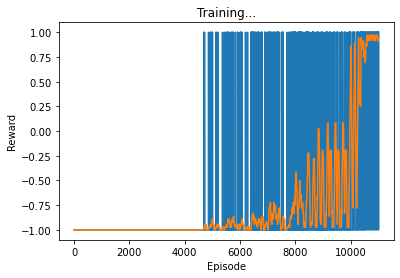

In [85]:
ep_rewards = []
policy_net.train()
dqnloc_count = [0 for i in range(len(em.env.tx_locs))]
loc_errors = [np.abs(20*np.log10(np.abs(x))-20*np.log10(np.abs(y))) for x,y in zip(loc_SNRexh, loc_minSNRexh)]
iter_avg_error = []
iter_errors = []

dqn_epslen=[]
outer = tqdm.notebook.tqdm(total=episodes, desc='training loop: ', position=0)
#eps = 0.5
train_steps = 0
for episode in range(episodes):
    
    #if ((episode+1) > 4100):    
    #    obs = em.test_reset(np.array([[-100,-100,0]]), test_txbdir, em.env.sc_xyz, ch_randvals[episode*(em.env.goal_steps+1)])
    #    test_txbdir = (test_txbdir + 1) % em.env.N_tx
    #else:
    #    #tx_loc_xndx, tx_loc_yndx, tx_dir_ndx =em.env.obs_space.sample()
    tx_num = obs_list[episode]
    
    #policy_net.eval()
    #with torch.no_grad():
    #    action_probs = policy_net(obs).detach().data.cpu().numpy()[0]  
    #policy_net.train()
    #actions= np.argsort(action_probs)[::-1]
    
    obs = em.reset(tx_num, ch_randvals[episode], dqnloc_count[tx_num]+1)
    tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
    dqnloc_count[tx_num] +=1
    #obs = em.test_reset(np.array([[em.env.rx_xcov[tx_loc_xndx],em.env.rx_ycov[tx_loc_yndx], 0]]), tx_dir_ndx, em.env.sc_xyz, ch_randvals[episode*(em.env.goal_steps+1)])
    #dqnloc_maxexhselections[(tx_loc_xndx*len(em.env.rx_ycov)+tx_loc_yndx)*available_actions+tx_dir_ndx]+=1
    
    ep_loss = 0.0
    ep_rwd = 0.0
    timestep = 0
    tx_dirs = [-1.0 for x in range(em.env.action_space.n)]
    rx_dirs = [-1.0 for x in range(em.env.action_space.n)]
    data_rates =[np.inf for x in range(em.env.action_space.n)]
    rssi_vals =[np.complex(0,0) for x in range(em.env.action_space.n)]
    rwd_vals =[-2.0 for x in range(em.env.action_space.n)]
    #agent.current_step +=1
    train_steps +=1
    #if(episode < 144):
    #    eps = 0.9995
    #else:
    eps = strategy.get_exploration_rate(train_steps)
    done = False
    
    if (episode < len(em.env.tx_locs)):
        action_list = list(range(em.env.action_space.n))
        random_actions = random.sample(action_list,len(action_list))
        
    while True:
        
        #rx_dirs.append(em.env.rx_bdir[0]*180/np.pi)
        #data_rates.append(em.env.rate)
        
        
        #else:
        #    data_rates[action.item()] = em.env.rate
        #    rssi_vals[action.item()] = em.env.rssi_val
        if (eps == 1.0):
            action = torch.tensor(np.array([random_actions[em.env.rbdir_count]]), dtype=torch.long).to(device)
        else:
            action = agent.act(obs, policy_net, eps)
        next_obs, reward, done, _ = em.step(action)#,ch_randvals[episode*(em.env.goal_steps+1)+timestep+1])
        #agent.step(obs, action, reward, next_obs, done)
        #if(em.env.rbdir_ndx >= 0):
        tx_dirs[em.env.txdir_ndx] = em.env.tx_bdir*180/np.pi
        rx_dirs[em.env.rbdir_ndx] = em.env.rx_bdir*180/np.pi
        data_rates[em.env.txdir_ndx*em.env.N_rx+em.env.rbdir_ndx] = em.env.rate
        rssi_vals[em.env.txdir_ndx*em.env.N_rx+em.env.rbdir_ndx] = em.env.rssi_val
        #print("action: {}, data rate: {}, rssi_val: {}, datarates: {}, rssi_vals:{}".format(em.env.rbdir_ndx, em.env.rate, em.env.rssi_val, data_rates, rssi_vals))
        
        rwd_vals[em.env.txdir_ndx*em.env.N_rx+em.env.rbdir_ndx] = reward.item()
        ep_rwd += reward.item()
        
        '''
        if(np.all(em.env.tx_loc == np.array([[100,100,0]]))):
            print("ch_model: {}, sc_xyz: {}, min_exh_rate: {}, max_exh_rate: {}, min_action_ndx: {}, max_action_ndx: {}".format(em.env.ch_model, em.env.sc_xyz, min_exh_rate, max_exh_rate, min_action_ndx, max_action_ndx))
        '''   
        memory.add(obs, action, reward, next_obs, done)
        obs = next_obs
        
        ep_rewards.append(reward.item())
        exh_rssi = loc_SNRexh[tx_num]
        if data_rates[em.env.txdir_ndx*em.env.N_rx+em.env.rbdir_ndx] == np.inf:
            #dqn_rate = 0.0
            #print(rssi_vals)
            #print([np.abs(x) for x in rssi_vals])
            #abs_rssi = [np.abs(x) for x in rssi_vals]
            #if np.max(abs_rssi) == 0.0:
            dqn_rssi = loc_minSNRexh[tx_num]
            #else:
            #    beam_ndx = np.argmax(abs_rssi)#loc_minSNRexh[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx]#np.complex(1,0)
            #    dqn_rssi = rssi_vals[em.env.rbdir_ndx]#rssi_vals[beam_ndx]
        else:
            dqn_rate = data_rates[em.env.txdir_ndx*em.env.N_rx+em.env.rbdir_ndx]#max(data_rates)
            dqn_rssi = rssi_vals[em.env.txdir_ndx*em.env.N_rx+em.env.rbdir_ndx]
            #print("came here")
        #SNR_exh = Es * loc_SNRexh[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx]#np.abs(max_rssi_val) ** 2 / (em.env.N0 * em.env.B)
        #error = exh_rate-dqn_rate#np.abs(20*np.log10(np.abs(max_rssi_val))-20*np.log10(np.abs(rssi_val)))#max_exh_rate - dqn_rate
        error = np.abs(20*np.log10(np.abs(exh_rssi))-20*np.log10(np.abs(dqn_rssi)))
        iter_errors.append(error)
        loc_errors[tx_num] = error
        iter_avg_error.append(np.mean(loc_errors))

        #print("exh_rate: {}, dqn_rate: {}, error: {}, iter_avg_error: {}".format(np.abs(exh_rssi), np.abs(dqn_rssi), error, np.mean(loc_errors)))
        #print("best_rate: {}, cur_rate: {}, action: {}, tx action: {}, rxaction: {}".format(em.env.best_rate, em.env.rate, action.item(), int(action.item()/em.env.N_rx), int(action.item()%em.env.N_rx) ))
        print("best_rate: {}, cur_rate: {}, error: {}, action: {}, iter_avg_error: {}".format(em.env.best_rate, em.env.rate, error, action.item(),np.mean(loc_errors)))
        
        if memory.can_provide_sample():
            experiences = memory.sample()
            observations, actions, rewards, next_observations, dones = experiences
            weights, batch_indices = torch.tensor(np.ones_like(rewards.cpu().data.numpy())).to(device), None

            #print(states.shape, states.dtype)
            #print(actions.unsqueeze(-1).shape)
            current_q_values = policy_net(observations).gather(1,index=actions.unsqueeze(-1))#(1-ALPHA)*
            
            next_q_values = target_net(next_observations).detach().max(1)[0]
            target_q_values = ((next_q_values*GAMMA) + rewards)
            #print(policy_net(observations).type())
            #print(target_q_values.unsqueeze(1).type())
            #loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1).float())
            td_errors = ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values)
            #loss = F.mse_loss(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values),  reduction='sum')
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1).float(),  reduction='sum')
            #weighted_loss = torch.mean(weights*loss)
            #print("loss: ", loss)
            #loss = ALPHA*loss
            #ep_loss += weighted_loss.item()
            #ep_loss = torch.mean(loss).detach().numpy()
            ep_loss = loss.item()
            
            optimizer.zero_grad()
            #weighted_loss.backward()
            #ep_loss.backward(torch.ones_like(ep_loss))
            loss.backward(torch.ones_like(loss))
            optimizer.step()
            
        timestep +=1
        if done:
            dqn_epslen.append(em.env.rbdir_count)
            #data_rates.append(em.env.rate)
            #data_rates[em.env.rbdir_ndx] = em.env.rate
            #rssi_vals[em.env.rbdir_ndx] = em.env.rssi_val
            
            #ep_rewards.append(ep_rwd)
            moving_avg_rwd = get_moving_average(len(em.env.tx_locs), ep_rewards)
            
            #print('\rEpisode {},\tScore: {:.2f}, eps: {}, moving avg_rwd: {}, ep_loss: {}'.format(episode+1, ep_rwd, eps, moving_avg_rwd[-1], ep_loss), end="\r")
            print('Episode {},\t Score: {:.2f}, eps: {}, moving avg_rwd: {}, ep_loss: {}'.format(episode+1, ep_rwd, eps, moving_avg_rwd[-1], ep_loss))
            #plot(episode_rewards, 100)
            #min_exh_rate, max_exh_rate,min_action_ndx,max_action_ndx= em.env.get_minmax_exhrate(ch_randvals[episode*(em.env.goal_steps+1):(episode+1)*(em.env.goal_steps+1)])
            
            #if(((episode+1) >= 6000) or (3000 <= (episode+1)<=3500)):
            #if((episode+1) > 4100):
                
            #    test_data_rates.append(np.mean(data_rates[1:]))
            #    test_eps_iters.append(timestep)
            #    test_minexh_rates.append(min_exh_rate)
            #    test_maxexh_rates.append(max_exh_rate)
                
                #if (timestep > 3):
                #    if(timestep >=8):
                #        false_positives +=1
                #if (min_exh_rate == max_exh_rate):
             #   print("\ntest_eps: {0}, eps_rwd: {1}".format(episode+1, ep_rwd))
            print("TX loc: {}".format(em.env.tx_loc))
             #   print("SC_xyz: {}".format(em.env.sc_xyz))
 
            tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
            exh_action_ndx = loc_exhbdir[tx_num]
            #print("TX dirs: {}, episode length: {}".format(tx_dirs, len(tx_dirs)))
            #print("RX dirs: {}".format(rx_dirs))
            #best_action_ndx = em.env.rbdir_ndx#data_rates.index(max(data_rates))
            #print("dqn rx bdir: {}, exh bdir: {}".format(rx_dirs[best_action_ndx], em.env.BeamSet[exh_bdir_ndx]*180/np.pi))
            #print("data rates: ", data_rates)
            #print("rwd vals: ", rwd_vals)
            best_action_ndx = em.env.txdir_ndx*em.env.N_rx + em.env.rbdir_ndx#data_rates.index(max(data_rates))
            print("dqn action ndx: {}, exh action ndx: {}".format(best_action_ndx, exh_action_ndx))
            
            print("\n\n")
            
            timestep = 0
            break
            
    #for local_param, target_param in zip(policy_net.parameters(), target_net.parameters()):
    #    target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)
    
    #Update the policy network
    if episode % UPDATE_EVERY == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    # update tqdm bar
    outer.update(1)
    
#torch.save(policy_net.state_dict(), 'checkpoint.pth')

#timer.finish()
test_rewards = []
plot(ep_rewards, len(em.env.tx_locs), test_rewards)
#print("No. of false positives: {}".format(false_positives))

In [86]:
print("Average episode length: {}".format(np.mean(dqn_epslen)))
print(len(iter_avg_error))
#print(len(cabenv_avgerrors[4]))

Average episode length: 7.338
11007


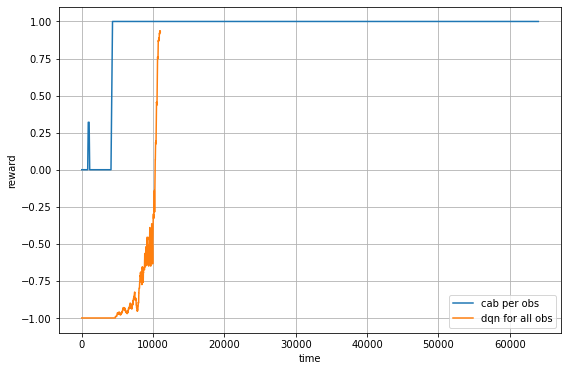

In [87]:
##### from Source.misc_fun.utils import *
fig = plt.figure(figsize=[9, 6])

#loc_ndx = 0
#tbdir_ndx = 3
context_ndx = 0#*len(tx_dirs)+ 4#tbdir_ndx
#context_ndx2 = sel_ctxt_ndices[1]#1*len(tx_dirs)+ 4#tbdir_ndx
#context_ndx3 = sel_ctxt_ndices[2]#2*len(tx_dirs)+ 3#tbdir_ndx
#context_ndx4 = sel_ctxt_ndices[3]#3*len(tx_dirs)+ 3#tbdir_ndx
moving_avg_period = 200
cab_movingavg = get_moving_average(moving_avg_period, train_datarates[context_ndx])

#em.env.obs_space.nvec[3]*len(em.env.tx_locs)
dqn_movingavg = get_moving_average(400, ep_rewards)

plt.plot(np.arange(1,len(train_datarates[context_ndx])+1,1), cab_movingavg, np.arange(1,len(ep_rewards)+1,1), dqn_movingavg)
#min_ndx=0
#max_ndx=500
#plt.plot(test_eps_iters[min_ndx:max_ndx])
plt.grid()
plt.legend(['cab per obs', 'dqn for all obs'])
plt.xlabel('time')
plt.ylabel('reward')
#plt.savefig("121020_cab_dqn_rwdplot_13.pdf")
plt.show()
#plt.savefig("071020_cab_dqn_rwdplot_2.pdf")

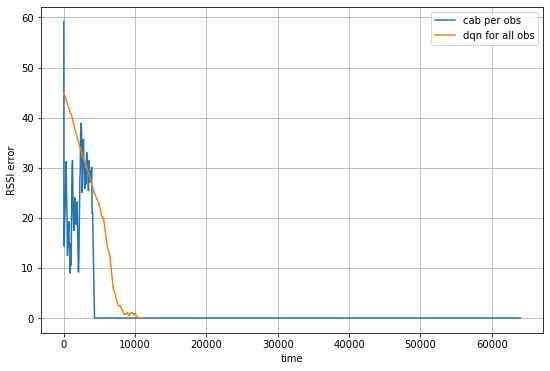

In [89]:
from Source.misc_fun.utils import *
fig = plt.figure(figsize=[9, 6])

#loc_ndx = 0
#tbdir_ndx = 3
context_ndx = 0#0*len(tx_dirs)+ 4#tbdir_ndx
#context_ndx2 = sel_ctxt_ndices[1]#1*len(tx_dirs)+ 4#tbdir_ndx
#context_ndx3 = sel_ctxt_ndices[2]#2*len(tx_dirs)+ 3#tbdir_ndx
#context_ndx4 = sel_ctxt_ndices[3]#3*len(tx_dirs)+ 3#tbdir_ndx
moving_avg_period = 200
#plt.plot(np.arange(1,len(cabenv_avgerrors[context_ndx])+1), cabenv_avgerrors[7], np.arange(1,len(iter_avg_error)+1),iter_avg_error)
cab_movingavg = get_moving_average(moving_avg_period, cabenv_avgerrors)

dqn_movingavg = get_moving_average(moving_avg_period, iter_avg_error)

plt.plot(np.arange(1,len(cabenv_avgerrors)+1,1), cab_movingavg, np.arange(1,len(iter_avg_error)+1,1), dqn_movingavg)
#min_ndx=0
#max_ndx=500
#plt.plot(test_eps_iters[min_ndx:max_ndx])
plt.grid()
plt.legend(['cab per obs', 'dqn for all obs'])
plt.xlabel('time')
plt.ylabel('RSSI error')
#plt.savefig("121020_cab_dqn_erroplot_13.pdf")
plt.show()
#plt.savefig("071020_cab_dqn_erroplot_2.pdf")

## Simulation 2: BeamAlignment over location CAB vs DQN without channel variation for 50 TXlocations

In [90]:
#Assume LOS or NLOS throughout the environment. Do not change in between for now
from Source.nn_model_dqn import QNetwork
from Source.dqn_rcv_agent import Agent, DQN_ReplayBuffer, EpsilonGreedyStrategy
from Source.env_manager import EnvManager
from Source.misc_fun.utils import plot, get_moving_average, Generate_BeamDir, All_Exhaustive_RateMeas
from Source.PER import PrioritizedReplayBuffer

#Hyper-parameters
BUFFER_SIZE = int(1e5)      #replay buffer size
BATCH_SIZE = 64             #minibatch size
GAMMA = 0.999                #discount factor
ALPHA = 1.0                  #non-stationarity parameter
TAU = 1e-3                  #for soft update of target parameters
LR = 7e-4                   #learning rate
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.988 #125e-6
episodes = 1500 #3100 train, 500 test
UPDATE_EVERY = 50

test_episodes = 20
seed = 0                    #random seed number
episode_step_limit = 50
#%%
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Choose the environment
em2 = EnvManager(device, 'combrf-v7', seed)
em2.env.ant_arr = 'ula'
rx_xcov = np.array([-40,-20,20,40,60])
rx_ycov = np.array([-40,-20,20,40,60])
rx_zcov = np.array([41.5, 81.5])
beam_param = 'beam-narrow'
beam_paramvals = np.array([])
em2.env.set_beamparameters(beam_param, beam_paramvals)
em2.env.set_coverage(rx_xcov,rx_ycov,rx_zcov)

available_actions = em2.num_actions_available()
random.seed(seed)
state_size = em2.state_size()
print(em2.env.ch_model)
print(em2.env.sc_xyz)

#Select the strategy
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, len(em2.env.tx_locs), 1200)#episodes
#Initialize the agent
agent = Agent(strategy, state_size, available_actions, seed, device)

#Instantiate MemoryBuffer
#if not PRIORITIZED_REPLAY:
memory = DQN_ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, seed, device)
#else:
#    memory = PrioritizedReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, PER_ALPHA,seed, device)

policy_net = QNetwork(state_size, available_actions, seed).to(device)
target_net = QNetwork(state_size, available_actions, seed).to(device)
print(policy_net)

#Initialize target_net weights to policy_net weights
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() #Set the target_net in eval mode

#Select the optimizer
#optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)
optimizer = optim.SGD(params=policy_net.parameters(), lr=LR, momentum=0.01)

uma-los
[[  0.   20.   21.5]
 [ 20.    0.   21.5]
 [-20.    0.   21.5]
 [  0.  -20.   21.5]]
QNetwork(
  (fc11): Linear(in_features=32, out_features=200, bias=True)
  (fc12): Linear(in_features=3, out_features=32, bias=True)
  (fc22): Linear(in_features=32, out_features=200, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=256, bias=True)
  )
  (softmax): Softmax(dim=1)
  (output): Linear(in_features=256, out_features=64, bias=True)
)


In [91]:
from Source.misc_fun.conversion import *

#loc_SNRexh = [0.0 for i in range(em.env.obs_space.nvec[3] * len(em.env.tx_locs)) ]
loc_SNRexh = [0.0 for i in range(len(em2.env.tx_locs)) ]
loc_minSNRexh = [0.0 for i in range(len(em2.env.tx_locs)) ]
loc_exhbdir = [0 for i in range(len(em2.env.tx_locs)) ]
for loc_ndx in range(len(em2.env.tx_locs)):
    #for tbdir_ndx in range(em2.env.obs_space.nvec[3]):
    min_exh_rate, max_exh_rate,min_action_ndx,max_action_ndx,min_rssi_val,max_rssi_val = em2.env.get_minmax_exhrate(loc_ndx, ch_randvals[loc_ndx])
    #tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
    #Es = db2lin(em.env.P_tx)
    #SNR_exh = Es * np.abs(max_rssi_val) ** 2 / (em.env.N0 * em.env.B)
    #SNR_exh = Es * np.abs(max_rssi_val) ** 2 / (em.env.N0 * em.env.B)
    #exh_rate = np.log2(1 + SNR_exh)
    loc_minSNRexh[loc_ndx] =min_rssi_val
    loc_SNRexh[loc_ndx] =max_rssi_val# max_exh_rate#
    loc_exhbdir[loc_ndx] = max_action_ndx

tx-loc: [[-40.  -40.   41.5]], sc-xyz: [[  0.   20.   21.5]
 [ 20.    0.   21.5]
 [-20.    0.   21.5]
 [  0.  -20.   21.5]], init ch-model: uma-los
txdir_ndx: 0, rxdir_ndx: 0, rate: 18.88342765870174,rssival:(7.606941532537028e-06,-7.592549742902074e-06)
txdir_ndx: 0, rxdir_ndx: 1, rate: 14.027552685136978,rssival:(-1.297671500801055e-06,-1.5181640562842837e-06)
txdir_ndx: 0, rxdir_ndx: 2, rate: 17.164017724713542,rssival:(-3.113242654822508e-06,-5.0384055420396825e-06)
txdir_ndx: 0, rxdir_ndx: 3, rate: 21.47259480997627,rssival:(6.423511317093424e-06,-2.5570232655940707e-05)
txdir_ndx: 0, rxdir_ndx: 4, rate: 17.280283244482096,rssival:(5.308473674098846e-06,-3.1371735920757965e-06)
txdir_ndx: 0, rxdir_ndx: 5, rate: 16.20754333890444,rssival:(4.204420691157604e-06,-6.315391122475732e-07)
txdir_ndx: 0, rxdir_ndx: 6, rate: 18.49992690879444,rssival:(-3.8330017950859444e-06,-8.594007310495846e-06)
txdir_ndx: 0, rxdir_ndx: 7, rate: 19.041355873652677,rssival:(2.1037796268818037e-06,-1.1155

txdir_ndx: 0, rxdir_ndx: 0, rate: 15.51122188805714,rssival:(1.612512414379097e-06,-2.9249273759757714e-06)
txdir_ndx: 0, rxdir_ndx: 1, rate: 10.473819504537706,rssival:(-7.633481327406046e-08,-5.776036298077938e-07)
txdir_ndx: 0, rxdir_ndx: 2, rate: 14.509967157154314,rssival:(-1.0353633875852504e-06,-2.1214976906604335e-06)
txdir_ndx: 0, rxdir_ndx: 3, rate: 13.761325990002318,rssival:(3.9297915432612623e-07,-1.7782457834763907e-06)
txdir_ndx: 0, rxdir_ndx: 4, rate: 18.58778299583335,rssival:(-9.699814729463719e-06,-1.4975338093636454e-07)
txdir_ndx: 0, rxdir_ndx: 5, rate: 18.2256783750609,rssival:(8.051226076803489e-06,2.897772042043161e-06)
txdir_ndx: 0, rxdir_ndx: 6, rate: 16.194520228055953,rssival:(2.1472124795947095e-06,-3.6473325714006494e-06)
txdir_ndx: 0, rxdir_ndx: 7, rate: 15.169063084713653,rssival:(1.903820441280035e-06,-2.2749644753202443e-06)


txdir_ndx: 1, rxdir_ndx: 0, rate: 20.17083697841897,rssival:(1.3926606394248873e-06,-1.6733625741117823e-05)
txdir_ndx: 1, rxdi

txdir_ndx: 0, rxdir_ndx: 0, rate: 16.622954085132537,rssival:(3.261210475970793e-06,-3.670442586808945e-06)
txdir_ndx: 0, rxdir_ndx: 1, rate: 11.941769384230039,rssival:(2.3056633139318582e-07,-9.414269723411781e-07)
txdir_ndx: 0, rxdir_ndx: 2, rate: 13.352824234985782,rssival:(-1.4641578313003646e-06,-5.957518050470525e-07)
txdir_ndx: 0, rxdir_ndx: 3, rate: 16.218985571138642,rssival:(-2.2218735759908225e-06,-3.6446135849275764e-06)
txdir_ndx: 0, rxdir_ndx: 4, rate: 19.78026344675129,rssival:(5.297203556726608e-06,-1.3675573056628087e-05)
txdir_ndx: 0, rxdir_ndx: 5, rate: 16.00762967725106,rssival:(2.4445772706308187e-06,-3.124263184116287e-06)
txdir_ndx: 0, rxdir_ndx: 6, rate: 17.62870472383943,rssival:(-3.5343044551590524e-06,-5.993061775492655e-06)
txdir_ndx: 0, rxdir_ndx: 7, rate: 17.664405410557517,rssival:(1.1900331075235572e-06,-6.942965338714152e-06)


txdir_ndx: 1, rxdir_ndx: 0, rate: 17.46795712742505,rssival:(6.570356739691271e-06,-3.6660912356588e-07)
txdir_ndx: 1, rxdir_n

txdir_ndx: 7, rxdir_ndx: 7, rate: 14.130501816378144,rssival:(-1.002516097786951e-07,2.067311473989991e-06)


tx-loc: [[20.  60.  81.5]], sc-xyz: [[  0.   20.   21.5]
 [ 20.    0.   21.5]
 [-20.    0.   21.5]
 [  0.  -20.   21.5]], init ch-model: uma-los
txdir_ndx: 0, rxdir_ndx: 0, rate: 15.877737694661125,rssival:(-1.9807647595798194e-06,-3.2339717119365197e-06)
txdir_ndx: 0, rxdir_ndx: 1, rate: 12.51497441011521,rssival:(-1.0496496830853498e-06,5.441349636048962e-07)
txdir_ndx: 0, rxdir_ndx: 2, rate: 17.086777069214587,rssival:(-4.739183753024332e-06,3.28470518269941e-06)
txdir_ndx: 0, rxdir_ndx: 3, rate: 15.996120484223997,rssival:(-2.6063188972048526e-06,-2.969686019374505e-06)
txdir_ndx: 0, rxdir_ndx: 4, rate: 14.605609236369807,rssival:(-7.16543764113938e-07,-2.3326531903510184e-06)
txdir_ndx: 0, rxdir_ndx: 5, rate: 12.939624895842918,rssival:(-1.3729391826885536e-07,-1.3628972425948361e-06)
txdir_ndx: 0, rxdir_ndx: 6, rate: 16.112979458882684,rssival:(-4.114495294491384e-06,9.08

txdir_ndx: 4, rxdir_ndx: 0, rate: 19.24508875101917,rssival:(-1.0252335988924843e-05,6.581188020835382e-06)
txdir_ndx: 4, rxdir_ndx: 1, rate: 16.286913358956866,rssival:(-2.5488606609215874e-06,-3.5498780537977975e-06)
txdir_ndx: 4, rxdir_ndx: 2, rate: 23.9036234938717,rssival:(8.294079070818627e-06,-6.06606973262041e-05)
txdir_ndx: 4, rxdir_ndx: 3, rate: 21.807638437085565,rssival:(-2.779358262569913e-06,-2.9480214237739205e-05)
txdir_ndx: 4, rxdir_ndx: 4, rate: 18.316892914119492,rssival:(-3.0434535623034424e-09,-8.831653703357118e-06)
txdir_ndx: 4, rxdir_ndx: 5, rate: 17.760558972538483,rssival:(-1.0605291018842048e-06,-7.205283117657742e-06)
txdir_ndx: 4, rxdir_ndx: 6, rate: 15.632654771933128,rssival:(-1.4336419702077455e-06,-3.174853759062491e-06)
txdir_ndx: 4, rxdir_ndx: 7, rate: 14.49096769268263,rssival:(-1.170712347446754e-06,2.0320557957992347e-06)


txdir_ndx: 5, rxdir_ndx: 0, rate: 18.571116047275673,rssival:(-9.633914368649033e-06,-4.642981269119251e-07)
txdir_ndx: 5, rxd

In [92]:
print(np.mean([np.abs(20*np.log10(np.abs(x))-20*np.log10(np.abs(y))) for x,y in zip(loc_SNRexh, loc_minSNRexh)]))
print(len(em2.env.tx_locs))

46.04063242120144
50


In [93]:
locndx_list = list(range(len(em2.env.tx_locs)))
random_loc_ndices = random.sample(locndx_list, len(locndx_list))
#txdir_list = list(range(em.env.obs_space.nvec[3]))
#txdir_ndices = random.sample(txdir_list, len(txdir_list))

obs_list = []
for eps in range(episodes):
    ndx = eps % (len(em2.env.tx_locs))
    #ndx = eps % (em2.env.obs_space.nvec[3] * len(em2.env.tx_locs))
    #ndx1 = int(ndx / em2.env.obs_space.nvec[3])    
    #ndx2 = int(ndx % em2.env.obs_space.nvec[3])
    obs_list.append((random_loc_ndices[ndx]))

In [94]:
action_list = list(range(em2.env.action_space.n))
random_actions = random.sample(action_list,len(action_list))
print(random_actions)

[63, 52, 55, 21, 15, 46, 20, 45, 61, 4, 12, 36, 14, 59, 9, 34, 28, 5, 58, 57, 32, 31, 6, 19, 35, 18, 7, 39, 60, 48, 13, 38, 47, 2, 40, 25, 53, 10, 43, 37, 49, 56, 41, 22, 1, 8, 50, 30, 16, 26, 27, 17, 33, 0, 29, 42, 62, 24, 44, 54, 11, 3, 51, 23]


init rate: -inf, init tx action: -1, init rx action: -1
best_rate: inf, cur_rate: 18.111897368725, error: 24.50089106137854, action: 53, iter_avg_error: 45.34649878208678
best_rate: inf, cur_rate: 15.659614914207616, error: 31.883065399686913, action: 37, iter_avg_error: 45.49414226885295
best_rate: inf, cur_rate: 15.047120424856208, error: 33.72690191112952, action: 17, iter_avg_error: 45.531018999081795
best_rate: inf, cur_rate: 17.38995454591361, error: 26.67416546536647, action: 28, iter_avg_error: 45.38996427016654
best_rate: inf, cur_rate: 24.117183324258516, error: 6.423163917837002, action: 31, iter_avg_error: 44.98494423921595
best_rate: inf, cur_rate: 18.936518417515785, error: 22.018527679453314, action: 42, iter_avg_error: 45.29685151444828
best_rate: inf, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 44.85648096085921
best_rate: inf, cur_rate: 20.32912629541655, error: 17.826354885758548, action: 44, iter_avg_error: 45.21300805857438
best_rate: inf,

best_rate: inf, cur_rate: 13.090048031081697, error: 34.735825152442914, action: 12, iter_avg_error: 45.23576066909773
best_rate: inf, cur_rate: 16.572533159259446, error: 24.252046788377015, action: 59, iter_avg_error: 45.026085101816406
best_rate: inf, cur_rate: 14.896258497847395, error: 29.298234187675163, action: 60, iter_avg_error: 45.127008849802365
best_rate: inf, cur_rate: 14.30443080096484, error: 31.07988530869443, action: 30, iter_avg_error: 45.16264187222276
best_rate: inf, cur_rate: 13.350051321821306, error: 33.95305511085088, action: 36, iter_avg_error: 45.22010526826589
best_rate: inf, cur_rate: 13.90693045982828, error: 32.276548662880245, action: 10, iter_avg_error: 45.18657513930647
best_rate: inf, cur_rate: 13.684071545039119, error: 32.947468077080345, action: 13, iter_avg_error: 45.19999352759048
best_rate: inf, cur_rate: 16.51943978753598, error: 24.411875433452522, action: 50, iter_avg_error: 45.02928167471792
best_rate: inf, cur_rate: 14.8606425804396, error: 

best_rate: inf, cur_rate: 17.1070535131473, error: 27.670783825590064, action: 27, iter_avg_error: 44.901465311739486
best_rate: inf, cur_rate: 22.322553764927402, error: 11.970533707311574, action: 31, iter_avg_error: 44.58746030937392
best_rate: inf, cur_rate: 15.13395491273077, error: 33.61049247821286, action: 9, iter_avg_error: 45.02025948479194
best_rate: inf, cur_rate: 21.714250340118326, error: 13.801709914891347, action: 30, iter_avg_error: 44.62408383352551
best_rate: inf, cur_rate: 17.270395441826548, error: 27.179072331550202, action: 22, iter_avg_error: 44.891631081858684
best_rate: inf, cur_rate: 15.238465866523166, error: 33.29587471794264, action: 13, iter_avg_error: 45.01396712958653
best_rate: inf, cur_rate: 17.618908535811855, error: 26.12993748430185, action: 6, iter_avg_error: 44.87064838491372
best_rate: inf, cur_rate: 15.319935611709452, error: 33.05062017907699, action: 8, iter_avg_error: 45.00906203880922
best_rate: inf, cur_rate: 11.249182721553662, error: 45.

best_rate: inf, cur_rate: 17.21100462325228, error: 23.483002637055804, action: 53, iter_avg_error: 44.31570691873633
best_rate: inf, cur_rate: 18.489717197804225, error: 19.63367740202513, action: 21, iter_avg_error: 44.238720414035726
best_rate: inf, cur_rate: 22.87400474719877, error: 6.435645548690445, action: 61, iter_avg_error: 43.97475977696903
best_rate: inf, cur_rate: 19.506342148266633, error: 16.57332539090416, action: 4, iter_avg_error: 44.177513373813305
best_rate: inf, cur_rate: 20.70166102013068, error: 12.975053757739971, action: 0, iter_avg_error: 44.10554794115003
best_rate: inf, cur_rate: 11.830351732411602, error: 39.68154593569726, action: 34, iter_avg_error: 44.63967778470917
best_rate: inf, cur_rate: 16.463901580850198, error: 25.73202631357853, action: 10, iter_avg_error: 44.3606873922668
best_rate: inf, cur_rate: 22.30234489912146, error: 8.1565134392755, action: 59, iter_avg_error: 44.00917713478074
best_rate: inf, cur_rate: 14.132760086405842, error: 32.74965

best_rate: inf, cur_rate: 16.052051525362515, error: 26.971834391872434, action: 23, iter_avg_error: 43.28143392501179
best_rate: inf, cur_rate: 16.63959386564042, error: 25.203134327419335, action: 14, iter_avg_error: 43.246059923722726
best_rate: inf, cur_rate: 17.21233428768898, error: 23.478999921888715, action: 16, iter_avg_error: 43.21157723561211
best_rate: inf, cur_rate: 14.718239365606875, error: 30.98710628251706, action: 37, iter_avg_error: 43.36173936282467
best_rate: inf, cur_rate: 24.58083143123135, error: 1.2975848638568976, action: 49, iter_avg_error: 42.76794893445148
best_rate: inf, cur_rate: 20.754243910220374, error: 12.816763394835817, action: 63, iter_avg_error: 42.998332505071055
best_rate: inf, cur_rate: 18.074514094131665, error: 20.883567221641172, action: 27, iter_avg_error: 43.15966858160716
best_rate: inf, cur_rate: 15.06901116232502, error: 29.931143181230055, action: 12, iter_avg_error: 43.340620100798944
best_rate: inf, cur_rate: 14.13276008640585, error

best_rate: inf, cur_rate: 10.926150062757685, error: 33.154296002684546, action: 28, iter_avg_error: 42.980874173706155
best_rate: inf, cur_rate: 13.32725140308976, error: 25.924450787645867, action: 21, iter_avg_error: 42.83627726940537
best_rate: inf, cur_rate: 15.393626654496742, error: 19.703719773209713, action: 10, iter_avg_error: 42.711862649116654
best_rate: inf, cur_rate: 13.473619532945934, error: 25.48379804183999, action: 9, iter_avg_error: 42.827464214489254
best_rate: inf, cur_rate: 14.248685322916645, error: 23.150458831818185, action: 41, iter_avg_error: 42.78079743028882
best_rate: inf, cur_rate: 9.494261538787113, error: 37.46850342099975, action: 29, iter_avg_error: 43.06715832207246
best_rate: inf, cur_rate: 15.866536846375043, error: 18.280090045232498, action: 23, iter_avg_error: 42.683390054557115
best_rate: inf, cur_rate: 21.785643677397513, error: 0.4617315181275643, action: 32, iter_avg_error: 42.327022884015015
best_rate: inf, cur_rate: 15.660711972564679, er

best_rate: inf, cur_rate: 14.111716144788371, error: 33.432434895033026, action: 20, iter_avg_error: 42.41266581369919
best_rate: inf, cur_rate: 21.283102557046938, error: 11.84416706327687, action: 42, iter_avg_error: 41.980900457064074
best_rate: inf, cur_rate: 20.290649393725054, error: 14.831750461925978, action: 50, iter_avg_error: 42.04065212503705
best_rate: inf, cur_rate: 11.592866938164295, error: 41.016087446892726, action: 12, iter_avg_error: 42.56433886473639
best_rate: inf, cur_rate: 15.2953160680721, error: 29.869306773747937, action: 57, iter_avg_error: 42.34140325127348
best_rate: inf, cur_rate: 17.440957170801703, error: 23.41019985911889, action: 59, iter_avg_error: 42.212221112980906
best_rate: inf, cur_rate: 13.294600862038461, error: 35.89238391477994, action: 53, iter_avg_error: 42.461864794094126
best_rate: inf, cur_rate: 16.374437249679485, error: 26.62077144322342, action: 28, iter_avg_error: 42.276432544663
best_rate: inf, cur_rate: 19.91830092006604, error: 1

best_rate: inf, cur_rate: 15.167127941742217, error: 18.38592609015481, action: 0, iter_avg_error: 41.727186385713665
best_rate: inf, cur_rate: 15.74314910919019, error: 16.65189073692109, action: 25, iter_avg_error: 41.69250567864899
best_rate: inf, cur_rate: 12.514974410115201, error: 26.37032777074944, action: 53, iter_avg_error: 41.88687441932556
best_rate: inf, cur_rate: 15.877737694661127, error: 16.2467316710526, action: 54, iter_avg_error: 41.68440249733163
best_rate: inf, cur_rate: 15.312928455534662, error: 17.94701146337725, action: 21, iter_avg_error: 41.71840809317812
best_rate: inf, cur_rate: 15.723200793960318, error: 16.71194225187037, action: 47, iter_avg_error: 41.693706708947985
best_rate: inf, cur_rate: 15.106912569660745, error: 18.56719745322806, action: 29, iter_avg_error: 41.73081181297513
best_rate: inf, cur_rate: 14.714992633450624, error: 19.747032436191603, action: 15, iter_avg_error: 41.754408512634406
best_rate: inf, cur_rate: 13.628678257565193, error: 23

best_rate: inf, cur_rate: 18.865652119186723, error: 20.6918518094232, action: 17, iter_avg_error: 40.6837514064932
best_rate: inf, cur_rate: 20.893039226070766, error: 14.588801627763246, action: 33, iter_avg_error: 40.56169040286
best_rate: inf, cur_rate: 19.355568496514206, error: 19.217053942113708, action: 40, iter_avg_error: 40.65425544914701
best_rate: inf, cur_rate: 16.551910962300813, error: 27.65694282446414, action: 2, iter_avg_error: 40.823053226794016
best_rate: inf, cur_rate: 21.151217587114417, error: 13.811606953266661, action: 57, iter_avg_error: 40.54614650937007
best_rate: inf, cur_rate: 18.238838769382966, error: 22.578752956561914, action: 31, iter_avg_error: 40.72148942943598
best_rate: inf, cur_rate: 14.614921547356893, error: 33.48798986002831, action: 58, iter_avg_error: 40.9396741675053
best_rate: inf, cur_rate: 21.65609507459194, error: 12.291773723965306, action: 43, iter_avg_error: 40.51574984478404
best_rate: inf, cur_rate: 14.605140924335405, error: 33.51

Episode 11,	 Score: -64.00, eps: 1.0, moving avg_rwd: -1.0, ep_loss: 624.301513671875
dqn action ndx: 47, exh action ndx: 41



init rate: -inf, init tx action: -1, init rx action: -1
best_rate: inf, cur_rate: 17.280354499563195, error: 14.024029415788462, action: 51, iter_avg_error: 39.40863538581973
best_rate: inf, cur_rate: 14.263547681185088, error: 23.10571638870006, action: 17, iter_avg_error: 39.590269125277956
best_rate: inf, cur_rate: 19.48436678669341, error: 7.3892699622742555, action: 40, iter_avg_error: 39.275940196749445
best_rate: inf, cur_rate: 14.89414315371626, error: 21.20735667336659, action: 1, iter_avg_error: 39.55230193097129
best_rate: inf, cur_rate: 15.45288881653979, error: 19.525318829021728, action: 7, iter_avg_error: 39.51866117408439
best_rate: inf, cur_rate: 16.45749221795069, error: 16.50111268423497, action: 62, iter_avg_error: 39.458177051188656
best_rate: inf, cur_rate: 16.11827546315631, error: 17.52226965885015, action: 56, iter_avg_error: 39.478600

best_rate: inf, cur_rate: 22.383898111008186, error: 8.530441346548656, action: 30, iter_avg_error: 38.36756694843468
best_rate: inf, cur_rate: 14.76691381555161, error: 31.460003826072864, action: 47, iter_avg_error: 38.82615819802516
best_rate: inf, cur_rate: 16.374437249679495, error: 26.62077144322339, action: 26, iter_avg_error: 38.72937355036817
best_rate: inf, cur_rate: 17.850645599917144, error: 22.176908764674266, action: 13, iter_avg_error: 38.64049629679719
best_rate: inf, cur_rate: 19.097024687133302, error: 18.42492322314729, action: 60, iter_avg_error: 38.56545658596665
best_rate: inf, cur_rate: 22.565796123974685, error: 7.982873672003933, action: 31, iter_avg_error: 38.35661559494378
best_rate: inf, cur_rate: 15.56691110346734, error: 29.05170571709803, action: 44, iter_avg_error: 38.777992235845666
best_rate: inf, cur_rate: 18.274339040703435, error: 20.901459742287216, action: 32, iter_avg_error: 38.61498731634945
best_rate: inf, cur_rate: 25.217649161469172, error: 0

best_rate: inf, cur_rate: 19.416188936587584, error: 20.045002975874567, action: 14, iter_avg_error: 37.80996338114883
best_rate: inf, cur_rate: 20.791600348994894, error: 15.904598245767033, action: 61, iter_avg_error: 37.72715528654668
best_rate: inf, cur_rate: 13.340552232052266, error: 38.33490437246762, action: 12, iter_avg_error: 38.1757614090807
best_rate: inf, cur_rate: 12.687766550494697, error: 40.300224677817056, action: 28, iter_avg_error: 38.21506781518769
best_rate: inf, cur_rate: 16.924579691604386, error: 27.54552288274658, action: 13, iter_avg_error: 37.95997377928627
best_rate: inf, cur_rate: 11.47682453292473, error: 43.946389113216995, action: 37, iter_avg_error: 38.287991103895685
best_rate: inf, cur_rate: 18.16292277407777, error: 23.817718640769186, action: 45, iter_avg_error: 37.88541769444673
best_rate: inf, cur_rate: 20.582710765245782, error: 16.533418923448778, action: 3, iter_avg_error: 37.73973170010032
best_rate: inf, cur_rate: 24.928620806723355, error: 

best_rate: inf, cur_rate: 20.816904574055446, error: 1.6575638392361327, action: 23, iter_avg_error: 37.12470152532365
best_rate: inf, cur_rate: 15.675482166172086, error: 17.13486812437074, action: 55, iter_avg_error: 37.434247611026336
best_rate: inf, cur_rate: 19.592373808987453, error: 5.34377189116816, action: 13, iter_avg_error: 37.19842568636229
best_rate: inf, cur_rate: 13.842115057765687, error: 22.654065804680613, action: 46, iter_avg_error: 37.54463156463254
best_rate: inf, cur_rate: 21.367535114917576, error: 0.0, action: 22, iter_avg_error: 37.09155024853892
best_rate: inf, cur_rate: 12.148376679904446, error: 27.753387399427254, action: 44, iter_avg_error: 37.64661799652747
best_rate: inf, cur_rate: 9.892789595686711, error: 34.546995072806055, action: 57, iter_avg_error: 37.78249014999505
best_rate: inf, cur_rate: 15.095535514423652, error: 18.880722565908073, action: 48, iter_avg_error: 37.46916469985709
best_rate: inf, cur_rate: 20.306848017241496, error: 3.19298806721

best_rate: inf, cur_rate: 18.394126970665532, error: 19.201798797635377, action: 60, iter_avg_error: 36.58899871431061
best_rate: inf, cur_rate: 11.941769384230039, error: 38.62642205443127, action: 1, iter_avg_error: 36.97749117944653
best_rate: inf, cur_rate: 17.664405410557517, error: 21.398487877629478, action: 7, iter_avg_error: 36.632932495910495
best_rate: inf, cur_rate: 15.31780715190961, error: 28.462537941483347, action: 52, iter_avg_error: 36.774213497187574
best_rate: inf, cur_rate: 17.962249154445246, error: 20.501884968671746, action: 11, iter_avg_error: 36.61500043773134
best_rate: inf, cur_rate: 13.641646385067654, error: 33.5085181176633, action: 26, iter_avg_error: 36.875133100711174
best_rate: inf, cur_rate: 14.937716724520952, error: 29.606756190496355, action: 62, iter_avg_error: 36.79709786216783
best_rate: inf, cur_rate: 14.009524712437615, error: 32.401017514823025, action: 40, iter_avg_error: 36.85298308865436
best_rate: inf, cur_rate: 11.92642816142302, error:

best_rate: inf, cur_rate: 16.07601144573181, error: 18.22305364473408, action: 6, iter_avg_error: 36.007927031218195
best_rate: inf, cur_rate: 16.31199752307667, error: 17.512655279858933, action: 59, iter_avg_error: 35.99371906392069
best_rate: inf, cur_rate: 16.350939060360396, error: 17.39542815025547, action: 16, iter_avg_error: 35.99137452132862
best_rate: inf, cur_rate: 17.282514247724873, error: 14.5910826862318, action: 19, iter_avg_error: 35.93528761204815
best_rate: inf, cur_rate: 20.46372110389039, error: 5.014671586831696, action: 47, iter_avg_error: 35.74375939006015
best_rate: inf, cur_rate: 21.91979067719644, error: 0.631463504836546, action: 39, iter_avg_error: 35.65609522842024
best_rate: inf, cur_rate: 12.028072134701002, error: 30.409542291729593, action: 53, iter_avg_error: 36.2516568041581
best_rate: inf, cur_rate: 17.647713271964296, error: 13.491717987150665, action: 48, iter_avg_error: 35.913300318066526
best_rate: inf, cur_rate: 16.53254396976249, error: 16.848

best_rate: inf, cur_rate: 16.207543338904326, error: 28.693604852730488, action: 5, iter_avg_error: 35.83876458151747
best_rate: inf, cur_rate: 16.119783128270367, error: 28.957793010419138, action: 49, iter_avg_error: 35.84404834467124
best_rate: inf, cur_rate: 15.747709579831744, error: 30.07786394088798, action: 54, iter_avg_error: 35.86644976328061
best_rate: inf, cur_rate: 15.504966057431147, error: 30.80860921962504, action: 25, iter_avg_error: 35.88106466885536
best_rate: inf, cur_rate: 20.86231438926392, error: 14.681292650677264, action: 12, iter_avg_error: 35.5585183374764
best_rate: inf, cur_rate: 14.135939807678213, error: 34.929936726577765, action: 50, iter_avg_error: 35.96349121899441
best_rate: inf, cur_rate: 15.259066102997823, error: 31.54885919803833, action: 18, iter_avg_error: 35.89586966842362
best_rate: inf, cur_rate: 15.157111191098574, error: 31.855782175058422, action: 26, iter_avg_error: 35.902008127964024
best_rate: inf, cur_rate: 18.00918920627007, error: 2

best_rate: inf, cur_rate: 16.498263466227254, error: 24.667168960474086, action: 34, iter_avg_error: 35.60354073016324
best_rate: inf, cur_rate: 18.51969571976142, error: 18.582016175837367, action: 17, iter_avg_error: 35.481837674470505
best_rate: inf, cur_rate: 17.13046030732904, error: 22.76405019119329, action: 22, iter_avg_error: 35.565478354777625
best_rate: inf, cur_rate: 17.122664173905864, error: 22.787519055314064, action: 23, iter_avg_error: 35.56594773206004
best_rate: inf, cur_rate: 14.894972989949482, error: 29.4936498432986, action: 58, iter_avg_error: 35.700070347819725
best_rate: inf, cur_rate: 11.99220686286768, error: 38.232770205963945, action: 28, iter_avg_error: 35.874852755073036
best_rate: inf, cur_rate: 17.956056883893055, error: 20.278743662619746, action: 3, iter_avg_error: 35.51577222420615
best_rate: inf, cur_rate: 15.483781420484654, error: 27.72111208123752, action: 19, iter_avg_error: 35.66461959257851
best_rate: inf, cur_rate: 13.899312555144919, error:

best_rate: inf, cur_rate: 15.285844327204439, error: 18.028544835652127, action: 8, iter_avg_error: 34.91651743034545
best_rate: inf, cur_rate: 8.78124333515541, error: 37.6191185648192, action: 61, iter_avg_error: 35.308328904928786
best_rate: inf, cur_rate: 15.475223294484627, error: 17.458443964655856, action: 14, iter_avg_error: 34.90511541292552
best_rate: inf, cur_rate: 14.146016996266987, error: 21.45989784850586, action: 28, iter_avg_error: 34.98514449060252
best_rate: inf, cur_rate: 21.01581335939459, error: 0.779512639148507, action: 35, iter_avg_error: 34.57153678641537
best_rate: inf, cur_rate: 16.112979458882684, error: 15.538572545932468, action: 6, iter_avg_error: 34.86671798455105
best_rate: inf, cur_rate: 15.743149109190204, error: 16.65189073692109, action: 29, iter_avg_error: 34.888984348370826
Episode 20,	 Score: -64.00, eps: 1.0, moving avg_rwd: -1.0, ep_loss: 1125.639892578125
dqn action ndx: 29, exh action ndx: 34



init rate: -inf, init tx action: -1, init rx a

best_rate: inf, cur_rate: 13.96194160621163, error: 29.927716445125682, action: 28, iter_avg_error: 33.98224116852393
best_rate: inf, cur_rate: 15.023912384095134, error: 26.730724051450423, action: 15, iter_avg_error: 33.91830132065042
best_rate: inf, cur_rate: 19.17447598029691, error: 14.236159618250156, action: 47, iter_avg_error: 33.66841003198641
best_rate: inf, cur_rate: 13.315456574034, error: 31.873984186277383, action: 45, iter_avg_error: 34.02116652334696
best_rate: inf, cur_rate: 12.801121523877462, error: 33.42246946780075, action: 61, iter_avg_error: 34.05213622897743
best_rate: inf, cur_rate: 16.996406973221273, error: 20.792826532662275, action: 55, iter_avg_error: 33.79954337027466
best_rate: inf, cur_rate: 19.24508875101917, error: 14.023593647003125, action: 32, iter_avg_error: 33.66415871256147
best_rate: inf, cur_rate: 15.754771196770164, error: 24.53056798687352, action: 51, iter_avg_error: 33.87429819935888
best_rate: inf, cur_rate: 16.702486330985916, error: 21.

best_rate: inf, cur_rate: 17.996768121760063, error: 24.31789578972905, action: 1, iter_avg_error: 33.15665490682512
best_rate: inf, cur_rate: 20.791600348994884, error: 15.904598245767062, action: 61, iter_avg_error: 32.98838895594588
best_rate: inf, cur_rate: 13.549053630264913, error: 37.707196278592804, action: 25, iter_avg_error: 33.4244409166024
best_rate: inf, cur_rate: 21.497163594754173, error: 13.78064031216023, action: 8, iter_avg_error: 32.94590979727374
best_rate: inf, cur_rate: 26.074992749615536, error: 0.0, action: 48, iter_avg_error: 32.67029699103054
best_rate: inf, cur_rate: 22.56641020278709, error: 10.561886526374622, action: 40, iter_avg_error: 32.88153472155803
best_rate: inf, cur_rate: 13.40259498488983, error: 38.14811945123347, action: 17, iter_avg_error: 33.433259380055205
best_rate: inf, cur_rate: 13.327727647796275, error: 38.37351395659604, action: 26, iter_avg_error: 33.43776727016246
best_rate: inf, cur_rate: 16.84060711026922, error: 27.798307633100904,

best_rate: inf, cur_rate: 17.118506299991623, error: 20.892099239901953, action: 0, iter_avg_error: 32.63889918628547
best_rate: inf, cur_rate: 12.57962053327031, error: 34.556185885087416, action: 52, iter_avg_error: 32.91218091918918
best_rate: inf, cur_rate: 17.395440679398977, error: 20.058438358817284, action: 6, iter_avg_error: 32.62222596866378
best_rate: inf, cur_rate: 16.397989038364756, error: 23.06109209226689, action: 27, iter_avg_error: 32.68227904333278
best_rate: inf, cur_rate: 20.399842775782886, error: 11.01426480708841, action: 38, iter_avg_error: 32.4413424976292
best_rate: inf, cur_rate: 16.36432494600232, error: 23.162432295377386, action: 22, iter_avg_error: 32.68430584739498
best_rate: inf, cur_rate: 15.20600353973861, error: 26.649390596751914, action: 36, iter_avg_error: 32.75404501342248
best_rate: inf, cur_rate: 11.91998886476045, error: 36.54228642671109, action: 28, iter_avg_error: 32.95190293002165
best_rate: inf, cur_rate: 14.171955137313798, error: 29.76

best_rate: inf, cur_rate: 19.506760967425834, error: 16.572064617914663, action: 30, iter_avg_error: 32.165511790611156
best_rate: inf, cur_rate: 24.58083143123134, error: 1.297584863856926, action: 5, iter_avg_error: 31.86002219553
best_rate: inf, cur_rate: 23.051344277826946, error: 5.901800301981538, action: 3, iter_avg_error: 31.952106504292487
best_rate: inf, cur_rate: 11.83035173241157, error: 39.68154593569734, action: 34, iter_avg_error: 32.62770141696681
best_rate: inf, cur_rate: 16.78542394859575, error: 24.764137945436175, action: 55, iter_avg_error: 32.329353257161586
best_rate: inf, cur_rate: 18.48079573142201, error: 19.660533765075215, action: 16, iter_avg_error: 32.22728117355437
best_rate: inf, cur_rate: 16.03857632790321, error: 27.01239937803534, action: 57, iter_avg_error: 32.37431848581357
best_rate: inf, cur_rate: 12.057629304071416, error: 38.99719840083651, action: 33, iter_avg_error: 32.614014466269595
best_rate: inf, cur_rate: 22.874004747198768, error: 6.4356

best_rate: inf, cur_rate: 11.554252619271834, error: 37.176754706425456, action: 1, iter_avg_error: 32.18563033810027
best_rate: inf, cur_rate: 15.017338895002947, error: 26.750512820713112, action: 40, iter_avg_error: 31.977105500386024
best_rate: inf, cur_rate: 23.903623493871706, error: 0.0, action: 20, iter_avg_error: 31.442095243971764
best_rate: inf, cur_rate: 16.237673708341628, error: 23.076864233341794, action: 32, iter_avg_error: 31.903632528638596
best_rate: inf, cur_rate: 11.779027643409194, error: 36.49990604917309, action: 45, iter_avg_error: 32.172093364955224
best_rate: inf, cur_rate: 12.589114880133154, error: 34.06076939773851, action: 2, iter_avg_error: 32.123310631926536
best_rate: inf, cur_rate: 15.754771196770152, error: 24.530567986873606, action: 3, iter_avg_error: 31.93270660370923
best_rate: inf, cur_rate: 16.996406973221276, error: 20.792826532662318, action: 7, iter_avg_error: 31.857951774625008
best_rate: inf, cur_rate: 13.247758636746287, error: 32.0777957

best_rate: inf, cur_rate: 4.467832707040394, error: 53.36792398145937, action: 52, iter_avg_error: 31.78059031218986
best_rate: inf, cur_rate: 14.132836454637593, error: 24.072772131094325, action: 26, iter_avg_error: 31.19468727518256
best_rate: inf, cur_rate: 14.04182611981369, error: 24.34675628109335, action: 36, iter_avg_error: 31.20016695818254
best_rate: inf, cur_rate: 15.70054286877968, error: 19.353345373856385, action: 27, iter_avg_error: 31.1002987400378
best_rate: inf, cur_rate: 8.166036295627986, error: 42.04953538218723, action: 41, iter_avg_error: 31.554222540204417
best_rate: inf, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 30.713231832560673
best_rate: inf, cur_rate: 17.794905733433872, error: 13.048622475420089, action: 14, iter_avg_error: 30.974204282069078
best_rate: inf, cur_rate: 22.050550308831735, error: 0.23783769654475861, action: 19, iter_avg_error: 30.71798858649157
best_rate: inf, cur_rate: 16.425841661345363, error: 17.16994622492

best_rate: inf, cur_rate: 16.373803359505466, error: 23.1975759079386, action: 15, iter_avg_error: 30.68243832717235
best_rate: inf, cur_rate: 17.256477078868876, error: 20.54043984400853, action: 11, iter_avg_error: 30.62929560589375
best_rate: inf, cur_rate: 15.064083124630885, error: 27.140302311529695, action: 19, iter_avg_error: 30.761292855244168
best_rate: inf, cur_rate: 16.13572430825652, error: 23.914274441681457, action: 23, iter_avg_error: 30.696772297847204
best_rate: inf, cur_rate: 12.987038071930261, error: 33.3932391260344, action: 38, iter_avg_error: 30.886351591534268
best_rate: inf, cur_rate: 19.359570631394927, error: 14.209476132599079, action: 32, iter_avg_error: 30.50267633166556
best_rate: inf, cur_rate: 18.863023896068096, error: 15.704233400819533, action: 3, iter_avg_error: 30.53257147702997
best_rate: inf, cur_rate: 18.826212352825078, error: 15.815047423250405, action: 33, iter_avg_error: 30.534787757478583
best_rate: inf, cur_rate: 17.26284941402404, error:

best_rate: inf, cur_rate: 18.40640893058208, error: 16.157023079284713, action: 26, iter_avg_error: 30.117735462010046
best_rate: inf, cur_rate: 15.935627925551689, error: 23.594871824201462, action: 46, iter_avg_error: 30.266492436908383
best_rate: inf, cur_rate: 18.31628877067416, error: 16.428312598472942, action: 16, iter_avg_error: 30.12316125239381
best_rate: inf, cur_rate: 21.73015291001194, error: 6.1515454707138275, action: 31, iter_avg_error: 29.91762590983863
best_rate: inf, cur_rate: 12.417529964732733, error: 34.1861265875248, action: 60, iter_avg_error: 30.478317532174852
best_rate: inf, cur_rate: 17.364582130641107, error: 19.293247485233422, action: 55, iter_avg_error: 30.18045995012902
best_rate: inf, cur_rate: 15.651782013942492, error: 24.449348226424192, action: 14, iter_avg_error: 30.283581964952837
best_rate: inf, cur_rate: 16.922491737652503, error: 20.624081403978636, action: 27, iter_avg_error: 30.207076628503927
best_rate: inf, cur_rate: 11.207139656664186, er

best_rate: inf, cur_rate: 13.735762487076947, error: 37.81966865452827, action: 33, iter_avg_error: 30.159205514026116
best_rate: inf, cur_rate: 11.506934469159477, error: 44.53028371820295, action: 43, iter_avg_error: 30.293417815299613
best_rate: inf, cur_rate: 19.43984696198453, error: 20.64835114993774, action: 36, iter_avg_error: 29.81577916393431
best_rate: inf, cur_rate: 15.53565962054578, error: 32.40121145800008, action: 0, iter_avg_error: 30.050836370095556
best_rate: inf, cur_rate: 14.91841338127897, error: 34.259356604699605, action: 42, iter_avg_error: 30.087999273029546
best_rate: inf, cur_rate: 18.13107901977579, error: 24.58814425107758, action: 56, iter_avg_error: 29.894575025957106
best_rate: inf, cur_rate: 17.446334656724783, error: 26.64943936661541, action: 26, iter_avg_error: 29.935800928267863
best_rate: inf, cur_rate: 18.124632070912792, error: 24.607551568714726, action: 22, iter_avg_error: 29.89496317230985
best_rate: inf, cur_rate: 16.405472381289723, error: 

best_rate: inf, cur_rate: 13.29460086203843, error: 35.89238391478, action: 1, iter_avg_error: 29.996234428693878
best_rate: inf, cur_rate: 21.335492767015126, error: 11.68645675578719, action: 28, iter_avg_error: 29.51211588551402
best_rate: inf, cur_rate: 15.625634658724694, error: 28.874926632513095, action: 10, iter_avg_error: 29.855885283048543
best_rate: inf, cur_rate: 15.295316068072088, error: 29.86930677374795, action: 61, iter_avg_error: 29.87577288587324
best_rate: inf, cur_rate: 17.570289701139945, error: 23.020868055754008, action: 25, iter_avg_error: 29.73880411151336
best_rate: inf, cur_rate: 14.175930053418032, error: 33.239121088362864, action: 46, iter_avg_error: 29.943169172165536
best_rate: inf, cur_rate: 14.902184409474359, error: 31.052784820481392, action: 2, iter_avg_error: 29.899442446807907
best_rate: inf, cur_rate: 10.909496030366457, error: 43.074091095122554, action: 45, iter_avg_error: 30.139868572300728
best_rate: inf, cur_rate: 18.098293735123757, error:

best_rate: inf, cur_rate: 14.42519615486035, error: 29.06361436298394, action: 8, iter_avg_error: 29.00124116254082
best_rate: inf, cur_rate: 12.987038071930112, error: 33.39323912603484, action: 38, iter_avg_error: 29.087833657801838
best_rate: inf, cur_rate: 13.490251993688993, error: 31.878256743802197, action: 34, iter_avg_error: 29.057534010157188
best_rate: inf, cur_rate: 17.688514845784372, error: 19.23986939488597, action: 55, iter_avg_error: 28.804766263178863
Episode 32,	 Score: -64.00, eps: 1.0, moving avg_rwd: -1.0, ep_loss: 1812.98583984375
dqn action ndx: 55, exh action ndx: 40



init rate: -inf, init tx action: -1, init rx action: -1
best_rate: inf, cur_rate: 17.57028970113995, error: 23.020868055754022, action: 29, iter_avg_error: 28.321395662752142
best_rate: inf, cur_rate: 17.440957170801703, error: 23.41019985911889, action: 59, iter_avg_error: 28.329182298819436
best_rate: inf, cur_rate: 21.335492767015126, error: 11.68645675578722, action: 26, iter_avg_error: 28.0

best_rate: inf, cur_rate: 17.972220575724823, error: 17.46406465441106, action: 22, iter_avg_error: 27.879105933681934
best_rate: inf, cur_rate: 21.50228750855203, error: 6.8374888924521, action: 30, iter_avg_error: 27.666574418442757
best_rate: inf, cur_rate: 11.81653988112765, error: 35.99569732920709, action: 49, iter_avg_error: 28.24973858717786
best_rate: inf, cur_rate: 16.21008877182512, error: 22.768650346212794, action: 26, iter_avg_error: 27.98519764751797
best_rate: inf, cur_rate: 11.979553175777932, error: 35.50484973602779, action: 1, iter_avg_error: 28.23992163531427
best_rate: inf, cur_rate: 18.406408930582067, error: 16.15702307928474, action: 28, iter_avg_error: 27.85296510217941
best_rate: inf, cur_rate: 15.684655202935469, error: 24.35038816653413, action: 46, iter_avg_error: 28.0168324039244
best_rate: inf, cur_rate: 16.613824516958704, error: 21.553270665963353, action: 0, iter_avg_error: 27.96089005391298
best_rate: inf, cur_rate: 17.891061143176763, error: 17.7083

best_rate: inf, cur_rate: 20.170836978418954, error: 3.60242242249862, action: 46, iter_avg_error: 27.405511707628385
best_rate: inf, cur_rate: 12.513989917228763, error: 26.652567685644755, action: 12, iter_avg_error: 27.866514612891304
best_rate: inf, cur_rate: 15.685309038306983, error: 17.10528572827674, action: 0, iter_avg_error: 27.67556897374395
best_rate: inf, cur_rate: 15.632815479408066, error: 17.263310140576692, action: 62, iter_avg_error: 27.678729461989942
best_rate: inf, cur_rate: 17.384683661509072, error: 11.98960133133923, action: 3, iter_avg_error: 27.5732552858052
best_rate: inf, cur_rate: 13.842115057765707, error: 22.654065804680585, action: 8, iter_avg_error: 27.786544575272025
best_rate: inf, cur_rate: 9.892789595686612, error: 34.54699507280637, action: 61, iter_avg_error: 28.024403160634538
best_rate: inf, cur_rate: 12.358264950893961, error: 27.121431191730906, action: 28, iter_avg_error: 27.87589188301303
best_rate: inf, cur_rate: 21.148239664373754, error: 

best_rate: inf, cur_rate: 20.463721103890393, error: 5.014671586831696, action: 15, iter_avg_error: 26.555557086698492
best_rate: inf, cur_rate: 16.923943236644327, error: 15.670496671694792, action: 55, iter_avg_error: 26.76867358839575
best_rate: inf, cur_rate: 10.060750895473062, error: 36.33479752852756, action: 49, iter_avg_error: 27.181959605532413
best_rate: inf, cur_rate: 16.611661692828985, error: 16.610566230542645, action: 37, iter_avg_error: 26.787474979572707
best_rate: inf, cur_rate: 15.377303483770639, error: 20.326413362387, action: 32, iter_avg_error: 26.861791922209594
best_rate: inf, cur_rate: 15.452099171215465, error: 20.10125075237349, action: 53, iter_avg_error: 26.85728867000933
best_rate: inf, cur_rate: 15.150516874879374, error: 21.009126450926175, action: 9, iter_avg_error: 26.87544618398038
best_rate: inf, cur_rate: 16.42584166134534, error: 17.16994622492264, action: 29, iter_avg_error: 26.798662579460306
best_rate: inf, cur_rate: 20.694420491320642, error:

best_rate: inf, cur_rate: 15.732290714881374, error: 17.979171089817726, action: 31, iter_avg_error: 26.354237190012768
best_rate: inf, cur_rate: 11.663151502034829, error: 30.22976025142644, action: 1, iter_avg_error: 26.59924897324494
best_rate: inf, cur_rate: 14.991149700509213, error: 20.210281426475504, action: 56, iter_avg_error: 26.398859396745923
best_rate: inf, cur_rate: 15.690569065629926, error: 18.10476810964994, action: 16, iter_avg_error: 26.356749130409412
best_rate: inf, cur_rate: 15.926039222391921, error: 17.395919940042006, action: 63, iter_avg_error: 26.342572167017252
best_rate: inf, cur_rate: 15.519918390673793, error: 18.61848814084088, action: 8, iter_avg_error: 26.36702353103323
best_rate: inf, cur_rate: 8.77364487597205, error: 38.93663718289015, action: 61, iter_avg_error: 26.773386511874214
best_rate: inf, cur_rate: 16.8729933972503, error: 14.545270257385923, action: 6, iter_avg_error: 26.28555917336413
best_rate: inf, cur_rate: 11.226961689325591, error: 3

best_rate: inf, cur_rate: 17.96462128055275, error: 25.08923382641457, action: 63, iter_avg_error: 25.825778214572747
best_rate: inf, cur_rate: 15.295994094618157, error: 33.12269310366513, action: 52, iter_avg_error: 25.986447400117754
best_rate: inf, cur_rate: 19.99032732886191, error: 18.991238188300812, action: 42, iter_avg_error: 25.703818301810472
best_rate: inf, cur_rate: 17.834967321127742, error: 25.479532731348186, action: 29, iter_avg_error: 25.833584192671413
best_rate: inf, cur_rate: 20.424662654274556, error: 17.683757493087043, action: 58, iter_avg_error: 25.677668687906188
best_rate: inf, cur_rate: 11.50693446915943, error: 44.530283718203094, action: 11, iter_avg_error: 26.214599212408512
best_rate: inf, cur_rate: 12.689979335453353, error: 40.968128550226254, action: 53, iter_avg_error: 26.143356109048977
best_rate: inf, cur_rate: 17.339855506863866, error: 26.969975409478423, action: 15, iter_avg_error: 25.863393046234023
best_rate: inf, cur_rate: 15.847849507577052,

best_rate: inf, cur_rate: 22.678308040817225, error: 7.024751417502102, action: 55, iter_avg_error: 24.856641409917582
best_rate: inf, cur_rate: 16.463901580850205, error: 25.7320263135785, action: 44, iter_avg_error: 25.23078690783911
best_rate: inf, cur_rate: 22.30234489912146, error: 8.156513439275471, action: 59, iter_avg_error: 24.87927665035305
best_rate: inf, cur_rate: 18.700613314321355, error: 18.998815227030036, action: 9, iter_avg_error: 25.09612268610814
best_rate: inf, cur_rate: 19.172599631545125, error: 17.577991992370556, action: 39, iter_avg_error: 25.06770622141495
best_rate: inf, cur_rate: 15.069011162325015, error: 29.931143181230055, action: 12, iter_avg_error: 25.31476924519214
best_rate: inf, cur_rate: 11.18643819622981, error: 41.620589971567625, action: 13, iter_avg_error: 25.54855818099889
best_rate: inf, cur_rate: 19.61107282035885, error: 16.258054244906063, action: 32, iter_avg_error: 25.04130746646566
best_rate: inf, cur_rate: 14.132760086405808, error: 32

best_rate: inf, cur_rate: 16.954257815794225, error: 15.579239969128778, action: 30, iter_avg_error: 24.28019827423764
best_rate: inf, cur_rate: 16.199654601617173, error: 17.850845494400247, action: 23, iter_avg_error: 24.32563038474307
best_rate: inf, cur_rate: 16.923943236644316, error: 15.670496671694792, action: 7, iter_avg_error: 24.28202340828896
best_rate: inf, cur_rate: 16.311997523076652, error: 17.51265527985896, action: 59, iter_avg_error: 24.31886658045224
best_rate: inf, cur_rate: 10.722953901510053, error: 34.33986996011636, action: 61, iter_avg_error: 24.65541087405739
best_rate: inf, cur_rate: 15.36644861440482, error: 20.35909054580523, action: 14, iter_avg_error: 24.37579528577117
best_rate: inf, cur_rate: 11.198607327514127, error: 32.9072884298558, action: 21, iter_avg_error: 24.62675924345218
best_rate: inf, cur_rate: 17.799188832541482, error: 13.03572900574801, action: 36, iter_avg_error: 24.229328054970026
best_rate: inf, cur_rate: 20.436427821043345, error: 5.

best_rate: inf, cur_rate: 14.588033188753009, error: 22.12887320143291, action: 5, iter_avg_error: 24.269439551408
best_rate: inf, cur_rate: 15.447181346993794, error: 19.54250040817901, action: 27, iter_avg_error: 24.21771209554292
best_rate: inf, cur_rate: 18.64371674050525, error: 9.919883442648427, action: 4, iter_avg_error: 24.02525975623231
best_rate: inf, cur_rate: 13.327251403089782, error: 25.924450787645796, action: 33, iter_avg_error: 24.345351103132256
best_rate: inf, cur_rate: 16.10101113244838, error: 17.57424120782335, action: 35, iter_avg_error: 24.178346911535808
best_rate: inf, cur_rate: 15.428938270231791, error: 19.597418778455108, action: 17, iter_avg_error: 24.218810462948444
best_rate: inf, cur_rate: 15.866536846375062, error: 18.280090045232427, action: 39, iter_avg_error: 24.192463888283992
best_rate: inf, cur_rate: 14.733261532419686, error: 21.69167543723863, action: 34, iter_avg_error: 24.260695596124116
best_rate: inf, cur_rate: 17.396886975929554, error: 1

best_rate: inf, cur_rate: 12.062018896814235, error: 36.11462832311935, action: 18, iter_avg_error: 24.180405525029382
best_rate: inf, cur_rate: 16.41377988182057, error: 23.013556369428287, action: 16, iter_avg_error: 23.918384085955562
best_rate: inf, cur_rate: 17.678406134212167, error: 19.206622976027205, action: 44, iter_avg_error: 23.84224541808754
best_rate: inf, cur_rate: 16.856075350896766, error: 21.682101203537144, action: 49, iter_avg_error: 23.89175498263774
best_rate: inf, cur_rate: 17.1939353318372, error: 20.665033673846736, action: 35, iter_avg_error: 23.871413632043932
best_rate: inf, cur_rate: 13.207519589096131, error: 32.66577098762551, action: 53, iter_avg_error: 24.111428378319506
best_rate: inf, cur_rate: 13.79468075948436, error: 30.898086222755637, action: 30, iter_avg_error: 24.07607468302211
best_rate: inf, cur_rate: 18.717701483997093, error: 16.07802159945065, action: 9, iter_avg_error: 23.77967339055601
best_rate: inf, cur_rate: 15.733457953257252, error:

best_rate: inf, cur_rate: 18.488522891355803, error: 15.909834735142312, action: 23, iter_avg_error: 23.28574015475205
best_rate: inf, cur_rate: 15.781827838985539, error: 24.057864013309427, action: 58, iter_avg_error: 23.448700740315395
best_rate: inf, cur_rate: 11.805037788984084, error: 36.03033171735238, action: 12, iter_avg_error: 23.688150094396256
best_rate: inf, cur_rate: 11.603538158364563, error: 36.63708802752221, action: 45, iter_avg_error: 23.700285220599653
best_rate: inf, cur_rate: 19.147183911473494, error: 13.927063166718298, action: 33, iter_avg_error: 23.246084723383575
best_rate: inf, cur_rate: 11.816539881127664, error: 35.99569732920703, action: 5, iter_avg_error: 23.68745740663335
best_rate: inf, cur_rate: 17.891061143176756, error: 17.708379868032168, action: 19, iter_avg_error: 23.321711057409846
best_rate: inf, cur_rate: 11.461570352493254, error: 37.064598077363215, action: 9, iter_avg_error: 23.708835421596472
best_rate: inf, cur_rate: 19.073108355922805, e

best_rate: inf, cur_rate: 20.86231438926396, error: 14.681292650677165, action: 12, iter_avg_error: 22.63338443434968
best_rate: inf, cur_rate: 17.861430962610303, error: 23.7148678587847, action: 48, iter_avg_error: 22.814055938511828
best_rate: inf, cur_rate: 15.214025182421995, error: 31.684449391570922, action: 44, iter_avg_error: 22.97344756916755
best_rate: inf, cur_rate: 17.59532576981192, error: 24.51592800321275, action: 40, iter_avg_error: 22.830077141400388
best_rate: inf, cur_rate: 19.041355873652677, error: 20.16292976244712, action: 7, iter_avg_error: 22.743017176585077
best_rate: inf, cur_rate: 18.49992690879444, error: 21.792797017708978, action: 6, iter_avg_error: 22.775614521690315
best_rate: inf, cur_rate: 21.63840563583516, error: 12.34502425690053, action: 15, iter_avg_error: 22.586659066474144
best_rate: inf, cur_rate: 20.8930392260708, error: 14.588801627763175, action: 21, iter_avg_error: 22.6315346138914
best_rate: inf, cur_rate: 18.195902400428, error: 22.7080

best_rate: inf, cur_rate: 19.379105348582236, error: 20.686205973219913, action: 38, iter_avg_error: 22.315534824981587
best_rate: inf, cur_rate: 26.250912130714696, error: 0.0, action: 13, iter_avg_error: 21.901810705517185
best_rate: inf, cur_rate: 21.833914929966667, error: 13.296487589278186, action: 6, iter_avg_error: 22.167740457302752
best_rate: inf, cur_rate: 14.527121896709225, error: 35.29230912627186, action: 60, iter_avg_error: 22.607656888042627
best_rate: inf, cur_rate: 20.38271517765681, error: 17.665036155656978, action: 62, iter_avg_error: 22.255111428630325
Episode 45,	 Score: -64.00, eps: 1.0, moving avg_rwd: -1.0, ep_loss: 2545.14306640625
dqn action ndx: 62, exh action ndx: 13



init rate: -inf, init tx action: -1, init rx action: -1
best_rate: inf, cur_rate: 16.119783128270377, error: 28.957793010419138, action: 5, iter_avg_error: 21.744713795232872
best_rate: inf, cur_rate: 15.259066102997828, error: 31.548859198038343, action: 36, iter_avg_error: 21.79653511898

best_rate: inf, cur_rate: 21.47259480997627, error: 12.844164740829271, action: 51, iter_avg_error: 21.42244122984108
best_rate: inf, cur_rate: 17.164017724713545, error: 25.814302234785018, action: 52, iter_avg_error: 21.681843979720192
Episode 46,	 Score: -64.00, eps: 1.0, moving avg_rwd: -1.0, ep_loss: 2606.78857421875
dqn action ndx: 52, exh action ndx: 41



init rate: -inf, init tx action: -1, init rx action: -1
best_rate: inf, cur_rate: 19.473540263125507, error: 20.401928150498918, action: 32, iter_avg_error: 20.90573108238792
best_rate: inf, cur_rate: 18.01144018101346, error: 24.803298434734714, action: 35, iter_avg_error: 20.993758488072636
best_rate: inf, cur_rate: 24.867855185304503, error: 4.163416350259467, action: 11, iter_avg_error: 20.580960846383128
best_rate: inf, cur_rate: 16.070055091642462, error: 30.64749657642922, action: 34, iter_avg_error: 21.110642450906525
best_rate: inf, cur_rate: 20.625478486002155, error: 16.934245287080174, action: 45, iter_avg_error: 2

best_rate: inf, cur_rate: 19.780263446751295, error: 15.029104440253235, action: 50, iter_avg_error: 19.993521506049607
best_rate: inf, cur_rate: 18.602397987159655, error: 18.57483887104449, action: 40, iter_avg_error: 20.064436194665433
best_rate: inf, cur_rate: 11.788889044960642, error: 39.0867611746001, action: 5, iter_avg_error: 20.474674640736545
best_rate: inf, cur_rate: 19.68791635203446, error: 15.30709721430182, action: 32, iter_avg_error: 19.999081361530582
best_rate: inf, cur_rate: 11.792830617948198, error: 39.07489250795538, action: 1, iter_avg_error: 20.47443726740365
best_rate: inf, cur_rate: 16.622954085132537, error: 24.533590882195057, action: 54, iter_avg_error: 20.183611234888446
best_rate: inf, cur_rate: 20.672052435064387, error: 12.344549863660319, action: 42, iter_avg_error: 19.93983041451775
best_rate: inf, cur_rate: 12.595848581839375, error: 36.657044975947954, action: 37, iter_avg_error: 20.426080316763503
best_rate: inf, cur_rate: 18.39412697066555, error

best_rate: inf, cur_rate: 17.4218549856401, error: 13.598067959853637, action: 0, iter_avg_error: 19.73052413177172
best_rate: inf, cur_rate: 10.926150062757678, error: 33.15429600268453, action: 26, iter_avg_error: 20.121648692628337
best_rate: inf, cur_rate: 20.750183287035032, error: 3.5787791474261326, action: 8, iter_avg_error: 19.53013835552317
best_rate: inf, cur_rate: 15.79320616439858, error: 18.50084118439355, action: 9, iter_avg_error: 19.828579596262514
best_rate: inf, cur_rate: 16.028259708160597, error: 17.793248012905906, action: 31, iter_avg_error: 19.814427732832765
best_rate: inf, cur_rate: 14.733261532419684, error: 21.691675437238572, action: 34, iter_avg_error: 19.892396281319417
best_rate: inf, cur_rate: 15.54666495391077, error: 19.243018432932246, action: 2, iter_avg_error: 19.84342314123329
best_rate: inf, cur_rate: 16.353230175848136, error: 16.814976321898854, action: 32, iter_avg_error: 19.794862299012625
best_rate: inf, cur_rate: 21.93902752738383, error: 0

best_rate: inf, cur_rate: 11.992206862867706, error: 38.232770205963874, action: 28, iter_avg_error: 19.736472577425978
best_rate: inf, cur_rate: 20.30042203857069, error: 13.22148762288083, action: 33, iter_avg_error: 19.236246925764316
best_rate: inf, cur_rate: 19.465658634042885, error: 15.734378498596087, action: 48, iter_avg_error: 19.286504743278623
best_rate: inf, cur_rate: 14.894972989949487, error: 29.493649843298584, action: 58, iter_avg_error: 19.56169017017267
best_rate: inf, cur_rate: 13.084588684214376, error: 34.94380707690945, action: 26, iter_avg_error: 19.67069331484489
best_rate: inf, cur_rate: 13.663128668646685, error: 33.20206300651414, action: 13, iter_avg_error: 19.635858433436983
best_rate: inf, cur_rate: 11.126928908156634, error: 40.838392647632276, action: 29, iter_avg_error: 19.788585026259344
best_rate: inf, cur_rate: 19.86430277940073, error: 14.534338596914466, action: 47, iter_avg_error: 19.26250394524499
best_rate: inf, cur_rate: 16.92000212503983, err

best_rate: 26.250912130714696, cur_rate: 22.63248208023749, error: 10.892560437597595, action: 35, iter_avg_error: 18.864136441442746
best_rate: 26.250912130714696, cur_rate: 15.659614914207616, error: 31.883065399686913, action: 37, iter_avg_error: 19.283946540684536
best_rate: 26.250912130714696, cur_rate: 13.918937621897639, error: 37.12322267646336, action: 50, iter_avg_error: 19.388749686220063
best_rate: 26.250912130714696, cur_rate: 18.936518417515785, error: 22.018527679453314, action: 42, iter_avg_error: 19.086655786279863
best_rate: 26.250912130714696, cur_rate: 13.135788908494359, error: 39.480937362392, action: 38, iter_avg_error: 19.435903979938637
best_rate: 26.250912130714696, cur_rate: 19.808774180917165, error: 19.392772265341577, action: 11, iter_avg_error: 19.034140677997627
best_rate: 26.250912130714696, cur_rate: 15.705414285912129, error: 31.745192931297538, action: 15, iter_avg_error: 19.281189091316747
best_rate: 26.250912130714696, cur_rate: 20.677541313874855,

best_rate: 24.628873970438807, cur_rate: 15.135350060691126, error: 28.578475115547263, action: 3, iter_avg_error: 18.504719549523458
best_rate: 24.628873970438807, cur_rate: 9.74175403243826, error: 44.819771825408495, action: 11, iter_avg_error: 18.82954548372068
best_rate: 24.628873970438807, cur_rate: 16.572533159259446, error: 24.252046788377015, action: 59, iter_avg_error: 18.41819098298005
best_rate: 24.628873970438807, cur_rate: 19.870779542140514, error: 14.323295813645231, action: 33, iter_avg_error: 18.219615963485417
best_rate: 24.628873970438807, cur_rate: 18.63758243351097, error: 18.035595135544895, action: 32, iter_avg_error: 18.29386194992341
best_rate: 24.628873970438807, cur_rate: 18.28715454606584, error: 19.090491117784595, action: 48, iter_avg_error: 18.314959869568202
best_rate: 24.628873970438807, cur_rate: 10.794593542167982, error: 41.6477793451721, action: 20, iter_avg_error: 18.766105634115956
best_rate: 24.628873970438807, cur_rate: 14.30443080096484, error

best_rate: 25.011879777857157, cur_rate: 12.057629304071417, error: 38.99719840083651, action: 33, iter_avg_error: 18.20354197150437
best_rate: 25.011879777857157, cur_rate: 16.052051525362515, error: 26.97183439187245, action: 39, iter_avg_error: 17.963034691325092
best_rate: 25.011879777857157, cur_rate: 16.463901580850198, error: 25.73202631357853, action: 10, iter_avg_error: 17.93823852975921
best_rate: 25.011879777857157, cur_rate: 16.80877601680507, error: 24.69384059819484, action: 47, iter_avg_error: 17.917474815451538
best_rate: 25.011879777857157, cur_rate: 14.77456588263231, error: 30.817540401164365, action: 18, iter_avg_error: 18.03994881151093
best_rate: 25.011879777857157, cur_rate: 16.038576327903222, error: 27.01239937803531, action: 57, iter_avg_error: 17.96384599104835
best_rate: 25.011879777857157, cur_rate: 23.051344277826942, error: 5.901800301981552, action: 3, iter_avg_error: 17.54163400952727
best_rate: 25.011879777857157, cur_rate: 10.939966339076626, error: 4

best_rate: 25.01187977785716, cur_rate: 15.06901116232502, error: 29.931143181230055, action: 12, iter_avg_error: 17.697059782214122
best_rate: 25.01187977785716, cur_rate: 17.2110046232523, error: 23.483002637055776, action: 1, iter_avg_error: 17.568096971330636
best_rate: 25.01187977785716, cur_rate: 24.58083143123135, error: 1.2975848638568976, action: 49, iter_avg_error: 17.12438861586666
best_rate: 25.01187977785716, cur_rate: 16.038576327903204, error: 27.01239937803537, action: 61, iter_avg_error: 17.638684906150228
best_rate: 25.01187977785716, cur_rate: 17.064033043034833, error: 23.925434248529243, action: 30, iter_avg_error: 17.576945603560105
best_rate: 25.01187977785716, cur_rate: 19.506342148266636, error: 16.57332539090416, action: 50, iter_avg_error: 17.429903426407606
best_rate: 25.01187977785716, cur_rate: 15.06901116232502, error: 29.931143181230055, action: 12, iter_avg_error: 17.697059782214122
best_rate: 25.01187977785716, cur_rate: 18.39323330641766, error: 19.92

best_rate: 21.939027527383853, cur_rate: 12.764820445661273, error: 27.61773815345674, action: 12, iter_avg_error: 17.784735098677075
best_rate: 21.939027527383853, cur_rate: 20.614590661917592, error: 3.9869538635916797, action: 39, iter_avg_error: 17.312119412879778
best_rate: 21.939027527383853, cur_rate: 15.393626654496742, error: 19.703719773209713, action: 10, iter_avg_error: 17.626454731072137
best_rate: 21.939027527383853, cur_rate: 13.80790699043238, error: 24.477413554125903, action: 48, iter_avg_error: 17.72192860669046
best_rate: 21.939027527383853, cur_rate: 12.45186101755929, error: 28.55999109879147, action: 26, iter_avg_error: 17.80358015758377
best_rate: 21.939027527383853, cur_rate: 21.785643677397513, error: 0.4617315181275643, action: 32, iter_avg_error: 17.241614965970495
best_rate: 21.939027527383853, cur_rate: 14.58803318875302, error: 22.128873201432867, action: 49, iter_avg_error: 17.6749577996366
best_rate: 21.939027527383853, cur_rate: 9.494261538787113, erro

best_rate: 25.217649161469172, cur_rate: 9.54360483509476, error: 47.189398077089805, action: 61, iter_avg_error: 17.742036979258724
best_rate: 25.217649161469172, cur_rate: 19.834285909284954, error: 16.205542699217915, action: 43, iter_avg_error: 17.12235987170129
best_rate: 25.217649161469172, cur_rate: 16.891183503443052, error: 25.065194828028908, action: 0, iter_avg_error: 17.29955291427751
best_rate: 25.217649161469172, cur_rate: 18.173465216544233, error: 21.205121202837518, action: 25, iter_avg_error: 17.22235144177368
best_rate: 25.217649161469172, cur_rate: 19.379256410704237, error: 17.57531970181536, action: 27, iter_avg_error: 17.149755411753237
best_rate: 25.217649161469172, cur_rate: 13.94103710631539, error: 33.946260808387734, action: 37, iter_avg_error: 17.477174233884686
best_rate: 25.217649161469172, cur_rate: 13.294600862038461, error: 35.89238391477994, action: 53, iter_avg_error: 17.51609669601253
best_rate: 25.217649161469172, cur_rate: 15.2953160680721, error:

best_rate: 21.274761741228232, cur_rate: 16.3104162616731, error: 14.944220709596976, action: 55, iter_avg_error: 17.466170966984606
best_rate: 21.274761741228232, cur_rate: 18.9600323418305, error: 6.968036615087996, action: 22, iter_avg_error: 17.306647285094428
best_rate: 21.274761741228232, cur_rate: 12.563002358356592, error: 26.22572494141815, action: 37, iter_avg_error: 17.69180105162103
best_rate: 21.274761741228232, cur_rate: 14.605609236369817, error: 20.07632199181414, action: 50, iter_avg_error: 17.56881299262895
best_rate: 21.274761741228232, cur_rate: 14.544571844806867, error: 20.260070377628665, action: 56, iter_avg_error: 17.572487960345242
best_rate: 21.274761741228232, cur_rate: 17.32091375529981, error: 11.902293234796389, action: 39, iter_avg_error: 17.405332417488594
best_rate: 21.274761741228232, cur_rate: 16.486550186880493, error: 14.413998620431812, action: 4, iter_avg_error: 17.455566525201306
best_rate: 21.274761741228232, cur_rate: 16.03618762938392, error:

best_rate: 25.73933351075445, cur_rate: 14.605140924335405, error: 33.51743364652056, action: 12, iter_avg_error: 17.36025109350469
best_rate: 25.73933351075445, cur_rate: 18.900357678035743, error: 20.587377451017616, action: 62, iter_avg_error: 17.101649969594636
best_rate: 25.73933351075445, cur_rate: 19.041355873652687, error: 20.16292976244705, action: 55, iter_avg_error: 17.093161015823224
best_rate: 25.73933351075445, cur_rate: 15.214025182421974, error: 31.68444939157095, action: 10, iter_avg_error: 17.323591408405697
best_rate: 25.73933351075445, cur_rate: 17.595325769811918, error: 24.51592800321275, action: 14, iter_avg_error: 17.180220980638534
best_rate: 25.73933351075445, cur_rate: 16.857592124403663, error: 26.73674220439628, action: 60, iter_avg_error: 17.224637264662206
best_rate: 25.73933351075445, cur_rate: 21.151217587114417, error: 13.811606953266661, action: 57, iter_avg_error: 16.966134559639617
best_rate: 25.73933351075445, cur_rate: 13.34529885626525, error: 37

best_rate: 21.93902752738383, cur_rate: 15.660711972564648, error: 18.899695800988553, action: 24, iter_avg_error: 17.15369406715455
best_rate: 21.93902752738383, cur_rate: 14.522209598971157, error: 22.327030183156026, action: 14, iter_avg_error: 17.222240754797898
best_rate: 21.93902752738383, cur_rate: 17.421854985640092, error: 13.598067959853665, action: 54, iter_avg_error: 17.047661510331853
best_rate: 21.93902752738383, cur_rate: 20.66707441242456, error: 3.828961935077942, action: 47, iter_avg_error: 16.852279389836337
best_rate: 21.93902752738383, cur_rate: 16.028259708160604, error: 17.79324801290589, action: 31, iter_avg_error: 17.131565111392895
best_rate: 21.93902752738383, cur_rate: 15.793206164398592, error: 18.500841184393522, action: 45, iter_avg_error: 17.145716974822648
best_rate: 21.93902752738383, cur_rate: 17.280354499563195, error: 14.024029415788462, action: 51, iter_avg_error: 17.05618073945055
best_rate: 21.93902752738383, cur_rate: 10.837605522341974, error: 

best_rate: 26.074992749615536, cur_rate: 19.725576143388015, error: 19.11365348247884, action: 24, iter_avg_error: 16.51396550653026
best_rate: 26.074992749615536, cur_rate: 15.24783488067003, error: 32.593104419978985, action: 27, iter_avg_error: 16.783554525280262
best_rate: 26.074992749615536, cur_rate: 19.263263723243803, error: 20.50535443312529, action: 58, iter_avg_error: 16.54179952554319
best_rate: 26.074992749615536, cur_rate: 19.532715462693528, error: 19.69422269771009, action: 57, iter_avg_error: 16.525576890834884
best_rate: 26.074992749615536, cur_rate: 16.840607110269207, error: 27.798307633100947, action: 42, iter_avg_error: 16.687658589542703
best_rate: 26.074992749615536, cur_rate: 17.17108723398631, error: 26.803455755048645, action: 44, iter_avg_error: 16.667761551981656
best_rate: 26.074992749615536, cur_rate: 15.24783488067003, error: 32.593104419978985, action: 27, iter_avg_error: 16.783554525280262
best_rate: 26.074992749615536, cur_rate: 15.24783488067003, err

best_rate: 24.772822322966867, cur_rate: 18.558816475025655, error: 18.706032629796198, action: 36, iter_avg_error: 16.48445553625095
best_rate: 24.772822322966867, cur_rate: 15.685541982280794, error: 27.355521872118132, action: 48, iter_avg_error: 16.657445321097388
best_rate: 24.772822322966867, cur_rate: 13.352824234985782, error: 34.37803474700405, action: 2, iter_avg_error: 16.797895578595107
best_rate: 24.772822322966867, cur_rate: 14.130501816378123, error: 32.036818961956044, action: 63, iter_avg_error: 16.751071262894147
best_rate: 24.772822322966867, cur_rate: 15.951351368253214, error: 26.555342022297197, action: 25, iter_avg_error: 16.64144172410097
best_rate: 24.772822322966867, cur_rate: 15.358293978441772, error: 28.340657506703877, action: 54, iter_avg_error: 16.677148033789102
best_rate: 24.772822322966867, cur_rate: 13.600434681618383, error: 33.632587554537665, action: 47, iter_avg_error: 16.78298663474578
best_rate: 24.772822322966867, cur_rate: 13.452204897565853,

best_rate: 22.129558263749963, cur_rate: 15.700542868779685, error: 19.35334537385637, action: 27, iter_avg_error: 16.28986022584173
best_rate: 22.129558263749963, cur_rate: 16.30958379219548, error: 17.519921423211372, action: 24, iter_avg_error: 16.253191746828826
best_rate: 22.129558263749963, cur_rate: 10.060750895473076, error: 36.3347975285275, action: 5, iter_avg_error: 16.629489268935153
best_rate: 22.129558263749963, cur_rate: 16.627549607960724, error: 16.56273836532165, action: 3, iter_avg_error: 16.234048085671034
best_rate: 22.129558263749963, cur_rate: 16.97131724035247, error: 15.52788558207807, action: 62, iter_avg_error: 16.213351030006162
best_rate: 22.129558263749963, cur_rate: 14.640617895018783, error: 22.54412595159191, action: 60, iter_avg_error: 16.353675837396437
best_rate: 22.129558263749963, cur_rate: 8.528348073724697, error: 40.95549985031221, action: 9, iter_avg_error: 16.721903315370845
best_rate: 22.129558263749963, cur_rate: 16.07601144573181, error: 18

best_rate: 25.73933351075445, cur_rate: 15.212239892562593, error: 31.68982379104561, action: 46, iter_avg_error: 15.9748105064786
best_rate: 25.73933351075445, cur_rate: 18.865652119186734, error: 20.69185180942317, action: 37, iter_avg_error: 15.754851066846152
best_rate: 25.73933351075445, cur_rate: 17.810160958094375, error: 23.86920661091935, action: 47, iter_avg_error: 15.818398162876075
best_rate: 25.73933351075445, cur_rate: 14.9272863682451, error: 32.547644356339546, action: 27, iter_avg_error: 15.99196691778448
best_rate: 25.73933351075445, cur_rate: 16.835963085282366, error: 26.801852652345232, action: 57, iter_avg_error: 15.877051083704593
best_rate: 25.73933351075445, cur_rate: 17.810160958094375, error: 23.86920661091935, action: 47, iter_avg_error: 15.818398162876075
best_rate: 25.73933351075445, cur_rate: 14.9272863682451, error: 32.547644356339546, action: 27, iter_avg_error: 15.99196691778448
best_rate: 25.73933351075445, cur_rate: 11.617505983637397, error: 42.5123

best_rate: 24.692504093625523, cur_rate: 20.023957921494784, error: 14.053728252904506, action: 54, iter_avg_error: 15.35765884325816
best_rate: 24.692504093625523, cur_rate: 15.365445584406258, error: 28.07734654534326, action: 14, iter_avg_error: 15.63813120910694
best_rate: 24.692504093625523, cur_rate: 15.483781420484654, error: 27.72111208123752, action: 19, iter_avg_error: 15.631006519824822
best_rate: 24.692504093625523, cur_rate: 14.071781161265182, error: 31.971813836306353, action: 15, iter_avg_error: 15.7160205549262
best_rate: 24.692504093625523, cur_rate: 16.28316727010373, error: 25.314680573488474, action: 27, iter_avg_error: 15.582877889669842
best_rate: 24.692504093625523, cur_rate: 15.36738811328356, error: 28.07149881231655, action: 51, iter_avg_error: 15.638014254446405
best_rate: 24.692504093625523, cur_rate: 14.20596423816215, error: 31.567860124950357, action: 12, iter_avg_error: 15.70794148069908
best_rate: 24.692504093625523, cur_rate: 16.49431628222593, error:

best_rate: 21.274761741228247, cur_rate: 15.560301982145239, error: 17.202326134904254, action: 43, iter_avg_error: 15.727029262885862
best_rate: 21.274761741228247, cur_rate: 8.78124333515541, error: 37.6191185648192, action: 61, iter_avg_error: 16.135365111484163
best_rate: 21.274761741228247, cur_rate: 21.274761741228247, error: 0.0, action: 34, iter_avg_error: 15.382982740187778
Episode 70,	 Score: -8.00, eps: 0.7854868010410394, moving avg_rwd: -0.9599999785423279, ep_loss: 96.14654541015625
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 2, init rx action: 4
best_rate: 23.773651768512597, cur_rate: 15.143607724660566, error: 25.979140888530253, action: 37, iter_avg_error: 15.76581578010934
best_rate: 23.773651768512597, cur_rate: 15.230572822150629, error: 25.71734284053366, action: 2, iter_avg_error: 15.76057981914941
best_rate: 23.773651768512597, cur_rate: 15.414747852037584, error: 25.162907217704074, action: 13, iter_avg_error: 15.749

best_rate: 23.9036234938717, cur_rate: 18.500220571153104, error: 16.265875020101106, action: 26, iter_avg_error: 15.246232962338736
best_rate: 23.9036234938717, cur_rate: 15.019699990763016, error: 26.743405000102072, action: 50, iter_avg_error: 15.455783561938754
best_rate: 23.9036234938717, cur_rate: 13.733690600331222, error: 30.61486709308663, action: 5, iter_avg_error: 15.533212803798447
best_rate: 23.9036234938717, cur_rate: 13.96194160621163, error: 29.927716445125682, action: 28, iter_avg_error: 15.519469790839228
best_rate: 23.9036234938717, cur_rate: 15.691606337420312, error: 24.720716675650337, action: 27, iter_avg_error: 15.415329795449722
best_rate: 23.9036234938717, cur_rate: 14.146413114816948, error: 29.37236920209466, action: 0, iter_avg_error: 15.508362845978606
best_rate: 23.9036234938717, cur_rate: 11.844964642219661, error: 36.301360679931335, action: 57, iter_avg_error: 15.64694267553534
best_rate: 23.9036234938717, cur_rate: 12.340390961715078, error: 34.809635

best_rate: 26.074992749615536, cur_rate: 19.359059509507624, error: 20.216979938486958, action: 31, iter_avg_error: 15.020885352778569
best_rate: 26.074992749615536, cur_rate: 25.67940009056741, error: 1.1908525837619095, action: 55, iter_avg_error: 14.64036280568407
best_rate: 26.074992749615536, cur_rate: 17.282735594371573, error: 26.4673585090474, action: 23, iter_avg_error: 15.145892924189777
best_rate: 26.074992749615536, cur_rate: 21.22758712442761, error: 14.5921466505402, action: 6, iter_avg_error: 14.908388687019634
best_rate: 26.074992749615536, cur_rate: 14.502389736114495, error: 34.83719341656165, action: 41, iter_avg_error: 15.313289622340065
best_rate: 26.074992749615536, cur_rate: 21.22758712442761, error: 14.5921466505402, action: 6, iter_avg_error: 14.908388687019634
best_rate: 26.074992749615536, cur_rate: 14.502389736114495, error: 34.83719341656165, action: 41, iter_avg_error: 15.313289622340065
best_rate: 26.074992749615536, cur_rate: 19.416188936587577, error: 2

best_rate: 23.903623493871706, cur_rate: 23.903623493871706, error: 0.0, action: 20, iter_avg_error: 13.743267511570382
Episode 76,	 Score: -8.00, eps: 0.7306014995799237, moving avg_rwd: -0.8799999952316284, ep_loss: 80.62594604492188
dqn action ndx: 20, exh action ndx: 20



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 10.321563268137384, error: 35.54900098725936, action: 42, iter_avg_error: 14.090574679745526
best_rate: 22.129558263749963, cur_rate: 21.43122317701065, error: 2.1021986706558664, action: 8, iter_avg_error: 13.421638633413451
best_rate: 22.129558263749963, cur_rate: 16.797785735488112, error: 16.050271783778896, action: 54, iter_avg_error: 13.700600095675917
best_rate: 22.129558263749963, cur_rate: 18.187287268620054, error: 11.867431809297386, action: 20, iter_avg_error: 13.616943296186285
best_rate: 22.129558263749963, cur_rate: 16.84373047017515, error: 15.911963156088547, action: 61, iter_avg_error: 13

best_rate: 24.079854365922696, cur_rate: 13.605475669456972, error: 31.531369944877085, action: 53, iter_avg_error: 13.53560167501716
best_rate: 24.079854365922696, cur_rate: 20.270057650278815, error: 11.46863407769078, action: 43, iter_avg_error: 13.134346957673433
best_rate: 24.079854365922696, cur_rate: 17.74621169097341, error: 19.06618377831522, action: 16, iter_avg_error: 13.286297951685922
best_rate: 24.079854365922696, cur_rate: 23.28966881178946, error: 2.378695717964746, action: 41, iter_avg_error: 12.952548190478913
best_rate: 24.079854365922696, cur_rate: 23.28966881178946, error: 2.378695717964746, action: 41, iter_avg_error: 12.952548190478913
best_rate: 24.079854365922696, cur_rate: 18.791636608660475, error: 15.91913101105284, action: 46, iter_avg_error: 13.223356896340677
best_rate: 24.079854365922696, cur_rate: 10.694568672110275, error: 40.29634607533916, action: 21, iter_avg_error: 13.710901197626402
best_rate: 24.079854365922696, cur_rate: 24.079854365922696, erro

best_rate: 25.217649161469165, cur_rate: 18.098293735123754, error: 21.43141069582174, action: 19, iter_avg_error: 11.047737142896537
best_rate: 25.217649161469165, cur_rate: 19.754957883912063, error: 16.444344113171525, action: 40, iter_avg_error: 10.947995811243533
best_rate: 25.217649161469165, cur_rate: 19.086925568276342, error: 18.455324654609342, action: 38, iter_avg_error: 10.988215422072292
best_rate: 25.217649161469165, cur_rate: 20.038820673899718, error: 15.589831092064856, action: 32, iter_avg_error: 10.930905550821398
best_rate: 25.217649161469165, cur_rate: 13.828208853143812, error: 34.285930157602024, action: 21, iter_avg_error: 11.304827532132142
best_rate: 25.217649161469165, cur_rate: 19.08807093408134, error: 18.451876753786863, action: 51, iter_avg_error: 10.988146464055841
best_rate: 25.217649161469165, cur_rate: 15.450048451092565, error: 29.403504903588285, action: 3, iter_avg_error: 11.207179027051868
best_rate: 25.217649161469165, cur_rate: 18.00688949286774

best_rate: 21.36753511491758, cur_rate: 20.81690457405546, error: 1.65756383923609, action: 39, iter_avg_error: 9.94875447354157
best_rate: 21.36753511491758, cur_rate: 12.358264950893961, error: 27.121431191730906, action: 28, iter_avg_error: 10.458031820591469
best_rate: 21.36753511491758, cur_rate: 18.882304447142555, error: 7.481297153914639, action: 38, iter_avg_error: 10.065229139835141
best_rate: 21.36753511491758, cur_rate: 19.592373808987492, error: 5.343771891168046, action: 41, iter_avg_error: 10.02247863458021
best_rate: 21.36753511491758, cur_rate: 15.553272528236912, error: 17.502763128122098, action: 1, iter_avg_error: 10.265658459319292
best_rate: 21.36753511491758, cur_rate: 14.509967157154298, error: 20.643521068714733, action: 52, iter_avg_error: 10.328473618131145
best_rate: 21.36753511491758, cur_rate: 14.577069715677707, error: 20.44151377969085, action: 45, iter_avg_error: 10.324433472350668
best_rate: 21.36753511491758, cur_rate: 10.694892582014036, error: 32.13

best_rate: 26.29907873065871, cur_rate: 16.09900821355436, error: 30.705333656028586, action: 3, iter_avg_error: 10.030935252578074
best_rate: 26.29907873065871, cur_rate: 15.535659620545836, error: 32.40121145799992, action: 54, iter_avg_error: 10.0648528086175
best_rate: 26.29907873065871, cur_rate: 15.22426297880028, error: 33.338630781719644, action: 5, iter_avg_error: 10.083601195091894
best_rate: 26.29907873065871, cur_rate: 13.928935218775518, error: 37.238120890049984, action: 50, iter_avg_error: 10.161590997258502
best_rate: 26.29907873065871, cur_rate: 21.413304197530564, error: 14.707648367654656, action: 47, iter_avg_error: 9.710981546810594
best_rate: 26.29907873065871, cur_rate: 16.4517757659035, error: 29.64338408689281, action: 41, iter_avg_error: 10.009696261195359
best_rate: 26.29907873065871, cur_rate: 19.502504978644286, error: 20.459731465558463, action: 51, iter_avg_error: 9.826023208768673
best_rate: 26.29907873065871, cur_rate: 19.46637791507069, error: 20.56848

best_rate: 22.129558263749956, cur_rate: 16.627549607960727, error: 16.56273836532162, action: 3, iter_avg_error: 9.640001663907483
best_rate: 22.129558263749956, cur_rate: 14.132836454637596, error: 24.07277213109427, action: 28, iter_avg_error: 9.790202339222935
best_rate: 22.129558263749956, cur_rate: 18.187287268620068, error: 11.867431809297315, action: 34, iter_avg_error: 9.546095532786996
best_rate: 22.129558263749956, cur_rate: 16.157039861564485, error: 17.979130374442903, action: 52, iter_avg_error: 9.668329504089908
best_rate: 22.129558263749956, cur_rate: 19.117848451792817, error: 9.06615660360616, action: 49, iter_avg_error: 9.490070028673173
best_rate: 22.129558263749956, cur_rate: 16.350939060360396, error: 17.39542815025544, action: 16, iter_avg_error: 9.656655459606158
best_rate: 22.129558263749956, cur_rate: 14.142948559785502, error: 24.042329972728922, action: 56, iter_avg_error: 9.789593496055629
best_rate: 22.129558263749956, cur_rate: 18.187287268620068, error: 

best_rate: 23.7736517685126, cur_rate: 15.338749276079163, error: 25.391691105521048, action: 20, iter_avg_error: 8.562009041207904
best_rate: 23.7736517685126, cur_rate: 10.731926682482616, error: 39.26205850683027, action: 13, iter_avg_error: 8.839416389234088
best_rate: 23.7736517685126, cur_rate: 15.338749276079163, error: 25.391691105521048, action: 20, iter_avg_error: 8.562009041207904
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 34, iter_avg_error: 8.054175219097482
Episode 93,	 Score: -3.00, eps: 0.5950433653961669, moving avg_rwd: -0.8399999737739563, ep_loss: 106.4947738647461
dqn action ndx: 34, exh action ndx: 34



init rate: 25.739333510754456, init tx action: 1, init rx action: 5
best_rate: 25.739333510754456, cur_rate: 18.68688138081834, error: 21.23000655478606, action: 20, iter_avg_error: 7.732571765669925
best_rate: 25.739333510754456, cur_rate: 7.649445216811991, error: 54.47767468029197, action: 34, iter_avg_error: 8.397525128180042


Episode 95,	 Score: -39.00, eps: 0.5808480108712759, moving avg_rwd: -0.9200000166893005, ep_loss: 111.67703247070312
dqn action ndx: 13, exh action ndx: 13



init rate: 25.739333510754456, init tx action: 5, init rx action: 1
best_rate: 25.739333510754456, cur_rate: 19.35556849651419, error: 19.217053942113765, action: 40, iter_avg_error: 6.822725945607638
best_rate: 25.739333510754456, cur_rate: 18.883427658701745, error: 20.63834199225643, action: 54, iter_avg_error: 6.851151706610492
best_rate: 25.739333510754456, cur_rate: 14.027552685136982, error: 35.25623329976871, action: 53, iter_avg_error: 7.1435095327607385
best_rate: 25.739333510754456, cur_rate: 20.214101328916378, error: 16.63260969041947, action: 45, iter_avg_error: 6.771037060573754
best_rate: 25.739333510754456, cur_rate: 15.48709178429858, error: 30.86241730760368, action: 22, iter_avg_error: 7.055633212917437
best_rate: 25.739333510754456, cur_rate: 14.975637276380288, error: 32.4020890254761, action: 18, iter_avg_

best_rate: 26.250912130714696, cur_rate: 15.837817961317421, error: 31.346611025413026, action: 8, iter_avg_error: 5.715682358678839
best_rate: 26.250912130714696, cur_rate: 20.517706729090182, error: 17.258670810472324, action: 59, iter_avg_error: 5.433923554380026
best_rate: 26.250912130714696, cur_rate: 19.4735402631255, error: 20.40192815049899, action: 22, iter_avg_error: 5.496788701180559
best_rate: 26.250912130714696, cur_rate: 15.837817961317421, error: 31.346611025413026, action: 8, iter_avg_error: 5.715682358678839
best_rate: 26.250912130714696, cur_rate: 13.711514430947041, error: 37.74767205764856, action: 14, iter_avg_error: 5.84370357932355
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 5.088750138170579
Episode 101,	 Score: -5.00, eps: 0.5402616914862685, moving avg_rwd: -0.800000011920929, ep_loss: 113.83354949951172
dqn action ndx: 41, exh action ndx: 41



init rate: 24.628873970438807, init tx action: 5, init rx a

best_rate: 26.29907873065871, cur_rate: 15.119993725899425, error: 33.65252101287973, action: 61, iter_avg_error: 5.2767596226606335
best_rate: 26.29907873065871, cur_rate: 16.45177576590351, error: 29.64338408689278, action: 13, iter_avg_error: 5.196576884140894
best_rate: 26.29907873065871, cur_rate: 15.119993725899425, error: 33.65252101287973, action: 61, iter_avg_error: 5.2767596226606335
best_rate: 26.29907873065871, cur_rate: 16.45177576590351, error: 29.64338408689278, action: 13, iter_avg_error: 5.196576884140894
best_rate: 26.29907873065871, cur_rate: 15.119993725899425, error: 33.65252101287973, action: 61, iter_avg_error: 5.2767596226606335
best_rate: 26.29907873065871, cur_rate: 17.964621280552745, error: 25.08923382641457, action: 63, iter_avg_error: 5.10549387893133
best_rate: 26.29907873065871, cur_rate: 11.249182721553696, error: 45.30648581497354, action: 34, iter_avg_error: 5.50983891870251
best_rate: 26.29907873065871, cur_rate: 19.439846961984514, error: 20.6483511

best_rate: 25.01187977785716, cur_rate: 18.919230509171705, error: 18.340710461476533, action: 45, iter_avg_error: 4.466563170926276
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 48, iter_avg_error: 4.099748961696744
Episode 106,	 Score: -50.00, eps: 0.5086146869907014, moving avg_rwd: -0.9599999785423279, ep_loss: 2094.247314453125
dqn action ndx: 48, exh action ndx: 48



init rate: 21.939027527383853, init tx action: 4, init rx action: 2
best_rate: 21.939027527383853, cur_rate: 17.39688697592955, error: 13.673229590178991, action: 44, iter_avg_error: 4.3732135535003245
best_rate: 21.939027527383853, cur_rate: 11.094797662859529, error: 32.646369782231375, action: 25, iter_avg_error: 4.752676357341373
best_rate: 21.939027527383853, cur_rate: 17.564993760214914, error: 13.167174976800368, action: 2, iter_avg_error: 4.363092461232752
best_rate: 21.939027527383853, cur_rate: 14.733261532419675, error: 21.691675437238672, action: 20, iter_avg_error: 4.533

best_rate: 25.73933351075445, cur_rate: 11.61750598363734, error: 42.512319121164424, action: 11, iter_avg_error: 4.168190969199169
best_rate: 25.73933351075445, cur_rate: 21.638405635835138, error: 12.345024256900572, action: 47, iter_avg_error: 3.5648450719138918
best_rate: 25.73933351075445, cur_rate: 20.214101328916364, error: 16.632609690419486, action: 45, iter_avg_error: 3.6505967805842694
best_rate: 25.73933351075445, cur_rate: 19.355568496514206, error: 19.217053942113708, action: 40, iter_avg_error: 3.7022856656181546
best_rate: 25.73933351075445, cur_rate: 20.214101328916364, error: 16.632609690419486, action: 45, iter_avg_error: 3.6505967805842694
best_rate: 25.73933351075445, cur_rate: 20.214101328916364, error: 16.632609690419486, action: 45, iter_avg_error: 3.6505967805842694
best_rate: 25.73933351075445, cur_rate: 17.86143096261028, error: 23.71486785878473, action: 6, iter_avg_error: 3.792241943951575
best_rate: 25.73933351075445, cur_rate: 15.157111191098569, error: 3

best_rate: 26.250912130714678, cur_rate: 14.527121896709314, error: 35.29230912627153, action: 58, iter_avg_error: 5.1133442629071535
best_rate: 26.250912130714678, cur_rate: 19.716806133328994, error: 19.6696239862719, action: 45, iter_avg_error: 4.8008905601071605
best_rate: 26.250912130714678, cur_rate: 24.117183324258516, error: 6.423163917836959, action: 31, iter_avg_error: 4.5359613587384615
best_rate: 26.250912130714678, cur_rate: 16.914326046349316, error: 28.105959791978307, action: 61, iter_avg_error: 4.969617276221289
best_rate: 26.250912130714678, cur_rate: 13.918937621897792, error: 37.12322267646286, action: 50, iter_avg_error: 5.14996253391098
best_rate: 26.250912130714678, cur_rate: 13.711514430947085, error: 37.7476720576484, action: 14, iter_avg_error: 5.162451521534691
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 41, iter_avg_error: 4.407498080381723
Episode 111,	 Score: -9.00, eps: 0.4788214746653459, moving avg_rwd: -0.9599999785

best_rate: 21.367535114917576, cur_rate: 16.194520228055953, error: 15.572382794105863, action: 6, iter_avg_error: 4.06708364786426
best_rate: 21.367535114917576, cur_rate: 14.755602474924624, error: 19.90405593922914, action: 63, iter_avg_error: 4.153717110766726
best_rate: 21.367535114917576, cur_rate: 14.888986870980375, error: 19.50251503226916, action: 30, iter_avg_error: 4.145686292627527
best_rate: 21.367535114917576, cur_rate: 15.44857694776447, error: 17.817935027765415, action: 35, iter_avg_error: 4.1119946925374515
best_rate: 21.367535114917576, cur_rate: 14.509967157154314, error: 20.643521068714662, action: 2, iter_avg_error: 4.168506413356437
best_rate: 21.367535114917576, cur_rate: 16.194520228055953, error: 15.572382794105863, action: 6, iter_avg_error: 4.06708364786426
best_rate: 21.367535114917576, cur_rate: 14.876579515379353, error: 19.53986613064444, action: 38, iter_avg_error: 4.146433314595032
best_rate: 21.367535114917576, cur_rate: 14.509967157154314, error: 20

best_rate: 22.129558263749963, cur_rate: 19.1162217586469, error: 9.071053446525028, action: 44, iter_avg_error: 3.397184936065539
best_rate: 22.129558263749963, cur_rate: 10.72295390151004, error: 34.33986996011643, action: 61, iter_avg_error: 3.9025612663373668
best_rate: 22.129558263749963, cur_rate: 16.07601144573181, error: 18.22305364473408, action: 6, iter_avg_error: 3.58022494002972
best_rate: 22.129558263749963, cur_rate: 10.72295390151004, error: 34.33986996011643, action: 61, iter_avg_error: 3.9025612663373668
best_rate: 22.129558263749963, cur_rate: 18.187287268620054, error: 11.867431809297386, action: 34, iter_avg_error: 3.453112503320986
best_rate: 22.129558263749963, cur_rate: 15.15051687487937, error: 21.00912645092619, action: 45, iter_avg_error: 3.635946396153562
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 32, iter_avg_error: 3.2157638671350384
Episode 117,	 Score: -30.00, eps: 0.4453641830237383, moving avg_rwd: -0.92000001668930

best_rate: 23.773651768512597, cur_rate: 13.332711104508919, error: 31.43078390329066, action: 33, iter_avg_error: 3.204943268474724
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 20, iter_avg_error: 2.5763275904089107
Episode 121,	 Score: -1.00, eps: 0.42436842777057, moving avg_rwd: -0.8399999737739563, ep_loss: 2219.557373046875
dqn action ndx: 20, exh action ndx: 20



init rate: 23.9036234938717, init tx action: 4, init rx action: 2
best_rate: 23.9036234938717, cur_rate: 12.801121523877462, error: 33.42246946780075, action: 61, iter_avg_error: 3.244776979764926
best_rate: 23.9036234938717, cur_rate: 15.185013268795988, error: 26.24574829156316, action: 62, iter_avg_error: 3.101242556240174
best_rate: 23.9036234938717, cur_rate: 14.139035390343377, error: 29.394579593684327, action: 41, iter_avg_error: 3.1642191822825976
best_rate: 23.9036234938717, cur_rate: 12.801121523877462, error: 33.42246946780075, action: 61, iter_avg_error: 3.24477697976492

best_rate: 24.079854365922696, cur_rate: 15.640547841402059, error: 25.404928838624087, action: 27, iter_avg_error: 2.8073783741657645
best_rate: 24.079854365922696, cur_rate: 12.289101518698493, error: 35.494570379553394, action: 22, iter_avg_error: 3.009171204984351
best_rate: 24.079854365922696, cur_rate: 20.408625898988692, error: 11.051501770058437, action: 59, iter_avg_error: 2.5203098327944518
best_rate: 24.079854365922696, cur_rate: 11.492865638682668, error: 37.89211854537814, action: 13, iter_avg_error: 3.057122168300846
best_rate: 24.079854365922696, cur_rate: 23.28966881178946, error: 2.378695717964746, action: 41, iter_avg_error: 2.346853711752578
best_rate: 24.079854365922696, cur_rate: 22.36262932831209, error: 5.169363016647324, action: 48, iter_avg_error: 2.4026670577262292
best_rate: 24.079854365922696, cur_rate: 20.857911090264697, error: 9.699017743305802, action: 51, iter_avg_error: 2.493260152259399
best_rate: 24.079854365922696, cur_rate: 18.29101384393766, error

Episode 133,	 Score: 1.00, eps: 0.36713551718749465, moving avg_rwd: -0.7599999904632568, ep_loss: 2250.736328125
dqn action ndx: 34, exh action ndx: 34



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 2.299279797393283
Episode 134,	 Score: 1.00, eps: 0.3627298909812447, moving avg_rwd: -0.7200000286102295, ep_loss: 2287.602783203125
dqn action ndx: 20, exh action ndx: 20



init rate: 21.36753511491758, init tx action: 4, init rx action: 0
best_rate: 21.36753511491758, cur_rate: 15.511221888057108, error: 17.629350839805554, action: 54, iter_avg_error: 2.3253628427507693
best_rate: 21.36753511491758, cur_rate: 14.134040841624923, error: 21.775227452718298, action: 14, iter_avg_error: 2.4082803750090243
best_rate: 21.36753511491758, cur_rate: 15.511221888057108, error: 17.629350839805554, action: 54, iter_avg_error: 2.3253628427507693
best_rate: 21.36753511491758, cur_ra

best_rate: 21.36753511491758, cur_rate: 20.170836978418954, error: 3.60242242249862, action: 46, iter_avg_error: 2.0448242744046308
best_rate: 21.36753511491758, cur_rate: 9.892789595686612, error: 34.54699507280637, action: 61, iter_avg_error: 2.6637157274107857
best_rate: 21.36753511491758, cur_rate: 14.744198465918776, error: 19.93838667305559, action: 2, iter_avg_error: 2.37154355941577
best_rate: 21.36753511491758, cur_rate: 20.18575335044379, error: 3.5575196305945127, action: 34, iter_avg_error: 2.0439262185665488
best_rate: 21.36753511491758, cur_rate: 14.744198465918776, error: 19.93838667305559, action: 2, iter_avg_error: 2.37154355941577
Episode 135,	 Score: -64.00, eps: 0.35837713228946977, moving avg_rwd: -1.0, ep_loss: 2297.4228515625
dqn action ndx: 2, exh action ndx: 32



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 16.611661692828985, error: 16.610566230542645, action: 37, iter_avg_error: 2.70375488402662

best_rate: 26.29907873065871, cur_rate: 17.634013387142016, error: 26.084467126280117, action: 19, iter_avg_error: 2.0738703309368476
best_rate: 26.29907873065871, cur_rate: 17.97818975367698, error: 25.04838849342481, action: 23, iter_avg_error: 2.0531487582797414
best_rate: 26.29907873065871, cur_rate: 17.66506290020031, error: 25.990998323861547, action: 45, iter_avg_error: 2.072000954888476
best_rate: 26.29907873065871, cur_rate: 17.66506290020031, error: 25.990998323861547, action: 45, iter_avg_error: 2.072000954888476
best_rate: 26.29907873065871, cur_rate: 15.295994094618157, error: 33.12269310366513, action: 52, iter_avg_error: 2.214634850484548
best_rate: 26.29907873065871, cur_rate: 19.157287764627192, error: 21.49894041068339, action: 44, iter_avg_error: 1.982159796624913
best_rate: 26.29907873065871, cur_rate: 11.704762083843926, error: 43.934571978933036, action: 49, iter_avg_error: 2.4308724279899057
best_rate: 26.29907873065871, cur_rate: 19.157287764627192, error: 21.49

best_rate: 22.129558263749956, cur_rate: 16.309583792195465, error: 17.519921423211372, action: 24, iter_avg_error: 1.9025794168754726
best_rate: 22.129558263749956, cur_rate: 21.431223177010654, error: 2.1021986706558238, action: 46, iter_avg_error: 1.5942249618243616
best_rate: 22.129558263749956, cur_rate: 10.722953901510053, error: 34.33986996011636, action: 61, iter_avg_error: 2.2389783876135723
best_rate: 22.129558263749956, cur_rate: 20.797486583397088, error: 4.009936758063105, action: 41, iter_avg_error: 1.6323797235725073
best_rate: 22.129558263749956, cur_rate: 19.116221758646898, error: 9.071053446525013, action: 44, iter_avg_error: 1.7336020573417454
best_rate: 22.129558263749956, cur_rate: 19.116221758646898, error: 9.071053446525013, action: 44, iter_avg_error: 1.7336020573417454
best_rate: 22.129558263749956, cur_rate: 22.129558263749956, error: 0.0, action: 32, iter_avg_error: 1.5521809884112452
Episode 140,	 Score: -40.00, eps: 0.33738441173311784, moving avg_rwd: -0.

best_rate: 25.739333510754456, cur_rate: 18.31111349057577, error: 22.361183680484544, action: 59, iter_avg_error: 1.999404662020936
best_rate: 25.739333510754456, cur_rate: 21.712803526533097, error: 12.121064222891476, action: 22, iter_avg_error: 1.7946022728690747
best_rate: 25.739333510754456, cur_rate: 15.214025182421995, error: 31.684449391570922, action: 44, iter_avg_error: 2.1858699762426634
best_rate: 25.739333510754456, cur_rate: 17.861430962610303, error: 23.7148678587847, action: 48, iter_avg_error: 2.026478345586939
best_rate: 25.739333510754456, cur_rate: 21.1512175871144, error: 13.811606953266718, action: 61, iter_avg_error: 1.8284131274765796
best_rate: 25.739333510754456, cur_rate: 13.345298856265254, error: 37.31017922616404, action: 33, iter_avg_error: 2.298384572934526
best_rate: 25.739333510754456, cur_rate: 16.835963085282355, error: 26.80185265234529, action: 57, iter_avg_error: 2.088218041458151
best_rate: 25.739333510754456, cur_rate: 22.178214972226577, error

best_rate: 24.772822322966878, cur_rate: 15.685541982280801, error: 27.355521872118118, action: 6, iter_avg_error: 2.615577470549308
best_rate: 24.772822322966878, cur_rate: 15.31780715190958, error: 28.46253794148346, action: 2, iter_avg_error: 2.6377177919366153
best_rate: 24.772822322966878, cur_rate: 15.685541982280801, error: 27.355521872118118, action: 6, iter_avg_error: 2.615577470549308
best_rate: 24.772822322966878, cur_rate: 16.622954085132537, error: 24.533590882195057, action: 54, iter_avg_error: 2.559138850750847
best_rate: 24.772822322966878, cur_rate: 15.31780715190958, error: 28.46253794148346, action: 2, iter_avg_error: 2.6377177919366153
best_rate: 24.772822322966878, cur_rate: 7.276502640568601, error: 52.69727261057287, action: 61, iter_avg_error: 3.122412485318404
best_rate: 24.772822322966878, cur_rate: 24.772822322966878, error: 0.0, action: 34, iter_avg_error: 2.068467033106946
Episode 148,	 Score: -6.00, eps: 0.30632367918711034, moving avg_rwd: -0.839999973773

best_rate: 26.29907873065871, cur_rate: 16.099008213554292, error: 30.705333656028785, action: 51, iter_avg_error: 2.682573706227522
best_rate: 26.29907873065871, cur_rate: 15.119993725899425, error: 33.65252101287973, action: 61, iter_avg_error: 2.7415174533645406
best_rate: 26.29907873065871, cur_rate: 15.602412033915376, error: 32.20026253685984, action: 62, iter_avg_error: 2.7124722838441424
best_rate: 26.29907873065871, cur_rate: 15.295994094618164, error: 33.122693103665114, action: 2, iter_avg_error: 2.730920895180249
best_rate: 26.29907873065871, cur_rate: 17.964621280552745, error: 25.08923382641457, action: 63, iter_avg_error: 2.5702517096352375
best_rate: 26.29907873065871, cur_rate: 16.405472381289723, error: 29.7827727438803, action: 54, iter_avg_error: 2.664122487984552
best_rate: 26.29907873065871, cur_rate: 15.119993725899425, error: 33.65252101287973, action: 61, iter_avg_error: 2.7415174533645406
best_rate: 26.29907873065871, cur_rate: 15.119993725899425, error: 33.65

best_rate: 25.73933351075445, cur_rate: 18.499926908794436, error: 21.79279701770895, action: 48, iter_avg_error: 1.4147694798552823
best_rate: 25.73933351075445, cur_rate: 17.729104044020293, error: 24.113213327952224, action: 44, iter_avg_error: 1.4611778060601477
best_rate: 25.73933351075445, cur_rate: 16.835963085282373, error: 26.801852652345204, action: 61, iter_avg_error: 1.5149505925480073
best_rate: 25.73933351075445, cur_rate: 18.499926908794436, error: 21.79279701770895, action: 48, iter_avg_error: 1.4147694798552823
best_rate: 25.73933351075445, cur_rate: 18.499926908794436, error: 21.79279701770895, action: 48, iter_avg_error: 1.4147694798552823
best_rate: 25.73933351075445, cur_rate: 16.835963085282373, error: 26.801852652345204, action: 61, iter_avg_error: 1.5149505925480073
best_rate: 25.73933351075445, cur_rate: 18.499926908794436, error: 21.79279701770895, action: 48, iter_avg_error: 1.4147694798552823
best_rate: 25.73933351075445, cur_rate: 16.835963085282373, error:

best_rate: 21.367535114917576, cur_rate: 10.473819504537706, error: 32.79640496811342, action: 1, iter_avg_error: 2.107018930565985
best_rate: 21.367535114917576, cur_rate: 16.21423136025026, error: 15.51304558788837, action: 36, iter_avg_error: 1.7613517429614842
best_rate: 21.367535114917576, cur_rate: 19.592373808987453, error: 5.34377189116816, action: 13, iter_avg_error: 1.55796626902708
best_rate: 21.367535114917576, cur_rate: 15.675482166172086, error: 17.13486812437074, action: 55, iter_avg_error: 1.7937881936911315
best_rate: 21.367535114917576, cur_rate: 20.185753350443818, error: 3.557519630594399, action: 20, iter_avg_error: 1.5222412238156047
best_rate: 21.367535114917576, cur_rate: 14.862889868385155, error: 19.581077450915785, action: 29, iter_avg_error: 1.8427123802220324
best_rate: 21.367535114917576, cur_rate: 15.51122188805714, error: 17.629350839805426, action: 0, iter_avg_error: 1.8036778479998252
best_rate: 21.367535114917576, cur_rate: 13.382348799509773, error: 

best_rate: 22.129558263749963, cur_rate: 17.41022101360252, error: 14.206644706685296, action: 50, iter_avg_error: 2.1065927891210112
best_rate: 22.129558263749963, cur_rate: 15.366448614404813, error: 20.359090545805273, action: 14, iter_avg_error: 2.229641705903411
best_rate: 22.129558263749963, cur_rate: 16.432482762346673, error: 17.149954292305637, action: 54, iter_avg_error: 2.165458980833418
best_rate: 22.129558263749963, cur_rate: 15.366448614404813, error: 20.359090545805273, action: 14, iter_avg_error: 2.229641705903411
best_rate: 22.129558263749963, cur_rate: 20.7974865833971, error: 4.009936758063105, action: 41, iter_avg_error: 1.9026586301485673
best_rate: 22.129558263749963, cur_rate: 19.1162217586469, error: 9.071053446525028, action: 44, iter_avg_error: 2.0038809639178057
best_rate: 22.129558263749963, cur_rate: 20.7974865833971, error: 4.009936758063105, action: 41, iter_avg_error: 1.9026586301485673
best_rate: 22.129558263749963, cur_rate: 20.7974865833971, error: 4.

best_rate: 24.692504093625523, cur_rate: 15.50249586690336, error: 27.664774762477066, action: 52, iter_avg_error: 3.062552789439175
best_rate: 24.692504093625523, cur_rate: 19.827096235198805, error: 14.646341574187304, action: 44, iter_avg_error: 2.8021841256733797
best_rate: 24.692504093625523, cur_rate: 24.692504093625523, error: 0.0, action: 41, iter_avg_error: 2.509257294189634
Episode 169,	 Score: -2.00, eps: 0.23772584836563124, moving avg_rwd: -0.9200000166893005, ep_loss: 473.6185607910156
dqn action ndx: 41, exh action ndx: 41



init rate: 21.274761741228247, init tx action: 4, init rx action: 2
best_rate: 21.274761741228247, cur_rate: 15.106912569660723, error: 18.56719745322816, action: 25, iter_avg_error: 2.8806012432541968
best_rate: 21.274761741228247, cur_rate: 8.78124333515541, error: 37.6191185648192, action: 61, iter_avg_error: 3.261639665486018
best_rate: 21.274761741228247, cur_rate: 21.274761741228247, error: 0.0, action: 34, iter_avg_error: 2.509257294189634
Ep

best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 20, iter_avg_error: 2.509257294189634
Episode 181,	 Score: -1.00, eps: 0.20566469269890553, moving avg_rwd: -0.4399999976158142, ep_loss: 457.8738098144531
dqn action ndx: 20, exh action ndx: 20



init rate: 24.079854365922692, init tx action: 5, init rx action: 0
best_rate: 24.079854365922692, cur_rate: 13.189424574997663, error: 32.78392502058841, action: 61, iter_avg_error: 3.1649357946014023
best_rate: 24.079854365922692, cur_rate: 22.490992852793557, error: 4.78295023590961, action: 47, iter_avg_error: 2.6049162989078263
best_rate: 24.079854365922692, cur_rate: 13.189424574997663, error: 32.78392502058841, action: 61, iter_avg_error: 3.1649357946014023
best_rate: 24.079854365922692, cur_rate: 22.490992852793557, error: 4.78295023590961, action: 47, iter_avg_error: 2.6049162989078263
best_rate: 24.079854365922692, cur_rate: 13.189424574997663, error: 32.78392502058841, action: 61, iter_avg_error: 3.16

best_rate: 21.36753511491758, cur_rate: 14.876579515379383, error: 19.539866130644356, action: 16, iter_avg_error: 2.5012868833414093
best_rate: 21.36753511491758, cur_rate: 21.36753511491758, error: 0.0, action: 32, iter_avg_error: 2.110489560728522
Episode 185,	 Score: -36.00, eps: 0.19596906445415704, moving avg_rwd: -0.8399999737739563, ep_loss: 507.62310791015625
dqn action ndx: 32, exh action ndx: 32



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 18.18728726862006, error: 11.867431809297372, action: 20, iter_avg_error: 2.3478381969144695
best_rate: 22.129558263749963, cur_rate: 20.797486583397088, error: 4.009936758063148, action: 13, iter_avg_error: 2.190688295889785
best_rate: 22.129558263749963, cur_rate: 18.18728726862006, error: 11.867431809297372, action: 20, iter_avg_error: 2.3478381969144695
best_rate: 22.129558263749963, cur_rate: 20.797486583397088, error: 4.009936758063148, action: 13, iter_avg_error: 2.1

best_rate: 22.129558263749956, cur_rate: 8.166036295628034, error: 42.04953538218706, action: 13, iter_avg_error: 2.951480268372263
best_rate: 22.129558263749956, cur_rate: 19.116221758646898, error: 9.071053446525013, action: 44, iter_avg_error: 2.2919106296590224
best_rate: 22.129558263749956, cur_rate: 15.36644861440482, error: 20.35909054580523, action: 14, iter_avg_error: 2.5176713716446266
best_rate: 22.129558263749956, cur_rate: 10.722953901510053, error: 34.33986996011636, action: 61, iter_avg_error: 2.797286959930849
best_rate: 22.129558263749956, cur_rate: 15.36644861440482, error: 20.35909054580523, action: 14, iter_avg_error: 2.5176713716446266
best_rate: 22.129558263749956, cur_rate: 10.722953901510053, error: 34.33986996011636, action: 61, iter_avg_error: 2.797286959930849
best_rate: 22.129558263749956, cur_rate: 16.923943236644316, error: 15.670496671694792, action: 7, iter_avg_error: 2.423899494162418
best_rate: 22.129558263749956, cur_rate: 15.36644861440482, error: 20

best_rate: 25.739333510754456, cur_rate: 17.729104044020346, error: 24.113213327952096, action: 10, iter_avg_error: 2.3463021423348764
best_rate: 25.739333510754456, cur_rate: 14.92728636824513, error: 32.547644356339475, action: 27, iter_avg_error: 2.5149907629026242
best_rate: 25.739333510754456, cur_rate: 21.1512175871144, error: 13.811606953266718, action: 61, iter_avg_error: 2.1402700148411693
best_rate: 25.739333510754456, cur_rate: 7.649445216811991, error: 54.47767468029197, action: 34, iter_avg_error: 2.953591369381674
best_rate: 25.739333510754456, cur_rate: 18.68688138081834, error: 21.23000655478606, action: 20, iter_avg_error: 2.288638006871556
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 13, iter_avg_error: 1.8640378757758347
Episode 194,	 Score: -28.00, eps: 0.17579236974174065, moving avg_rwd: -0.8399999737739563, ep_loss: 481.1714172363281
dqn action ndx: 13, exh action ndx: 13



init rate: 26.250912130714696, init tx action: 1, ini

best_rate: 25.73933351075445, cur_rate: 16.20754333890416, error: 28.693604852730985, action: 49, iter_avg_error: 1.9018729197835504
best_rate: 25.73933351075445, cur_rate: 17.729104044020293, error: 24.113213327952224, action: 44, iter_avg_error: 1.810265089287975
best_rate: 25.73933351075445, cur_rate: 17.729104044020293, error: 24.113213327952224, action: 44, iter_avg_error: 1.810265089287975
best_rate: 25.73933351075445, cur_rate: 17.729104044020293, error: 24.113213327952224, action: 44, iter_avg_error: 1.810265089287975
best_rate: 25.73933351075445, cur_rate: 18.686881380818328, error: 21.23000655478606, action: 34, iter_avg_error: 1.7526009538246519
best_rate: 25.73933351075445, cur_rate: 21.38635506208537, error: 13.103772342097955, action: 46, iter_avg_error: 1.5900762695708897
best_rate: 25.73933351075445, cur_rate: 17.595325769811918, error: 24.51592800321275, action: 14, iter_avg_error: 1.8183193827931856
best_rate: 25.73933351075445, cur_rate: 18.00918920627007, error: 23.

best_rate: 26.250912130714678, cur_rate: 13.711514430947085, error: 37.7476720576484, action: 14, iter_avg_error: 2.0829542638818985
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 41, iter_avg_error: 1.3280008227289306
Episode 211,	 Score: -8.00, eps: 0.14317529236148185, moving avg_rwd: -0.9200000166893005, ep_loss: 539.80712890625
dqn action ndx: 41, exh action ndx: 41



init rate: 21.93902752738383, init tx action: 4, init rx action: 2
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 34, iter_avg_error: 1.3280008227289306
Episode 212,	 Score: 1.00, eps: 0.14145718885314407, moving avg_rwd: -0.8799999952316284, ep_loss: 540.63037109375
dqn action ndx: 34, exh action ndx: 34



init rate: 25.217649161469172, init tx action: 2, init rx action: 4
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 20, iter_avg_error: 1.3280008227289306
Episode 213,	 Score: 1.00, eps: 0.13975970258690634, moving

best_rate: 21.367535114917576, cur_rate: 18.58778299583335, error: 8.36789710152189, action: 4, iter_avg_error: 1.12398970097578
best_rate: 21.367535114917576, cur_rate: 15.199266297147906, error: 18.568453189179422, action: 61, iter_avg_error: 1.3280008227289306
best_rate: 21.367535114917576, cur_rate: 16.194520228055953, error: 15.572382794105863, action: 6, iter_avg_error: 1.2680794148274595
best_rate: 21.367535114917576, cur_rate: 15.199266297147906, error: 18.568453189179422, action: 61, iter_avg_error: 1.3280008227289306
best_rate: 21.367535114917576, cur_rate: 16.194520228055953, error: 15.572382794105863, action: 6, iter_avg_error: 1.2680794148274595
best_rate: 21.367535114917576, cur_rate: 15.199266297147906, error: 18.568453189179422, action: 61, iter_avg_error: 1.3280008227289306
best_rate: 21.367535114917576, cur_rate: 13.382348799509773, error: 24.038211153286966, action: 34, iter_avg_error: 1.4373959820110815
best_rate: 21.367535114917576, cur_rate: 16.194520228055953, er

best_rate: 22.129558263749963, cur_rate: 16.95425781579423, error: 15.579239969128793, action: 30, iter_avg_error: 0.9942895804998827
best_rate: 22.129558263749963, cur_rate: 16.95425781579423, error: 15.579239969128793, action: 30, iter_avg_error: 0.9942895804998827
best_rate: 22.129558263749963, cur_rate: 16.95425781579423, error: 15.579239969128793, action: 30, iter_avg_error: 0.9942895804998827
best_rate: 22.129558263749963, cur_rate: 10.72295390151004, error: 34.33986996011643, action: 61, iter_avg_error: 1.3695021803196354
best_rate: 22.129558263749963, cur_rate: 16.95425781579423, error: 15.579239969128793, action: 30, iter_avg_error: 0.9942895804998827
best_rate: 22.129558263749963, cur_rate: 10.72295390151004, error: 34.33986996011643, action: 61, iter_avg_error: 1.3695021803196354
best_rate: 22.129558263749963, cur_rate: 16.95425781579423, error: 15.579239969128793, action: 30, iter_avg_error: 0.9942895804998827
best_rate: 22.129558263749963, cur_rate: 16.95425781579423, erro

Episode 232,	 Score: 1.00, eps: 0.1111127547565143, moving avg_rwd: -0.4000000059604645, ep_loss: 566.630615234375
dqn action ndx: 40, exh action ndx: 40



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 1.3695021803196354
Episode 233,	 Score: 1.00, eps: 0.10977940169943613, moving avg_rwd: -0.36000001430511475, ep_loss: 568.326416015625
dqn action ndx: 34, exh action ndx: 34



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 1.3695021803196354
Episode 234,	 Score: 1.00, eps: 0.1084620488790429, moving avg_rwd: -0.3199999928474426, ep_loss: 570.3032836914062
dqn action ndx: 20, exh action ndx: 20



init rate: 21.36753511491758, init tx action: 4, init rx action: 0
best_rate: 21.36753511491758, cur_rate: 9.892789595686612, error: 34.54699507280637, acti

best_rate: 21.36753511491758, cur_rate: 14.744198465918776, error: 19.93838667305559, action: 2, iter_avg_error: 1.7682699137807472
best_rate: 21.36753511491758, cur_rate: 9.892789595686612, error: 34.54699507280637, action: 61, iter_avg_error: 2.0604420817757627
best_rate: 21.36753511491758, cur_rate: 20.18575335044379, error: 3.5575196305945127, action: 34, iter_avg_error: 1.4406525729315256
best_rate: 21.36753511491758, cur_rate: 14.744198465918776, error: 19.93838667305559, action: 2, iter_avg_error: 1.7682699137807472
best_rate: 21.36753511491758, cur_rate: 14.744198465918776, error: 19.93838667305559, action: 2, iter_avg_error: 1.7682699137807472
best_rate: 21.36753511491758, cur_rate: 20.18575335044379, error: 3.5575196305945127, action: 34, iter_avg_error: 1.4406525729315256
best_rate: 21.36753511491758, cur_rate: 14.744198465918776, error: 19.93838667305559, action: 2, iter_avg_error: 1.7682699137807472
best_rate: 21.36753511491758, cur_rate: 20.18575335044379, error: 3.557519

best_rate: 22.129558263749956, cur_rate: 16.954257815794225, error: 15.579239969128778, action: 30, iter_avg_error: 1.4824030125710876
best_rate: 22.129558263749956, cur_rate: 8.166036295628034, error: 42.04953538218706, action: 13, iter_avg_error: 2.0118089208322534
best_rate: 22.129558263749956, cur_rate: 16.954257815794225, error: 15.579239969128778, action: 30, iter_avg_error: 1.4824030125710876
best_rate: 22.129558263749956, cur_rate: 20.797486583397088, error: 4.009936758063105, action: 41, iter_avg_error: 1.2510169483497742
best_rate: 22.129558263749956, cur_rate: 17.64771327196428, error: 13.491717987150679, action: 48, iter_avg_error: 1.4406525729315256
best_rate: 22.129558263749956, cur_rate: 17.64771327196428, error: 13.491717987150679, action: 48, iter_avg_error: 1.4406525729315256
best_rate: 22.129558263749956, cur_rate: 16.954257815794225, error: 15.579239969128778, action: 30, iter_avg_error: 1.4824030125710876
best_rate: 22.129558263749956, cur_rate: 20.797486583397088,

best_rate: 26.250912130714696, cur_rate: 19.2709455566248, error: 21.01179988612708, action: 20, iter_avg_error: 1.5910542109110537
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 13, iter_avg_error: 1.170818213188512
Episode 245,	 Score: -17.00, eps: 0.09497388302705231, moving avg_rwd: -0.7599999904632568, ep_loss: 745.7781982421875
dqn action ndx: 13, exh action ndx: 13



init rate: 25.739333510754456, init tx action: 5, init rx action: 1
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 41, iter_avg_error: 1.170818213188512
Episode 246,	 Score: 1.00, eps: 0.09383419643072768, moving avg_rwd: -0.7200000286102295, ep_loss: 807.7081298828125
dqn action ndx: 41, exh action ndx: 41



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 1.170818213188512
Episode 247,	 Score: 1.00, eps: 0.09270818607355896, mo

best_rate: 21.367535114917576, cur_rate: 19.592373808987453, error: 5.34377189116816, action: 13, iter_avg_error: 0.8648232296375821
best_rate: 21.367535114917576, cur_rate: 19.592373808987453, error: 5.34377189116816, action: 13, iter_avg_error: 0.8648232296375821
best_rate: 21.367535114917576, cur_rate: 19.592373808987453, error: 5.34377189116816, action: 13, iter_avg_error: 0.8648232296375821
best_rate: 21.367535114917576, cur_rate: 15.199266297147906, error: 18.568453189179422, action: 61, iter_avg_error: 1.1293168555978073
best_rate: 21.367535114917576, cur_rate: 14.509967157154314, error: 20.643521068714662, action: 2, iter_avg_error: 1.170818213188512
best_rate: 21.367535114917576, cur_rate: 13.382348799509773, error: 24.038211153286966, action: 34, iter_avg_error: 1.2387120148799582
best_rate: 21.367535114917576, cur_rate: 15.199266297147906, error: 18.568453189179422, action: 61, iter_avg_error: 1.1293168555978073
best_rate: 21.367535114917576, cur_rate: 16.194520228055953, er

best_rate: 21.367535114917576, cur_rate: 20.185753350443818, error: 3.557519630594399, action: 20, iter_avg_error: 0.8290981844261068
Episode 265,	 Score: -64.00, eps: 0.0746007315613652, moving avg_rwd: -1.0, ep_loss: 656.8067626953125
dqn action ndx: 20, exh action ndx: 22



init rate: 24.772822322966867, init tx action: 2, init rx action: 4
best_rate: 24.772822322966867, cur_rate: 24.772822322966867, error: 0.0, action: 20, iter_avg_error: 0.8290981844261068
Episode 266,	 Score: 1.00, eps: 0.0737055227826288, moving avg_rwd: -0.9599999785423279, ep_loss: 662.0986938476562
dqn action ndx: 20, exh action ndx: 20



init rate: 22.129558263749963, init tx action: 4, init rx action: 0
best_rate: 22.129558263749963, cur_rate: 15.15051687487937, error: 21.00912645092619, action: 45, iter_avg_error: 0.562483314242302
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 32, iter_avg_error: 0.14230078522377823
Episode 267,	 Score: 0.00, eps: 0.07282105650923726, m

best_rate: 21.36753511491758, cur_rate: 9.892789595686612, error: 34.54699507280637, action: 61, iter_avg_error: 0.7620902940680153
best_rate: 21.36753511491758, cur_rate: 19.146389465969847, error: 6.686320529799318, action: 47, iter_avg_error: 0.20487680320787433
best_rate: 21.36753511491758, cur_rate: 9.892789595686612, error: 34.54699507280637, action: 61, iter_avg_error: 0.7620902940680153
best_rate: 21.36753511491758, cur_rate: 19.146389465969847, error: 6.686320529799318, action: 47, iter_avg_error: 0.20487680320787433
best_rate: 21.36753511491758, cur_rate: 14.744198465918776, error: 19.93838667305559, action: 2, iter_avg_error: 0.46991812607299976
best_rate: 21.36753511491758, cur_rate: 19.146389465969847, error: 6.686320529799318, action: 47, iter_avg_error: 0.20487680320787433
best_rate: 21.36753511491758, cur_rate: 9.892789595686612, error: 34.54699507280637, action: 61, iter_avg_error: 0.7620902940680153
best_rate: 21.36753511491758, cur_rate: 14.744198465918776, error: 19

best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 48, iter_avg_error: 0.14230078522377823
Episode 289,	 Score: 0.00, eps: 0.05583541603338519, moving avg_rwd: -0.8399999737739563, ep_loss: 674.1515502929688
dqn action ndx: 48, exh action ndx: 48



init rate: 22.129558263749956, init tx action: 4, init rx action: 0
best_rate: 22.129558263749956, cur_rate: 22.129558263749956, error: 0.0, action: 32, iter_avg_error: 0.14230078522377823
Episode 290,	 Score: 1.00, eps: 0.05516539104098457, moving avg_rwd: -0.800000011920929, ep_loss: 673.6622924804688
dqn action ndx: 32, exh action ndx: 32



init rate: 21.939027527383853, init tx action: 2, init rx action: 4
best_rate: 21.939027527383853, cur_rate: 21.939027527383853, error: 0.0, action: 20, iter_avg_error: 0.14230078522377823
Episode 291,	 Score: 1.00, eps: 0.05450340634849275, moving avg_rwd: -0.7599999904632568, ep_loss: 677.3540649414062
dqn action ndx: 20, exh action ndx: 20



init rate: 24.05870138624

Episode 307,	 Score: 1.00, eps: 0.04492982830899877, moving avg_rwd: -0.11999999731779099, ep_loss: 810.9531860351562
dqn action ndx: 34, exh action ndx: 34



init rate: 25.217649161469172, init tx action: 4, init rx action: 2
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 34, iter_avg_error: 0.14230078522377823
Episode 308,	 Score: 1.00, eps: 0.044390670369290786, moving avg_rwd: -0.07999999821186066, ep_loss: 857.6015625
dqn action ndx: 34, exh action ndx: 34



init rate: 21.274761741228232, init tx action: 2, init rx action: 4
best_rate: 21.274761741228232, cur_rate: 21.274761741228232, error: 0.0, action: 20, iter_avg_error: 0.14230078522377823
Episode 309,	 Score: 1.00, eps: 0.043857982324859296, moving avg_rwd: -0.03999999910593033, ep_loss: 897.7924194335938
dqn action ndx: 20, exh action ndx: 20



init rate: 25.73933351075445, init tx action: 5, init rx action: 1
best_rate: 25.73933351075445, cur_rate: 25.73933351075445, error: 0.0, action: 

best_rate: 21.367535114917576, cur_rate: 15.199266297147906, error: 18.568453189179422, action: 61, iter_avg_error: 0.4425194563954787
best_rate: 21.367535114917576, cur_rate: 20.306848017241496, error: 3.1929880672145288, action: 19, iter_avg_error: 0.13501015395618082
best_rate: 21.367535114917576, cur_rate: 15.199266297147906, error: 18.568453189179422, action: 61, iter_avg_error: 0.4425194563954787
best_rate: 21.367535114917576, cur_rate: 20.185753350443818, error: 3.557519630594399, action: 20, iter_avg_error: 0.14230078522377823
best_rate: 21.367535114917576, cur_rate: 20.185753350443818, error: 3.557519630594399, action: 20, iter_avg_error: 0.14230078522377823
best_rate: 21.367535114917576, cur_rate: 20.185753350443818, error: 3.557519630594399, action: 20, iter_avg_error: 0.14230078522377823
best_rate: 21.367535114917576, cur_rate: 15.199266297147906, error: 18.568453189179422, action: 61, iter_avg_error: 0.4425194563954787
best_rate: 21.367535114917576, cur_rate: 20.1857533504

Episode 332,	 Score: 1.00, eps: 0.033224493864800614, moving avg_rwd: -0.3199999928474426, ep_loss: 706.3300170898438
dqn action ndx: 40, exh action ndx: 40



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 0.4840208139861835
Episode 333,	 Score: 1.00, eps: 0.03282579993842301, moving avg_rwd: -0.2800000011920929, ep_loss: 707.2839965820312
dqn action ndx: 34, exh action ndx: 34



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 0.4840208139861835
Episode 334,	 Score: 1.00, eps: 0.03243189033916193, moving avg_rwd: -0.23999999463558197, ep_loss: 705.6851806640625
dqn action ndx: 20, exh action ndx: 20



init rate: 21.36753511491758, init tx action: 4, init rx action: 0
best_rate: 21.36753511491758, cur_rate: 20.18575335044379, error: 3.5575196305945127

best_rate: 21.36753511491758, cur_rate: 15.685309038306983, error: 17.10528572827674, action: 0, iter_avg_error: 0.754976135939828
best_rate: 21.36753511491758, cur_rate: 14.60777101077642, error: 20.34908993097035, action: 22, iter_avg_error: 0.8198522199937003
best_rate: 21.36753511491758, cur_rate: 19.592373808987492, error: 5.343771891168046, action: 41, iter_avg_error: 0.5197458591976541
best_rate: 21.36753511491758, cur_rate: 15.685309038306983, error: 17.10528572827674, action: 0, iter_avg_error: 0.754976135939828
best_rate: 21.36753511491758, cur_rate: 14.60777101077642, error: 20.34908993097035, action: 22, iter_avg_error: 0.8198522199937003
best_rate: 21.36753511491758, cur_rate: 17.970747069039902, error: 10.225366208475123, action: 44, iter_avg_error: 0.6173777455437957
best_rate: 21.36753511491758, cur_rate: 20.18575335044379, error: 3.5575196305945127, action: 34, iter_avg_error: 0.4840208139861835
best_rate: 21.36753511491758, cur_rate: 14.60777101077642, error: 20.34908

Episode 356,	 Score: 1.00, eps: 0.024867094445499133, moving avg_rwd: -0.1599999964237213, ep_loss: 596.4249267578125
dqn action ndx: 48, exh action ndx: 48



init rate: 21.939027527383853, init tx action: 4, init rx action: 2
best_rate: 21.939027527383853, cur_rate: 21.939027527383853, error: 0.0, action: 34, iter_avg_error: 0.8198522199937003
Episode 357,	 Score: 1.00, eps: 0.024568689312153145, moving avg_rwd: -0.11999999731779099, ep_loss: 597.2802124023438
dqn action ndx: 34, exh action ndx: 34



init rate: 25.217649161469172, init tx action: 4, init rx action: 2
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 34, iter_avg_error: 0.8198522199937003
Episode 358,	 Score: 1.00, eps: 0.024273865040407305, moving avg_rwd: -0.07999999821186066, ep_loss: 598.1503295898438
dqn action ndx: 34, exh action ndx: 34



init rate: 21.274761741228232, init tx action: 2, init rx action: 4
best_rate: 21.274761741228232, cur_rate: 21.274761741228232, error: 0.0, a

Episode 380,	 Score: 1.00, eps: 0.018611943004389987, moving avg_rwd: 0.800000011920929, ep_loss: 618.528564453125
dqn action ndx: 20, exh action ndx: 20



init rate: 25.217649161469165, init tx action: 2, init rx action: 4
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 20, iter_avg_error: 0.40698179861940703
Episode 381,	 Score: 1.00, eps: 0.018388599688337306, moving avg_rwd: 0.8399999737739563, ep_loss: 619.4749145507812
dqn action ndx: 20, exh action ndx: 20



init rate: 24.079854365922692, init tx action: 5, init rx action: 0
best_rate: 24.079854365922692, cur_rate: 24.079854365922692, error: 0.0, action: 40, iter_avg_error: 0.40698179861940703
Episode 382,	 Score: 1.00, eps: 0.01816793649207726, moving avg_rwd: 0.8799999952316284, ep_loss: 620.4248657226562
dqn action ndx: 40, exh action ndx: 40



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action:

best_rate: 21.36753511491758, cur_rate: 18.22567837506094, error: 9.45794377062903, action: 49, iter_avg_error: 0.18915887541258058
best_rate: 21.36753511491758, cur_rate: 18.22567837506094, error: 9.45794377062903, action: 49, iter_avg_error: 0.18915887541258058
best_rate: 21.36753511491758, cur_rate: 18.22567837506094, error: 9.45794377062903, action: 49, iter_avg_error: 0.18915887541258058
best_rate: 21.36753511491758, cur_rate: 18.22567837506094, error: 9.45794377062903, action: 49, iter_avg_error: 0.18915887541258058
best_rate: 21.36753511491758, cur_rate: 18.22567837506094, error: 9.45794377062903, action: 49, iter_avg_error: 0.18915887541258058
best_rate: 21.36753511491758, cur_rate: 18.22567837506094, error: 9.45794377062903, action: 49, iter_avg_error: 0.18915887541258058
best_rate: 21.36753511491758, cur_rate: 13.761325990002389, error: 22.897282165905693, action: 51, iter_avg_error: 0.4579456433181139
best_rate: 21.36753511491758, cur_rate: 18.22567837506094, error: 9.457943

Episode 404,	 Score: 1.00, eps: 0.013930233110179845, moving avg_rwd: -0.23999999463558197, ep_loss: 631.3851318359375
dqn action ndx: 6, exh action ndx: 6



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.40698179861940703
Episode 405,	 Score: 1.00, eps: 0.013763070312857686, moving avg_rwd: -0.20000000298023224, ep_loss: 632.0538940429688
dqn action ndx: 20, exh action ndx: 20



init rate: 25.01187977785716, init tx action: 6, init rx action: 0
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 48, iter_avg_error: 0.40698179861940703
Episode 406,	 Score: 1.00, eps: 0.013597913469103395, moving avg_rwd: -0.1599999964237213, ep_loss: 632.7975463867188
dqn action ndx: 48, exh action ndx: 48



init rate: 21.939027527383853, init tx action: 4, init rx action: 2
best_rate: 21.939027527383853, cur_rate: 21.939027527383853, error: 0.0, action:

Episode 429,	 Score: 1.00, eps: 0.01030106194311265, moving avg_rwd: 0.7599999904632568, ep_loss: 654.0831298828125
dqn action ndx: 34, exh action ndx: 34



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.40698179861940703
Episode 430,	 Score: 1.00, eps: 0.0101774491997953, moving avg_rwd: 0.800000011920929, ep_loss: 655.0538330078125
dqn action ndx: 20, exh action ndx: 20



init rate: 25.217649161469165, init tx action: 2, init rx action: 4
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 20, iter_avg_error: 0.40698179861940703
Episode 431,	 Score: 1.00, eps: 0.010055319809397755, moving avg_rwd: 0.8399999737739563, ep_loss: 656.0259399414062
dqn action ndx: 20, exh action ndx: 20



init rate: 24.079854365922692, init tx action: 5, init rx action: 0
best_rate: 24.079854365922692, cur_rate: 24.079854365922692, error: 0.0, action: 40,

Episode 454,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9200000166893005, ep_loss: 596.7625732421875
dqn action ndx: 6, exh action ndx: 6



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 455,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9200000166893005, ep_loss: 597.7428588867188
dqn action ndx: 20, exh action ndx: 20



init rate: 25.01187977785716, init tx action: 6, init rx action: 0
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 456,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9200000166893005, ep_loss: 598.7265625
dqn action ndx: 48, exh action ndx: 48



init rate: 21.939027527383853, init tx action: 4, init rx action: 2
best_rate: 21.939027527383853, cur_rate: 21.939027527383853, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 457,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9200000166

Episode 482,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9200000166893005, ep_loss: 624.5054931640625
dqn action ndx: 40, exh action ndx: 40



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 483,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9200000166893005, ep_loss: 625.4993896484375
dqn action ndx: 34, exh action ndx: 34



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 484,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9200000166893005, ep_loss: 626.4933471679688
dqn action ndx: 20, exh action ndx: 20



init rate: 21.36753511491758, init tx action: 4, init rx action: 0
best_rate: 21.36753511491758, cur_rate: 21.36753511491758, error: 0.0, action: 32, iter_avg_error: 0.0
Episode 485,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.92000

Episode 509,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 645.1716918945312
dqn action ndx: 20, exh action ndx: 20



init rate: 25.73933351075445, init tx action: 5, init rx action: 1
best_rate: 25.73933351075445, cur_rate: 25.73933351075445, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 510,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 646.1666259765625
dqn action ndx: 41, exh action ndx: 41



init rate: 26.250912130714678, init tx action: 5, init rx action: 1
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 511,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 647.16162109375
dqn action ndx: 41, exh action ndx: 41



init rate: 21.93902752738383, init tx action: 4, init rx action: 2
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 512,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599

Episode 537,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 673.0379638671875
dqn action ndx: 41, exh action ndx: 41



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 538,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 674.0335083007812
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 6, init rx action: 0
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 539,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 675.0291137695312
dqn action ndx: 48, exh action ndx: 48



init rate: 22.129558263749956, init tx action: 4, init rx action: 0
best_rate: 22.129558263749956, cur_rate: 22.129558263749956, error: 0.0, action: 32, iter_avg_error: 0.0
Episode 540,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0

Episode 564,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 694.6895141601562
dqn action ndx: 48, exh action ndx: 48



init rate: 21.367535114917576, init tx action: 2, init rx action: 6
best_rate: 21.367535114917576, cur_rate: 21.367535114917576, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 565,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 695.685546875
dqn action ndx: 22, exh action ndx: 22



init rate: 24.772822322966867, init tx action: 2, init rx action: 4
best_rate: 24.772822322966867, cur_rate: 24.772822322966867, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 566,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 696.6818237304688
dqn action ndx: 20, exh action ndx: 20



init rate: 22.129558263749963, init tx action: 4, init rx action: 0
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 32, iter_avg_error: 0.0
Episode 567,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.

Episode 592,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 722.5848999023438
dqn action ndx: 41, exh action ndx: 41



init rate: 23.7736517685126, init tx action: 4, init rx action: 2
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 593,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 723.581298828125
dqn action ndx: 34, exh action ndx: 34



init rate: 25.739333510754456, init tx action: 1, init rx action: 5
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 594,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 724.5777587890625
dqn action ndx: 13, exh action ndx: 13



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 595,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.959

Episode 618,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9200000166893005, ep_loss: 746.510009765625
dqn action ndx: 13, exh action ndx: 13



init rate: 24.692504093625523, init tx action: 5, init rx action: 1
best_rate: 24.692504093625523, cur_rate: 24.692504093625523, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 619,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9200000166893005, ep_loss: 747.5036010742188
dqn action ndx: 41, exh action ndx: 41



init rate: 21.274761741228247, init tx action: 4, init rx action: 2
best_rate: 21.274761741228247, cur_rate: 21.274761741228247, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 620,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9200000166893005, ep_loss: 748.4974365234375
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 2, init rx action: 4
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 621,	 Score: 1.00, eps: 0.01, moving avg_rwd:

Episode 646,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9200000166893005, ep_loss: 774.3793334960938
dqn action ndx: 41, exh action ndx: 41



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 647,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 775.3755493164062
dqn action ndx: 13, exh action ndx: 13



init rate: 24.772822322966878, init tx action: 4, init rx action: 2
best_rate: 24.772822322966878, cur_rate: 24.772822322966878, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 648,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 776.3717041015625
dqn action ndx: 34, exh action ndx: 34



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 16.028259708160597, error: 17.793248012905906, action: 31, iter_avg_error: 0.3558649602581181
best_rate: 21.93902752738383, cur_rate:

Episode 672,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 795.7572021484375
dqn action ndx: 34, exh action ndx: 34



init rate: 26.074992749615536, init tx action: 6, init rx action: 0
best_rate: 26.074992749615536, cur_rate: 26.074992749615536, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 673,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 796.7540283203125
dqn action ndx: 48, exh action ndx: 48



init rate: 24.058701386243346, init tx action: 5, init rx action: 1
best_rate: 24.058701386243346, cur_rate: 24.058701386243346, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 674,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 797.7506103515625
dqn action ndx: 41, exh action ndx: 41



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 675,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.

best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 699,	 Score: 0.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 822.6694946289062
dqn action ndx: 20, exh action ndx: 20



init rate: 24.692504093625523, init tx action: 5, init rx action: 1
best_rate: 24.692504093625523, cur_rate: 24.692504093625523, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 700,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 823.666259765625
dqn action ndx: 41, exh action ndx: 41



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 701,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 824.6632080078125
dqn action ndx: 41, exh action ndx: 41



init rate: 24.628873970438807, init tx action: 5, init rx action: 1
best_rate: 24.628873970438807, cur_rate: 24.62887397043

Episode 726,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 846.4335327148438
dqn action ndx: 20, exh action ndx: 20



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 727,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 847.4304809570312
dqn action ndx: 22, exh action ndx: 22



init rate: 24.079854365922696, init tx action: 5, init rx action: 0
best_rate: 24.079854365922696, cur_rate: 24.079854365922696, error: 0.0, action: 40, iter_avg_error: 0.0
Episode 728,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 848.427490234375
dqn action ndx: 40, exh action ndx: 40



init rate: 23.773651768512597, init tx action: 4, init rx action: 2
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 729,	 Score: 1.00, eps: 0.01, moving avg_rwd:

Episode 753,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 870.5069580078125
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 0, init rx action: 6
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 754,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 871.4989013671875
dqn action ndx: 6, exh action ndx: 6



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 755,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 872.4918212890625
dqn action ndx: 20, exh action ndx: 20



init rate: 25.01187977785716, init tx action: 6, init rx action: 0
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 756,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.95999

Episode 781,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 898.38818359375
dqn action ndx: 20, exh action ndx: 20



init rate: 24.079854365922692, init tx action: 5, init rx action: 0
best_rate: 24.079854365922692, cur_rate: 24.079854365922692, error: 0.0, action: 40, iter_avg_error: 0.0
Episode 782,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 899.3850708007812
dqn action ndx: 40, exh action ndx: 40



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 783,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 900.3819580078125
dqn action ndx: 34, exh action ndx: 34



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 784,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599

Episode 808,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 923.7276000976562
dqn action ndx: 34, exh action ndx: 34



init rate: 21.274761741228232, init tx action: 2, init rx action: 4
best_rate: 21.274761741228232, cur_rate: 21.274761741228232, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 809,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 924.7247314453125
dqn action ndx: 20, exh action ndx: 20



init rate: 25.73933351075445, init tx action: 5, init rx action: 1
best_rate: 25.73933351075445, cur_rate: 25.73933351075445, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 810,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 925.721923828125
dqn action ndx: 41, exh action ndx: 41



init rate: 26.250912130714678, init tx action: 5, init rx action: 1
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 811,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.

Episode 836,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 951.650634765625
dqn action ndx: 22, exh action ndx: 22



init rate: 21.704815991029303, init tx action: 5, init rx action: 1
best_rate: 21.704815991029303, cur_rate: 21.704815991029303, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 837,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 952.6478881835938
dqn action ndx: 41, exh action ndx: 41



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 838,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 953.6451416015625
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 6, init rx action: 0
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 839,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.

Episode 862,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 977.205810546875
dqn action ndx: 34, exh action ndx: 34



init rate: 25.217649161469172, init tx action: 2, init rx action: 4
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 863,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 978.2032470703125
dqn action ndx: 20, exh action ndx: 20



init rate: 26.074992749615536, init tx action: 6, init rx action: 0
best_rate: 26.074992749615536, cur_rate: 26.074992749615536, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 864,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 979.2006225585938
dqn action ndx: 48, exh action ndx: 48



init rate: 21.367535114917576, init tx action: 2, init rx action: 6
best_rate: 21.367535114917576, cur_rate: 21.367535114917576, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 865,	 Score: 1.00, eps: 0.01, moving avg_rwd:

Episode 890,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1005.1337280273438
dqn action ndx: 32, exh action ndx: 32



init rate: 21.939027527383853, init tx action: 2, init rx action: 4
best_rate: 21.939027527383853, cur_rate: 21.939027527383853, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 891,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1006.1310424804688
dqn action ndx: 20, exh action ndx: 20



init rate: 24.05870138624335, init tx action: 5, init rx action: 1
best_rate: 24.05870138624335, cur_rate: 24.05870138624335, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 892,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1007.1285400390625
dqn action ndx: 41, exh action ndx: 41



init rate: 23.7736517685126, init tx action: 4, init rx action: 2
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 893,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.95

Episode 916,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1031.30029296875
dqn action ndx: 20, exh action ndx: 20



init rate: 22.129558263749963, init tx action: 4, init rx action: 0
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 32, iter_avg_error: 0.0
Episode 917,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1032.2978515625
dqn action ndx: 32, exh action ndx: 32



init rate: 25.73933351075445, init tx action: 1, init rx action: 5
best_rate: 25.73933351075445, cur_rate: 25.73933351075445, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 918,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1033.2950439453125
dqn action ndx: 13, exh action ndx: 13



init rate: 24.692504093625523, init tx action: 5, init rx action: 1
best_rate: 24.692504093625523, cur_rate: 24.692504093625523, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 919,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9

Episode 943,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1058.2337646484375
dqn action ndx: 34, exh action ndx: 34



init rate: 25.739333510754456, init tx action: 1, init rx action: 5
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 944,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1059.2313232421875
dqn action ndx: 13, exh action ndx: 13



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 945,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1060.22900390625
dqn action ndx: 13, exh action ndx: 13



init rate: 25.739333510754456, init tx action: 5, init rx action: 1
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 946,	 Score: 1.00, eps: 0.01, moving avg_rw

Episode 969,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1084.6878662109375
dqn action ndx: 41, exh action ndx: 41



init rate: 21.274761741228247, init tx action: 4, init rx action: 2
best_rate: 21.274761741228247, cur_rate: 21.274761741228247, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 970,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1085.6856689453125
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 2, init rx action: 4
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 971,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1086.6832275390625
dqn action ndx: 20, exh action ndx: 20



init rate: 23.9036234938717, init tx action: 4, init rx action: 2
best_rate: 23.9036234938717, cur_rate: 23.9036234938717, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 972,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0

Episode 996,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1111.6229248046875
dqn action ndx: 41, exh action ndx: 41



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 997,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1112.62060546875
dqn action ndx: 13, exh action ndx: 13



init rate: 24.772822322966878, init tx action: 4, init rx action: 2
best_rate: 24.772822322966878, cur_rate: 24.772822322966878, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 998,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 1113.6181640625
dqn action ndx: 34, exh action ndx: 34



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 10.451156744218125, error: 34.58503916916197, action: 57, iter_avg_error: 0.6917007833832395
best_rate: 21.93902752738383, cur_rate: 21

Episode 1023,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1136.2991943359375
dqn action ndx: 48, exh action ndx: 48



init rate: 24.058701386243346, init tx action: 5, init rx action: 1
best_rate: 24.058701386243346, cur_rate: 24.058701386243346, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1024,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1137.2969970703125
dqn action ndx: 41, exh action ndx: 41



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 1025,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1138.2945556640625
dqn action ndx: 6, exh action ndx: 6



init rate: 23.903623493871706, init tx action: 2, init rx action: 4
best_rate: 23.903623493871706, cur_rate: 23.903623493871706, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1026,	 Score: 1.00, eps: 0.01, moving avg_rw

best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1049,	 Score: 0.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1162.23779296875
dqn action ndx: 20, exh action ndx: 20



init rate: 24.692504093625523, init tx action: 5, init rx action: 1
best_rate: 24.692504093625523, cur_rate: 24.692504093625523, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1050,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1163.2353515625
dqn action ndx: 41, exh action ndx: 41



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1051,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1164.2332763671875
dqn action ndx: 41, exh action ndx: 41



init rate: 24.628873970438807, init tx action: 5, init rx action: 1
best_rate: 24.628873970438807, cur_rate: 24.628873970

Episode 1076,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1185.7132568359375
dqn action ndx: 20, exh action ndx: 20



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 1077,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1186.7110595703125
dqn action ndx: 22, exh action ndx: 22



init rate: 24.079854365922696, init tx action: 5, init rx action: 0
best_rate: 24.079854365922696, cur_rate: 24.079854365922696, error: 0.0, action: 40, iter_avg_error: 0.0
Episode 1078,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1187.708740234375
dqn action ndx: 40, exh action ndx: 40



init rate: 23.773651768512597, init tx action: 4, init rx action: 2
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1079,	 Score: 1.00, eps: 0.01, moving a

Episode 1102,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1208.6534423828125
dqn action ndx: 41, exh action ndx: 41



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1103,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1209.651123046875
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 0, init rx action: 6
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 1104,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1210.64892578125
dqn action ndx: 6, exh action ndx: 6



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1105,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9

Episode 1129,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1235.5909423828125
dqn action ndx: 34, exh action ndx: 34



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1130,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1236.5888671875
dqn action ndx: 20, exh action ndx: 20



init rate: 25.217649161469165, init tx action: 2, init rx action: 4
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1131,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1237.58642578125
dqn action ndx: 20, exh action ndx: 20



init rate: 24.079854365922692, init tx action: 5, init rx action: 0
best_rate: 24.079854365922692, cur_rate: 24.079854365922692, error: 0.0, action: 40, iter_avg_error: 0.0
Episode 1132,	 Score: 1.00, eps: 0.01, moving avg_rwd:

Episode 1155,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1258.91455078125
dqn action ndx: 20, exh action ndx: 20



init rate: 25.01187977785716, init tx action: 6, init rx action: 0
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 1156,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1259.9124755859375
dqn action ndx: 48, exh action ndx: 48



init rate: 21.939027527383853, init tx action: 4, init rx action: 2
best_rate: 21.939027527383853, cur_rate: 21.939027527383853, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1157,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1260.91015625
dqn action ndx: 34, exh action ndx: 34



init rate: 25.217649161469172, init tx action: 4, init rx action: 2
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1158,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0

Episode 1182,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1285.853271484375
dqn action ndx: 40, exh action ndx: 40



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1183,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1286.8511962890625
dqn action ndx: 34, exh action ndx: 34



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1184,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1287.84912109375
dqn action ndx: 20, exh action ndx: 20



init rate: 21.36753511491758, init tx action: 4, init rx action: 0
best_rate: 21.36753511491758, cur_rate: 21.36753511491758, error: 0.0, action: 32, iter_avg_error: 0.0
Episode 1185,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9

Episode 1208,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1309.5599365234375
dqn action ndx: 34, exh action ndx: 34



init rate: 21.274761741228232, init tx action: 2, init rx action: 4
best_rate: 21.274761741228232, cur_rate: 21.274761741228232, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1209,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1310.5574951171875
dqn action ndx: 20, exh action ndx: 20



init rate: 25.73933351075445, init tx action: 5, init rx action: 1
best_rate: 25.73933351075445, cur_rate: 25.73933351075445, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1210,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1311.555419921875
dqn action ndx: 41, exh action ndx: 41



init rate: 26.250912130714678, init tx action: 5, init rx action: 1
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1211,	 Score: 1.00, eps: 0.01, moving avg_

Episode 1235,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1336.5006103515625
dqn action ndx: 32, exh action ndx: 32



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 1236,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1337.4984130859375
dqn action ndx: 22, exh action ndx: 22



init rate: 21.704815991029303, init tx action: 5, init rx action: 1
best_rate: 21.704815991029303, cur_rate: 21.704815991029303, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1237,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1338.4962158203125
dqn action ndx: 41, exh action ndx: 41



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1238,	 Score: 1.00, eps: 0.01, moving avg

Episode 1262,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1361.1300048828125
dqn action ndx: 34, exh action ndx: 34



init rate: 25.217649161469172, init tx action: 2, init rx action: 4
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1263,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1362.1279296875
dqn action ndx: 20, exh action ndx: 20



init rate: 26.074992749615536, init tx action: 6, init rx action: 0
best_rate: 26.074992749615536, cur_rate: 26.074992749615536, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 1264,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1363.125732421875
dqn action ndx: 48, exh action ndx: 48



init rate: 21.367535114917576, init tx action: 2, init rx action: 6
best_rate: 21.367535114917576, cur_rate: 21.367535114917576, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 1265,	 Score: 1.00, eps: 0.01, moving avg_

Episode 1289,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1388.0703125
dqn action ndx: 48, exh action ndx: 48



init rate: 22.129558263749956, init tx action: 4, init rx action: 0
best_rate: 22.129558263749956, cur_rate: 22.129558263749956, error: 0.0, action: 32, iter_avg_error: 0.0
Episode 1290,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1389.068115234375
dqn action ndx: 32, exh action ndx: 32



init rate: 21.939027527383853, init tx action: 2, init rx action: 4
best_rate: 21.939027527383853, cur_rate: 21.939027527383853, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1291,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1390.0660400390625
dqn action ndx: 20, exh action ndx: 20



init rate: 24.05870138624335, init tx action: 5, init rx action: 1
best_rate: 24.05870138624335, cur_rate: 24.05870138624335, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1292,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0

init rate: 24.772822322966867, init tx action: 2, init rx action: 4
best_rate: 24.772822322966867, cur_rate: 24.772822322966867, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1316,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1412.73583984375
dqn action ndx: 20, exh action ndx: 20



init rate: 22.129558263749963, init tx action: 4, init rx action: 0
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 32, iter_avg_error: 0.0
Episode 1317,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1413.7330322265625
dqn action ndx: 32, exh action ndx: 32



init rate: 25.73933351075445, init tx action: 1, init rx action: 5
best_rate: 25.73933351075445, cur_rate: 25.73933351075445, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1318,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1414.730224609375
dqn action ndx: 13, exh action ndx: 13



init rate: 24.692504093625523, init tx action: 5, in

Episode 1343,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1439.6661376953125
dqn action ndx: 34, exh action ndx: 34



init rate: 25.739333510754456, init tx action: 1, init rx action: 5
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1344,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1440.6639404296875
dqn action ndx: 13, exh action ndx: 13



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1345,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1441.66162109375
dqn action ndx: 13, exh action ndx: 13



init rate: 25.739333510754456, init tx action: 5, init rx action: 1
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1346,	 Score: 1.00, eps: 0.01, moving av

Episode 1369,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1464.18408203125
dqn action ndx: 41, exh action ndx: 41



init rate: 21.274761741228247, init tx action: 4, init rx action: 2
best_rate: 21.274761741228247, cur_rate: 21.274761741228247, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1370,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1465.181884765625
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 2, init rx action: 4
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1371,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1466.1798095703125
dqn action ndx: 20, exh action ndx: 20



init rate: 23.9036234938717, init tx action: 4, init rx action: 2
best_rate: 23.9036234938717, cur_rate: 23.9036234938717, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1372,	 Score: 1.00, eps: 0.01, moving avg_rwd: 

init rate: 25.739333510754456, init tx action: 5, init rx action: 1
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1396,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1491.123291015625
dqn action ndx: 41, exh action ndx: 41



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1397,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1492.12109375
dqn action ndx: 13, exh action ndx: 13



init rate: 24.772822322966878, init tx action: 4, init rx action: 2
best_rate: 24.772822322966878, cur_rate: 24.772822322966878, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1398,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 1493.118896484375
dqn action ndx: 34, exh action ndx: 34



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
b

Episode 1424,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 1517.5377197265625
dqn action ndx: 41, exh action ndx: 41



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 1425,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 1518.53564453125
dqn action ndx: 6, exh action ndx: 6



init rate: 23.903623493871706, init tx action: 2, init rx action: 4
best_rate: 23.903623493871706, cur_rate: 23.903623493871706, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1426,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 1519.5335693359375
dqn action ndx: 20, exh action ndx: 20



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 1427,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 1520.530029296875
dqn action n

Episode 1452,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1543.70263671875
dqn action ndx: 41, exh action ndx: 41



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1453,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1544.700439453125
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 0, init rx action: 6
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 1454,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1545.698486328125
dqn action ndx: 6, exh action ndx: 6



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1455,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.95

Episode 1479,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1570.6441650390625
dqn action ndx: 34, exh action ndx: 34



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1480,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1571.6419677734375
dqn action ndx: 20, exh action ndx: 20



init rate: 25.217649161469165, init tx action: 2, init rx action: 4
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1481,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9599999785423279, ep_loss: 1572.6397705078125
dqn action ndx: 20, exh action ndx: 20



init rate: 24.079854365922692, init tx action: 5, init rx action: 0
best_rate: 24.079854365922692, cur_rate: 24.079854365922692, error: 0.0, action: 40, iter_avg_error: 0.0
Episode 1482,	 Score: 1.00, eps: 0.01, moving avg

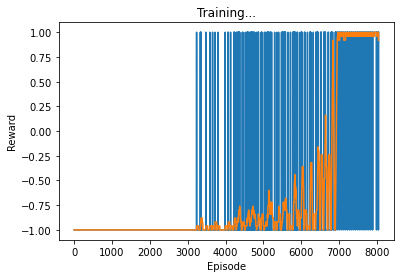

In [95]:
ep2_rewards = []
policy_net.train()
dqnloc_count = [0 for i in range(len(em2.env.tx_locs))]
loc2_errors = [np.abs(20*np.log10(np.abs(x))-20*np.log10(np.abs(y))) for x,y in zip(loc_SNRexh,loc_minSNRexh)]
iter2_avg_error = []
iter2_errors = []

dqn2_epslen=[]
outer = tqdm.notebook.tqdm(total=episodes, desc='training loop: ', position=0)

train_steps = 0
for episode in range(episodes):
    
    #if ((episode+1) > 4100):    
    #    obs = em.test_reset(np.array([[-100,-100,0]]), test_txbdir, em.env.sc_xyz, ch_randvals[episode*(em.env.goal_steps+1)])
    #    test_txbdir = (test_txbdir + 1) % em.env.N_tx
    #else:
    #    #tx_loc_xndx, tx_loc_yndx, tx_dir_ndx =em.env.obs_space.sample()
    tx_num = obs_list[episode]
    
    #policy_net.eval()
    #with torch.no_grad():
    #    action_probs = policy_net(obs).detach().data.cpu().numpy()[0]  
    #policy_net.train()
    #actions= np.argsort(action_probs)[::-1]
    
    obs = em2.reset(tx_num, ch_randvals[episode], dqnloc_count[tx_num]+1)
    tx_num = em2.env.get_txloc_ndx(em2.env.tx_loc)
    dqnloc_count[tx_num] +=1
    #obs = em.test_reset(np.array([[em.env.rx_xcov[tx_loc_xndx],em.env.rx_ycov[tx_loc_yndx], 0]]), tx_dir_ndx, em.env.sc_xyz, ch_randvals[episode*(em.env.goal_steps+1)])
    #dqnloc_maxexhselections[(tx_loc_xndx*len(em.env.rx_ycov)+tx_loc_yndx)*available_actions+tx_dir_ndx]+=1
    
    ep_loss = 0.0
    ep_rwd = 0.0
    timestep = 0
    tx_dirs = [-1.0 for x in range(em2.env.action_space.n)]
    rx_dirs = [-1.0 for x in range(em2.env.action_space.n)]
    data_rates =[np.inf for x in range(em2.env.action_space.n)]
    rssi_vals =[np.complex(0,0) for x in range(em2.env.action_space.n)]
    rwd_vals =[-2.0 for x in range(em2.env.action_space.n)]
    #agent.current_step +=1
    train_steps +=1
    eps = strategy.get_exploration_rate(train_steps)
    done = False
    
    if (episode < len(em2.env.tx_locs)):
        action_list = list(range(em2.env.action_space.n))
        random_actions = random.sample(action_list,len(action_list))
        
    while True:
        #tx_dirs.append(em2.env.tx_bdir*180/np.pi)
        #rx_dirs.append(em.env.rx_bdir[0]*180/np.pi)
        #data_rates.append(em.env.rate)
        #print(em.env.rbdir_ndx)
        if (eps == 1.0):
            action = torch.tensor(np.array([random_actions[em2.env.rbdir_count]]), dtype=torch.long).to(device)
        else:
            action = agent.act(obs, policy_net, eps)
        next_obs, reward, done, _ = em2.step(action)#,ch_randvals[episode*(em.env.goal_steps+1)+timestep+1])
        #agent.step(obs, action, reward, next_obs, done)
        tx_dirs[em2.env.txdir_ndx] = em2.env.tx_bdir*180/np.pi
        rx_dirs[em2.env.rbdir_ndx] = em2.env.rx_bdir*180/np.pi
        data_rates[em2.env.txdir_ndx*em2.env.N_rx+em2.env.rbdir_ndx] = em2.env.rate
        rssi_vals[em2.env.txdir_ndx*em2.env.N_rx+em2.env.rbdir_ndx] = em2.env.rssi_val

        rwd_vals[em2.env.txdir_ndx*em2.env.N_rx+em2.env.rbdir_ndx] = reward.item()
        ep_rwd += reward.item()
        
        '''
        if(np.all(em.env.tx_loc == np.array([[100,100,0]]))):
            print("ch_model: {}, sc_xyz: {}, min_exh_rate: {}, max_exh_rate: {}, min_action_ndx: {}, max_action_ndx: {}".format(em.env.ch_model, em.env.sc_xyz, min_exh_rate, max_exh_rate, min_action_ndx, max_action_ndx))
        '''   
        memory.add(obs, action, reward, next_obs, done)
        obs = next_obs
        
        ep2_rewards.append(reward.item())
        exh_rssi = loc_SNRexh[tx_num]
        if data_rates[em2.env.txdir_ndx*em2.env.N_rx+em2.env.rbdir_ndx] == np.inf:
            #dqn_rate = 0.0
            dqn_rssi = loc_minSNRexh[tx_num]#np.complex(1,0)
        else:
            dqn_rate = data_rates[em2.env.txdir_ndx*em2.env.N_rx+em2.env.rbdir_ndx]#max(data_rates)
            dqn_rssi = rssi_vals[em2.env.txdir_ndx*em2.env.N_rx+em2.env.rbdir_ndx]
        #SNR_exh = Es * loc_SNRexh[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx]#np.abs(max_rssi_val) ** 2 / (em.env.N0 * em.env.B)
        #error = exh_rate-dqn_rate#np.abs(20*np.log10(np.abs(max_rssi_val))-20*np.log10(np.abs(rssi_val)))#max_exh_rate - dqn_rate
        error = np.abs(20*np.log10(np.abs(exh_rssi))-20*np.log10(np.abs(dqn_rssi)))
        iter2_errors.append(error)
        loc2_errors[tx_num] = error
        iter2_avg_error.append(np.mean(loc2_errors))

        #print("exh_rate: {}, dqn_rate: {}, error: {}, iter_avg_error: {}".format(np.abs(exh_rssi), np.abs(dqn_rssi), error, np.mean(loc2_errors)))
        print("best_rate: {}, cur_rate: {}, error: {}, action: {}, iter_avg_error: {}".format(em2.env.best_rate, em2.env.rate, error, action.item(),np.mean(loc2_errors)))
        
        if memory.can_provide_sample():
            experiences = memory.sample()
            observations, actions, rewards, next_observations, dones = experiences
            weights, batch_indices = torch.tensor(np.ones_like(rewards.cpu().data.numpy())).to(device), None

            #print(states.shape, states.dtype)
            #print(actions.unsqueeze(-1).shape)
            current_q_values = policy_net(observations).gather(1,index=actions.unsqueeze(-1))#(1-ALPHA)*
            
            next_q_values = target_net(next_observations).detach().max(1)[0]
            target_q_values = ((next_q_values*GAMMA) + rewards)
            #print(policy_net(observations).type())
            #print(target_q_values.unsqueeze(1).type())
            #loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1).float())
            td_errors = ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values)
            #loss = F.mse_loss(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values),  reduction='sum')
            #weighted_loss = torch.mean(weights*loss)
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1).float(),  reduction='sum')
            #print("loss: ", loss)
            #loss = ALPHA*loss
            #ep_loss += weighted_loss.item()
            #ep_loss = torch.mean(loss).detach().numpy()
            ep_loss = loss.item()
            
            optimizer.zero_grad()
            #weighted_loss.backward()
            #ep_loss.backward(torch.ones_like(ep_loss))
            loss.backward(torch.ones_like(loss))
            optimizer.step()
            
        timestep +=1
        if done:
            dqn2_epslen.append(em2.env.rbdir_count)
            #data_rates.append(em.env.rate)
            #data_rates[em2.env.rbdir_ndx] = em2.env.rate
            #rssi_vals[em2.env.rbdir_ndx] = em2.env.rssi_val
            #ep_rewards.append(ep_rwd)
            moving_avg_rwd = get_moving_average(len(em2.env.tx_locs), ep2_rewards)
            
            #print('\rEpisode {},\tScore: {:.2f}, eps: {}, moving avg_rwd: {}, ep_loss: {}'.format(episode+1, ep_rwd, eps, moving_avg_rwd[-1], ep_loss), end="\r")
            print('Episode {},\t Score: {:.2f}, eps: {}, moving avg_rwd: {}, ep_loss: {}'.format(episode+1, ep_rwd, eps, moving_avg_rwd[-1], ep_loss))
            #plot(episode_rewards, 100)
            #min_exh_rate, max_exh_rate,min_action_ndx,max_action_ndx= em.env.get_minmax_exhrate(ch_randvals[episode*(em.env.goal_steps+1):(episode+1)*(em.env.goal_steps+1)])
            
            #if(((episode+1) >= 6000) or (3000 <= (episode+1)<=3500)):
            #if((episode+1) > 4100):
                
            #    test_data_rates.append(np.mean(data_rates[1:]))
            #    test_eps_iters.append(timestep)
            #    test_minexh_rates.append(min_exh_rate)
            #    test_maxexh_rates.append(max_exh_rate)
                
                #if (timestep > 3):
                #    if(timestep >=8):
                #        false_positives +=1
                #if (min_exh_rate == max_exh_rate):
             #   print("\ntest_eps: {0}, eps_rwd: {1}".format(episode+1, ep_rwd))
            #print("TX loc: {}".format(em2.env.tx_loc))
             #   print("SC_xyz: {}".format(em.env.sc_xyz))
 
            tx_num = em2.env.get_txloc_ndx(em2.env.tx_loc)
            exh_action_ndx = loc_exhbdir[tx_num]
            #print("TX dirs: {}, episode length: {}".format(tx_dirs, len(tx_dirs)))
            #print("RX dirs: {}".format(rx_dirs))
            best_action_ndx = em2.env.txdir_ndx*em2.env.N_rx+em2.env.rbdir_ndx#data_rates.index(max(data_rates))
            print("dqn action ndx: {}, exh action ndx: {}".format(best_action_ndx, exh_action_ndx))
            #print("dqn rx bdir: {}, exh bdir: {}".format(rx_dirs[best_action_ndx], em2.env.BeamSet[exh_bdir_ndx]*180/np.pi))
            #print("data rates: ", data_rates)
            #print("rwd vals: ", rwd_vals)
 
            print("\n\n")
                            
            timestep = 0
            break
            
    #for local_param, target_param in zip(policy_net.parameters(), target_net.parameters()):
    #    target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)
    
    #Update the policy network
    if episode % UPDATE_EVERY == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    # update tqdm bar
    outer.update(1)
    
#torch.save(policy_net.state_dict(), 'checkpoint.pth')

#timer.finish()
test_rewards = []
plot(ep2_rewards,len(em2.env.tx_locs), test_rewards)


In [96]:
print("Average episode length: {}".format(np.mean(dqn2_epslen)))
print(len(iter2_avg_error))

Average episode length: 5.362666666666667
8044


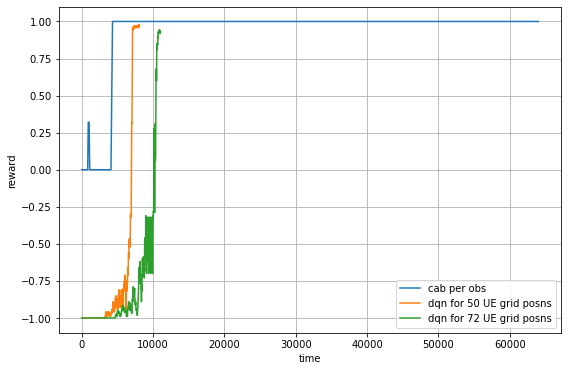

In [97]:
##### from Source.misc_fun.utils import *
fig = plt.figure(figsize=[9, 6])

#loc_ndx = 0
#tbdir_ndx = 3
context_ndx = 0#*len(tx_dirs)+ 4#tbdir_ndx
#context_ndx2 = sel_ctxt_ndices[1]#1*len(tx_dirs)+ 4#tbdir_ndx
#context_ndx3 = sel_ctxt_ndices[2]#2*len(tx_dirs)+ 3#tbdir_ndx
#context_ndx4 = sel_ctxt_ndices[3]#3*len(tx_dirs)+ 3#tbdir_ndx
moving_avg_period = 200
cab_movingavg = get_moving_average(moving_avg_period, train_datarates[0])

#em.env.obs_space.nvec[3]*len(em.env.tx_locs)
dqn2_movingavg = get_moving_average(200, ep2_rewards)

dqn1_movingavg = get_moving_average(200, ep_rewards)

plt.plot(np.arange(1,len(train_datarates[0])+1,1), cab_movingavg, np.arange(1,len(ep2_rewards)+1,1), dqn2_movingavg, np.arange(1,len(ep_rewards)+1,1), dqn1_movingavg)
#min_ndx=0
#max_ndx=500
#plt.plot(test_eps_iters[min_ndx:max_ndx])
plt.grid()
plt.legend(['cab per obs', 'dqn for {} UE grid posns'.format(len(em2.env.tx_locs)), 'dqn for {} UE grid posns'.format(len(em.env.tx_locs))])
plt.xlabel('time')
plt.ylabel('reward')
#plt.savefig("121020_cab_dqn_rwdplot_13.pdf")
plt.show()
#plt.savefig("071020_cab_dqn_rwdplot_2.pdf")

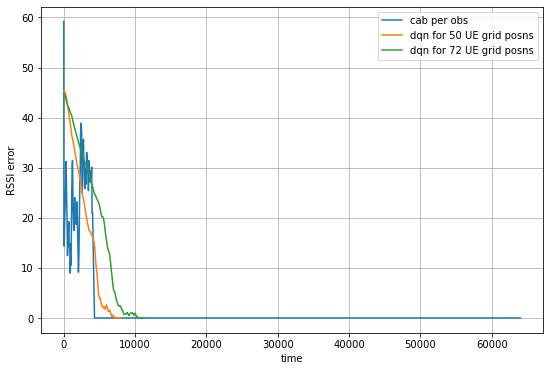

In [98]:
from Source.misc_fun.utils import *
fig = plt.figure(figsize=[9, 6])

#loc_ndx = 0
#tbdir_ndx = 3
context_ndx = 0#0*len(tx_dirs)+ 4#tbdir_ndx
#context_ndx2 = sel_ctxt_ndices[1]#1*len(tx_dirs)+ 4#tbdir_ndx
#context_ndx3 = sel_ctxt_ndices[2]#2*len(tx_dirs)+ 3#tbdir_ndx
#context_ndx4 = sel_ctxt_ndices[3]#3*len(tx_dirs)+ 3#tbdir_ndx
moving_avg_period = 200
#plt.plot(np.arange(1,len(cabenv_avgerrors[context_ndx])+1), cabenv_avgerrors[7], np.arange(1,len(iter_avg_error)+1),iter_avg_error)
cab_movingavg = get_moving_average(moving_avg_period, cabenv_avgerrors)

dqn2_movingavg = get_moving_average(moving_avg_period, iter2_avg_error)

dqn1_movingavg = get_moving_average(moving_avg_period, iter_avg_error)

plt.plot(np.arange(1,len(cabenv_avgerrors)+1,1), cab_movingavg, np.arange(1,len(iter2_avg_error)+1,1), dqn2_movingavg, np.arange(1,len(iter_avg_error)+1,1), dqn1_movingavg)
#min_ndx=0
#max_ndx=500
#plt.plot(test_eps_iters[min_ndx:max_ndx])
plt.grid()
plt.legend(['cab per obs', 'dqn for 50 UE grid posns', 'dqn for 72 UE grid posns'])
plt.xlabel('time')
plt.ylabel('RSSI error')
#plt.savefig("121020_cab_dqn_erroplot_13.pdf")
plt.show()
#plt.savefig("071020_cab_dqn_erroplot_2.pdf")

### Simulation 3: Beam Alignment for CAB vs DQN without channel variation with 32 TX locations

In [99]:
#Assume LOS or NLOS throughout the environment. Do not change in between for now
from Source.nn_model_dqn import QNetwork
from Source.dqn_rcv_agent import Agent, DQN_ReplayBuffer, EpsilonGreedyStrategy
from Source.env_manager import EnvManager
from Source.misc_fun.utils import plot, get_moving_average, Generate_BeamDir, All_Exhaustive_RateMeas
from Source.PER import PrioritizedReplayBuffer

#Hyper-parameters
BUFFER_SIZE = int(1e5)      #replay buffer size
BATCH_SIZE = 64             #minibatch size
GAMMA = 0.999                #discount factor
ALPHA = 1.0                  #non-stationarity parameter
TAU = 1e-3                  #for soft update of target parameters
LR = 7e-4                   #learning rate
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.986 #125e-6
episodes = 1500 #3100 train, 500 test
UPDATE_EVERY = 50

test_episodes = 20
seed = 0                    #random seed number
episode_step_limit = 50
#%%
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Choose the environment
em3 = EnvManager(device, 'combrf-v7', seed)
em3.env.ant_arr = 'ula'
rx_xcov = np.array([-40,-20,20,40])
rx_ycov = np.array([-40,-20,20,40])
rx_zcov = np.array([41.5, 81.5])
beam_param = 'beam-narrow'
beam_paramvals = np.array([])
em3.env.set_beamparameters(beam_param, beam_paramvals)
em3.env.set_coverage(rx_xcov,rx_ycov,rx_zcov)

available_actions = em3.num_actions_available()
random.seed(seed)
state_size = em3.state_size()
print(em3.env.ch_model)
print(em3.env.sc_xyz)

#Select the strategy
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, len(em3.env.tx_locs),350)#episodes
#Initialize the agent
agent = Agent(strategy, state_size, available_actions, seed, device)

#Instantiate MemoryBuffer
#if not PRIORITIZED_REPLAY:
memory = DQN_ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, seed, device)
#else:
#    memory = PrioritizedReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, PER_ALPHA,seed, device)

policy_net = QNetwork(state_size, available_actions, seed).to(device)
target_net = QNetwork(state_size, available_actions, seed).to(device)
print(policy_net)

#Initialize target_net weights to policy_net weights
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() #Set the target_net in eval mode

#Select the optimizer
#optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)
optimizer = optim.SGD(params=policy_net.parameters(), lr=LR, momentum=0.01)

uma-los
[[  0.   20.   21.5]
 [ 20.    0.   21.5]
 [-20.    0.   21.5]
 [  0.  -20.   21.5]]
QNetwork(
  (fc11): Linear(in_features=32, out_features=200, bias=True)
  (fc12): Linear(in_features=3, out_features=32, bias=True)
  (fc22): Linear(in_features=32, out_features=200, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=256, bias=True)
  )
  (softmax): Softmax(dim=1)
  (output): Linear(in_features=256, out_features=64, bias=True)
)


In [100]:
from Source.misc_fun.conversion import *

#loc_SNRexh = [0.0 for i in range(em.env.obs_space.nvec[3] * len(em.env.tx_locs)) ]
loc_SNRexh = [0.0 for i in range(len(em3.env.tx_locs)) ]
loc_minSNRexh = [0.0 for i in range(len(em3.env.tx_locs)) ]
loc_exhbdir = [0 for i in range(len(em3.env.tx_locs)) ]
for loc_ndx in range(len(em3.env.tx_locs)):
    #for tbdir_ndx in range(em.env.obs_space.nvec[3]):
    min_exh_rate, max_exh_rate,min_action_ndx,max_action_ndx,min_rssi_val,max_rssi_val = em3.env.get_minmax_exhrate(loc_ndx, ch_randvals[loc_ndx])
    #tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
    #Es = db2lin(em.env.P_tx)
    #SNR_exh = Es * np.abs(max_rssi_val) ** 2 / (em.env.N0 * em.env.B)
    #SNR_exh = Es * np.abs(max_rssi_val) ** 2 / (em.env.N0 * em.env.B)
    #exh_rate = np.log2(1 + SNR_exh)
    loc_minSNRexh[loc_ndx] = min_rssi_val#max_exh_rate#
    loc_SNRexh[loc_ndx] = max_rssi_val#max_exh_rate#
    loc_exhbdir[loc_ndx] = max_action_ndx

tx-loc: [[-40.  -40.   41.5]], sc-xyz: [[  0.   20.   21.5]
 [ 20.    0.   21.5]
 [-20.    0.   21.5]
 [  0.  -20.   21.5]], init ch-model: uma-los
txdir_ndx: 0, rxdir_ndx: 0, rate: 18.88342765870174,rssival:(7.606941532537028e-06,-7.592549742902074e-06)
txdir_ndx: 0, rxdir_ndx: 1, rate: 14.027552685136978,rssival:(-1.297671500801055e-06,-1.5181640562842837e-06)
txdir_ndx: 0, rxdir_ndx: 2, rate: 17.164017724713542,rssival:(-3.113242654822508e-06,-5.0384055420396825e-06)
txdir_ndx: 0, rxdir_ndx: 3, rate: 21.47259480997627,rssival:(6.423511317093424e-06,-2.5570232655940707e-05)
txdir_ndx: 0, rxdir_ndx: 4, rate: 17.280283244482096,rssival:(5.308473674098846e-06,-3.1371735920757965e-06)
txdir_ndx: 0, rxdir_ndx: 5, rate: 16.20754333890444,rssival:(4.204420691157604e-06,-6.315391122475732e-07)
txdir_ndx: 0, rxdir_ndx: 6, rate: 18.49992690879444,rssival:(-3.8330017950859444e-06,-8.594007310495846e-06)
txdir_ndx: 0, rxdir_ndx: 7, rate: 19.041355873652677,rssival:(2.1037796268818037e-06,-1.1155

txdir_ndx: 2, rxdir_ndx: 2, rate: 19.46637791507072,rssival:(-8.545086133956216e-06,-1.0000433750442597e-05)
txdir_ndx: 2, rxdir_ndx: 3, rate: 20.813694611482745,rssival:(-9.714930147379143e-06,1.859753086392876e-05)
txdir_ndx: 2, rxdir_ndx: 4, rate: 26.29907873065871,rssival:(-0.00013842651702858784,2.367778236781223e-05)
txdir_ndx: 2, rxdir_ndx: 5, rate: 20.564517201839454,rssival:(-1.839370035743952e-05,-5.664439417070366e-06)
txdir_ndx: 2, rxdir_ndx: 6, rate: 18.124632070912792,rssival:(-6.673558263626435e-06,-4.871357227324523e-06)
txdir_ndx: 2, rxdir_ndx: 7, rate: 21.19874598839411,rssival:(-1.8941241978907344e-05,-1.4702111660916708e-05)


txdir_ndx: 3, rxdir_ndx: 0, rate: 21.71425034011833,rssival:(-5.444957672885889e-06,-2.8146065753781622e-05)
txdir_ndx: 3, rxdir_ndx: 1, rate: 17.834967321127746,rssival:(-7.21944548401874e-06,-1.9307645251303784e-06)
txdir_ndx: 3, rxdir_ndx: 2, rate: 17.446334656724783,rssival:(-5.6350006724460435e-06,-3.3025100002706135e-06)
txdir_ndx: 3, rx

txdir_ndx: 3, rxdir_ndx: 4, rate: 16.374437249679485,rssival:(-3.562648204240882e-06,-2.7568789565298387e-06)
txdir_ndx: 3, rxdir_ndx: 5, rate: 17.570289701139952,rssival:(-6.312618751795716e-06,-2.576437423733929e-06)
txdir_ndx: 3, rxdir_ndx: 6, rate: 21.763813581072597,rssival:(-2.7471120376504834e-05,9.793417308080726e-06)
txdir_ndx: 3, rxdir_ndx: 7, rate: 22.565796123974685,rssival:(-3.515647773117533e-05,-1.571601670042362e-05)


txdir_ndx: 4, rxdir_ndx: 0, rate: 20.03882067389971,rssival:(-1.1182383097724199e-05,1.1500114200227313e-05)
txdir_ndx: 4, rxdir_ndx: 1, rate: 21.05174352081993,rssival:(-4.393430435332952e-06,2.2358998659353236e-05)
txdir_ndx: 4, rxdir_ndx: 2, rate: 25.217649161469172,rssival:(-6.077830350364692e-05,7.500724476896594e-05)
txdir_ndx: 4, rxdir_ndx: 3, rate: 24.1331938569979,rssival:(-6.555797334205849e-05,9.860473449604764e-06)
txdir_ndx: 4, rxdir_ndx: 4, rate: 20.51973806577378,rssival:(-9.694374950709592e-06,-1.6282280528625195e-05)
txdir_ndx: 4, rxdir_n

txdir_ndx: 3, rxdir_ndx: 4, rate: 15.15711119109857,rssival:(-1.4243252956086504e-06,-2.5881826429471615e-06)
txdir_ndx: 3, rxdir_ndx: 5, rate: 15.50496605743114,rssival:(-3.9905115057203645e-07,-3.308759005232545e-06)
txdir_ndx: 3, rxdir_ndx: 6, rate: 18.009189206270065,rssival:(-6.201293992687475e-06,-4.955871948560328e-06)
txdir_ndx: 3, rxdir_ndx: 7, rate: 18.238838769382955,rssival:(-3.9723137949107475e-07,-8.586763215267597e-06)


txdir_ndx: 4, rxdir_ndx: 0, rate: 21.712803526533097,rssival:(2.8718249145411555e-06,-2.850925150319488e-05)
txdir_ndx: 4, rxdir_ndx: 1, rate: 20.893039226070808,rssival:(-1.8649858019480393e-05,-1.0831507761020894e-05)
txdir_ndx: 4, rxdir_ndx: 2, rate: 18.686881380818342,rssival:(-3.83025023796094e-06,-9.280599852840789e-06)
txdir_ndx: 4, rxdir_ndx: 3, rate: 20.030594597053568,rssival:(9.872025122760898e-06,-1.2584853077029364e-05)
txdir_ndx: 4, rxdir_ndx: 4, rate: 15.259066102997828,rssival:(-2.987265593432678e-06,-6.653812498144024e-07)
txdir_ndx: 4, 

In [101]:
print(np.mean([np.abs(20*np.log10(np.abs(x))-20*np.log10(np.abs(y))) for x,y in zip(loc_SNRexh, loc_minSNRexh)]))
print(len(em3.env.tx_locs))

48.03825751832251
32


In [102]:
locndx_list = list(range(len(em3.env.tx_locs)))
random_loc_ndices = random.sample(locndx_list, len(locndx_list))
#txdir_list = list(range(em.env.obs_space.nvec[3]))
#txdir_ndices = random.sample(txdir_list, len(txdir_list))

obs_list = []
for eps in range(episodes):
    ndx = eps % (len(em3.env.tx_locs))
    #ndx = eps % (em.env.obs_space.nvec[3] * len(em.env.tx_locs))
    #ndx1 = int(ndx / em.env.obs_space.nvec[3])    
    #ndx2 = int(ndx % em.env.obs_space.nvec[3])
    obs_list.append((random_loc_ndices[ndx]))

In [103]:
action_list = list(range(em3.env.action_space.n))
random_actions = random.sample(action_list,len(action_list))
print(random_actions)

[55, 20, 39, 40, 58, 13, 35, 30, 28, 33, 16, 3, 51, 57, 0, 5, 46, 25, 45, 42, 60, 49, 61, 31, 21, 15, 62, 4, 12, 14, 38, 9, 63, 2, 56, 10, 53, 54, 52, 32, 17, 24, 47, 23, 43, 37, 6, 22, 34, 1, 27, 50, 18, 48, 59, 41, 36, 26, 11, 19, 44, 29, 7, 8]


init rate: -inf, init tx action: -1, init rx action: -1
best_rate: inf, cur_rate: 15.212239892562545, error: 31.689823791045754, action: 8, iter_avg_error: 47.32613717803356
best_rate: inf, cur_rate: 16.11978312827035, error: 28.957793010419195, action: 5, iter_avg_error: 47.24076121613898
best_rate: inf, cur_rate: 21.65609507459194, error: 12.291773723965306, action: 43, iter_avg_error: 46.7199481134373
best_rate: inf, cur_rate: 18.499926908794436, error: 21.79279701770895, action: 48, iter_avg_error: 47.016855091366786
best_rate: inf, cur_rate: 18.85041922512305, error: 20.737707486269997, action: 63, iter_avg_error: 46.98388354350932
best_rate: inf, cur_rate: 15.946363551002543, error: 29.47984574639142, action: 56, iter_avg_error: 47.25707536413812
best_rate: inf, cur_rate: 20.36749887011896, error: 16.170836718630213, action: 9, iter_avg_error: 46.84116883202057
best_rate: inf, cur_rate: 16.551910962300813, error: 27.65694282446414, action: 2, iter_avg_error: 47.20010964782789
bes

best_rate: inf, cur_rate: 14.983760215969305, error: 20.937573844387998, action: 11, iter_avg_error: 46.86573831842015
best_rate: inf, cur_rate: 15.793206164398592, error: 18.500841184393522, action: 45, iter_avg_error: 46.78959042279532
best_rate: inf, cur_rate: 15.45288881653979, error: 19.525318829021728, action: 7, iter_avg_error: 46.82160534918995
best_rate: inf, cur_rate: 15.549365084484853, error: 19.234890060320097, action: 30, iter_avg_error: 46.81252945016803
best_rate: inf, cur_rate: 10.837605522341974, error: 33.420982979706125, action: 13, iter_avg_error: 47.255844853898836
best_rate: inf, cur_rate: 20.750183287035036, error: 3.5787791474261326, action: 46, iter_avg_error: 46.32327598414009
best_rate: inf, cur_rate: 17.280354499563195, error: 14.024029415788462, action: 51, iter_avg_error: 46.64969005502641
best_rate: inf, cur_rate: 16.23973697749542, error: 17.1566291378481, action: 3, iter_avg_error: 46.74758379634078
best_rate: inf, cur_rate: 18.86930385968351, error: 9

best_rate: inf, cur_rate: 14.718239365606836, error: 30.987106282517175, action: 37, iter_avg_error: 46.28088547050845
best_rate: inf, cur_rate: 24.78907736890898, error: 0.670702103433257, action: 40, iter_avg_error: 45.33349783991208
best_rate: inf, cur_rate: 24.580831431231346, error: 1.2975848638569119, action: 49, iter_avg_error: 45.35308792617532
best_rate: inf, cur_rate: 20.70166102013068, error: 12.975053757739971, action: 54, iter_avg_error: 45.718008829109166
best_rate: inf, cur_rate: 15.04189851726563, error: 30.01276277241749, action: 19, iter_avg_error: 46.250437235817834
best_rate: inf, cur_rate: 19.506760967425823, error: 16.572064617914705, action: 24, iter_avg_error: 45.83041541848962
best_rate: inf, cur_rate: 15.039028787266066, error: 30.021401776860586, action: 26, iter_avg_error: 46.250707204706686
best_rate: inf, cur_rate: 18.67981062725983, error: 19.06143770304314, action: 60, iter_avg_error: 45.90820832739989
best_rate: inf, cur_rate: 16.641295437589278, error:

best_rate: inf, cur_rate: 13.29460086203843, error: 35.89238391478, action: 1, iter_avg_error: 45.803037160090966
best_rate: inf, cur_rate: 11.592866938164244, error: 41.01608744689284, action: 42, iter_avg_error: 45.96315289546949
best_rate: inf, cur_rate: 18.173465216544226, error: 21.205121202837503, action: 29, iter_avg_error: 45.34406020034277
best_rate: inf, cur_rate: 19.754957883912056, error: 16.44434411317151, action: 14, iter_avg_error: 45.1952859162907
best_rate: inf, cur_rate: 14.111716144788385, error: 33.432434895032955, action: 34, iter_avg_error: 45.72616375322387
best_rate: inf, cur_rate: 21.335492767015126, error: 11.68645675578719, action: 28, iter_avg_error: 45.04660193637244
best_rate: inf, cur_rate: 19.088070934081337, error: 18.45187675378685, action: 3, iter_avg_error: 45.25802131130993
best_rate: inf, cur_rate: 19.097024687133295, error: 18.424923223147275, action: 60, iter_avg_error: 45.25717901347745
best_rate: inf, cur_rate: 20.290649393725054, error: 14.831

best_rate: inf, cur_rate: 18.037776978824052, error: 11.743949415905718, action: 16, iter_avg_error: 45.108563522435105
best_rate: inf, cur_rate: 16.028259708160597, error: 17.793248012905906, action: 31, iter_avg_error: 45.29760410359136
best_rate: inf, cur_rate: 14.983760215969298, error: 20.937573844388012, action: 43, iter_avg_error: 45.395864285825176
best_rate: inf, cur_rate: 15.447181346993801, error: 19.542500408178938, action: 27, iter_avg_error: 45.352268240943644
best_rate: inf, cur_rate: 19.54605997274112, error: 7.203554719124398, action: 12, iter_avg_error: 44.96667618816069
best_rate: inf, cur_rate: 10.837605522341995, error: 33.420982979706054, action: 41, iter_avg_error: 45.78597082130386
best_rate: inf, cur_rate: 21.785643677397506, error: 0.4617315181275501, action: 22, iter_avg_error: 44.75599421312954
best_rate: inf, cur_rate: 15.018960820967934, error: 20.831606233780178, action: 59, iter_avg_error: 45.39255279799369
best_rate: inf, cur_rate: 17.2803544995632, err

best_rate: inf, cur_rate: 11.249182721553646, error: 45.30648581497368, action: 34, iter_avg_error: 45.708571735359165
best_rate: inf, cur_rate: 21.505811446064328, error: 14.42917370482408, action: 8, iter_avg_error: 44.74365573191699
best_rate: inf, cur_rate: 15.133954912730763, error: 33.610492478212876, action: 45, iter_avg_error: 45.343071943585386
best_rate: inf, cur_rate: 12.689979335453334, error: 40.96812855022631, action: 1, iter_avg_error: 45.57299807083581
best_rate: inf, cur_rate: 20.57368328024392, error: 17.235160406373723, action: 17, iter_avg_error: 44.83134281634042
best_rate: inf, cur_rate: 17.66506290020032, error: 25.990998323861533, action: 9, iter_avg_error: 45.10496275126191
best_rate: inf, cur_rate: 15.295994094618138, error: 33.122693103665185, action: 2, iter_avg_error: 45.32782821313077
best_rate: inf, cur_rate: 15.224262978800287, error: 33.33863078171963, action: 49, iter_avg_error: 45.33457626556998
best_rate: inf, cur_rate: 17.97818975367697, error: 25.0

best_rate: inf, cur_rate: 17.446334656724776, error: 26.649439366615454, action: 28, iter_avg_error: 44.233066470911496
best_rate: inf, cur_rate: 17.107053513147257, error: 27.670783825590206, action: 27, iter_avg_error: 44.264983485254454
best_rate: inf, cur_rate: 17.339855506863866, error: 26.969975409478423, action: 15, iter_avg_error: 44.24308322225096
best_rate: inf, cur_rate: 17.97818975367698, error: 25.04838849342481, action: 23, iter_avg_error: 44.18303363112429
best_rate: inf, cur_rate: 15.319935611709479, error: 33.050620179076915, action: 8, iter_avg_error: 44.433103371300916
best_rate: inf, cur_rate: 17.634013387142016, error: 26.084467126280117, action: 19, iter_avg_error: 44.21541108840101
best_rate: inf, cur_rate: 15.238465866523162, error: 33.29587471794265, action: 13, iter_avg_error: 44.440767575640464
best_rate: inf, cur_rate: 17.618908535811833, error: 26.12993748430189, action: 6, iter_avg_error: 44.21683203708919
best_rate: inf, cur_rate: 16.09900821355436, error

best_rate: inf, cur_rate: 15.651782013942485, error: 24.44934822642422, action: 40, iter_avg_error: 43.23364135766508
best_rate: inf, cur_rate: 15.684655202935488, error: 24.350388166534074, action: 46, iter_avg_error: 43.230548855793515
best_rate: inf, cur_rate: 13.761726211392563, error: 30.139211453018646, action: 50, iter_avg_error: 43.41144958349616
best_rate: inf, cur_rate: 13.332711104508919, error: 31.43078390329066, action: 33, iter_avg_error: 43.45181122256716
best_rate: inf, cur_rate: 15.143607724660566, error: 25.979140888530253, action: 37, iter_avg_error: 43.28144737835589
best_rate: inf, cur_rate: 19.073108355922816, error: 14.150053202480137, action: 23, iter_avg_error: 42.911788388166826
best_rate: inf, cur_rate: 18.406408930582053, error: 16.157023079284798, action: 28, iter_avg_error: 42.974506196816975
Episode 8,	 Score: -64.00, eps: 1.0, moving avg_rwd: -1.0, ep_loss: 451.54132080078125
dqn action ndx: 28, exh action ndx: 20



init rate: -inf, init tx action: -1, 

best_rate: inf, cur_rate: 20.32912629541657, error: 17.82635488575842, action: 10, iter_avg_error: 41.681343130212156
best_rate: inf, cur_rate: 14.527121896709362, error: 35.29230912627138, action: 60, iter_avg_error: 42.227154200228185
Episode 9,	 Score: -64.00, eps: 1.0, moving avg_rwd: -1.0, ep_loss: 506.9036865234375
dqn action ndx: 60, exh action ndx: 13



init rate: -inf, init tx action: -1, init rx action: -1
best_rate: inf, cur_rate: 17.886640722515324, error: 17.721686714984628, action: 32, iter_avg_error: 41.37703160933717
best_rate: inf, cur_rate: 15.249630203523749, error: 25.659972923832015, action: 5, iter_avg_error: 41.62510305336365
best_rate: inf, cur_rate: 17.972220575724823, error: 17.46406465441106, action: 22, iter_avg_error: 41.36898091994425
best_rate: inf, cur_rate: 19.15646985426377, error: 13.899109645548023, action: 4, iter_avg_error: 41.25757607591728
best_rate: inf, cur_rate: 17.364582130641132, error: 19.29324748523335, action: 7, iter_avg_error: 41.42614

best_rate: inf, cur_rate: 17.72910404402032, error: 24.11321332795218, action: 44, iter_avg_error: 40.85655147921112
best_rate: inf, cur_rate: 16.83596308528236, error: 26.801852652345275, action: 61, iter_avg_error: 40.94057145809841
best_rate: inf, cur_rate: 15.212239892562522, error: 31.689823791045853, action: 8, iter_avg_error: 41.0933205561828
best_rate: inf, cur_rate: 14.092257300724274, error: 35.06144159173709, action: 26, iter_avg_error: 41.1986836124544
best_rate: inf, cur_rate: 16.949592602627156, error: 26.459790909412547, action: 19, iter_avg_error: 40.92988202863176
best_rate: inf, cur_rate: 20.030594597053568, error: 17.185020481700462, action: 35, iter_avg_error: 40.64004545276576
best_rate: inf, cur_rate: 21.151217587114395, error: 13.811606953266732, action: 57, iter_avg_error: 40.5346262800022
best_rate: inf, cur_rate: 21.638405635835156, error: 12.345024256900544, action: 47, iter_avg_error: 40.48879557074076
best_rate: inf, cur_rate: 20.367498870118958, error: 16.

best_rate: inf, cur_rate: 18.880886991046513, error: 19.075563772010327, action: 38, iter_avg_error: 39.951645910958305
best_rate: inf, cur_rate: 13.968924674063251, error: 33.862305577681, action: 9, iter_avg_error: 40.41373159238552
best_rate: inf, cur_rate: 19.379256410704233, error: 17.57531970181536, action: 27, iter_avg_error: 39.90476328376471
best_rate: inf, cur_rate: 10.909496030366503, error: 43.07409109512244, action: 45, iter_avg_error: 40.70159988980556
best_rate: inf, cur_rate: 16.651661399284716, error: 25.786234660717398, action: 48, iter_avg_error: 40.161354376230406
best_rate: inf, cur_rate: 22.383898111008186, error: 8.530441346548656, action: 30, iter_avg_error: 39.62211083516263
best_rate: inf, cur_rate: 16.802397685546243, error: 25.332469039758593, action: 5, iter_avg_error: 40.147174200575435
best_rate: inf, cur_rate: 12.783142486228316, error: 37.432210971448484, action: 43, iter_avg_error: 40.52529113594075
best_rate: inf, cur_rate: 22.565796123974685, error: 

best_rate: inf, cur_rate: 16.915897108976168, error: 28.101230383951503, action: 52, iter_avg_error: 38.7535915565241
best_rate: inf, cur_rate: 22.632482080237487, error: 10.892560437597567, action: 35, iter_avg_error: 38.21582062070053
best_rate: inf, cur_rate: 18.011440181013473, error: 24.8032984347347, action: 19, iter_avg_error: 38.65053118311107
best_rate: inf, cur_rate: 19.473540263125507, error: 20.401928150498932, action: 22, iter_avg_error: 38.5129883617287
best_rate: inf, cur_rate: 23.285170061025287, error: 8.927773594270462, action: 30, iter_avg_error: 38.15442103184657
best_rate: inf, cur_rate: 18.153855049225506, error: 24.3745854181483, action: 26, iter_avg_error: 38.63713390134275
best_rate: inf, cur_rate: 13.469768299177323, error: 38.475459491502534, action: 13, iter_avg_error: 39.07778621613507
best_rate: inf, cur_rate: 16.627478767092295, error: 28.969463878834503, action: 39, iter_avg_error: 38.78072385323919
best_rate: inf, cur_rate: 24.117183324258516, error: 6.

best_rate: inf, cur_rate: 14.135939807678213, error: 34.929936726577765, action: 50, iter_avg_error: 37.68007653313697
best_rate: inf, cur_rate: 18.238838769382976, error: 22.5787529565619, action: 31, iter_avg_error: 37.29410204032398
best_rate: inf, cur_rate: 14.74259627533982, error: 33.10363597217726, action: 38, iter_avg_error: 37.62300463456196
best_rate: inf, cur_rate: 19.35556849651419, error: 19.217053942113736, action: 14, iter_avg_error: 37.18904894612247
best_rate: inf, cur_rate: 15.946363551002596, error: 29.479845746391234, action: 62, iter_avg_error: 37.509761190006145
best_rate: inf, cur_rate: 17.595325769811907, error: 24.515928003212764, action: 40, iter_avg_error: 37.35463876053181
best_rate: inf, cur_rate: 14.605140924335398, error: 33.51743364652057, action: 42, iter_avg_error: 37.63593581188519
best_rate: inf, cur_rate: 15.259066102997823, error: 31.54885919803833, action: 18, iter_avg_error: 37.57441786037012
best_rate: inf, cur_rate: 16.125698171875896, error: 2

best_rate: inf, cur_rate: 17.39688697592955, error: 13.673229590178991, action: 44, iter_avg_error: 36.55453885103935
best_rate: inf, cur_rate: 14.33368740808134, error: 22.8945642927316, action: 16, iter_avg_error: 36.84270556049412
best_rate: inf, cur_rate: 13.977566758806944, error: 23.966653160924494, action: 53, iter_avg_error: 36.876208337625144
best_rate: inf, cur_rate: 16.02825970816062, error: 17.793248012905906, action: 31, iter_avg_error: 36.68328942674956
best_rate: inf, cur_rate: 14.894143153716255, error: 21.20735667336666, action: 1, iter_avg_error: 36.78998032238896
best_rate: inf, cur_rate: 20.614590661917592, error: 3.9869538635916797, action: 39, iter_avg_error: 36.25184273458349
best_rate: inf, cur_rate: 14.983760215969292, error: 20.937573844388083, action: 11, iter_avg_error: 36.78154960898338
best_rate: inf, cur_rate: 12.026553379875436, error: 29.840560493780842, action: 60, iter_avg_error: 37.059767941776904
best_rate: inf, cur_rate: 14.58803318875302, error: 2

best_rate: inf, cur_rate: 16.16602455238952, error: 26.628736538129573, action: 37, iter_avg_error: 36.21370936982645
best_rate: inf, cur_rate: 16.639593865640435, error: 25.203134327419278, action: 40, iter_avg_error: 36.169159300741754
best_rate: inf, cur_rate: 18.926987624604784, error: 18.317359170247357, action: 46, iter_avg_error: 35.95397882708013
best_rate: inf, cur_rate: 22.874004747198768, error: 6.435645548690474, action: 61, iter_avg_error: 35.582675276406476
best_rate: inf, cur_rate: 20.701661020130672, error: 12.975053757739985, action: 0, iter_avg_error: 35.78703178293927
best_rate: inf, cur_rate: 23.051344277826946, error: 5.901800301981538, action: 3, iter_avg_error: 35.56599261244682
best_rate: inf, cur_rate: 18.958850749507537, error: 18.221441416398207, action: 29, iter_avg_error: 35.95098139727234
best_rate: inf, cur_rate: 18.48971719780422, error: 19.63367740202513, action: 21, iter_avg_error: 35.995113771823185
best_rate: inf, cur_rate: 22.302344899121465, error:

best_rate: inf, cur_rate: 16.451775765903495, error: 29.643384086892823, action: 41, iter_avg_error: 35.91551614845282
best_rate: inf, cur_rate: 21.268319108323837, error: 15.144097139803193, action: 26, iter_avg_error: 35.46241343135627
best_rate: inf, cur_rate: 15.295994094618145, error: 33.12269310366517, action: 52, iter_avg_error: 36.02424455522695
best_rate: inf, cur_rate: 21.158762194733463, error: 15.473896447690848, action: 38, iter_avg_error: 35.47271965972776
best_rate: inf, cur_rate: 15.535659620545786, error: 32.40121145800006, action: 54, iter_avg_error: 36.001698253799916
best_rate: inf, cur_rate: 19.157287764627206, error: 21.49894041068336, action: 44, iter_avg_error: 35.66100228357127
best_rate: inf, cur_rate: 22.322553764927402, error: 11.970533707311574, action: 31, iter_avg_error: 35.363239574090905
best_rate: inf, cur_rate: 17.446334656724783, error: 26.64943936661541, action: 28, iter_avg_error: 35.82195537594415
best_rate: inf, cur_rate: 15.224262978800283, erro

best_rate: inf, cur_rate: 12.057629304071417, error: 38.99719840083651, action: 33, iter_avg_error: 36.047673763228964
best_rate: inf, cur_rate: 18.016850949119583, error: 21.057151226144924, action: 31, iter_avg_error: 35.487047289019856
best_rate: inf, cur_rate: 25.011879777857157, error: 0.0, action: 6, iter_avg_error: 34.82901131320283
best_rate: inf, cur_rate: 11.988137864023058, error: 39.20643876484988, action: 36, iter_avg_error: 36.05421252460438
best_rate: inf, cur_rate: 18.67981062725983, error: 19.06143770304314, action: 58, iter_avg_error: 35.42468124142292
best_rate: inf, cur_rate: 18.958850749507537, error: 18.221441416398207, action: 29, iter_avg_error: 35.39843135746527
best_rate: inf, cur_rate: 15.069011162325008, error: 29.931143181230084, action: 42, iter_avg_error: 35.76435953761626
best_rate: inf, cur_rate: 14.132760086405842, error: 32.74965518225409, action: 32, iter_avg_error: 35.85243803764827
best_rate: inf, cur_rate: 15.563526108522707, error: 28.44246819377

best_rate: inf, cur_rate: 10.731926682482616, error: 39.26205850683027, action: 13, iter_avg_error: 35.620372412135644
best_rate: inf, cur_rate: 15.143607724660546, error: 25.97914088853031, action: 17, iter_avg_error: 35.20528123656377
best_rate: inf, cur_rate: 16.833843520474623, error: 20.890941344036108, action: 47, iter_avg_error: 35.04627500079833
best_rate: inf, cur_rate: 16.388425808028774, error: 22.23179571242605, action: 3, iter_avg_error: 35.08817669981052
best_rate: inf, cur_rate: 10.614925935246715, error: 39.6144817061888, action: 56, iter_avg_error: 35.6313856371156
best_rate: inf, cur_rate: 16.210088771825113, error: 22.76865034621281, action: 28, iter_avg_error: 35.104953407116355
best_rate: inf, cur_rate: 18.31628877067416, error: 16.428312598472942, action: 16, iter_avg_error: 34.90681785249948
best_rate: inf, cur_rate: 19.147183911473494, error: 13.927063166718298, action: 33, iter_avg_error: 34.82865380775715
best_rate: inf, cur_rate: 17.886640722515324, error: 17

best_rate: inf, cur_rate: 17.794905733433872, error: 13.048622475420075, action: 40, iter_avg_error: 33.58664889496535
best_rate: inf, cur_rate: 10.06075089547307, error: 36.33479752852752, action: 5, iter_avg_error: 34.314341865374956
best_rate: inf, cur_rate: 15.36644861440482, error: 20.35909054580523, action: 14, iter_avg_error: 33.81510102216488
Episode 20,	 Score: -64.00, eps: 1.0, moving avg_rwd: -1.0, ep_loss: 1126.7939453125
dqn action ndx: 14, exh action ndx: 32



init rate: -inf, init tx action: -1, init rx action: -1
best_rate: inf, cur_rate: 20.03882067389971, error: 15.58983109206487, action: 32, iter_avg_error: 32.82761455388285
best_rate: inf, cur_rate: 19.91830092006604, error: 15.952632053080748, action: 47, iter_avg_error: 32.8389520839146
best_rate: inf, cur_rate: 17.219182856199865, error: 24.077811124583704, action: 39, iter_avg_error: 33.09286392989907
best_rate: inf, cur_rate: 11.592866938164295, error: 41.016087446892726, action: 12, iter_avg_error: 33.6221850

best_rate: inf, cur_rate: 17.4536665305564, error: 19.025075178989724, action: 48, iter_avg_error: 31.855949449809383
best_rate: inf, cur_rate: 14.90733795047756, error: 26.69040512952472, action: 59, iter_avg_error: 32.0954910107636
best_rate: inf, cur_rate: 18.40640893058208, error: 16.157023079284713, action: 26, iter_avg_error: 31.766322821693603
best_rate: inf, cur_rate: 13.761726211392556, error: 30.13921145301866, action: 4, iter_avg_error: 32.20326620837279
best_rate: inf, cur_rate: 20.526210747109182, error: 9.775774139025557, action: 36, iter_avg_error: 31.566908792310503
best_rate: inf, cur_rate: 16.210088771825117, error: 22.768650346212794, action: 28, iter_avg_error: 31.972936173785104
best_rate: inf, cur_rate: 16.103861476992055, error: 23.08843074463826, action: 15, iter_avg_error: 31.9829293112359
best_rate: inf, cur_rate: 16.833843520474566, error: 20.89094134403628, action: 47, iter_avg_error: 31.914257767467088
best_rate: inf, cur_rate: 11.603538158364586, error: 36

best_rate: inf, cur_rate: 18.39323330641766, error: 19.924123672118938, action: 53, iter_avg_error: 31.254947970884327
best_rate: inf, cur_rate: 20.701661020130683, error: 12.975053757739985, action: 54, iter_avg_error: 31.037789536059982
best_rate: inf, cur_rate: 17.2110046232523, error: 23.483002637055776, action: 1, iter_avg_error: 31.3661629385386
best_rate: inf, cur_rate: 23.139863718245742, error: 5.635330204593501, action: 56, iter_avg_error: 30.808423175024156
best_rate: inf, cur_rate: 18.95885074950754, error: 18.221441416398207, action: 25, iter_avg_error: 31.201739150393053
best_rate: inf, cur_rate: 18.926987624604795, error: 18.317359170247357, action: 8, iter_avg_error: 31.204736580200837
best_rate: inf, cur_rate: 25.01187977785716, error: 0.0, action: 48, iter_avg_error: 30.63231910613061
best_rate: inf, cur_rate: 24.789077368908966, error: 0.6707021034332996, action: 40, iter_avg_error: 30.6532785468629
best_rate: inf, cur_rate: 16.1660245523895, error: 26.62873653812964

best_rate: inf, cur_rate: 11.704762083843868, error: 43.93457197893322, action: 5, iter_avg_error: 30.80897028055129
best_rate: inf, cur_rate: 20.424662654274567, error: 17.683757493087, action: 60, iter_avg_error: 29.988632327868594
best_rate: inf, cur_rate: 15.847849507577074, error: 31.461408463823275, action: 57, iter_avg_error: 30.419183920704103
best_rate: inf, cur_rate: 15.535659620545806, error: 32.401211458000006, action: 0, iter_avg_error: 30.448552764272126
best_rate: inf, cur_rate: 15.63459123145848, error: 32.1033915742953, action: 53, iter_avg_error: 30.439245892906353
best_rate: inf, cur_rate: 15.83864682493212, error: 31.489111770227396, action: 6, iter_avg_error: 30.42004964902923
best_rate: inf, cur_rate: 17.10705351314726, error: 27.670783825590178, action: 27, iter_avg_error: 30.30072690075932
best_rate: inf, cur_rate: 17.641691194897263, error: 26.06135450860205, action: 38, iter_avg_error: 30.25043223460344
best_rate: inf, cur_rate: 18.12463207091277, error: 24.60

best_rate: inf, cur_rate: 24.117183324258516, error: 6.423163917837002, action: 31, iter_avg_error: 28.246116133346508
best_rate: inf, cur_rate: 23.872334820491815, error: 7.160231402254681, action: 30, iter_avg_error: 28.26914949223456
best_rate: inf, cur_rate: 22.46755739257796, error: 11.389033298598804, action: 5, iter_avg_error: 28.401299551495317
best_rate: inf, cur_rate: 16.513128386741073, error: 29.313696362249132, action: 3, iter_avg_error: 28.96144527223439
best_rate: inf, cur_rate: 16.070055091642462, error: 30.647496576429276, action: 34, iter_avg_error: 29.003126528927517
best_rate: inf, cur_rate: 16.601412453069198, error: 29.047932084891585, action: 50, iter_avg_error: 28.953140138566965
best_rate: inf, cur_rate: 22.707135986804435, error: 10.667829752212526, action: 61, iter_avg_error: 28.378761940670746
best_rate: inf, cur_rate: 13.371808583200854, error: 38.77037451828794, action: 52, iter_avg_error: 29.2569664646106
best_rate: inf, cur_rate: 15.479249281506359, erro

best_rate: inf, cur_rate: 15.48709178429857, error: 30.86241730760372, action: 32, iter_avg_error: 27.92270005611672
best_rate: inf, cur_rate: 20.367498870118965, error: 16.170836718630227, action: 45, iter_avg_error: 27.4635881627113
best_rate: inf, cur_rate: 17.164017724713542, error: 25.814302234785046, action: 2, iter_avg_error: 27.76494646009114
best_rate: inf, cur_rate: 21.47259480997627, error: 12.844164740829257, action: 3, iter_avg_error: 27.35962966340502
best_rate: inf, cur_rate: 19.041355873652677, error: 20.16292976244712, action: 7, iter_avg_error: 27.58834107033058
best_rate: inf, cur_rate: 15.628089053214318, error: 30.4379644306765, action: 41, iter_avg_error: 27.909435903712744
best_rate: inf, cur_rate: 15.21223989256251, error: 31.689823791045896, action: 46, iter_avg_error: 27.948556508724288
best_rate: inf, cur_rate: 20.8930392260708, error: 14.588801627763175, action: 21, iter_avg_error: 27.414149566121704
best_rate: inf, cur_rate: 15.50496605743114, error: 30.808

best_rate: inf, cur_rate: 17.794905733433886, error: 13.048622475420046, action: 14, iter_avg_error: 26.68841038667705
best_rate: inf, cur_rate: 22.050550308831742, error: 0.2378376965447444, action: 19, iter_avg_error: 26.288073362337194
best_rate: inf, cur_rate: 16.42584166134534, error: 17.16994622492264, action: 29, iter_avg_error: 26.817201753849005
best_rate: inf, cur_rate: 19.117848451792824, error: 9.066156603606146, action: 5, iter_avg_error: 26.563958328182864
best_rate: inf, cur_rate: 13.353169945021543, error: 26.41997547877277, action: 44, iter_avg_error: 27.106265168031822
best_rate: inf, cur_rate: 19.11622175864689, error: 9.071053446525056, action: 10, iter_avg_error: 26.56411135452408
best_rate: inf, cur_rate: 15.449126285959053, error: 20.110200228579956, action: 47, iter_avg_error: 26.909084691463296
best_rate: inf, cur_rate: 20.797486583397088, error: 4.009936758063148, action: 13, iter_avg_error: 26.405951458009646
best_rate: inf, cur_rate: 16.923943236644327, erro

best_rate: inf, cur_rate: 18.098293735123754, error: 21.43141069582174, action: 19, iter_avg_error: 26.043942659233736
best_rate: inf, cur_rate: 19.071455658187393, error: 18.501893808359142, action: 23, iter_avg_error: 25.95239525650053
best_rate: inf, cur_rate: 19.086925568276342, error: 18.455324654609342, action: 38, iter_avg_error: 25.95093997044585
best_rate: inf, cur_rate: 20.038820673899718, error: 15.589831092064856, action: 32, iter_avg_error: 25.861393296616335
best_rate: inf, cur_rate: 15.450048451092565, error: 29.403504903588285, action: 3, iter_avg_error: 26.29307060322644
best_rate: inf, cur_rate: 21.051743520819926, error: 12.54062745602701, action: 33, iter_avg_error: 25.76610568299015
best_rate: inf, cur_rate: 15.6256346587247, error: 28.87492663251311, action: 44, iter_avg_error: 26.276552532255344
best_rate: inf, cur_rate: 11.822944512196374, error: 40.32327761459629, action: 5, iter_avg_error: 26.634313500445444
best_rate: inf, cur_rate: 13.828208853143812, error:

best_rate: inf, cur_rate: 19.23312447604652, error: 21.125652865706584, action: 46, iter_avg_error: 24.50905988920232
best_rate: inf, cur_rate: 19.37910534858223, error: 20.68620597321994, action: 16, iter_avg_error: 24.495327173812115
best_rate: inf, cur_rate: 24.117183324258516, error: 6.423163917837002, action: 31, iter_avg_error: 24.049607109581395
best_rate: inf, cur_rate: 13.601142600954596, error: 38.07995011473558, action: 60, iter_avg_error: 25.038881678234475
best_rate: inf, cur_rate: 22.41428155119671, error: 11.549409589767961, action: 55, iter_avg_error: 24.209802286829238
best_rate: inf, cur_rate: 13.711514430947041, error: 37.74767205764856, action: 14, iter_avg_error: 25.028497988950505
best_rate: inf, cur_rate: 20.000159363085647, error: 18.816644872275177, action: 27, iter_avg_error: 24.43690338940759
best_rate: inf, cur_rate: 22.707135986804435, error: 10.66782975221254, action: 57, iter_avg_error: 24.182252916905632
best_rate: inf, cur_rate: 19.07197510704834, error

best_rate: inf, cur_rate: 17.79918883254147, error: 13.035729005748067, action: 36, iter_avg_error: 23.46666559365649
best_rate: inf, cur_rate: 16.797785735488116, error: 16.050271783778868, action: 0, iter_avg_error: 23.560870055469955
best_rate: inf, cur_rate: 20.43642782104333, error: 5.096832612359762, action: 42, iter_avg_error: 23.218575081363106
best_rate: inf, cur_rate: 14.142948559785506, error: 24.042329972728936, action: 56, iter_avg_error: 23.810621873874645
best_rate: inf, cur_rate: 16.089103329889234, error: 18.18364257850223, action: 26, iter_avg_error: 23.62753789280506
best_rate: inf, cur_rate: 15.377303483770632, error: 20.326413362387015, action: 22, iter_avg_error: 23.694499479801458
best_rate: inf, cur_rate: 16.432482762346673, error: 17.149954292305637, action: 54, iter_avg_error: 23.595235133861415
best_rate: inf, cur_rate: 15.700542868779685, error: 19.35334537385637, action: 27, iter_avg_error: 23.664091105159876
best_rate: inf, cur_rate: 20.46372110389039, err

best_rate: inf, cur_rate: 9.494261538787068, error: 37.468503420999895, action: 25, iter_avg_error: 23.68746314823854
best_rate: inf, cur_rate: 15.006074323769313, error: 20.870399629395337, action: 46, iter_avg_error: 23.168772404750896
best_rate: inf, cur_rate: 15.546664953910764, error: 19.24301843293233, action: 2, iter_avg_error: 23.11791674236143
best_rate: inf, cur_rate: 13.4736195329459, error: 25.483798041840103, action: 45, iter_avg_error: 23.312941105139796
best_rate: inf, cur_rate: 16.10101113244838, error: 17.57424120782335, action: 35, iter_avg_error: 23.06576745407677
best_rate: inf, cur_rate: 21.939027527383853, error: 0.0, action: 20, iter_avg_error: 22.516572416332295
Episode 31,	 Score: -64.00, eps: 1.0, moving avg_rwd: -1.0, ep_loss: 1759.1395263671875
dqn action ndx: 20, exh action ndx: 20



init rate: -inf, init tx action: -1, init rx action: -1
best_rate: inf, cur_rate: 16.045657799171813, error: 18.31442856238239, action: 63, iter_avg_error: 21.421150684486136


best_rate: 25.73933351075445, cur_rate: 14.02755268513711, error: 35.25623329976831, action: 53, iter_avg_error: 21.393785420394025
best_rate: 25.73933351075445, cur_rate: 18.499926908794436, error: 21.79279701770895, action: 48, iter_avg_error: 20.97305303657967
best_rate: 25.73933351075445, cur_rate: 16.857592124403663, error: 26.73674220439628, action: 60, iter_avg_error: 21.127551323663653
best_rate: 25.73933351075445, cur_rate: 15.747709579831726, error: 30.077863940888022, action: 0, iter_avg_error: 21.231961377929018
best_rate: 25.73933351075445, cur_rate: 19.041355873652687, error: 20.16292976244705, action: 55, iter_avg_error: 20.92211968485274
best_rate: 25.73933351075445, cur_rate: 14.09225730072429, error: 35.06144159173702, action: 26, iter_avg_error: 21.387698179518047
best_rate: 25.73933351075445, cur_rate: 18.499926908794436, error: 21.79279701770895, action: 48, iter_avg_error: 20.97305303657967
best_rate: 25.73933351075445, cur_rate: 16.11978312827035, error: 28.95779

best_rate: 21.93902752738383, cur_rate: 16.11827546315631, error: 17.52226965885015, action: 56, iter_avg_error: 21.427224714916036
best_rate: 21.93902752738383, cur_rate: 18.92221134815245, error: 9.08152927581071, action: 36, iter_avg_error: 21.163451577946056
best_rate: 21.93902752738383, cur_rate: 20.750183287035036, error: 3.5787791474261326, action: 46, iter_avg_error: 20.991490636434037
best_rate: 21.93902752738383, cur_rate: 16.45749221795069, error: 16.50111268423497, action: 62, iter_avg_error: 21.39531355945931
best_rate: 21.93902752738383, cur_rate: 16.101011132448367, error: 17.57424120782332, action: 19, iter_avg_error: 21.428848825821447
best_rate: 21.93902752738383, cur_rate: 14.983760215969305, error: 20.937573844387998, action: 11, iter_avg_error: 21.533952970714097
best_rate: 21.93902752738383, cur_rate: 15.660711972564648, error: 18.899695800988553, action: 24, iter_avg_error: 21.47026928185786
best_rate: 21.93902752738383, cur_rate: 18.037776978824052, error: 11.74

best_rate: 21.93902752738383, cur_rate: 10.926150062757708, error: 33.15429600268443, action: 28, iter_avg_error: 21.915725538160856
Episode 34,	 Score: -64.00, eps: 0.972196, moving avg_rwd: -1.0, ep_loss: 1935.4627685546875
dqn action ndx: 28, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 6, init rx action: 0
best_rate: 25.011879777857157, cur_rate: 16.63959386564044, error: 25.203134327419264, action: 14, iter_avg_error: 21.859793032409343
best_rate: 25.011879777857157, cur_rate: 15.04189851726563, error: 30.01276277241749, action: 19, iter_avg_error: 22.010093921315537
best_rate: 25.011879777857157, cur_rate: 19.50634214826664, error: 16.57332539090413, action: 50, iter_avg_error: 21.590111503143245
best_rate: 25.011879777857157, cur_rate: 22.30234489912146, error: 8.156513439275471, action: 59, iter_avg_error: 21.327086129654848
best_rate: 25.011879777857157, cur_rate: 15.039028787266066, error: 30.021401776860586, action: 26, iter_avg_error: 22.010363890204

best_rate: 25.217649161469165, cur_rate: 11.822944512196363, error: 40.32327761459629, action: 49, iter_avg_error: 21.101241837793424
best_rate: 25.217649161469165, cur_rate: 19.088070934081337, error: 18.45187675378685, action: 3, iter_avg_error: 20.41776056089313
best_rate: 25.217649161469165, cur_rate: 19.754957883912056, error: 16.44434411317151, action: 14, iter_avg_error: 20.3550251658739
best_rate: 25.217649161469165, cur_rate: 17.229470439104208, error: 24.04684221196308, action: 55, iter_avg_error: 20.592603231461137
best_rate: 25.217649161469165, cur_rate: 13.941037106315322, error: 33.94626080838792, action: 17, iter_avg_error: 20.901960062599414
best_rate: 25.217649161469165, cur_rate: 20.519738065773787, error: 14.1421243452329, action: 18, iter_avg_error: 20.28308079812582
best_rate: 25.217649161469165, cur_rate: 19.088070934081337, error: 18.45187675378685, action: 3, iter_avg_error: 20.41776056089313
best_rate: 25.217649161469165, cur_rate: 19.91830092006603, error: 15.

best_rate: 26.29907873065871, cur_rate: 17.97818975367697, error: 25.048388493424852, action: 39, iter_avg_error: 19.13353980180426
best_rate: 26.29907873065871, cur_rate: 15.23846586652316, error: 33.29587471794265, action: 41, iter_avg_error: 19.391273746320444
best_rate: 26.29907873065871, cur_rate: 16.405472381289723, error: 29.7827727438803, action: 54, iter_avg_error: 19.28148930963099
best_rate: 26.29907873065871, cur_rate: 13.928935218775504, error: 37.23812089005004, action: 4, iter_avg_error: 19.5144689391988
best_rate: 26.29907873065871, cur_rate: 19.157287764627203, error: 21.49894041068336, action: 10, iter_avg_error: 19.02261954921859
best_rate: 26.29907873065871, cur_rate: 12.689979335453334, error: 40.96812855022631, action: 1, iter_avg_error: 19.631031678579305
best_rate: 26.29907873065871, cur_rate: 16.405472381289723, error: 29.7827727438803, action: 54, iter_avg_error: 19.28148930963099
best_rate: 26.29907873065871, cur_rate: 14.491887708117359, error: 35.5433750660

best_rate: 26.29907873065871, cur_rate: 21.1987459883941, error: 15.35353318466096, action: 39, iter_avg_error: 18.816936549275745
best_rate: 26.29907873065871, cur_rate: 14.918413381278949, error: 34.25935660469966, action: 12, iter_avg_error: 19.407743531151954
best_rate: 26.29907873065871, cur_rate: 17.97818975367698, error: 25.04838849342481, action: 23, iter_avg_error: 19.119900777674616
best_rate: 26.29907873065871, cur_rate: 17.641691194897266, error: 26.06135450860205, action: 16, iter_avg_error: 19.151555965648903
best_rate: 26.29907873065871, cur_rate: 15.602412033915407, error: 32.20026253685975, action: 56, iter_avg_error: 19.343396841531955
best_rate: 26.29907873065871, cur_rate: 15.634591231458518, error: 32.10339157429517, action: 1, iter_avg_error: 19.340369623951815
best_rate: 26.29907873065871, cur_rate: 21.50581144606432, error: 14.429173704824095, action: 46, iter_avg_error: 18.788050315530842
best_rate: 26.29907873065871, cur_rate: 15.295994094618157, error: 33.122

best_rate: 23.7736517685126, cur_rate: 11.979553175777932, error: 35.50484973602779, action: 1, iter_avg_error: 16.856661563104495
best_rate: 23.7736517685126, cur_rate: 21.730152910011945, error: 6.1515454707138275, action: 31, iter_avg_error: 15.939370804813434
best_rate: 23.7736517685126, cur_rate: 13.76172621139255, error: 30.139211453018675, action: 50, iter_avg_error: 16.68898536676046
best_rate: 23.7736517685126, cur_rate: 8.852810987355992, error: 44.925609623497124, action: 57, iter_avg_error: 17.151060309587912
best_rate: 23.7736517685126, cur_rate: 17.891061143176763, error: 17.708379868032154, action: 35, iter_avg_error: 16.30052187972963
best_rate: 23.7736517685126, cur_rate: 18.00650036308067, error: 17.360871815447567, action: 3, iter_avg_error: 16.289662253086362
best_rate: 23.7736517685126, cur_rate: 17.124624336129845, error: 20.015597080633768, action: 54, iter_avg_error: 16.372622417623433
best_rate: 23.7736517685126, cur_rate: 17.433497749740965, error: 19.08578959

best_rate: 25.739333510754456, cur_rate: 18.865652119186755, error: 20.691851809423127, action: 17, iter_avg_error: 15.66656570761868
best_rate: 25.739333510754456, cur_rate: 16.857592124403652, error: 26.73674220439632, action: 60, iter_avg_error: 15.855468532461593
best_rate: 25.739333510754456, cur_rate: 21.65609507459193, error: 12.291773723965349, action: 43, iter_avg_error: 15.404063267448123
best_rate: 25.739333510754456, cur_rate: 20.893039226070808, error: 14.588801627763175, action: 33, iter_avg_error: 15.475845389441805
best_rate: 25.739333510754456, cur_rate: 19.04135587365268, error: 20.162929762447092, action: 55, iter_avg_error: 15.650036893650679
best_rate: 25.739333510754456, cur_rate: 21.478441170102208, error: 12.826565437160042, action: 38, iter_avg_error: 15.420775508485459
best_rate: 25.739333510754456, cur_rate: 14.614921547356868, error: 33.48798986002841, action: 58, iter_avg_error: 16.066445021700094
best_rate: 25.739333510754456, cur_rate: 17.8614309626103, e

best_rate: 25.217649161469172, cur_rate: 13.941037106315397, error: 33.946260808387706, action: 17, iter_avg_error: 16.650569016261677
best_rate: 25.217649161469172, cur_rate: 15.62563465872468, error: 28.87492663251315, action: 10, iter_avg_error: 16.492089823265594
best_rate: 25.217649161469172, cur_rate: 12.542227430685598, error: 38.15754954738982, action: 53, iter_avg_error: 16.78217178935549
best_rate: 25.217649161469172, cur_rate: 19.071455658187396, error: 18.501893808359142, action: 39, iter_avg_error: 16.167932547510784
best_rate: 25.217649161469172, cur_rate: 11.592866938164265, error: 41.01608744689281, action: 42, iter_avg_error: 16.871501098714962
best_rate: 25.217649161469172, cur_rate: 21.763813581072597, error: 10.397082206221171, action: 24, iter_avg_error: 15.914657184943971
best_rate: 25.217649161469172, cur_rate: 18.955153238904106, error: 18.85199963790791, action: 7, iter_avg_error: 16.178873354684182
best_rate: 25.217649161469172, cur_rate: 12.783142486228316, e

best_rate: 26.250912130714678, cur_rate: 21.721944096136557, error: 13.633553479261039, action: 54, iter_avg_error: 15.600281675061526
best_rate: 26.250912130714678, cur_rate: 17.3222700208866, error: 26.877917402714544, action: 6, iter_avg_error: 16.014168047669447
best_rate: 26.250912130714678, cur_rate: 16.513128386741094, error: 29.313696362249033, action: 51, iter_avg_error: 16.0902861401549
best_rate: 26.250912130714678, cur_rate: 19.379105348582247, error: 20.686205973219856, action: 16, iter_avg_error: 15.820677065497739
best_rate: 26.250912130714678, cur_rate: 13.13578890849432, error: 39.48093736239207, action: 38, iter_avg_error: 16.40801242140937
best_rate: 26.250912130714678, cur_rate: 16.915897108976168, error: 28.101230383951503, action: 52, iter_avg_error: 16.052396578333102
best_rate: 26.250912130714678, cur_rate: 16.513128386741094, error: 29.313696362249033, action: 51, iter_avg_error: 16.0902861401549
best_rate: 26.250912130714678, cur_rate: 12.695105364394406, erro

best_rate: 25.73933351075445, cur_rate: 14.092257300724256, error: 35.06144159173712, action: 28, iter_avg_error: 16.216896777196798
best_rate: 25.73933351075445, cur_rate: 15.259066102997823, error: 31.54885919803833, action: 18, iter_avg_error: 16.10712857739371
best_rate: 25.73933351075445, cur_rate: 16.893540535332054, error: 26.62852580451623, action: 51, iter_avg_error: 15.953368158846144
best_rate: 25.73933351075445, cur_rate: 17.595325769811907, error: 24.515928003212764, action: 40, iter_avg_error: 15.88734947755541
best_rate: 25.73933351075445, cur_rate: 15.259066102997823, error: 31.54885919803833, action: 18, iter_avg_error: 16.10712857739371
best_rate: 25.73933351075445, cur_rate: 20.214101328916367, error: 16.63260969041947, action: 9, iter_avg_error: 15.64099578028062
best_rate: 25.73933351075445, cur_rate: 15.259066102997823, error: 31.54885919803833, action: 18, iter_avg_error: 16.10712857739371
best_rate: 25.73933351075445, cur_rate: 20.030594597053565, error: 17.1850

best_rate: 25.01187977785716, cur_rate: 23.051344277826946, error: 5.901800301981538, action: 3, iter_avg_error: 14.536221406825327
best_rate: 25.01187977785716, cur_rate: 23.051344277826946, error: 5.901800301981538, action: 3, iter_avg_error: 14.536221406825327
best_rate: 25.01187977785716, cur_rate: 24.58083143123134, error: 1.297584863856926, action: 5, iter_avg_error: 14.392339674383932
best_rate: 25.01187977785716, cur_rate: 22.874004747198768, error: 6.435645548690474, action: 61, iter_avg_error: 14.55290407078498
best_rate: 25.01187977785716, cur_rate: 18.48971719780422, error: 19.63367740202513, action: 21, iter_avg_error: 14.965342566201688
best_rate: 25.01187977785716, cur_rate: 10.939966339076687, error: 42.36289153115692, action: 49, iter_avg_error: 15.675630507737056
best_rate: 25.01187977785716, cur_rate: 11.988137864023058, error: 39.20643876484988, action: 36, iter_avg_error: 15.57699135878996
best_rate: 25.01187977785716, cur_rate: 24.58083143123134, error: 1.29758486

init rate: 25.011879777857157, init tx action: 0, init rx action: 6
best_rate: 25.011879777857157, cur_rate: 12.769845999070153, error: 36.85281550814646, action: 25, iter_avg_error: 14.158840158978835
best_rate: 25.011879777857157, cur_rate: 18.700613314321338, error: 18.998815227030093, action: 45, iter_avg_error: 13.600902650193948
best_rate: 25.011879777857157, cur_rate: 15.563526108522707, error: 28.442468193778907, action: 52, iter_avg_error: 13.896016805404848
best_rate: 25.011879777857157, cur_rate: 16.639593865640443, error: 25.20313432741925, action: 40, iter_avg_error: 13.79478762208111
best_rate: 25.011879777857157, cur_rate: 19.699693648781473, error: 15.991278645835038, action: 2, iter_avg_error: 13.506917132031603
best_rate: 25.011879777857157, cur_rate: 24.580831431231342, error: 1.2975848638569119, action: 5, iter_avg_error: 13.047739201344786
best_rate: 25.011879777857157, cur_rate: 17.06403304303485, error: 23.92543424852917, action: 24, iter_avg_error: 13.7548594946

best_rate: 22.129558263749956, cur_rate: 16.199654601617173, error: 17.850845494400247, action: 23, iter_avg_error: 12.475613033260995
best_rate: 22.129558263749956, cur_rate: 14.132836454637596, error: 24.07277213109427, action: 28, iter_avg_error: 12.670048240657684
best_rate: 22.129558263749956, cur_rate: 16.61166169282896, error: 16.6105662305427, action: 17, iter_avg_error: 12.436854306265447
best_rate: 22.129558263749956, cur_rate: 16.350939060360396, error: 17.39542815025544, action: 16, iter_avg_error: 12.46138124125647
best_rate: 22.129558263749956, cur_rate: 16.627549607960727, error: 16.56273836532162, action: 3, iter_avg_error: 12.43535968547729
best_rate: 22.129558263749956, cur_rate: 11.877643146905683, error: 30.862492975806475, action: 29, iter_avg_error: 12.88222701705494
best_rate: 22.129558263749956, cur_rate: 20.997098606313983, error: 3.4090443862163795, action: 33, iter_avg_error: 12.02430674863025
best_rate: 22.129558263749956, cur_rate: 16.04565779917182, error:

best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 34, iter_avg_error: 12.728327715383061
Episode 53,	 Score: -32.00, eps: 0.7437298521990191, moving avg_rwd: -0.9375, ep_loss: 142.7618865966797
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 4, init rx action: 2
best_rate: 23.773651768512597, cur_rate: 11.603538158364586, error: 36.63708802752214, action: 45, iter_avg_error: 13.178493100229815
best_rate: 23.773651768512597, cur_rate: 20.526210747109182, error: 9.775774139025557, action: 36, iter_avg_error: 12.339077041214297
best_rate: 23.773651768512597, cur_rate: 11.816539881127648, error: 35.99569732920709, action: 5, iter_avg_error: 13.15844964090747
best_rate: 23.773651768512597, cur_rate: 16.922491737652503, error: 20.624081403978636, action: 27, iter_avg_error: 12.67808664324408
best_rate: 23.773651768512597, cur_rate: 20.526210747109182, error: 9.775774139025557, action: 36, iter_avg_error: 12.3390770412142

best_rate: 23.773651768512597, cur_rate: 16.715128711514275, error: 21.248311717030745, action: 29, iter_avg_error: 12.69759384052696
best_rate: 23.773651768512597, cur_rate: 21.060320372696776, error: 8.167943066419426, action: 30, iter_avg_error: 12.288832320195356
best_rate: 23.773651768512597, cur_rate: 16.388425808028785, error: 22.231795712426006, action: 3, iter_avg_error: 12.728327715383061
best_rate: 23.773651768512597, cur_rate: 11.805037788984095, error: 36.030331717352354, action: 12, iter_avg_error: 13.15953196553701
Episode 54,	 Score: -64.00, eps: 0.7333176342682328, moving avg_rwd: -1.0, ep_loss: 134.55209350585938
dqn action ndx: 12, exh action ndx: 34



init rate: 25.01187977785716, init tx action: 6, init rx action: 0
best_rate: 25.01187977785716, cur_rate: 20.02916038217313, error: 14.999483911289786, action: 3, iter_avg_error: 13.408742355967874
best_rate: 25.01187977785716, cur_rate: 20.02916038217313, error: 14.999483911289786, action: 3, iter_avg_error: 13.4087

best_rate: 26.29907873065871, cur_rate: 11.704762083843868, error: 43.93457197893322, action: 5, iter_avg_error: 13.853349846592524
best_rate: 26.29907873065871, cur_rate: 21.413304197530568, error: 14.707648367654642, action: 15, iter_avg_error: 12.940008483740069
best_rate: 26.29907873065871, cur_rate: 17.964621280552745, error: 25.08923382641457, action: 63, iter_avg_error: 13.264433029326316
best_rate: 26.29907873065871, cur_rate: 17.339855506863863, error: 26.969975409478423, action: 47, iter_avg_error: 13.323206203797062
best_rate: 26.29907873065871, cur_rate: 21.807305645606927, error: 13.521585453967958, action: 11, iter_avg_error: 12.90294401768736
best_rate: 26.29907873065871, cur_rate: 11.704762083843868, error: 43.93457197893322, action: 5, iter_avg_error: 13.853349846592524
best_rate: 26.29907873065871, cur_rate: 16.72082379655114, error: 28.83346056863205, action: 29, iter_avg_error: 13.381440115020613
best_rate: 26.29907873065871, cur_rate: 20.57368328024392, error: 17.2

best_rate: 26.250912130714696, cur_rate: 19.379105348582236, error: 20.686205973219913, action: 38, iter_avg_error: 13.517812025091729
best_rate: 26.250912130714696, cur_rate: 16.070055091642462, error: 30.647496576429276, action: 34, iter_avg_error: 13.829102356442021
best_rate: 26.250912130714696, cur_rate: 16.513128386741073, error: 29.313696362249132, action: 3, iter_avg_error: 13.78742109974889
best_rate: 26.250912130714696, cur_rate: 14.527121896709225, error: 35.29230912627186, action: 60, iter_avg_error: 13.9742527486246
best_rate: 26.250912130714696, cur_rate: 16.070055091642462, error: 30.647496576429276, action: 34, iter_avg_error: 13.829102356442021
best_rate: 26.250912130714696, cur_rate: 20.329126295416536, error: 17.826354885758576, action: 10, iter_avg_error: 13.42844167860856
best_rate: 26.250912130714696, cur_rate: 15.837817961317423, error: 31.346611025413026, action: 46, iter_avg_error: 13.850949682972763
best_rate: 26.250912130714696, cur_rate: 16.070055091642462, 

best_rate: 22.129558263749963, cur_rate: 13.353169945021543, error: 26.41997547877277, action: 44, iter_avg_error: 13.054667459395752
best_rate: 22.129558263749963, cur_rate: 10.321563268137343, error: 35.54900098725949, action: 42, iter_avg_error: 13.339949506535962
best_rate: 22.129558263749963, cur_rate: 15.377303483770639, error: 20.326413362387, action: 32, iter_avg_error: 12.864243643258696
best_rate: 22.129558263749963, cur_rate: 4.467832707041209, error: 53.367923981456784, action: 52, iter_avg_error: 13.896790850104626
best_rate: 22.129558263749963, cur_rate: 10.060750895473062, error: 36.33479752852756, action: 49, iter_avg_error: 13.364505648450589
best_rate: 22.129558263749963, cur_rate: 16.157039861564474, error: 17.979130374442974, action: 2, iter_avg_error: 12.790891049885445
best_rate: 22.129558263749963, cur_rate: 16.611661692828985, error: 16.610566230542645, action: 37, iter_avg_error: 12.74812342038856
best_rate: 22.129558263749963, cur_rate: 16.30958379219547, erro

best_rate: 26.250912130714696, cur_rate: 23.872334820491815, error: 7.160231402254681, action: 24, iter_avg_error: 11.657094719991292
best_rate: 26.250912130714696, cur_rate: 16.070055091642462, error: 30.647496576429276, action: 20, iter_avg_error: 12.391071756684248
best_rate: 26.250912130714696, cur_rate: 14.336278666383517, error: 35.86683051070354, action: 0, iter_avg_error: 12.554175942130318
best_rate: 26.250912130714696, cur_rate: 13.469768299177394, error: 38.47545949150236, action: 13, iter_avg_error: 12.63569559778028
best_rate: 26.250912130714696, cur_rate: 20.5149935481115, error: 17.266838304500496, action: 3, iter_avg_error: 11.972926185686472
best_rate: 26.250912130714696, cur_rate: 13.469768299177394, error: 38.47545949150236, action: 13, iter_avg_error: 12.63569559778028
best_rate: 26.250912130714696, cur_rate: 20.5149935481115, error: 17.266838304500496, action: 3, iter_avg_error: 11.972926185686472
best_rate: 26.250912130714696, cur_rate: 19.270945556624795, error: 

best_rate: 22.129558263749963, cur_rate: 18.187287268620054, error: 11.867431809297386, action: 34, iter_avg_error: 11.1760306466997
best_rate: 22.129558263749963, cur_rate: 16.432482762346673, error: 17.149954292305637, action: 54, iter_avg_error: 11.34110947429371
best_rate: 22.129558263749963, cur_rate: 18.187287268620054, error: 11.867431809297386, action: 34, iter_avg_error: 11.1760306466997
best_rate: 22.129558263749963, cur_rate: 16.932961907597264, error: 15.64334754925325, action: 55, iter_avg_error: 11.294028013573321
best_rate: 22.129558263749963, cur_rate: 16.15703986156448, error: 17.979130374442946, action: 52, iter_avg_error: 11.367021226860501
best_rate: 22.129558263749963, cur_rate: 21.43122317701065, error: 2.102198670655852, action: 46, iter_avg_error: 10.870867111117153
best_rate: 22.129558263749963, cur_rate: 8.166036295628007, error: 42.04953538218717, action: 13, iter_avg_error: 12.119221383352507
best_rate: 22.129558263749963, cur_rate: 19.117848451792824, error

best_rate: 22.129558263749963, cur_rate: 18.187287268620054, error: 11.867431809297386, action: 20, iter_avg_error: 11.447163759493408
best_rate: 22.129558263749963, cur_rate: 20.797486583397095, error: 4.009936758063105, action: 13, iter_avg_error: 11.201617039142336
best_rate: 22.129558263749963, cur_rate: 16.432482762346673, error: 17.14995429230561, action: 0, iter_avg_error: 11.612242587087415
best_rate: 22.129558263749963, cur_rate: 20.797486583397095, error: 4.009936758063105, action: 13, iter_avg_error: 11.201617039142336
best_rate: 22.129558263749963, cur_rate: 10.321563268137384, error: 35.54900098725936, action: 42, iter_avg_error: 12.18721279630472
best_rate: 22.129558263749963, cur_rate: 14.132836454637593, error: 24.072772131094325, action: 26, iter_avg_error: 11.828580644549563
best_rate: 22.129558263749963, cur_rate: 16.199654601617166, error: 17.85084549440029, action: 39, iter_avg_error: 11.634145437152874
best_rate: 22.129558263749963, cur_rate: 20.797486583397095, e

best_rate: 25.73933351075445, cur_rate: 17.729104044020293, error: 24.113213327952224, action: 44, iter_avg_error: 10.837012384431382
best_rate: 25.73933351075445, cur_rate: 19.355568496514206, error: 19.217053942113708, action: 40, iter_avg_error: 10.68400740362393
best_rate: 25.73933351075445, cur_rate: 16.949592602627153, error: 26.459790909412533, action: 19, iter_avg_error: 10.910342933852018
best_rate: 25.73933351075445, cur_rate: 16.857592124403663, error: 26.73674220439628, action: 60, iter_avg_error: 10.91899766182026
best_rate: 25.73933351075445, cur_rate: 18.311113490575764, error: 22.36118368048453, action: 59, iter_avg_error: 10.782261457948017
best_rate: 25.73933351075445, cur_rate: 18.686881380818328, error: 21.23000655478606, action: 34, iter_avg_error: 10.74691217276994
best_rate: 25.73933351075445, cur_rate: 18.686881380818328, error: 21.23000655478606, action: 34, iter_avg_error: 10.74691217276994
best_rate: 25.73933351075445, cur_rate: 21.7128035265331, error: 12.12

best_rate: 25.011879777857157, cur_rate: 20.12812351374293, error: 14.701574931527716, action: 62, iter_avg_error: 9.50682693445923
best_rate: 25.011879777857157, cur_rate: 17.212334287688986, error: 23.478999921888686, action: 16, iter_avg_error: 9.78112146540801
best_rate: 25.011879777857157, cur_rate: 19.012983809213516, error: 18.05848435522931, action: 11, iter_avg_error: 9.611730353949904
best_rate: 25.011879777857157, cur_rate: 23.051344277826942, error: 5.901800301981552, action: 51, iter_avg_error: 9.231833977285913
best_rate: 25.011879777857157, cur_rate: 15.04189851726563, error: 30.01276277241749, action: 19, iter_avg_error: 9.985301554487034
best_rate: 25.011879777857157, cur_rate: 15.43306243181006, error: 28.8352114821285, action: 35, iter_avg_error: 9.948503076665503
best_rate: 25.011879777857157, cur_rate: 12.769845999070153, error: 36.85281550814645, action: 29, iter_avg_error: 10.199053202478563
best_rate: 25.011879777857157, cur_rate: 20.029160382173135, error: 14.9

best_rate: 26.29907873065871, cur_rate: 20.42466265427455, error: 17.683757493087057, action: 60, iter_avg_error: 9.140406128018752
best_rate: 26.29907873065871, cur_rate: 17.33985550686386, error: 26.969975409478437, action: 47, iter_avg_error: 9.430600437905982
best_rate: 26.29907873065871, cur_rate: 17.64169119489726, error: 26.06135450860205, action: 38, iter_avg_error: 9.402206034753595
best_rate: 26.29907873065871, cur_rate: 16.451775765903502, error: 29.64338408689281, action: 13, iter_avg_error: 9.514144459075181
best_rate: 26.29907873065871, cur_rate: 16.451775765903502, error: 29.64338408689281, action: 13, iter_avg_error: 9.514144459075181
best_rate: 26.29907873065871, cur_rate: 16.451775765903502, error: 29.64338408689281, action: 13, iter_avg_error: 9.514144459075181
best_rate: 26.29907873065871, cur_rate: 15.634591231458497, error: 32.103391574295244, action: 53, iter_avg_error: 9.591019693056507
best_rate: 26.29907873065871, cur_rate: 20.564517201839454, error: 17.262753

best_rate: 26.29907873065871, cur_rate: 17.641691194897266, error: 26.06135450860205, action: 16, iter_avg_error: 9.402206034753595
best_rate: 26.29907873065871, cur_rate: 16.306095609628052, error: 30.08193020313408, action: 60, iter_avg_error: 9.52784902520772
best_rate: 26.29907873065871, cur_rate: 19.46637791507069, error: 20.5684849117375, action: 36, iter_avg_error: 9.230553859851577
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 34, iter_avg_error: 8.587788706359781
Episode 71,	 Score: -6.00, eps: 0.5770317137571066, moving avg_rwd: -0.875, ep_loss: 118.91510772705078
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 2, init rx action: 4
best_rate: 23.773651768512597, cur_rate: 18.488522891355807, error: 15.909834735142312, action: 39, iter_avg_error: 9.084971041832977
best_rate: 23.773651768512597, cur_rate: 18.316288770674166, error: 16.428312598472928, action: 38, iter_avg_error: 9.10117347506206
best_rate

best_rate: 25.739333510754456, cur_rate: 19.35556849651419, error: 19.217053942113765, action: 40, iter_avg_error: 8.24838839389808
best_rate: 25.739333510754456, cur_rate: 20.367498870118958, error: 16.17083671863024, action: 9, iter_avg_error: 8.15319410566422
best_rate: 25.739333510754456, cur_rate: 15.212239892562522, error: 31.689823791045853, action: 8, iter_avg_error: 8.638162451677207
best_rate: 25.739333510754456, cur_rate: 17.59532576981192, error: 24.51592800321275, action: 14, iter_avg_error: 8.413978208307423
best_rate: 25.739333510754456, cur_rate: 19.52448299833093, error: 18.708569909308693, action: 25, iter_avg_error: 8.232498267872922
best_rate: 25.739333510754456, cur_rate: 16.949592602627156, error: 26.459790909412547, action: 19, iter_avg_error: 8.474723924126167
best_rate: 25.739333510754456, cur_rate: 14.605140924335407, error: 33.51743364652059, action: 12, iter_avg_error: 8.695275259660793
best_rate: 25.739333510754456, cur_rate: 15.50496605743114, error: 30.80

best_rate: 26.250912130714678, cur_rate: 16.07005509164246, error: 30.647496576429234, action: 20, iter_avg_error: 8.96608486591458
best_rate: 26.250912130714678, cur_rate: 21.029210161282467, error: 15.718891187154284, action: 47, iter_avg_error: 8.499565947499738
best_rate: 26.250912130714678, cur_rate: 21.721944096136557, error: 13.633553479261039, action: 54, iter_avg_error: 8.434399144128074
best_rate: 26.250912130714678, cur_rate: 19.27094555662482, error: 21.011799886126994, action: 34, iter_avg_error: 8.664969344342635
best_rate: 26.250912130714678, cur_rate: 13.37180858320087, error: 38.77037451828785, action: 2, iter_avg_error: 9.219924801597662
best_rate: 26.250912130714678, cur_rate: 15.34749246662145, error: 32.82266785556618, action: 12, iter_avg_error: 9.03405896838761
best_rate: 26.250912130714678, cur_rate: 19.710334083858825, error: 19.68910681917218, action: 1, iter_avg_error: 8.623635186000296
best_rate: 26.250912130714678, cur_rate: 18.011440181013473, error: 24.80

best_rate: 21.939027527383853, cur_rate: 21.939027527383853, error: 0.0, action: 34, iter_avg_error: 7.176209166510034
Episode 79,	 Score: -14.00, eps: 0.5154837773097128, moving avg_rwd: -0.8125, ep_loss: 127.45555877685547
dqn action ndx: 34, exh action ndx: 34



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 23.60024199337793, error: 4.249453374550626, action: 13, iter_avg_error: 6.521566708361156
best_rate: 25.01187977785716, cur_rate: 23.60024199337793, error: 4.249453374550626, action: 13, iter_avg_error: 6.521566708361156
best_rate: 25.01187977785716, cur_rate: 23.60024199337793, error: 4.249453374550626, action: 13, iter_avg_error: 6.521566708361156
best_rate: 25.01187977785716, cur_rate: 10.939966339076687, error: 42.36289153115692, action: 49, iter_avg_error: 7.712611650755104
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 6, iter_avg_error: 6.388771290406449
Episode 80,	 Score: -3.00

best_rate: 25.217649161469172, cur_rate: 10.909496030366563, error: 43.07409109512227, action: 9, iter_avg_error: 6.599374214362536
best_rate: 25.217649161469172, cur_rate: 14.111716144788371, error: 33.432434895033026, action: 20, iter_avg_error: 6.298072458109747
best_rate: 25.217649161469172, cur_rate: 14.902184409474339, error: 31.05278482048149, action: 52, iter_avg_error: 6.2237083932800115
best_rate: 25.217649161469172, cur_rate: 20.51973806577378, error: 14.142124345232958, action: 36, iter_avg_error: 5.695250253428494
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 34, iter_avg_error: 5.253308867639964
Episode 85,	 Score: -11.00, eps: 0.4736706679541046, moving avg_rwd: -0.875, ep_loss: 136.61923217773438
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 4, init rx action: 2
best_rate: 23.773651768512597, cur_rate: 11.816539881127648, error: 35.99569732920709, action: 5, iter_avg_error: 5.2522265430104245


best_rate: 25.01187977785716, cur_rate: 16.63959386564042, error: 25.203134327419335, action: 14, iter_avg_error: 4.914958949204557
best_rate: 25.01187977785716, cur_rate: 23.600241993377935, error: 4.249453374550626, action: 41, iter_avg_error: 4.26015641942741
best_rate: 25.01187977785716, cur_rate: 16.052051525362515, error: 26.971834391872434, action: 23, iter_avg_error: 4.970230826218717
best_rate: 25.01187977785716, cur_rate: 23.600241993377935, error: 4.249453374550626, action: 41, iter_avg_error: 4.26015641942741
best_rate: 25.01187977785716, cur_rate: 16.038576327903204, error: 27.01239937803537, action: 61, iter_avg_error: 4.971498482036308
best_rate: 25.01187977785716, cur_rate: 19.01298380921352, error: 18.058484355229325, action: 11, iter_avg_error: 4.69168863757362
best_rate: 25.01187977785716, cur_rate: 12.769845999070165, error: 36.85281550814642, action: 29, iter_avg_error: 5.279011486102279
best_rate: 25.01187977785716, cur_rate: 24.58083143123135, error: 1.2975848638

best_rate: 22.129558263749963, cur_rate: 15.366448614404813, error: 20.359090545805273, action: 14, iter_avg_error: 2.4606666479500214
best_rate: 22.129558263749963, cur_rate: 10.321563268137377, error: 35.549000987259376, action: 12, iter_avg_error: 2.935351349245462
best_rate: 22.129558263749963, cur_rate: 17.79490573343387, error: 13.048622475420103, action: 40, iter_avg_error: 2.232214520750485
best_rate: 22.129558263749963, cur_rate: 17.282514247724873, error: 14.5910826862318, action: 19, iter_avg_error: 2.2804164023383504
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 32, iter_avg_error: 1.8244450683936067
Episode 94,	 Score: -10.00, eps: 0.41722346579288405, moving avg_rwd: -0.6875, ep_loss: 163.96176147460938
dqn action ndx: 32, exh action ndx: 32



init rate: 21.939027527383853, init tx action: 2, init rx action: 4
best_rate: 21.939027527383853, cur_rate: 21.7856436773975, error: 0.46173151812762114, action: 22, iter_avg_error: 1.83887417833

best_rate: 26.29907873065871, cur_rate: 15.295994094618138, error: 33.122693103665185, action: 2, iter_avg_error: 2.8397959933570016
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 1.8047118338674646
Episode 102,	 Score: -1.00, eps: 0.3727211572632854, moving avg_rwd: -0.625, ep_loss: 1379.2493896484375
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 16.4517757659035, error: 29.64338408689281, action: 41, iter_avg_error: 2.731067586582865
best_rate: 26.29907873065871, cur_rate: 12.689979335453353, error: 40.968128550226254, action: 53, iter_avg_error: 3.084965851062035
best_rate: 26.29907873065871, cur_rate: 20.45137863726381, error: 17.60333431403805, action: 10, iter_avg_error: 2.3548160311811537
best_rate: 26.29907873065871, cur_rate: 20.81369461148279, error: 16.512653879849964, action: 35, iter_avg_error: 2.320732267612776
best_rat

best_rate: 21.939027527383853, cur_rate: 17.39688697592955, error: 13.673229590178991, action: 44, iter_avg_error: 1.2148863724249477
best_rate: 21.939027527383853, cur_rate: 10.926150062757685, error: 33.154296002684546, action: 28, iter_avg_error: 1.8236696978157463
best_rate: 21.939027527383853, cur_rate: 17.39688697592955, error: 13.673229590178991, action: 44, iter_avg_error: 1.2148863724249477
best_rate: 21.939027527383853, cur_rate: 14.733261532419675, error: 21.691675437238672, action: 20, iter_avg_error: 1.4654628051455627
best_rate: 21.939027527383853, cur_rate: 17.39688697592955, error: 13.673229590178991, action: 44, iter_avg_error: 1.2148863724249477
best_rate: 21.939027527383853, cur_rate: 14.733261532419675, error: 21.691675437238672, action: 20, iter_avg_error: 1.4654628051455627
best_rate: 21.939027527383853, cur_rate: 17.39688697592955, error: 13.673229590178991, action: 44, iter_avg_error: 1.2148863724249477
best_rate: 21.939027527383853, cur_rate: 12.764820445661273

best_rate: 23.773651768512597, cur_rate: 18.278611167088258, error: 16.541733838980974, action: 43, iter_avg_error: 1.3045271302000097
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 34, iter_avg_error: 0.7875979477318542
Episode 118,	 Score: -1.00, eps: 0.29745048743501035, moving avg_rwd: -0.5625, ep_loss: 1404.24365234375
dqn action ndx: 34, exh action ndx: 34



init rate: 25.01187977785716, init tx action: 6, init rx action: 0
best_rate: 25.01187977785716, cur_rate: 16.46390158085021, error: 25.732026313578515, action: 44, iter_avg_error: 0.8041258222993286
best_rate: 25.01187977785716, cur_rate: 18.926987624604795, error: 18.317359170247357, action: 8, iter_avg_error: 0.5724174740702299
best_rate: 25.01187977785716, cur_rate: 18.926987624604795, error: 18.317359170247357, action: 8, iter_avg_error: 0.5724174740702299
best_rate: 25.01187977785716, cur_rate: 14.226685622633893, error: 32.46689590508643, action: 28, iter_avg_error: 1.014590497033951


best_rate: 25.01187977785716, cur_rate: 17.775889004854807, error: 21.78252193311735, action: 6, iter_avg_error: 0.6807038104099172
best_rate: 25.01187977785716, cur_rate: 18.480795731422035, error: 19.660533765075158, action: 38, iter_avg_error: 0.6143916801585987
best_rate: 25.01187977785716, cur_rate: 23.600241993377935, error: 4.249453374550626, action: 41, iter_avg_error: 0.13279541795470706
best_rate: 25.01187977785716, cur_rate: 18.480795731422035, error: 19.660533765075158, action: 38, iter_avg_error: 0.6143916801585987
Episode 119,	 Score: -64.00, eps: 0.29328618061092016, moving avg_rwd: -1.0, ep_loss: 1420.000732421875
dqn action ndx: 38, exh action ndx: 48



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 11.249182721553696, error: 45.30648581497354, action: 34, iter_avg_error: 2.030219361876522
best_rate: 26.29907873065871, cur_rate: 20.57368328024392, error: 17.235160406373723, action: 17, iter_avg_error: 1.15299

best_rate: 22.129558263749963, cur_rate: 20.797486583397088, error: 4.009936758063148, action: 13, iter_avg_error: 0.7397022038480721
best_rate: 22.129558263749963, cur_rate: 17.64771327196428, error: 13.491717987150707, action: 6, iter_avg_error: 1.0360078672570583
best_rate: 22.129558263749963, cur_rate: 20.436427821043313, error: 5.096832612359819, action: 12, iter_avg_error: 0.773667699294843
best_rate: 22.129558263749963, cur_rate: 20.797486583397088, error: 4.009936758063148, action: 13, iter_avg_error: 0.7397022038480721
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.6143916801585987
Episode 123,	 Score: -4.00, eps: 0.2772038512028706, moving avg_rwd: -0.75, ep_loss: 1432.5411376953125
dqn action ndx: 22, exh action ndx: 22



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 14.650425809185492, error: 31.810680766678743, action: 14, iter_avg_error: 1.60847545411730

best_rate: 22.129558263749963, cur_rate: 12.028072134701002, error: 30.409542291729593, action: 53, iter_avg_error: 1.5646898767751485
best_rate: 22.129558263749963, cur_rate: 19.1162217586469, error: 9.071053446525028, action: 44, iter_avg_error: 0.8978621003625058
best_rate: 22.129558263749963, cur_rate: 16.627549607960724, error: 16.56273836532165, action: 3, iter_avg_error: 1.1319772540749002
best_rate: 22.129558263749963, cur_rate: 14.132836454637603, error: 24.072772131094283, action: 28, iter_avg_error: 1.366665809255295
best_rate: 22.129558263749963, cur_rate: 18.187287268620054, error: 11.867431809297386, action: 34, iter_avg_error: 0.985248924199142
best_rate: 22.129558263749963, cur_rate: 16.627549607960724, error: 16.56273836532165, action: 3, iter_avg_error: 1.1319772540749002
best_rate: 22.129558263749963, cur_rate: 20.69442049132065, error: 4.320196787039038, action: 38, iter_avg_error: 0.7493978297535686
best_rate: 22.129558263749963, cur_rate: 16.627549607960724, error

Episode 136,	 Score: 0.00, eps: 0.23078052335134855, moving avg_rwd: -0.375, ep_loss: 1468.61669921875
dqn action ndx: 20, exh action ndx: 20



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 21.83391492996667, error: 13.29648758927813, action: 6, iter_avg_error: 1.5474924912398418
best_rate: 26.250912130714678, cur_rate: 13.46976829917733, error: 38.47545949150249, action: 41, iter_avg_error: 2.334335363184353
best_rate: 26.250912130714678, cur_rate: 15.659614914207626, error: 31.883065399686814, action: 17, iter_avg_error: 2.128323047815113
best_rate: 26.250912130714678, cur_rate: 19.27094555662482, error: 21.01179988612695, action: 20, iter_avg_error: 1.7885960005163675
best_rate: 26.250912130714678, cur_rate: 21.83391492996667, error: 13.29648758927813, action: 6, iter_avg_error: 1.5474924912398418
best_rate: 26.250912130714678, cur_rate: 20.517706729090186, error: 17.258670810472267, action: 59, iter_avg_error: 1.671310

init rate: 22.129558263749956, init tx action: 4, init rx action: 0
best_rate: 22.129558263749956, cur_rate: 21.91979067719643, error: 0.631463504836546, action: 39, iter_avg_error: 1.1517104886010423
best_rate: 22.129558263749956, cur_rate: 21.91979067719643, error: 0.631463504836546, action: 39, iter_avg_error: 1.1517104886010423
best_rate: 22.129558263749956, cur_rate: 16.627549607960727, error: 16.56273836532162, action: 3, iter_avg_error: 1.649562827991201
best_rate: 22.129558263749956, cur_rate: 21.91979067719643, error: 0.631463504836546, action: 39, iter_avg_error: 1.1517104886010423
best_rate: 22.129558263749956, cur_rate: 16.627549607960727, error: 16.56273836532162, action: 3, iter_avg_error: 1.649562827991201
best_rate: 22.129558263749956, cur_rate: 21.91979067719643, error: 0.631463504836546, action: 39, iter_avg_error: 1.1517104886010423
best_rate: 22.129558263749956, cur_rate: 16.627549607960727, error: 16.56273836532162, action: 3, iter_avg_error: 1.649562827991201
best

best_rate: 22.129558263749956, cur_rate: 16.627549607960727, error: 16.56273836532162, action: 3, iter_avg_error: 1.649562827991201
best_rate: 22.129558263749956, cur_rate: 14.669280082770822, error: 22.457840824293214, action: 8, iter_avg_error: 1.8337847798340632
Episode 148,	 Score: -64.00, eps: 0.19485974648004653, moving avg_rwd: -1.0, ep_loss: 1509.110595703125
dqn action ndx: 8, exh action ndx: 32



init rate: 25.217649161469172, init tx action: 4, init rx action: 2
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 34, iter_avg_error: 1.8337847798340632
Episode 149,	 Score: 1.00, eps: 0.1921317100293259, moving avg_rwd: -0.9375, ep_loss: 1507.5750732421875
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 4, init rx action: 2
best_rate: 23.773651768512597, cur_rate: 15.338749276079167, error: 25.391691105521048, action: 20, iter_avg_error: 2.627275126881596
best_rate: 23.773651768512597, cur_rate: 15.33874927

Episode 154,	 Score: 1.00, eps: 0.17905383318613313, moving avg_rwd: -0.75, ep_loss: 424.2242736816406
dqn action ndx: 13, exh action ndx: 13



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 1.2193930996754645
Episode 155,	 Score: 1.00, eps: 0.17654707952152726, moving avg_rwd: -0.6875, ep_loss: 424.217529296875
dqn action ndx: 22, exh action ndx: 22



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 1.2193930996754645
Episode 156,	 Score: 1.00, eps: 0.17407542040822588, moving avg_rwd: -0.625, ep_loss: 423.9110412597656
dqn action ndx: 34, exh action ndx: 34



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 1.2193930996754645

best_rate: 22.129558263749963, cur_rate: 16.19965460161717, error: 17.85084549440029, action: 23, iter_avg_error: 1.259646447459172
best_rate: 22.129558263749963, cur_rate: 16.432482762346673, error: 17.149954292305637, action: 54, iter_avg_error: 1.237743597393714
best_rate: 22.129558263749963, cur_rate: 4.4678327070403245, error: 53.36792398145957, action: 2, iter_avg_error: 2.3695551501797745
best_rate: 22.129558263749963, cur_rate: 20.46372110389039, error: 5.014671586831696, action: 47, iter_avg_error: 0.8585160128476534
best_rate: 22.129558263749963, cur_rate: 16.432482762346673, error: 17.149954292305637, action: 54, iter_avg_error: 1.237743597393714
best_rate: 22.129558263749963, cur_rate: 11.198607327514123, error: 32.90728842985584, action: 21, iter_avg_error: 1.730160289192158
best_rate: 22.129558263749963, cur_rate: 14.132836454637603, error: 24.072772131094283, action: 28, iter_avg_error: 1.4540816548558593
best_rate: 22.129558263749963, cur_rate: 14.669280082770813, error

best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 48, iter_avg_error: 1.237743597393714
Episode 163,	 Score: -37.00, eps: 0.15771603753318714, moving avg_rwd: -0.9375, ep_loss: 473.96484375
dqn action ndx: 48, exh action ndx: 48



init rate: 25.217649161469165, init tx action: 2, init rx action: 4
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 20, iter_avg_error: 1.237743597393714
Episode 164,	 Score: 1.00, eps: 0.15550801300772252, moving avg_rwd: -0.875, ep_loss: 485.7265930175781
dqn action ndx: 20, exh action ndx: 20



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 18.8693038596835, error: 9.240797012614195, action: 11, iter_avg_error: 1.5265185040379077
best_rate: 21.93902752738383, cur_rate: 21.785643677397506, error: 0.4617315181275501, action: 22, iter_avg_error: 1.2521727073352
best_rate: 21.93902752738383, cur_rate: 14.475670704167799, error: 22.46713

Episode 179,	 Score: 1.00, eps: 0.12586543942131614, moving avg_rwd: -0.0625, ep_loss: 443.5813293457031
dqn action ndx: 34, exh action ndx: 34



init rate: 22.129558263749956, init tx action: 4, init rx action: 0
best_rate: 22.129558263749956, cur_rate: 4.46783270704058, error: 53.367923981458745, action: 2, iter_avg_error: 2.203683696055137
best_rate: 22.129558263749956, cur_rate: 20.69442049132064, error: 4.320196787039038, action: 38, iter_avg_error: 0.6709422212295211
best_rate: 22.129558263749956, cur_rate: 4.46783270704058, error: 53.367923981458745, action: 2, iter_avg_error: 2.203683696055137
best_rate: 22.129558263749956, cur_rate: 20.69442049132064, error: 4.320196787039038, action: 38, iter_avg_error: 0.6709422212295211
best_rate: 22.129558263749956, cur_rate: 4.46783270704058, error: 53.367923981458745, action: 2, iter_avg_error: 2.203683696055137
best_rate: 22.129558263749956, cur_rate: 20.69442049132064, error: 4.320196787039038, action: 38, iter_avg_error: 0.6709422212

best_rate: 22.129558263749956, cur_rate: 17.64771327196428, error: 13.491717987150679, action: 48, iter_avg_error: 0.9575522587330099
best_rate: 22.129558263749956, cur_rate: 15.700542868779658, error: 19.3533453738564, action: 27, iter_avg_error: 1.1407281145675636
best_rate: 22.129558263749956, cur_rate: 10.722953901510053, error: 34.33986996011636, action: 61, iter_avg_error: 1.6090570078881874
best_rate: 22.129558263749956, cur_rate: 17.64771327196428, error: 13.491717987150679, action: 48, iter_avg_error: 0.9575522587330099
Episode 180,	 Score: -64.00, eps: 0.12410332326941773, moving avg_rwd: -1.0, ep_loss: 440.1551208496094
dqn action ndx: 48, exh action ndx: 32



init rate: 25.217649161469172, init tx action: 4, init rx action: 2
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 34, iter_avg_error: 0.9575522587330099
Episode 181,	 Score: 1.00, eps: 0.12236587674364587, moving avg_rwd: -0.9375, ep_loss: 440.1963806152344
dqn action ndx: 34, exh ac

best_rate: 22.129558263749963, cur_rate: 19.130175597920168, error: 9.02904813120442, action: 51, iter_avg_error: 0.7037739411985968
best_rate: 22.129558263749963, cur_rate: 19.130175597920168, error: 9.02904813120442, action: 51, iter_avg_error: 0.7037739411985968
best_rate: 22.129558263749963, cur_rate: 19.130175597920168, error: 9.02904813120442, action: 51, iter_avg_error: 0.7037739411985968
best_rate: 22.129558263749963, cur_rate: 19.130175597920168, error: 9.02904813120442, action: 51, iter_avg_error: 0.7037739411985968
best_rate: 22.129558263749963, cur_rate: 20.43642782104333, error: 5.096832612359762, action: 42, iter_avg_error: 0.5808922062347013
best_rate: 22.129558263749963, cur_rate: 19.130175597920168, error: 9.02904813120442, action: 51, iter_avg_error: 0.7037739411985968
best_rate: 22.129558263749963, cur_rate: 17.647713271964296, error: 13.491717987150665, action: 48, iter_avg_error: 0.843232374196917
best_rate: 22.129558263749963, cur_rate: 16.432482762346673, error: 

Episode 201,	 Score: 0.00, eps: 0.09229934627257112, moving avg_rwd: -0.3125, ep_loss: 453.3133544921875
dqn action ndx: 13, exh action ndx: 13



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 1.4947371233520972
Episode 202,	 Score: 1.00, eps: 0.09100715542475513, moving avg_rwd: -0.25, ep_loss: 382.6824951171875
dqn action ndx: 20, exh action ndx: 20



init rate: 25.739333510754456, init tx action: 5, init rx action: 1
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 41, iter_avg_error: 1.4947371233520972
Episode 203,	 Score: 1.00, eps: 0.08973305524880856, moving avg_rwd: -0.1875, ep_loss: 383.2973327636719
dqn action ndx: 41, exh action ndx: 41



init rate: 25.217649161469172, init tx action: 2, init rx action: 4
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 20, iter_avg_error: 1.4947371233520972
Epi

best_rate: 22.129558263749956, cur_rate: 16.060322699379352, error: 18.270282164593354, action: 37, iter_avg_error: 1.6440672538971808
best_rate: 22.129558263749956, cur_rate: 17.410221013602534, error: 14.20664470668521, action: 50, iter_avg_error: 1.5170785833375513
best_rate: 22.129558263749956, cur_rate: 16.060322699379352, error: 18.270282164593354, action: 37, iter_avg_error: 1.6440672538971808
best_rate: 22.129558263749956, cur_rate: 17.410221013602534, error: 14.20664470668521, action: 50, iter_avg_error: 1.5170785833375513
best_rate: 22.129558263749956, cur_rate: 15.377303483770646, error: 20.326413362386944, action: 22, iter_avg_error: 1.7083213538282305
best_rate: 22.129558263749956, cur_rate: 21.91979067719643, error: 0.631463504836546, action: 39, iter_avg_error: 1.0928541707797805
best_rate: 22.129558263749956, cur_rate: 17.410221013602534, error: 14.20664470668521, action: 50, iter_avg_error: 1.5170785833375513
best_rate: 22.129558263749956, cur_rate: 20.797486583397088,

Episode 226,	 Score: 1.00, eps: 0.06488159214564689, moving avg_rwd: -0.0625, ep_loss: 402.7449035644531
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 6, init rx action: 0
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 227,	 Score: 1.00, eps: 0.06397324985560783, moving avg_rwd: 0.0, ep_loss: 403.4592590332031
dqn action ndx: 48, exh action ndx: 48



init rate: 25.217649161469165, init tx action: 2, init rx action: 4
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 228,	 Score: 1.00, eps: 0.06307762435762931, moving avg_rwd: 0.0625, ep_loss: 404.33770751953125
dqn action ndx: 20, exh action ndx: 20



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 17.396886975929565, error: 13.673229590178877, action: 10, iter_avg_error: 0.4272884246930899
best_rate: 21.93

Episode 252,	 Score: 1.00, eps: 0.04496983427277623, moving avg_rwd: 0.875, ep_loss: 341.5461730957031
dqn action ndx: 34, exh action ndx: 34



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 253,	 Score: 1.00, eps: 0.044340256592957365, moving avg_rwd: 0.875, ep_loss: 342.5092468261719
dqn action ndx: 41, exh action ndx: 41



init rate: 22.129558263749963, init tx action: 4, init rx action: 0
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 32, iter_avg_error: 0.0
Episode 254,	 Score: 1.00, eps: 0.043719493000655966, moving avg_rwd: 0.875, ep_loss: 343.4583435058594
dqn action ndx: 32, exh action ndx: 32



init rate: 21.939027527383853, init tx action: 2, init rx action: 4
best_rate: 21.939027527383853, cur_rate: 21.939027527383853, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 255,	 Score: 1.00, eps: 0.0431074200

Episode 271,	 Score: 1.00, eps: 0.03440191915735742, moving avg_rwd: -0.0625, ep_loss: 564.1572265625
dqn action ndx: 34, exh action ndx: 34



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 23.60024199337793, error: 4.249453374550626, action: 13, iter_avg_error: 0.13279541795470706
best_rate: 25.01187977785716, cur_rate: 23.60024199337793, error: 4.249453374550626, action: 13, iter_avg_error: 0.13279541795470706
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 272,	 Score: -1.00, eps: 0.03392029228915441, moving avg_rwd: -0.1875, ep_loss: 390.8396301269531
dqn action ndx: 6, exh action ndx: 6



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 273,	 Score: 1.00, eps: 0.03344540819710625, moving avg_rwd: -0.1875, ep_loss: 389.10650634765625

Episode 296,	 Score: 1.00, eps: 0.024182742109609995, moving avg_rwd: 0.8125, ep_loss: 395.95233154296875
dqn action ndx: 20, exh action ndx: 20



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 297,	 Score: 1.00, eps: 0.023844183720075456, moving avg_rwd: 0.8125, ep_loss: 396.6947326660156
dqn action ndx: 13, exh action ndx: 13



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 298,	 Score: 1.00, eps: 0.0235103651479944, moving avg_rwd: 0.8125, ep_loss: 397.43182373046875
dqn action ndx: 20, exh action ndx: 20



init rate: 25.739333510754456, init tx action: 5, init rx action: 1
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 299,	 Score: 1.00, eps: 0.023181220035

Episode 322,	 Score: 1.00, eps: 0.016761208672087313, moving avg_rwd: 0.9375, ep_loss: 454.7856140136719
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 6, init rx action: 0
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 323,	 Score: 1.00, eps: 0.01652655175067809, moving avg_rwd: 0.9375, ep_loss: 455.75531005859375
dqn action ndx: 48, exh action ndx: 48



init rate: 25.217649161469165, init tx action: 2, init rx action: 4
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 324,	 Score: 1.00, eps: 0.016295180026168598, moving avg_rwd: 1.0, ep_loss: 456.7271728515625
dqn action ndx: 20, exh action ndx: 20



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 18.8693038596835, error: 9.240797012614195, action: 11, iter_avg_error: 0.2887749066441936
best_rate: 21.9390

Episode 349,	 Score: 1.00, eps: 0.01145465560802082, moving avg_rwd: 0.9375, ep_loss: 481.1929626464844
dqn action ndx: 41, exh action ndx: 41



init rate: 22.129558263749963, init tx action: 4, init rx action: 0
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 32, iter_avg_error: 0.0
Episode 350,	 Score: 1.00, eps: 0.011294290429508528, moving avg_rwd: 0.9375, ep_loss: 482.1652526855469
dqn action ndx: 32, exh action ndx: 32



init rate: 21.939027527383853, init tx action: 2, init rx action: 4
best_rate: 21.939027527383853, cur_rate: 21.939027527383853, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 351,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 483.1517639160156
dqn action ndx: 20, exh action ndx: 20



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 352,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9

Episode 376,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 468.882080078125
dqn action ndx: 20, exh action ndx: 20



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 377,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 469.8736572265625
dqn action ndx: 13, exh action ndx: 13



init rate: 25.739333510754456, init tx action: 1, init rx action: 5
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 378,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 470.8651123046875
dqn action ndx: 13, exh action ndx: 13



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 379,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 471.85595703125
dq

init rate: 22.129558263749956, init tx action: 4, init rx action: 0
best_rate: 22.129558263749956, cur_rate: 22.129558263749956, error: 0.0, action: 32, iter_avg_error: 0.0
Episode 404,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 614.592529296875
dqn action ndx: 32, exh action ndx: 32



init rate: 25.217649161469172, init tx action: 4, init rx action: 2
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 405,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 652.9039916992188
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 4, init rx action: 2
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 406,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 512.4810791015625
dqn action ndx: 34, exh action ndx: 34



init rate: 25.01187977785716, init tx action: 6, init rx action: 0
best_rate: 25.01187977

Episode 429,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.75, ep_loss: 476.9124755859375
dqn action ndx: 41, exh action ndx: 41



init rate: 25.73933351075445, init tx action: 1, init rx action: 5
best_rate: 25.73933351075445, cur_rate: 25.73933351075445, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 430,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.75, ep_loss: 477.3983459472656
dqn action ndx: 13, exh action ndx: 13



init rate: 21.939027527383853, init tx action: 4, init rx action: 2
best_rate: 21.939027527383853, cur_rate: 21.939027527383853, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 431,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.75, ep_loss: 478.31500244140625
dqn action ndx: 34, exh action ndx: 34



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 432,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.75, ep_loss: 478.9790954589844
dqn action nd

Episode 456,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 554.6178588867188
dqn action ndx: 20, exh action ndx: 20



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 457,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 555.59423828125
dqn action ndx: 13, exh action ndx: 13



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 458,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 556.5723876953125
dqn action ndx: 20, exh action ndx: 20



init rate: 25.739333510754456, init tx action: 5, init rx action: 1
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 459,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 557.551513671875
dqn acti

Episode 484,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 582.0794677734375
dqn action ndx: 20, exh action ndx: 20



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 16.734783820345655, error: 15.666373346707985, action: 7, iter_avg_error: 0.48957416708462453
best_rate: 21.93902752738383, cur_rate: 17.2803544995632, error: 14.024029415788448, action: 3, iter_avg_error: 0.438250919243389
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 485,	 Score: -1.00, eps: 0.01, moving avg_rwd: 0.875, ep_loss: 582.954345703125
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 486,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.875, ep_loss: 582.3261108398438
dqn action ndx: 20, exh action ndx: 20



init rat

Episode 512,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.875, ep_loss: 589.8001708984375
dqn action ndx: 22, exh action ndx: 22



init rate: 25.73933351075445, init tx action: 5, init rx action: 1
best_rate: 25.73933351075445, cur_rate: 25.73933351075445, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 513,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.875, ep_loss: 590.79052734375
dqn action ndx: 41, exh action ndx: 41



init rate: 21.93902752738383, init tx action: 4, init rx action: 2
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 514,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.875, ep_loss: 591.7811889648438
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 6, init rx action: 0
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 515,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 592.772216796875
dqn action 

Episode 539,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 616.6597900390625
dqn action ndx: 22, exh action ndx: 22



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 540,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 617.6528930664062
dqn action ndx: 34, exh action ndx: 34



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 541,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 618.6460571289062
dqn action ndx: 41, exh action ndx: 41



init rate: 22.129558263749963, init tx action: 4, init rx action: 0
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 32, iter_avg_error: 0.0
Episode 542,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 619.6390380859375

Episode 566,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 638.433349609375
dqn action ndx: 34, exh action ndx: 34



init rate: 25.01187977785716, init tx action: 6, init rx action: 0
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 567,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 639.3897094726562
dqn action ndx: 48, exh action ndx: 48



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 568,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 640.3590087890625
dqn action ndx: 20, exh action ndx: 20



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 569,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 641.3350830078125
dqn ac

Episode 593,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 663.7254638671875
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 0, init rx action: 6
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 594,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 664.7025146484375
dqn action ndx: 6, exh action ndx: 6



init rate: 23.7736517685126, init tx action: 4, init rx action: 2
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 595,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 665.6824951171875
dqn action ndx: 34, exh action ndx: 34



init rate: 22.129558263749956, init tx action: 4, init rx action: 0
best_rate: 22.129558263749956, cur_rate: 22.129558263749956, error: 0.0, action: 32, iter_avg_error: 0.0
Episode 596,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 666.6644287109375
dqn acti

Episode 620,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 693.4605712890625
dqn action ndx: 20, exh action ndx: 20



init rate: 26.250912130714678, init tx action: 5, init rx action: 1
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 621,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 694.4537963867188
dqn action ndx: 41, exh action ndx: 41



init rate: 25.73933351075445, init tx action: 1, init rx action: 5
best_rate: 25.73933351075445, cur_rate: 25.73933351075445, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 622,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 695.4472045898438
dqn action ndx: 13, exh action ndx: 13



init rate: 21.939027527383853, init tx action: 4, init rx action: 2
best_rate: 21.939027527383853, cur_rate: 21.939027527383853, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 623,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 696.4405517578125
dq

Episode 647,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 720.3131713867188
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 2, init rx action: 4
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 648,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 721.308837890625
dqn action ndx: 20, exh action ndx: 20



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 649,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 722.3045043945312
dqn action ndx: 13, exh action ndx: 13



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 650,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 723.3001708984375
dqn ac

Episode 675,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 741.7178344726562
dqn action ndx: 48, exh action ndx: 48



init rate: 25.217649161469165, init tx action: 2, init rx action: 4
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 676,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 742.7144165039062
dqn action ndx: 20, exh action ndx: 20



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 11.094797662859415, error: 32.64636978223166, action: 29, iter_avg_error: 1.0201990556947393
best_rate: 21.93902752738383, cur_rate: 12.743219076070325, error: 27.68277417029465, action: 49, iter_avg_error: 0.8650866928217078
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 677,	 Score: -1.00, eps: 0.01, moving avg_rwd: 0.875, ep_loss: 744.6238403320312
dqn action ndx: 20, exh action ndx: 20



i

Episode 703,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.875, ep_loss: 764.03955078125
dqn action ndx: 20, exh action ndx: 20



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 704,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.875, ep_loss: 765.033203125
dqn action ndx: 22, exh action ndx: 22



init rate: 25.73933351075445, init tx action: 5, init rx action: 1
best_rate: 25.73933351075445, cur_rate: 25.73933351075445, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 705,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.875, ep_loss: 766.0271606445312
dqn action ndx: 41, exh action ndx: 41



init rate: 21.93902752738383, init tx action: 4, init rx action: 2
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 706,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.875, ep_loss: 767.0215454101562
dqn action ndx:

Episode 730,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 790.9244995117188
dqn action ndx: 13, exh action ndx: 13



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 731,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 791.9212036132812
dqn action ndx: 22, exh action ndx: 22



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 732,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 792.91796875
dqn action ndx: 34, exh action ndx: 34



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 733,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 793.9147338867188
dqn 

Episode 757,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 814.619384765625
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 4, init rx action: 2
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 758,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 815.6163940429688
dqn action ndx: 34, exh action ndx: 34



init rate: 25.01187977785716, init tx action: 6, init rx action: 0
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 759,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 816.6134033203125
dqn action ndx: 48, exh action ndx: 48



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 760,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 817.6103515625
dqn actio

Episode 784,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 841.5416870117188
dqn action ndx: 6, exh action ndx: 6



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 785,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 842.5389404296875
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 0, init rx action: 6
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 786,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 843.5362548828125
dqn action ndx: 6, exh action ndx: 6



init rate: 23.7736517685126, init tx action: 4, init rx action: 2
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 787,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 844.533447265625
dqn action ndx

Episode 811,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 865.7515869140625
dqn action ndx: 41, exh action ndx: 41



init rate: 25.217649161469172, init tx action: 2, init rx action: 4
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 812,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 866.7489013671875
dqn action ndx: 20, exh action ndx: 20



init rate: 26.250912130714678, init tx action: 5, init rx action: 1
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 813,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 867.7463989257812
dqn action ndx: 41, exh action ndx: 41



init rate: 25.73933351075445, init tx action: 1, init rx action: 5
best_rate: 25.73933351075445, cur_rate: 25.73933351075445, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 814,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 868.7438354492188
dq

Episode 838,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 892.6829833984375
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 839,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 893.6805419921875
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 2, init rx action: 4
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 840,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 894.6781005859375
dqn action ndx: 20, exh action ndx: 20



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 841,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 895.6755981445312
dq

Episode 866,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 918.5419921875
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 6, init rx action: 0
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 867,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 919.5397338867188
dqn action ndx: 48, exh action ndx: 48



init rate: 25.217649161469165, init tx action: 2, init rx action: 4
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 868,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 920.5372314453125
dqn action ndx: 20, exh action ndx: 20



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 15.006074323769328, error: 20.870399629395237, action: 46, iter_avg_error: 0.6521999884186012
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 

Episode 893,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 945.4778442382812
dqn action ndx: 41, exh action ndx: 41



init rate: 22.129558263749963, init tx action: 4, init rx action: 0
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 32, iter_avg_error: 0.0
Episode 894,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 946.4754028320312
dqn action ndx: 32, exh action ndx: 32



init rate: 21.939027527383853, init tx action: 2, init rx action: 4
best_rate: 21.939027527383853, cur_rate: 21.939027527383853, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 895,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 947.4730834960938
dqn action ndx: 20, exh action ndx: 20



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 896,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 948.4708251953125

Episode 920,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 970.5775146484375
dqn action ndx: 20, exh action ndx: 20



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 921,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 971.5751953125
dqn action ndx: 13, exh action ndx: 13



init rate: 25.739333510754456, init tx action: 1, init rx action: 5
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 922,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 972.5728759765625
dqn action ndx: 13, exh action ndx: 13



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 923,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 973.5704956054688
dq

Episode 947,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 997.5155029296875
dqn action ndx: 34, exh action ndx: 34



init rate: 22.129558263749956, init tx action: 4, init rx action: 0
best_rate: 22.129558263749956, cur_rate: 22.129558263749956, error: 0.0, action: 32, iter_avg_error: 0.0
Episode 948,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 998.5132446289062
dqn action ndx: 32, exh action ndx: 32



init rate: 25.217649161469172, init tx action: 4, init rx action: 2
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 949,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 999.5109252929688
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 4, init rx action: 2
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 950,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1000.508544921875

Episode 974,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1022.9119873046875
dqn action ndx: 13, exh action ndx: 13



init rate: 21.939027527383853, init tx action: 4, init rx action: 2
best_rate: 21.939027527383853, cur_rate: 21.939027527383853, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 975,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1023.9097900390625
dqn action ndx: 34, exh action ndx: 34



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 976,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1024.907470703125
dqn action ndx: 6, exh action ndx: 6



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 977,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1025.9052734375
dqn acti

Episode 1001,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1049.8519287109375
dqn action ndx: 13, exh action ndx: 13



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1002,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1049.47705078125
dqn action ndx: 20, exh action ndx: 20



init rate: 25.739333510754456, init tx action: 5, init rx action: 1
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1003,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1050.4747314453125
dqn action ndx: 41, exh action ndx: 41



init rate: 25.217649161469172, init tx action: 2, init rx action: 4
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1004,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1051.4727783203125

best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1029,	 Score: 0.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1076.506103515625
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1030,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1077.4691162109375
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1031,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1078.45458984375
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 2, init rx action: 4
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 20, iter_avg

Episode 1056,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1101.246337890625
dqn action ndx: 22, exh action ndx: 22



init rate: 25.73933351075445, init tx action: 5, init rx action: 1
best_rate: 25.73933351075445, cur_rate: 25.73933351075445, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1057,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1102.243896484375
dqn action ndx: 41, exh action ndx: 41



init rate: 21.93902752738383, init tx action: 4, init rx action: 2
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1058,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1103.241455078125
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 6, init rx action: 0
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 1059,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1104.2391357421875


Episode 1083,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1128.245849609375
dqn action ndx: 22, exh action ndx: 22



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1084,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1129.2427978515625
dqn action ndx: 34, exh action ndx: 34



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1085,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1130.23974609375
dqn action ndx: 41, exh action ndx: 41



init rate: 22.129558263749963, init tx action: 4, init rx action: 0
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 32, iter_avg_error: 0.0
Episode 1086,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1131.23681640

Episode 1110,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1153.3681640625
dqn action ndx: 34, exh action ndx: 34



init rate: 25.01187977785716, init tx action: 6, init rx action: 0
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 1111,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1154.36572265625
dqn action ndx: 48, exh action ndx: 48



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1112,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1155.36328125
dqn action ndx: 20, exh action ndx: 20



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1113,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1156.36083984375
dqn actio

Episode 1138,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1181.3013916015625
dqn action ndx: 6, exh action ndx: 6



init rate: 23.7736517685126, init tx action: 4, init rx action: 2
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1139,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1182.29931640625
dqn action ndx: 34, exh action ndx: 34



init rate: 22.129558263749956, init tx action: 4, init rx action: 0
best_rate: 22.129558263749956, cur_rate: 22.129558263749956, error: 0.0, action: 32, iter_avg_error: 0.0
Episode 1140,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1183.297119140625
dqn action ndx: 32, exh action ndx: 32



init rate: 25.217649161469172, init tx action: 4, init rx action: 2
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1141,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1184.294677734375
dqn

Episode 1165,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1207.8681640625
dqn action ndx: 41, exh action ndx: 41



init rate: 25.73933351075445, init tx action: 1, init rx action: 5
best_rate: 25.73933351075445, cur_rate: 25.73933351075445, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1166,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1208.8658447265625
dqn action ndx: 13, exh action ndx: 13



init rate: 21.939027527383853, init tx action: 4, init rx action: 2
best_rate: 21.939027527383853, cur_rate: 21.939027527383853, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1167,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1209.8636474609375
dqn action ndx: 34, exh action ndx: 34



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 1168,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1210.861572265625
dq

Episode 1192,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1234.8082275390625
dqn action ndx: 20, exh action ndx: 20



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1193,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1235.805908203125
dqn action ndx: 13, exh action ndx: 13



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1194,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1236.8037109375
dqn action ndx: 20, exh action ndx: 20



init rate: 25.739333510754456, init tx action: 5, init rx action: 1
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1195,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1237.8016357421875
d

Episode 1220,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 1261.839599609375
dqn action ndx: 20, exh action ndx: 20



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 14.733261532419684, error: 21.691675437238572, action: 34, iter_avg_error: 0.6778648574137054
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1221,	 Score: 0.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1262.8372802734375
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1222,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1263.835205078125
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error:

Episode 1247,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1288.7808837890625
dqn action ndx: 20, exh action ndx: 20



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 1248,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1289.77880859375
dqn action ndx: 22, exh action ndx: 22



init rate: 25.73933351075445, init tx action: 5, init rx action: 1
best_rate: 25.73933351075445, cur_rate: 25.73933351075445, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1249,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1290.7767333984375
dqn action ndx: 41, exh action ndx: 41



init rate: 21.93902752738383, init tx action: 4, init rx action: 2
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1250,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1291.774658203125


Episode 1274,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1314.656982421875
dqn action ndx: 13, exh action ndx: 13



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 1275,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1315.654296875
dqn action ndx: 22, exh action ndx: 22



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1276,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1316.6517333984375
dqn action ndx: 34, exh action ndx: 34



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1277,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1317.6489257812

Episode 1301,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1341.591064453125
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 4, init rx action: 2
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1302,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1341.3623046875
dqn action ndx: 34, exh action ndx: 34



init rate: 25.01187977785716, init tx action: 6, init rx action: 0
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 1303,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1342.360107421875
dqn action ndx: 48, exh action ndx: 48



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1304,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1343.3565673828125
dq

Episode 1328,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1367.302978515625
dqn action ndx: 6, exh action ndx: 6



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1329,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1368.30078125
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 0, init rx action: 6
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 1330,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1369.2987060546875
dqn action ndx: 6, exh action ndx: 6



init rate: 23.7736517685126, init tx action: 4, init rx action: 2
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1331,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1370.2965087890625
dqn action 

Episode 1356,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1393.71533203125
dqn action ndx: 20, exh action ndx: 20



init rate: 26.250912130714678, init tx action: 5, init rx action: 1
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1357,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1394.713134765625
dqn action ndx: 41, exh action ndx: 41



init rate: 25.73933351075445, init tx action: 1, init rx action: 5
best_rate: 25.73933351075445, cur_rate: 25.73933351075445, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1358,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1395.7109375
dqn action ndx: 13, exh action ndx: 13



init rate: 21.939027527383853, init tx action: 4, init rx action: 2
best_rate: 21.939027527383853, cur_rate: 21.939027527383853, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1359,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1396.7088623046875
dqn

Episode 1384,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1421.6546630859375
dqn action ndx: 20, exh action ndx: 20



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1385,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1422.6524658203125
dqn action ndx: 13, exh action ndx: 13



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1386,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1423.650390625
dqn action ndx: 20, exh action ndx: 20



init rate: 25.739333510754456, init tx action: 5, init rx action: 1
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1387,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1424.6483154296875
d

Episode 1412,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 1448.594482421875
dqn action ndx: 20, exh action ndx: 20



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 19.484366786693407, error: 7.389269962274284, action: 14, iter_avg_error: 0.23091468632107137
best_rate: 21.93902752738383, cur_rate: 13.80790699043234, error: 24.477413554125974, action: 6, iter_avg_error: 0.7649191735664367
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1413,	 Score: -1.00, eps: 0.01, moving avg_rwd: 0.875, ep_loss: 1450.6512451171875
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1414,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.875, ep_loss: 1451.4974365234375
dqn action ndx: 20, exh action ndx: 20





Episode 1440,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.875, ep_loss: 1477.130615234375
dqn action ndx: 22, exh action ndx: 22



init rate: 25.73933351075445, init tx action: 5, init rx action: 1
best_rate: 25.73933351075445, cur_rate: 25.73933351075445, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1441,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.875, ep_loss: 1478.1256103515625
dqn action ndx: 41, exh action ndx: 41



init rate: 21.93902752738383, init tx action: 4, init rx action: 2
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1442,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.875, ep_loss: 1479.125732421875
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 6, init rx action: 0
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 1443,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1480.1207275390625
dq

Episode 1467,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1504.2646484375
dqn action ndx: 22, exh action ndx: 22



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1468,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1505.2620849609375
dqn action ndx: 34, exh action ndx: 34



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1469,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1506.260009765625
dqn action ndx: 41, exh action ndx: 41



init rate: 22.129558263749963, init tx action: 4, init rx action: 0
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 32, iter_avg_error: 0.0
Episode 1470,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1507.257690429

Episode 1494,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1531.2030029296875
dqn action ndx: 34, exh action ndx: 34



init rate: 25.01187977785716, init tx action: 6, init rx action: 0
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 48, iter_avg_error: 0.0
Episode 1495,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1532.2005615234375
dqn action ndx: 48, exh action ndx: 48



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1496,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1533.198486328125
dqn action ndx: 20, exh action ndx: 20



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1497,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.9375, ep_loss: 1534.1962890625
d

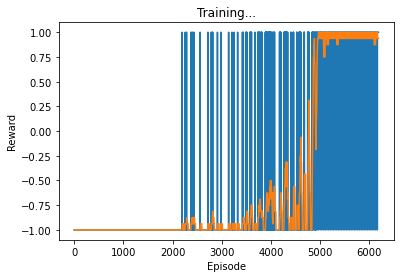

In [104]:
ep3_rewards = []
policy_net.train()
dqnloc_count = [0 for i in range(len(em3.env.tx_locs))]
loc3_errors = [np.abs(20*np.log10(np.abs(x))-20*np.log10(np.abs(y))) for x,y in zip(loc_SNRexh,loc_minSNRexh)]
iter3_avg_error = []
iter3_errors = []

dqn3_epslen=[]
outer = tqdm.notebook.tqdm(total=episodes, desc='training loop: ', position=0)

train_steps = 0
for episode in range(episodes):
    
    #if ((episode+1) > 4100):    
    #    obs = em.test_reset(np.array([[-100,-100,0]]), test_txbdir, em.env.sc_xyz, ch_randvals[episode*(em.env.goal_steps+1)])
    #    test_txbdir = (test_txbdir + 1) % em.env.N_tx
    #else:
    #    #tx_loc_xndx, tx_loc_yndx, tx_dir_ndx =em.env.obs_space.sample()
    tx_num = obs_list[episode]
    
    #policy_net.eval()
    #with torch.no_grad():
    #    action_probs = policy_net(obs).detach().data.cpu().numpy()[0]  
    #policy_net.train()
    #actions= np.argsort(action_probs)[::-1]
    
    obs = em3.reset(tx_num,ch_randvals[episode], dqnloc_count[tx_num]+1)
    tx_num = em3.env.get_txloc_ndx(em3.env.tx_loc)
    dqnloc_count[tx_num] +=1
    #obs = em.test_reset(np.array([[em.env.rx_xcov[tx_loc_xndx],em.env.rx_ycov[tx_loc_yndx], 0]]), tx_dir_ndx, em.env.sc_xyz, ch_randvals[episode*(em.env.goal_steps+1)])
    #dqnloc_maxexhselections[(tx_loc_xndx*len(em.env.rx_ycov)+tx_loc_yndx)*available_actions+tx_dir_ndx]+=1
    
    ep_loss = 0.0
    ep_rwd = 0.0
    timestep = 0
    tx_dirs = [-1.0 for x in range(em3.env.action_space.n)]
    rx_dirs = [-1.0 for x in range(em3.env.action_space.n)]
    data_rates =[np.inf for x in range(em3.env.action_space.n)]
    rssi_vals =[np.complex(0,0) for x in range(em3.env.action_space.n)]
    rwd_vals =[-2.0 for x in range(em3.env.action_space.n)]
    #agent.current_step +=1
    train_steps +=1
    eps = strategy.get_exploration_rate(train_steps)
    done = False
    
    if (episode < len(em3.env.tx_locs)):
        action_list = list(range(em3.env.action_space.n))
        random_actions = random.sample(action_list,len(action_list))
    
    while True:
        #tx_dirs.append(em3.env.tx_bdir*180/np.pi)
        #rx_dirs.append(em.env.rx_bdir[0]*180/np.pi)
        #data_rates.append(em.env.rate)
        #print(em.env.rbdir_ndx)
        if (eps == 1.0):
            action = torch.tensor(np.array([random_actions[em3.env.rbdir_count]]), dtype=torch.long).to(device)
        else:    
            action = agent.act(obs, policy_net, eps)
        next_obs, reward, done, _ = em3.step(action)#,ch_randvals[episode*(em.env.goal_steps+1)+timestep+1])
        #agent.step(obs, action, reward, next_obs, done)
        tx_dirs[em3.env.txdir_ndx] = em3.env.tx_bdir*180/np.pi
        rx_dirs[em3.env.rbdir_ndx] = em3.env.rx_bdir*180/np.pi
        data_rates[em3.env.txdir_ndx*em3.env.N_rx+em3.env.rbdir_ndx] = em3.env.rate
        rssi_vals[em3.env.txdir_ndx*em3.env.N_rx+em3.env.rbdir_ndx] = em3.env.rssi_val
        
        rwd_vals[em3.env.txdir_ndx*em3.env.N_rx+em3.env.rbdir_ndx] = reward.item()
        ep_rwd += reward.item()
        
        '''
        if(np.all(em.env.tx_loc == np.array([[100,100,0]]))):
            print("ch_model: {}, sc_xyz: {}, min_exh_rate: {}, max_exh_rate: {}, min_action_ndx: {}, max_action_ndx: {}".format(em.env.ch_model, em.env.sc_xyz, min_exh_rate, max_exh_rate, min_action_ndx, max_action_ndx))
        '''   
        memory.add(obs, action, reward, next_obs, done)
        obs = next_obs
        
        ep3_rewards.append(reward.item())
        exh_rssi = loc_SNRexh[tx_num]
        if data_rates[em3.env.txdir_ndx*em3.env.N_rx+em3.env.rbdir_ndx] == np.inf:
            dqn_rate = 0.0
            dqn_rssi = loc_minSNRexh[tx_num]#np.complex(1,0)
        else:
            dqn_rate = data_rates[em3.env.txdir_ndx*em3.env.N_rx+em3.env.rbdir_ndx]#max(data_rates)
            dqn_rssi = rssi_vals[em3.env.txdir_ndx*em3.env.N_rx+em3.env.rbdir_ndx]
        #SNR_exh = Es * loc_SNRexh[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx]#np.abs(max_rssi_val) ** 2 / (em.env.N0 * em.env.B)
        #error = exh_rate-dqn_rate#np.abs(20*np.log10(np.abs(max_rssi_val))-20*np.log10(np.abs(rssi_val)))#max_exh_rate - dqn_rate
        error = np.abs(20*np.log10(np.abs(exh_rssi))-20*np.log10(np.abs(dqn_rssi)))
        iter3_errors.append(error)
        loc3_errors[tx_num] = error
        iter3_avg_error.append(np.mean(loc3_errors))

        #print("exh_rate: {}, dqn_rate: {}, error: {}, iter_avg_error: {}".format(np.abs(exh_rssi), np.abs(dqn_rssi), error, np.mean(loc3_errors)))
        #print("best_rate: {}, cur_rate: {}, action: {}, tx action: {}, rxaction: {}".format(em3.env.best_rate, em3.env.rate, action.item(), int(action.item()/em3.env.N_rx), int(action.item()%em3.env.N_rx) ))
        print("best_rate: {}, cur_rate: {}, error: {}, action: {}, iter_avg_error: {}".format(em3.env.best_rate, em3.env.rate, error, action.item(),np.mean(loc3_errors)))
        
        if memory.can_provide_sample():
            experiences = memory.sample()
            observations, actions, rewards, next_observations, dones = experiences
            weights, batch_indices = torch.tensor(np.ones_like(rewards.cpu().data.numpy())).to(device), None

            #print(states.shape, states.dtype)
            #print(actions.unsqueeze(-1).shape)
            current_q_values = policy_net(observations).gather(1,index=actions.unsqueeze(-1))#(1-ALPHA)*
            
            next_q_values = target_net(next_observations).detach().max(1)[0]
            target_q_values = ((next_q_values*GAMMA) + rewards)
            #print(policy_net(observations).type())
            #print(target_q_values.unsqueeze(1).type())
            #loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1).float())
            td_errors = ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values)
            #loss = F.mse_loss(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values),  reduction='sum')
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1).float(),  reduction='sum')
            #weighted_loss = torch.mean(weights*loss)
            #print("loss: ", loss)
            #loss = ALPHA*loss
            #ep_loss += weighted_loss.item()
            #ep_loss = torch.mean(loss).detach().numpy()
            ep_loss = loss.item()
            
            optimizer.zero_grad()
            #weighted_loss.backward()
            #ep_loss.backward(torch.ones_like(ep_loss))
            loss.backward(torch.ones_like(loss))
            optimizer.step()
            
        timestep +=1
        if done:
            dqn3_epslen.append(em3.env.rbdir_count)
            #data_rates.append(em.env.rate)
            #data_rates[em3.env.rbdir_ndx] = em3.env.rate
            #rssi_vals[em3.env.rbdir_ndx] = em3.env.rssi_val
            
            #ep_rewards.append(ep_rwd)
            moving_avg_rwd = get_moving_average(len(em3.env.tx_locs), ep3_rewards)
            
            #print('\rEpisode {},\tScore: {:.2f}, eps: {}, moving avg_rwd: {}, ep_loss: {}'.format(episode+1, ep_rwd, eps, moving_avg_rwd[-1], ep_loss), end="\r")
            print('Episode {},\t Score: {:.2f}, eps: {}, moving avg_rwd: {}, ep_loss: {}'.format(episode+1, ep_rwd, eps, moving_avg_rwd[-1], ep_loss))
            #print("TX loc: {}".format(em3.env.tx_loc))
            tx_num = em3.env.get_txloc_ndx(em3.env.tx_loc)
            exh_action_ndx = loc_exhbdir[tx_num]
            #print("TX dirs: {}, episode length: {}".format(tx_dirs, len(tx_dirs)))
            #print("RX dirs: {}".format(rx_dirs))
            best_action_ndx = em3.env.txdir_ndx*em3.env.N_rx+em3.env.rbdir_ndx#data_rates.index(max(data_rates))
            print("dqn action ndx: {}, exh action ndx: {}".format(best_action_ndx, exh_action_ndx))
            #print("dqn rx bdir: {}, exh bdir: {}".format(rx_dirs[best_action_ndx], em3.env.BeamSet[exh_bdir_ndx]*180/np.pi))
            #print("data rates: ", data_rates)
            #print("rwd vals: ", rwd_vals)
 
            print("\n\n")
                            
            timestep = 0
            break
            
    #for local_param, target_param in zip(policy_net.parameters(), target_net.parameters()):
    #    target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)
    
    #Update the policy network
    if episode % UPDATE_EVERY == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    # update tqdm bar
    outer.update(1)
    
#torch.save(policy_net.state_dict(), 'checkpoint.pth')

#timer.finish()
test_rewards = []
plot(ep3_rewards, len(em3.env.tx_locs), test_rewards)


In [105]:
print("Average episode length: {}".format(np.mean(dqn3_epslen)))
print(len(iter3_avg_error))

Average episode length: 4.124666666666666
6187


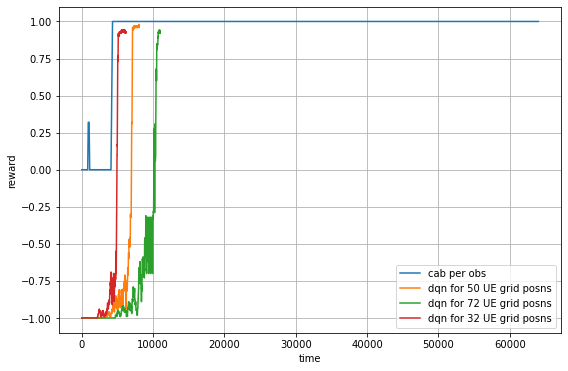

In [106]:
##### from Source.misc_fun.utils import *
fig = plt.figure(figsize=[9, 6])

#loc_ndx = 0
#tbdir_ndx = 3
context_ndx = 0#*len(tx_dirs)+ 4#tbdir_ndx
#context_ndx2 = sel_ctxt_ndices[1]#1*len(tx_dirs)+ 4#tbdir_ndx
#context_ndx3 = sel_ctxt_ndices[2]#2*len(tx_dirs)+ 3#tbdir_ndx
#context_ndx4 = sel_ctxt_ndices[3]#3*len(tx_dirs)+ 3#tbdir_ndx
moving_avg_period = 200
cab_movingavg = get_moving_average(moving_avg_period, train_datarates[0])

#em.env.obs_space.nvec[3]*len(em.env.tx_locs)
dqn3_movingavg = get_moving_average(moving_avg_period, ep3_rewards)
dqn2_movingavg = get_moving_average(moving_avg_period, ep2_rewards)

dqn1_movingavg = get_moving_average(moving_avg_period, ep_rewards)

plt.plot(np.arange(1,len(train_datarates[0])+1,1), cab_movingavg, np.arange(1,len(ep2_rewards)+1,1), dqn2_movingavg, np.arange(1,len(ep_rewards)+1,1), dqn1_movingavg,np.arange(1,len(ep3_rewards)+1,1), dqn3_movingavg)
#min_ndx=0
#max_ndx=500
#plt.plot(test_eps_iters[min_ndx:max_ndx])
plt.grid()
plt.legend(['cab per obs', 'dqn for 50 UE grid posns', 'dqn for 72 UE grid posns','dqn for 32 UE grid posns'])
plt.xlabel('time')
plt.ylabel('reward')
#plt.savefig("121020_cab_dqn_rwdplot_13.pdf")
plt.show()
#plt.savefig("071020_cab_dqn_rwdplot_2.pdf")

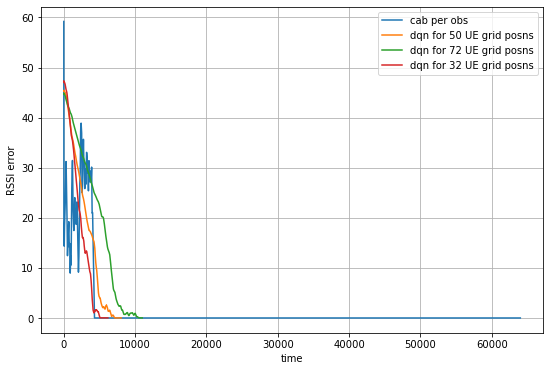

In [107]:
from Source.misc_fun.utils import *
fig = plt.figure(figsize=[9, 6])

#loc_ndx = 0
#tbdir_ndx = 3
context_ndx = 0#0*len(tx_dirs)+ 4#tbdir_ndx
#context_ndx2 = sel_ctxt_ndices[1]#1*len(tx_dirs)+ 4#tbdir_ndx
#context_ndx3 = sel_ctxt_ndices[2]#2*len(tx_dirs)+ 3#tbdir_ndx
#context_ndx4 = sel_ctxt_ndices[3]#3*len(tx_dirs)+ 3#tbdir_ndx
moving_avg_period = 200
#plt.plot(np.arange(1,len(cabenv_avgerrors[context_ndx])+1), cabenv_avgerrors[7], np.arange(1,len(iter_avg_error)+1),iter_avg_error)
cab_movingavg = get_moving_average(moving_avg_period, cabenv_avgerrors)

dqn3_movingavg = get_moving_average(moving_avg_period, iter3_avg_error)

dqn2_movingavg = get_moving_average(moving_avg_period, iter2_avg_error)

dqn1_movingavg = get_moving_average(moving_avg_period, iter_avg_error)

plt.plot(np.arange(1,len(cabenv_avgerrors)+1,1), cab_movingavg, np.arange(1,len(iter2_avg_error)+1,1), dqn2_movingavg, np.arange(1,len(iter_avg_error)+1,1), dqn1_movingavg,np.arange(1,len(iter3_avg_error)+1,1), dqn3_movingavg)
#min_ndx=0
#max_ndx=500
#plt.plot(test_eps_iters[min_ndx:max_ndx])
plt.grid()
plt.legend(['cab per obs', 'dqn for 50 UE grid posns', 'dqn for 72 UE grid posns','dqn for 32 UE grid posns'])
plt.xlabel('time')
plt.ylabel('RSSI error')
#plt.savefig("121020_cab_dqn_erroplot_13.pdf")
plt.show()
#plt.savefig("071020_cab_dqn_erroplot_2.pdf")

### Simulation 4: CAB vs dqn beamaligment without channel variation for 18 TX locations

In [118]:
#Assume LOS or NLOS throughout the environment. Do not change in between for now
from Source.nn_model_dqn import QNetwork
from Source.dqn_rcv_agent import Agent, DQN_ReplayBuffer, EpsilonGreedyStrategy
from Source.env_manager import EnvManager
from Source.misc_fun.utils import plot, get_moving_average, Generate_BeamDir, All_Exhaustive_RateMeas
from Source.PER import PrioritizedReplayBuffer

#Hyper-parameters
BUFFER_SIZE = int(1e5)      #replay buffer size
BATCH_SIZE = 64             #minibatch size
GAMMA = 0.999                #discount factor
ALPHA = 1.0                  #non-stationarity parameter
TAU = 1e-3                  #for soft update of target parameters
LR = 7e-4                   #learning rate
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.982 #125e-6
episodes = 1500 #3100 train, 500 test
UPDATE_EVERY = 50

test_episodes = 20
seed = 0                    #random seed number
episode_step_limit = 50
#%%
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Choose the environment
em4 = EnvManager(device, 'combrf-v7', seed)
em4.env.ant_arr = 'ula'
rx_xcov = np.array([-40,-20,20])
rx_ycov = np.array([-40,-20,20])
rx_zcov = np.array([41.5, 81.5])
beam_param = 'beam-narrow'
beam_paramvals = np.array([])
em4.env.set_beamparameters(beam_param, beam_paramvals)
em4.env.set_coverage(rx_xcov,rx_ycov,rx_zcov)

available_actions = em4.num_actions_available()
random.seed(seed)
state_size = em4.state_size()
print(em4.env.ch_model)
print(em4.env.sc_xyz)

#Select the strategy
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, len(em4.env.tx_locs), 60)#episodes
#Initialize the agent
agent = Agent(strategy, state_size, available_actions, seed, device)

#Instantiate MemoryBuffer
#if not PRIORITIZED_REPLAY:
memory = DQN_ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, seed, device)
#else:
#    memory = PrioritizedReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, PER_ALPHA,seed, device)

policy_net = QNetwork(state_size, available_actions, seed).to(device)
target_net = QNetwork(state_size, available_actions, seed).to(device)
print(policy_net)

#Initialize target_net weights to policy_net weights
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() #Set the target_net in eval mode

#Select the optimizer
#optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)
optimizer = optim.SGD(params=policy_net.parameters(), lr=LR, momentum=0.01)

uma-los
[[  0.   20.   21.5]
 [ 20.    0.   21.5]
 [-20.    0.   21.5]
 [  0.  -20.   21.5]]
QNetwork(
  (fc11): Linear(in_features=32, out_features=200, bias=True)
  (fc12): Linear(in_features=3, out_features=32, bias=True)
  (fc22): Linear(in_features=32, out_features=200, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=256, bias=True)
  )
  (softmax): Softmax(dim=1)
  (output): Linear(in_features=256, out_features=64, bias=True)
)


In [119]:
from Source.misc_fun.conversion import *

#loc_SNRexh = [0.0 for i in range(em.env.obs_space.nvec[3] * len(em.env.tx_locs)) ]
loc_SNRexh = [0.0 for i in range(len(em4.env.tx_locs)) ]
loc_minSNRexh = [0.0 for i in range(len(em4.env.tx_locs)) ]
loc_exhbdir = [0 for i in range(len(em4.env.tx_locs)) ]
for loc_ndx in range(len(em4.env.tx_locs)):
    #for tbdir_ndx in range(em.env.obs_space.nvec[3]):
    min_exh_rate, max_exh_rate,min_action_ndx,max_action_ndx,min_rssi_val,max_rssi_val = em4.env.get_minmax_exhrate(loc_ndx, ch_randvals[loc_ndx])
    #tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
    #Es = db2lin(em.env.P_tx)
    #SNR_exh = Es * np.abs(max_rssi_val) ** 2 / (em.env.N0 * em.env.B)
    #SNR_exh = Es * np.abs(max_rssi_val) ** 2 / (em.env.N0 * em.env.B)
    #exh_rate = np.log2(1 + SNR_exh)
    loc_minSNRexh[loc_ndx] = min_rssi_val#max_exh_rate#
    loc_SNRexh[loc_ndx] = max_rssi_val#max_exh_rate#
    loc_exhbdir[loc_ndx] = max_action_ndx

tx-loc: [[-40.  -40.   41.5]], sc-xyz: [[  0.   20.   21.5]
 [ 20.    0.   21.5]
 [-20.    0.   21.5]
 [  0.  -20.   21.5]], init ch-model: uma-los
txdir_ndx: 0, rxdir_ndx: 0, rate: 18.88342765870174,rssival:(7.606941532537028e-06,-7.592549742902074e-06)
txdir_ndx: 0, rxdir_ndx: 1, rate: 14.027552685136978,rssival:(-1.297671500801055e-06,-1.5181640562842837e-06)
txdir_ndx: 0, rxdir_ndx: 2, rate: 17.164017724713542,rssival:(-3.113242654822508e-06,-5.0384055420396825e-06)
txdir_ndx: 0, rxdir_ndx: 3, rate: 21.47259480997627,rssival:(6.423511317093424e-06,-2.5570232655940707e-05)
txdir_ndx: 0, rxdir_ndx: 4, rate: 17.280283244482096,rssival:(5.308473674098846e-06,-3.1371735920757965e-06)
txdir_ndx: 0, rxdir_ndx: 5, rate: 16.20754333890444,rssival:(4.204420691157604e-06,-6.315391122475732e-07)
txdir_ndx: 0, rxdir_ndx: 6, rate: 18.49992690879444,rssival:(-3.8330017950859444e-06,-8.594007310495846e-06)
txdir_ndx: 0, rxdir_ndx: 7, rate: 19.041355873652677,rssival:(2.1037796268818037e-06,-1.1155

txdir_ndx: 5, rxdir_ndx: 3, rate: 11.506934469159477,rssival:(-7.698860074955333e-07,-3.1967940995161636e-07)
txdir_ndx: 5, rxdir_ndx: 4, rate: 20.4513786372638,rssival:(-1.7080015414527614e-05,-7.123795637481017e-06)
txdir_ndx: 5, rxdir_ndx: 5, rate: 15.133954912730763,rssival:(-2.0510666636178737e-06,-2.0932154828747125e-06)
txdir_ndx: 5, rxdir_ndx: 6, rate: 15.319935611709464,rssival:(-2.7410956794186977e-06,1.502176553691223e-06)
txdir_ndx: 5, rxdir_ndx: 7, rate: 17.33985550686386,rssival:(-5.183862001817363e-06,-3.571023444106968e-06)


txdir_ndx: 6, rxdir_ndx: 0, rate: 17.61890853581185,rssival:(4.009340565741867e-06,-5.657357759554043e-06)
txdir_ndx: 6, rxdir_ndx: 1, rate: 15.224262978800287,rssival:(-2.2101654921088228e-08,-3.0236969375440448e-06)
txdir_ndx: 6, rxdir_ndx: 2, rate: 14.244004658744567,rssival:(8.982126621788397e-07,-1.9564507442147456e-06)
txdir_ndx: 6, rxdir_ndx: 3, rate: 16.09900821355427,rssival:(-4.094628375410261e-06,-4.178734087301424e-09)
txdir_ndx: 6, rxd

txdir_ndx: 0, rxdir_ndx: 0, rate: 16.891183503443063,rssival:(1.8286562123085842e-06,-5.068490445661889e-06)
txdir_ndx: 0, rxdir_ndx: 1, rate: 12.542227430685639,rssival:(-7.94361753580796e-07,-8.907850987769828e-07)
txdir_ndx: 0, rxdir_ndx: 2, rate: 14.944568533165743,rssival:(-1.4597215300768409e-06,-2.3240158036857193e-06)
txdir_ndx: 0, rxdir_ndx: 3, rate: 15.450048451092565,rssival:(-7.386481329238215e-07,-3.1853822863406203e-06)
txdir_ndx: 0, rxdir_ndx: 4, rate: 12.131639707033333,rssival:(-9.153038098827355e-08,-1.0311376685598155e-06)
txdir_ndx: 0, rxdir_ndx: 5, rate: 11.822944512196374,rssival:(-2.629249029166028e-07,-8.922007931236452e-07)
txdir_ndx: 0, rxdir_ndx: 6, rate: 16.651661399284716,rssival:(-4.579139758208881e-06,-1.9035845847263852e-06)
txdir_ndx: 0, rxdir_ndx: 7, rate: 17.229470439104215,rssival:(-2.490368352715924e-06,-5.523039197429862e-06)


txdir_ndx: 1, rxdir_ndx: 0, rate: 14.17593005341803,rssival:(2.073051475720769e-06,-3.511832209748762e-07)
txdir_ndx: 1, r

In [120]:
print(np.mean([np.abs(20*np.log10(np.abs(x))-20*np.log10(np.abs(y))) for x,y in zip(loc_SNRexh, loc_minSNRexh)]))
print(len(em4.env.tx_locs))

49.41443802112615
18


In [121]:
locndx_list = list(range(len(em4.env.tx_locs)))
random_loc_ndices = random.sample(locndx_list, len(locndx_list))
#txdir_list = list(range(em.env.obs_space.nvec[3]))
#txdir_ndices = random.sample(txdir_list, len(txdir_list))

obs_list = []
for eps in range(episodes):
    ndx = eps % (len(em4.env.tx_locs))
    #ndx = eps % (em.env.obs_space.nvec[3] * len(em.env.tx_locs))
    #ndx1 = int(ndx / em.env.obs_space.nvec[3])    
    #ndx2 = int(ndx % em.env.obs_space.nvec[3])
    obs_list.append((random_loc_ndices[ndx]))

In [122]:
print("Number of locations: ",len(em4.env.tx_locs))
print("Number of actions: ", em4.env.action_space.n)
action_list = list(range(em4.env.action_space.n))
random_actions = random.sample(action_list,len(action_list))
print(random_actions)

Number of locations:  18
Number of actions:  64
[39, 6, 46, 4, 57, 54, 43, 21, 30, 35, 62, 22, 27, 20, 63, 40, 13, 58, 55, 28, 33, 16, 3, 61, 0, 5, 25, 49, 31, 56, 15, 50, 60, 53, 29, 18, 7, 51, 37, 48, 17, 14, 2, 34, 10, 42, 59, 41, 9, 8, 24, 11, 1, 52, 38, 19, 44, 45, 47, 23, 32, 12, 36, 26]


init rate: -inf, init tx action: -1, init rx action: -1
best_rate: inf, cur_rate: 20.067644755859718, error: 18.758489323584328, action: 40, iter_avg_error: 47.93954932716008
best_rate: inf, cur_rate: 19.46637791507069, error: 20.5684849117375, action: 36, iter_avg_error: 48.04010463761304
best_rate: inf, cur_rate: 17.339855506863866, error: 26.969975409478423, action: 15, iter_avg_error: 48.39574299859864
best_rate: inf, cur_rate: 19.439846961984543, error: 20.648351149937696, action: 18, iter_avg_error: 48.04454165084638
best_rate: inf, cur_rate: 11.50693446915943, error: 44.530283718203094, action: 11, iter_avg_error: 49.37131568241668
best_rate: inf, cur_rate: 14.918413381278949, error: 34.25935660469966, action: 12, iter_avg_error: 48.800708620555376
best_rate: inf, cur_rate: 15.295994094618157, error: 33.12269310366513, action: 52, iter_avg_error: 48.737560648275675
best_rate: inf, cur_rate: 17.32978056720925, error: 27.00030418334981, action: 59, iter_avg_error: 48.3974279304803

best_rate: inf, cur_rate: 17.88664072251532, error: 17.721686714984642, action: 22, iter_avg_error: 46.92334774902083
best_rate: inf, cur_rate: 16.833843520474566, error: 20.89094134403628, action: 47, iter_avg_error: 47.09941745063481
best_rate: inf, cur_rate: 15.781827838985539, error: 24.057864013309427, action: 58, iter_avg_error: 47.27535759892776
best_rate: inf, cur_rate: 15.230572822150638, error: 25.717342840533632, action: 52, iter_avg_error: 47.36755086710688
best_rate: inf, cur_rate: 17.97222057572481, error: 17.464064654411118, action: 32, iter_avg_error: 46.909035412322304
best_rate: inf, cur_rate: 16.715128711514275, error: 21.248311717030745, action: 29, iter_avg_error: 47.11927136024561
best_rate: inf, cur_rate: 12.557278223332046, error: 33.765369108274186, action: 62, iter_avg_error: 47.814663437536915
best_rate: inf, cur_rate: 11.207139656664186, error: 37.83080790868409, action: 57, iter_avg_error: 48.0405211486708
best_rate: inf, cur_rate: 15.628563668891037, error

best_rate: inf, cur_rate: 14.894143153716268, error: 21.207356673366576, action: 53, iter_avg_error: 46.23281648254003
best_rate: inf, cur_rate: 19.484366786693407, error: 7.389269962274284, action: 14, iter_avg_error: 45.46514499859046
best_rate: inf, cur_rate: 12.451861017559462, error: 28.559991098790903, action: 28, iter_avg_error: 46.64129617284138
best_rate: inf, cur_rate: 17.726086124311706, error: 12.68223627381299, action: 36, iter_avg_error: 45.75919868256483
best_rate: inf, cur_rate: 15.006074323769328, error: 20.870399629395237, action: 46, iter_avg_error: 46.21409664676385
best_rate: inf, cur_rate: 16.028259708160597, error: 17.793248012905906, action: 31, iter_avg_error: 46.04314377918111
best_rate: inf, cur_rate: 16.10101113244839, error: 17.574241207823277, action: 35, iter_avg_error: 46.03097673445429
best_rate: inf, cur_rate: 17.564993760214882, error: 13.167174976800425, action: 52, iter_avg_error: 45.78613972161969
best_rate: inf, cur_rate: 14.248685322916677, error

best_rate: inf, cur_rate: 18.48079573142201, error: 19.660533765075215, action: 16, iter_avg_error: 44.34449253827337
best_rate: inf, cur_rate: 19.172599631545147, error: 17.5779919923705, action: 23, iter_avg_error: 44.22879577312311
best_rate: inf, cur_rate: 18.48971719780422, error: 19.63367740202513, action: 21, iter_avg_error: 44.34300051810393
best_rate: inf, cur_rate: 16.16602455238952, error: 26.628736538129573, action: 37, iter_avg_error: 44.73161491455417
best_rate: inf, cur_rate: 20.12812351374292, error: 14.70157493152773, action: 56, iter_avg_error: 44.06899482529851
best_rate: inf, cur_rate: 17.064033043034833, error: 23.92543424852923, action: 24, iter_avg_error: 44.581431454020816
best_rate: inf, cur_rate: 18.074514094131654, error: 20.883567221641187, action: 27, iter_avg_error: 44.41243884141593
best_rate: inf, cur_rate: 10.939966339076687, error: 42.36289153115692, action: 49, iter_avg_error: 45.60573463638902
best_rate: inf, cur_rate: 23.38014861714411, error: 4.912

best_rate: inf, cur_rate: 21.029210161282467, error: 15.718891187154327, action: 15, iter_avg_error: 42.33581247807534
best_rate: inf, cur_rate: 22.111917087163, error: 12.459617503903132, action: 29, iter_avg_error: 42.15474171789472
best_rate: inf, cur_rate: 17.389954545913625, error: 26.67416546536643, action: 26, iter_avg_error: 42.9444388268649
best_rate: inf, cur_rate: 15.837817961317423, error: 31.346611025413026, action: 46, iter_avg_error: 43.20401913575638
best_rate: inf, cur_rate: 15.479249281506359, error: 32.42603122948675, action: 33, iter_avg_error: 43.26398692487159
best_rate: inf, cur_rate: 18.153855049225513, error: 24.374585418148328, action: 28, iter_avg_error: 42.81668437979723
best_rate: inf, cur_rate: 21.413819146898238, error: 14.56110229953184, action: 14, iter_avg_error: 42.271490873207426
best_rate: inf, cur_rate: 19.2709455566248, error: 21.01179988612708, action: 20, iter_avg_error: 42.629862961351606
best_rate: inf, cur_rate: 22.63248208023749, error: 10.8

best_rate: inf, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 39.55933075260651
best_rate: inf, cur_rate: 11.20713965666421, error: 37.83080790868401, action: 61, iter_avg_error: 41.66104230308896
best_rate: inf, cur_rate: 11.80503778898411, error: 36.030331717352325, action: 42, iter_avg_error: 41.56101584801498
best_rate: inf, cur_rate: 21.50228750855203, error: 6.8374888924521, action: 30, iter_avg_error: 39.93919124663163
best_rate: inf, cur_rate: 14.339310096636199, error: 28.40040754624519, action: 44, iter_avg_error: 41.137131171842356
best_rate: inf, cur_rate: 18.278611167088258, error: 16.541733838980974, action: 11, iter_avg_error: 40.47831596588324
best_rate: inf, cur_rate: 22.94472523288632, error: 2.495317749361149, action: 19, iter_avg_error: 39.69795951645991
best_rate: inf, cur_rate: 18.95612546354684, error: 14.502207463419367, action: 36, iter_avg_error: 40.365008945018694
best_rate: inf, cur_rate: 15.684655202935469, error: 24.35038816653413, ac

best_rate: inf, cur_rate: 18.011440181013473, error: 24.8032984347347, action: 19, iter_avg_error: 37.67180122865512
best_rate: inf, cur_rate: 18.32089162280443, error: 23.871753599892102, action: 32, iter_avg_error: 37.62004873783053
best_rate: inf, cur_rate: 17.96469372269039, error: 24.94401983748952, action: 36, iter_avg_error: 37.67961908436372
best_rate: inf, cur_rate: 19.379105348582247, error: 20.686205973219856, action: 16, iter_avg_error: 37.443073869682074
best_rate: inf, cur_rate: 15.479249281506386, error: 32.426031229486625, action: 21, iter_avg_error: 38.09528638391911
best_rate: inf, cur_rate: 16.60141245306921, error: 29.0479320848915, action: 4, iter_avg_error: 37.90761420921938
best_rate: inf, cur_rate: 24.117183324258516, error: 6.423163917836959, action: 31, iter_avg_error: 36.65068264438302
best_rate: inf, cur_rate: 21.721944096136557, error: 13.633553479261039, action: 54, iter_avg_error: 37.051259842239915
best_rate: inf, cur_rate: 22.707135986804417, error: 10.

best_rate: inf, cur_rate: 17.229470439104208, error: 24.04684221196311, action: 7, iter_avg_error: 36.490040737849846
best_rate: inf, cur_rate: 21.05174352081993, error: 12.54062745602701, action: 33, iter_avg_error: 35.85080658474229
best_rate: inf, cur_rate: 13.624843149604963, error: 34.89816713079077, action: 62, iter_avg_error: 37.09289212222916
best_rate: inf, cur_rate: 11.592866938164295, error: 41.016087446892726, action: 12, iter_avg_error: 37.43277658423482
best_rate: inf, cur_rate: 14.944568533165656, error: 30.92519178839615, action: 2, iter_avg_error: 36.8721712698739
best_rate: inf, cur_rate: 18.173465216544233, error: 21.205121202837518, action: 25, iter_avg_error: 36.33216734845398
best_rate: inf, cur_rate: 16.374437249679485, error: 26.62077144322342, action: 28, iter_avg_error: 36.633036806253195
best_rate: inf, cur_rate: 19.071455658187393, error: 18.501893808359142, action: 23, iter_avg_error: 36.181988048760736
best_rate: inf, cur_rate: 16.802397685546243, error: 2

best_rate: inf, cur_rate: 16.311997523076652, error: 17.51265527985899, action: 59, iter_avg_error: 35.108357003967576
best_rate: inf, cur_rate: 8.528348073724555, error: 40.955499850312634, action: 45, iter_avg_error: 36.410737257881664
best_rate: inf, cur_rate: 17.799188832541482, error: 13.035729005748038, action: 18, iter_avg_error: 34.85963887762808
best_rate: inf, cur_rate: 12.037573319828557, error: 30.380934047213827, action: 50, iter_avg_error: 35.82326137993173
best_rate: inf, cur_rate: 16.971317240352473, error: 15.52788558207807, action: 56, iter_avg_error: 34.998092020757525
best_rate: inf, cur_rate: 16.627549607960734, error: 16.562738365321636, action: 51, iter_avg_error: 35.05558384204883
best_rate: inf, cur_rate: 15.449126285959053, error: 20.110200228579956, action: 47, iter_avg_error: 35.252665056674296
best_rate: inf, cur_rate: 15.452099171215465, error: 20.10125075237349, action: 53, iter_avg_error: 35.25216786355171
best_rate: inf, cur_rate: 16.42584166134534, err

best_rate: inf, cur_rate: 16.53254396976248, error: 16.848736753653853, action: 60, iter_avg_error: 33.934770666311536
best_rate: inf, cur_rate: 20.797486583397095, error: 4.009936758063105, action: 13, iter_avg_error: 33.22150399988983
best_rate: inf, cur_rate: 10.321563268137384, error: 35.54900098725936, action: 42, iter_avg_error: 34.97367423484518
best_rate: inf, cur_rate: 4.467832707040394, error: 53.36792398145937, action: 52, iter_avg_error: 35.96361440118962
best_rate: inf, cur_rate: 8.528348073724745, error: 40.955499850312066, action: 45, iter_avg_error: 35.274035282792546
best_rate: inf, cur_rate: 16.045657799171813, error: 18.31442856238239, action: 63, iter_avg_error: 34.01619798901867
best_rate: inf, cur_rate: 14.669280082770817, error: 22.45784082429327, action: 46, iter_avg_error: 34.246387559124834
best_rate: inf, cur_rate: 14.142948559785502, error: 24.04232997272895, action: 62, iter_avg_error: 34.334414734037935
best_rate: inf, cur_rate: 16.199654601617166, error: 

best_rate: inf, cur_rate: 19.719646623705255, error: 19.661073248301904, action: 21, iter_avg_error: 31.775030938575256
best_rate: inf, cur_rate: 21.83391492996667, error: 13.29648758927813, action: 6, iter_avg_error: 31.421442846407267
best_rate: inf, cur_rate: 14.336278666383592, error: 35.86683051070325, action: 54, iter_avg_error: 32.67535078648644
best_rate: inf, cur_rate: 6.597556990924214, error: 59.20757301711255, action: 36, iter_avg_error: 33.97205870350918
best_rate: inf, cur_rate: 20.38271517765681, error: 17.66503615565692, action: 62, iter_avg_error: 31.664139988983866
best_rate: inf, cur_rate: 19.473540263125507, error: 20.401928150498918, action: 32, iter_avg_error: 31.816189544252868
best_rate: inf, cur_rate: 12.801368717416267, error: 40.487768340902505, action: 44, iter_avg_error: 32.932069554830846
best_rate: inf, cur_rate: 17.389954545913604, error: 26.67416546536643, action: 26, iter_avg_error: 32.16464717285661
best_rate: inf, cur_rate: 20.32912629541657, error: 

best_rate: inf, cur_rate: 19.086925568276342, error: 18.455324654609342, action: 38, iter_avg_error: 30.309663216834718
best_rate: inf, cur_rate: 11.592866938164256, error: 41.01608744689284, action: 12, iter_avg_error: 31.563038927517134
best_rate: inf, cur_rate: 13.294600862038445, error: 35.89238391477997, action: 53, iter_avg_error: 31.27838873128864
best_rate: inf, cur_rate: 18.880886991046513, error: 19.075563772010327, action: 16, iter_avg_error: 30.344120945579213
best_rate: inf, cur_rate: 14.944568533165743, error: 30.925191788395892, action: 2, iter_avg_error: 31.002433613156192
best_rate: inf, cur_rate: 19.09702468713329, error: 18.424923223147317, action: 58, iter_avg_error: 30.307974248420162
best_rate: inf, cur_rate: 15.46291658893178, error: 29.364767087276277, action: 63, iter_avg_error: 30.915743351982883
best_rate: inf, cur_rate: 13.828208853143812, error: 34.285930157602024, action: 21, iter_avg_error: 31.189141300334313
best_rate: inf, cur_rate: 18.00688949286774, e

best_rate: inf, cur_rate: 19.172599631545133, error: 17.577991992370542, action: 23, iter_avg_error: 28.974236206650467
best_rate: inf, cur_rate: 14.718239365606843, error: 30.987106282517146, action: 17, iter_avg_error: 29.7191870005475
best_rate: inf, cur_rate: 16.166024552389537, error: 26.628736538129516, action: 37, iter_avg_error: 29.477055348081517
best_rate: inf, cur_rate: 15.433062431810045, error: 28.835211482128543, action: 19, iter_avg_error: 29.599637289414797
best_rate: inf, cur_rate: 22.87400474719877, error: 6.435645548690445, action: 61, iter_avg_error: 28.355216959779348
best_rate: inf, cur_rate: 19.506760967425823, error: 16.572064617914705, action: 30, iter_avg_error: 28.91835135251403
best_rate: inf, cur_rate: 20.70166102013068, error: 12.975053757739971, action: 0, iter_avg_error: 28.718517415837653
best_rate: inf, cur_rate: 20.029160382173135, error: 14.999483911289772, action: 51, iter_avg_error: 28.83098575770153
best_rate: inf, cur_rate: 23.380148617144112, er

best_rate: inf, cur_rate: 23.28517006102529, error: 8.92777359427049, action: 30, iter_avg_error: 26.58014434721851
best_rate: inf, cur_rate: 21.833914929966667, error: 13.296487589278186, action: 48, iter_avg_error: 26.82285068027449
best_rate: inf, cur_rate: 17.38995454591361, error: 26.67416546536647, action: 28, iter_avg_error: 27.566055006723843
best_rate: inf, cur_rate: 19.07197510704834, error: 21.610761637076052, action: 62, iter_avg_error: 27.28475479404104
best_rate: inf, cur_rate: 14.527121896709229, error: 35.292309126271846, action: 58, iter_avg_error: 28.044840765663032
best_rate: inf, cur_rate: 15.705414285912129, error: 31.745192931297538, action: 15, iter_avg_error: 27.847778754831122
best_rate: inf, cur_rate: 18.011440181013484, error: 24.8032984347347, action: 19, iter_avg_error: 27.462117949466524
best_rate: inf, cur_rate: 18.320891622804464, error: 23.87175359989206, action: 32, iter_avg_error: 27.410365458641927
best_rate: inf, cur_rate: 13.469768299177394, error:

best_rate: inf, cur_rate: 18.8547118404772, error: 19.15435899134883, action: 36, iter_avg_error: 24.307452899083632
best_rate: inf, cur_rate: 19.754957883912063, error: 16.444344113171525, action: 14, iter_avg_error: 24.156896516962668
best_rate: inf, cur_rate: 14.76691381555161, error: 31.460003826072864, action: 47, iter_avg_error: 24.99109983434608
best_rate: inf, cur_rate: 12.542227430685598, error: 38.15754954738982, action: 53, iter_avg_error: 25.363185707752578
best_rate: inf, cur_rate: 9.54360483509477, error: 47.18939807708978, action: 57, iter_avg_error: 25.864955070513684
best_rate: inf, cur_rate: 19.918300920066038, error: 15.952632053080762, action: 15, iter_avg_error: 24.129579180290957
best_rate: inf, cur_rate: 20.290649393725058, error: 14.831750461925978, action: 4, iter_avg_error: 24.06730798078236
best_rate: inf, cur_rate: 13.828208853143817, error: 34.285930157601996, action: 33, iter_avg_error: 25.14809574165325
best_rate: inf, cur_rate: 24.1331938569979, error: 3

best_rate: inf, cur_rate: 16.891183503443056, error: 25.065194828028865, action: 54, iter_avg_error: 24.20274285877677
best_rate: inf, cur_rate: 16.802397685546236, error: 25.332469039758593, action: 5, iter_avg_error: 24.217591426095087
best_rate: inf, cur_rate: 19.086925568276374, error: 18.455324654609228, action: 16, iter_avg_error: 23.835527849142345
best_rate: inf, cur_rate: 19.013407646303175, error: 18.67663605967354, action: 8, iter_avg_error: 23.847822927201474
best_rate: inf, cur_rate: 18.880886991046513, error: 19.075563772010298, action: 38, iter_avg_error: 23.86998557788685
best_rate: inf, cur_rate: 17.570289701139945, error: 23.020868055754008, action: 25, iter_avg_error: 24.089169149205944
best_rate: inf, cur_rate: 19.097024687133295, error: 18.424923223147275, action: 60, iter_avg_error: 23.83383888072779
best_rate: inf, cur_rate: 21.283102557046927, error: 11.844167063276856, action: 12, iter_avg_error: 23.46824131629055
best_rate: inf, cur_rate: 15.462916588931773, e

best_rate: 26.29907873065871, cur_rate: 19.439846961984543, error: 20.648351149937696, action: 18, iter_avg_error: 24.306000264593802
best_rate: 26.29907873065871, cur_rate: 20.45137863726381, error: 17.60333431403805, action: 10, iter_avg_error: 24.136832662599375
best_rate: 26.29907873065871, cur_rate: 19.99032732886191, error: 18.991238188300812, action: 42, iter_avg_error: 24.21393843339175
best_rate: 26.29907873065871, cur_rate: 21.71425034011833, error: 13.801709914891347, action: 30, iter_avg_error: 23.925631307091223
best_rate: 26.29907873065871, cur_rate: 17.270395441826548, error: 27.179072331550202, action: 22, iter_avg_error: 24.668818108016712
best_rate: 26.29907873065871, cur_rate: 22.322553764927402, error: 11.97053370731156, action: 31, iter_avg_error: 23.823899295559013
best_rate: 26.29907873065871, cur_rate: 20.735725706826397, error: 16.74736380100626, action: 2, iter_avg_error: 24.089278745208716
best_rate: 26.29907873065871, cur_rate: 13.735762487076983, error: 37.

best_rate: 21.93902752738383, cur_rate: 16.028259708160597, error: 17.793248012905906, action: 31, iter_avg_error: 22.398874862058044
best_rate: 21.93902752738383, cur_rate: 13.473619532945927, error: 25.483798041839947, action: 45, iter_avg_error: 22.826127641443268
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 20, iter_avg_error: 21.410361083563274
Episode 21,	 Score: -11.00, eps: 0.946966168, moving avg_rwd: -0.7777777910232544, ep_loss: 1089.4140625
dqn action ndx: 20, exh action ndx: 20



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 15.433062431810024, error: 28.835211482128614, action: 19, iter_avg_error: 21.512707581933316
best_rate: 25.01187977785716, cur_rate: 15.433062431810024, error: 28.835211482128614, action: 19, iter_avg_error: 21.512707581933316
best_rate: 25.01187977785716, cur_rate: 15.069011162325006, error: 29.931143181230098, action: 42, iter_avg_error: 21.57359267632784

best_rate: 26.250912130714696, cur_rate: 20.517706729090186, error: 17.258670810472324, action: 59, iter_avg_error: 20.276909225051718
best_rate: 26.250912130714696, cur_rate: 13.918937621897616, error: 37.12322267646343, action: 4, iter_avg_error: 21.380495439829
best_rate: 26.250912130714696, cur_rate: 22.63248208023749, error: 10.892560437597595, action: 19, iter_avg_error: 19.92323642655868
best_rate: 26.250912130714696, cur_rate: 21.413819146898238, error: 14.56110229953184, action: 14, iter_avg_error: 20.127044307777243
best_rate: 26.250912130714696, cur_rate: 13.371808583200854, error: 38.77037451828794, action: 52, iter_avg_error: 21.47200387548592
best_rate: 26.250912130714696, cur_rate: 22.111917087163, error: 12.459617503903132, action: 29, iter_avg_error: 20.010295152464536
best_rate: 26.250912130714696, cur_rate: 16.915897108976193, error: 28.10123038395146, action: 2, iter_avg_error: 20.879273645800556
best_rate: 26.250912130714696, cur_rate: 15.837817961317423, error: 31

best_rate: 23.7736517685126, cur_rate: 14.339310096636199, error: 28.40040754624519, action: 44, iter_avg_error: 21.39675242061356
best_rate: 23.7736517685126, cur_rate: 15.684655202935469, error: 24.35038816653413, action: 46, iter_avg_error: 21.171751343962942
best_rate: 23.7736517685126, cur_rate: 16.613824516958704, error: 21.553270665963353, action: 0, iter_avg_error: 21.01635592726457
best_rate: 23.7736517685126, cur_rate: 15.935627925551744, error: 23.59487182420129, action: 8, iter_avg_error: 21.12977821383334
best_rate: 23.7736517685126, cur_rate: 21.06032037269678, error: 8.167943066419411, action: 24, iter_avg_error: 20.27272661617879
best_rate: 23.7736517685126, cur_rate: 17.17450479574894, error: 19.86544090236893, action: 14, iter_avg_error: 20.922587607064877
best_rate: 23.7736517685126, cur_rate: 17.17450479574894, error: 19.86544090236893, action: 14, iter_avg_error: 20.922587607064877
best_rate: 23.7736517685126, cur_rate: 15.781827838985539, error: 24.057864013309427

best_rate: 25.217649161469172, cur_rate: 21.763813581072597, error: 10.397082206221171, action: 30, iter_avg_error: 16.591569477651504
best_rate: 25.217649161469172, cur_rate: 19.097024687133306, error: 18.42492322314726, action: 58, iter_avg_error: 17.03756064525851
best_rate: 25.217649161469172, cur_rate: 14.111716144788371, error: 33.432434895033026, action: 20, iter_avg_error: 17.871311293696603
best_rate: 25.217649161469172, cur_rate: 21.283102557046938, error: 11.84416706327687, action: 42, iter_avg_error: 16.671963080821264
best_rate: 25.217649161469172, cur_rate: 15.582515344703403, error: 29.004731307866535, action: 17, iter_avg_error: 17.625327761076246
best_rate: 25.217649161469172, cur_rate: 13.58045360984997, error: 35.031803703680026, action: 60, iter_avg_error: 17.960165116399214
best_rate: 25.217649161469172, cur_rate: 17.229470439104208, error: 24.04684221196311, action: 7, iter_avg_error: 17.3498894779705

best_rate: 25.217649161469172, cur_rate: 15.56691110346738, er

best_rate: 22.129558263749963, cur_rate: 16.157039861564474, error: 17.979130374442974, action: 2, iter_avg_error: 16.522267858926487
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 15.52342728256854
Episode 28,	 Score: -16.00, eps: 0.8339017358584584, moving avg_rwd: -0.8888888955116272, ep_loss: 1307.075927734375
dqn action ndx: 22, exh action ndx: 22



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 16.627549607960724, error: 16.562738365321678, action: 51, iter_avg_error: 15.470250446019113
best_rate: 22.129558263749963, cur_rate: 12.028072134701013, error: 30.409542291729565, action: 1, iter_avg_error: 16.239517330819552
best_rate: 22.129558263749963, cur_rate: 22.050550308831735, error: 0.23783769654475861, action: 19, iter_avg_error: 14.563311519975953
best_rate: 22.129558263749963, cur_rate: 22.050550308831735, error: 0.23783769654475861, action: 19, iter_avg_error

best_rate: 26.250912130714678, cur_rate: 14.336278666383592, error: 35.86683051070325, action: 54, iter_avg_error: 15.31944847190404
best_rate: 26.250912130714678, cur_rate: 21.721944096136543, error: 13.633553479261053, action: 0, iter_avg_error: 14.084266414601696
best_rate: 26.250912130714678, cur_rate: 21.41381914689826, error: 14.561102299531711, action: 14, iter_avg_error: 14.135796904616733
best_rate: 26.250912130714678, cur_rate: 12.695105364394424, error: 40.80769941859751, action: 49, iter_avg_error: 15.593941189009277
best_rate: 26.250912130714678, cur_rate: 18.320891622804442, error: 23.871753599892074, action: 22, iter_avg_error: 14.653055310192308
best_rate: 26.250912130714678, cur_rate: 22.63248208023749, error: 10.892560437597538, action: 19, iter_avg_error: 13.931989023398167
best_rate: 26.250912130714678, cur_rate: 16.91589710897616, error: 28.10123038395149, action: 2, iter_avg_error: 14.888026242640052
best_rate: 26.250912130714678, cur_rate: 21.41381914689826, erro

best_rate: 25.217649161469165, cur_rate: 24.133193856997902, error: 3.2645358807534706, action: 35, iter_avg_error: 14.69072267750812
best_rate: 25.217649161469165, cur_rate: 18.00688949286774, error: 21.70656589455072, action: 54, iter_avg_error: 15.715279900496856
best_rate: 25.217649161469165, cur_rate: 11.822944512196374, error: 40.32327761459629, action: 5, iter_avg_error: 16.749541662721608
best_rate: 25.217649161469165, cur_rate: 17.850645599917137, error: 22.176908764674266, action: 41, iter_avg_error: 15.741410059948164
best_rate: 25.217649161469165, cur_rate: 20.290649393725058, error: 14.831750461925978, action: 50, iter_avg_error: 15.33334570979548
best_rate: 25.217649161469165, cur_rate: 9.62956475388172, error: 46.93029589383589, action: 13, iter_avg_error: 17.116598233790477
best_rate: 25.217649161469165, cur_rate: 16.651661399284716, error: 25.786234660717398, action: 6, iter_avg_error: 15.941928165283892
best_rate: 25.217649161469165, cur_rate: 18.854711840477204, erro

best_rate: 25.011879777857157, cur_rate: 16.641295437589275, error: 25.19801203531466, action: 54, iter_avg_error: 16.722007106619873
best_rate: 25.011879777857157, cur_rate: 14.718239365606843, error: 30.987106282517146, action: 17, iter_avg_error: 17.043623453686678
best_rate: 25.011879777857157, cur_rate: 18.489717197804225, error: 19.63367740202513, action: 21, iter_avg_error: 16.41287740477045
best_rate: 25.011879777857157, cur_rate: 15.433062431810045, error: 28.835211482128543, action: 19, iter_avg_error: 16.924073742553976
best_rate: 25.011879777857157, cur_rate: 14.226685622633894, error: 32.46689590508642, action: 26, iter_avg_error: 17.125833988273857
best_rate: 25.011879777857157, cur_rate: 18.489717197804225, error: 19.63367740202513, action: 21, iter_avg_error: 16.41287740477045
best_rate: 25.011879777857157, cur_rate: 18.958850749507537, error: 18.221441416398207, action: 29, iter_avg_error: 16.3344198500134
best_rate: 25.011879777857157, cur_rate: 23.051344277826942, er

best_rate: 26.250912130714696, cur_rate: 18.320891622804464, error: 23.87175359989206, action: 32, iter_avg_error: 17.35928563347498
best_rate: 26.250912130714696, cur_rate: 19.07197510704834, error: 21.610761637076052, action: 62, iter_avg_error: 17.23367496887409
best_rate: 26.250912130714696, cur_rate: 19.445182293537748, error: 20.48729426354376, action: 29, iter_avg_error: 17.17126011478896
best_rate: 26.250912130714696, cur_rate: 16.070055091642462, error: 30.647496576429276, action: 20, iter_avg_error: 17.735715798838157
best_rate: 26.250912130714696, cur_rate: 20.5149935481115, error: 17.266838304500496, action: 3, iter_avg_error: 16.992345894842114
best_rate: 26.250912130714696, cur_rate: 20.625478486002173, error: 16.934245287080174, action: 9, iter_avg_error: 16.97386850498543
best_rate: 26.250912130714696, cur_rate: 15.479249281506359, error: 32.42603122948675, action: 21, iter_avg_error: 17.834523279563573
best_rate: 26.250912130714696, cur_rate: 20.5149935481115, error: 1

best_rate: 25.739333510754456, cur_rate: 19.52448299833094, error: 18.70856990930868, action: 29, iter_avg_error: 17.318547196146355
best_rate: 25.739333510754456, cur_rate: 19.355568496514195, error: 19.217053942113765, action: 14, iter_avg_error: 17.346796309079973
best_rate: 25.739333510754456, cur_rate: 18.86565211918674, error: 20.69185180942317, action: 37, iter_avg_error: 17.428729523930492
best_rate: 25.739333510754456, cur_rate: 19.355568496514195, error: 19.217053942113765, action: 14, iter_avg_error: 17.346796309079973
best_rate: 25.739333510754456, cur_rate: 17.810160958094365, error: 23.86920661091939, action: 47, iter_avg_error: 17.60524923512473
best_rate: 25.739333510754456, cur_rate: 17.810160958094365, error: 23.86920661091939, action: 47, iter_avg_error: 17.60524923512473
best_rate: 25.739333510754456, cur_rate: 17.810160958094365, error: 23.86920661091939, action: 47, iter_avg_error: 17.60524923512473
best_rate: 25.739333510754456, cur_rate: 20.030594597053554, erro

best_rate: 25.217649161469172, cur_rate: 17.570289701139952, error: 23.020868055754022, action: 25, iter_avg_error: 15.369575897899628
best_rate: 25.217649161469172, cur_rate: 15.295316068072099, error: 29.86930677374795, action: 61, iter_avg_error: 15.75004471556596
best_rate: 25.217649161469172, cur_rate: 10.909496030366503, error: 43.07409109512244, action: 45, iter_avg_error: 16.483643844531205
best_rate: 25.217649161469172, cur_rate: 18.8547118404772, error: 19.15435899134883, action: 36, iter_avg_error: 15.154769838766006
best_rate: 25.217649161469172, cur_rate: 19.088070934081333, error: 18.45187675378689, action: 3, iter_avg_error: 15.115743047790343
best_rate: 25.217649161469172, cur_rate: 11.82294451219637, error: 40.32327761459631, action: 49, iter_avg_error: 16.330820873390866
best_rate: 25.217649161469172, cur_rate: 19.08692556827635, error: 18.455324654609328, action: 16, iter_avg_error: 15.115934597836034
best_rate: 25.217649161469172, cur_rate: 19.918300920066038, error

best_rate: 25.217649161469165, cur_rate: 18.173465216544226, error: 21.205121202837503, action: 29, iter_avg_error: 14.994171656041962
best_rate: 25.217649161469165, cur_rate: 17.229470439104208, error: 24.04684221196308, action: 55, iter_avg_error: 15.152045045437827
best_rate: 25.217649161469165, cur_rate: 18.838707150835596, error: 19.20253801007928, action: 6, iter_avg_error: 14.88291703422206
best_rate: 25.217649161469165, cur_rate: 16.802397685546236, error: 25.332469039758593, action: 5, iter_avg_error: 15.223468758093134
best_rate: 25.217649161469165, cur_rate: 14.944568533165661, error: 30.92519178839612, action: 52, iter_avg_error: 15.534175577461886
best_rate: 25.217649161469165, cur_rate: 19.834285909284947, error: 16.205542699217915, action: 11, iter_avg_error: 14.716417294729764
best_rate: 25.217649161469165, cur_rate: 19.754957883912056, error: 16.44434411317151, action: 14, iter_avg_error: 14.729684039949408
best_rate: 25.217649161469165, cur_rate: 14.766913815551638, e

best_rate: 23.773651768512597, cur_rate: 16.388425808028785, error: 22.231795712426006, action: 3, iter_avg_error: 16.443719952576263
best_rate: 23.773651768512597, cur_rate: 16.388425808028785, error: 22.231795712426006, action: 3, iter_avg_error: 16.443719952576263
best_rate: 23.773651768512597, cur_rate: 16.388425808028785, error: 22.231795712426006, action: 3, iter_avg_error: 16.443719952576263
best_rate: 23.773651768512597, cur_rate: 15.448453039018842, error: 25.061442198903066, action: 44, iter_avg_error: 16.60092253515832
best_rate: 23.773651768512597, cur_rate: 16.61382451695868, error: 21.55327066596344, action: 54, iter_avg_error: 16.406024116661673
best_rate: 23.773651768512597, cur_rate: 16.833843520474566, error: 20.89094134403628, action: 47, iter_avg_error: 16.369228043221277
best_rate: 23.773651768512597, cur_rate: 16.61382451695868, error: 21.55327066596344, action: 54, iter_avg_error: 16.406024116661673
best_rate: 23.773651768512597, cur_rate: 18.278611167088258, err

best_rate: 21.93902752738383, cur_rate: 17.2803544995632, error: 14.024029415788448, action: 3, iter_avg_error: 15.9877329360964
best_rate: 21.93902752738383, cur_rate: 10.451156744218125, error: 34.58503916916197, action: 57, iter_avg_error: 17.13001125572826
best_rate: 21.93902752738383, cur_rate: 17.4218549856401, error: 13.598067959853637, action: 0, iter_avg_error: 15.964068410766686
best_rate: 21.93902752738383, cur_rate: 16.239736977495433, error: 17.15662913784807, action: 51, iter_avg_error: 16.1617662539886
best_rate: 21.93902752738383, cur_rate: 10.451156744218125, error: 34.58503916916197, action: 57, iter_avg_error: 17.13001125572826
best_rate: 21.93902752738383, cur_rate: 12.451861017559462, error: 28.559991098790903, action: 28, iter_avg_error: 16.79528636292987
best_rate: 21.93902752738383, cur_rate: 15.493214599362393, error: 19.403923457647167, action: 54, iter_avg_error: 16.286615938421885
best_rate: 21.93902752738383, cur_rate: 15.660711972564645, error: 18.89969580

best_rate: 26.250912130714696, cur_rate: 14.336278666383516, error: 35.86683051070354, action: 54, iter_avg_error: 16.799509066116336
best_rate: 26.250912130714696, cur_rate: 22.63248208023749, error: 10.892560437597595, action: 19, iter_avg_error: 15.412049617610446
best_rate: 26.250912130714696, cur_rate: 19.071975107048335, error: 21.610761637076067, action: 56, iter_avg_error: 16.007505239803695
best_rate: 26.250912130714696, cur_rate: 13.918937621897616, error: 37.12322267646343, action: 4, iter_avg_error: 16.869308630880774
best_rate: 26.250912130714696, cur_rate: 24.117183324258516, error: 6.423163917837002, action: 31, iter_avg_error: 15.163749810957082
best_rate: 26.250912130714696, cur_rate: 22.63248208023749, error: 10.892560437597595, action: 19, iter_avg_error: 15.412049617610446
best_rate: 26.250912130714696, cur_rate: 20.38271517765681, error: 17.665036155656978, action: 62, iter_avg_error: 15.788298268613751
best_rate: 26.250912130714696, cur_rate: 13.711514430947044, e

best_rate: 26.29907873065871, cur_rate: 17.33985550686386, error: 26.969975409478437, action: 47, iter_avg_error: 15.201603732583331
best_rate: 26.29907873065871, cur_rate: 20.813694611482745, error: 16.512653879850106, action: 19, iter_avg_error: 14.62064142538176
best_rate: 26.29907873065871, cur_rate: 16.09900821355427, error: 30.705333656028856, action: 51, iter_avg_error: 15.409123635169468
best_rate: 26.29907873065871, cur_rate: 17.446334656724783, error: 26.64943936661541, action: 26, iter_avg_error: 15.183796174646497
best_rate: 26.29907873065871, cur_rate: 21.807305645606935, error: 13.521585453967944, action: 11, iter_avg_error: 14.454470957277193
best_rate: 26.29907873065871, cur_rate: 20.067644755859718, error: 18.758489323584328, action: 14, iter_avg_error: 14.745410061144772
best_rate: 26.29907873065871, cur_rate: 17.107053513147292, error: 27.670783825590092, action: 27, iter_avg_error: 15.240537533478424
best_rate: 26.29907873065871, cur_rate: 20.735725706826386, error:

best_rate: 26.250912130714678, cur_rate: 21.721944096136557, error: 13.633553479261039, action: 54, iter_avg_error: 16.296836968631087
best_rate: 26.250912130714678, cur_rate: 19.80877418091716, error: 19.39277226534155, action: 11, iter_avg_error: 16.616793567857783
best_rate: 26.250912130714678, cur_rate: 20.00015936308564, error: 18.81664487227515, action: 27, iter_avg_error: 16.584786490465202
best_rate: 26.250912130714678, cur_rate: 20.00015936308564, error: 18.81664487227515, action: 27, iter_avg_error: 16.584786490465202
best_rate: 26.250912130714678, cur_rate: 12.695105364394406, error: 40.80769941859758, action: 5, iter_avg_error: 17.806511743038673
best_rate: 26.250912130714678, cur_rate: 18.011440181013473, error: 24.8032984347347, action: 19, iter_avg_error: 16.917378355046292
best_rate: 26.250912130714678, cur_rate: 18.011440181013473, error: 24.8032984347347, action: 19, iter_avg_error: 16.917378355046292
best_rate: 26.250912130714678, cur_rate: 21.41381914689824, error: 

best_rate: 25.217649161469172, cur_rate: 9.629564753881706, error: 46.93029589383592, action: 13, iter_avg_error: 18.906092710166618
best_rate: 25.217649161469172, cur_rate: 10.909496030366563, error: 43.07409109512227, action: 9, iter_avg_error: 18.69185911023808
best_rate: 25.217649161469172, cur_rate: 19.379256410704237, error: 17.57531970181536, action: 27, iter_avg_error: 17.275260699498812
best_rate: 25.217649161469172, cur_rate: 18.88088699104651, error: 19.075563772010355, action: 16, iter_avg_error: 17.35860759228742
best_rate: 25.217649161469172, cur_rate: 13.624843149604963, error: 34.89816713079077, action: 62, iter_avg_error: 18.237641112219666
best_rate: 25.217649161469172, cur_rate: 12.131639707033345, error: 39.393781514886456, action: 4, iter_avg_error: 18.48739746689165
best_rate: 25.217649161469172, cur_rate: 16.374437249679485, error: 26.62077144322342, action: 28, iter_avg_error: 17.777785796243702
best_rate: 25.217649161469172, cur_rate: 19.91830092006604, error: 

best_rate: 22.129558263749963, cur_rate: 15.452099171215465, error: 20.10125075237349, action: 53, iter_avg_error: 17.415590202307595
best_rate: 22.129558263749963, cur_rate: 4.467832707041209, error: 53.367923981456784, action: 52, iter_avg_error: 19.263738715034446
best_rate: 22.129558263749963, cur_rate: 20.463721103890393, error: 5.014671586831696, action: 15, iter_avg_error: 16.577446915333052
best_rate: 22.129558263749963, cur_rate: 15.70054286877966, error: 19.353345373856428, action: 27, iter_avg_error: 17.374039903501092
best_rate: 22.129558263749963, cur_rate: 15.449126285959053, error: 20.110200228579956, action: 47, iter_avg_error: 17.416087395430175
best_rate: 22.129558263749963, cur_rate: 19.11622175864689, error: 9.071053446525056, action: 10, iter_avg_error: 16.80280146309379
best_rate: 22.129558263749963, cur_rate: 15.70054286877966, error: 19.353345373856428, action: 27, iter_avg_error: 17.374039903501092
best_rate: 22.129558263749963, cur_rate: 15.449126285959053, er

best_rate: 22.129558263749963, cur_rate: 19.13017559792017, error: 9.02904813120442, action: 3, iter_avg_error: 16.800467834464868
best_rate: 22.129558263749963, cur_rate: 16.309583792195472, error: 17.519921423211386, action: 30, iter_avg_error: 17.272183017354145
best_rate: 22.129558263749963, cur_rate: 19.11622175864689, error: 9.071053446525056, action: 10, iter_avg_error: 16.802801463093793
best_rate: 22.129558263749963, cur_rate: 16.199654601617166, error: 17.85084549440029, action: 39, iter_avg_error: 17.29056768797575
best_rate: 22.129558263749963, cur_rate: 20.43642782104332, error: 5.096832612359805, action: 12, iter_avg_error: 16.58201141675128
best_rate: 22.129558263749963, cur_rate: 21.91979067719644, error: 0.631463504836546, action: 23, iter_avg_error: 16.33393535522221
best_rate: 22.129558263749963, cur_rate: 20.694420491320646, error: 4.320196787039052, action: 16, iter_avg_error: 16.538864982011233
best_rate: 22.129558263749963, cur_rate: 15.449126285959045, error: 20

best_rate: 26.250912130714678, cur_rate: 20.00015936308565, error: 18.81664487227512, action: 27, iter_avg_error: 15.373495611520418
best_rate: 26.250912130714678, cur_rate: 13.135788908494362, error: 39.48093736239191, action: 16, iter_avg_error: 16.52151186097135
best_rate: 26.250912130714678, cur_rate: 19.719646623705255, error: 19.661073248301904, action: 21, iter_avg_error: 15.42040829907746
best_rate: 26.250912130714678, cur_rate: 24.117183324258512, error: 6.423163917836959, action: 31, iter_avg_error: 14.684968891829406
best_rate: 26.250912130714678, cur_rate: 19.37910534858225, error: 20.686205973219828, action: 38, iter_avg_error: 15.477360117128455
best_rate: 26.250912130714678, cur_rate: 15.705414285912086, error: 31.74519293129761, action: 47, iter_avg_error: 16.09174828146611
best_rate: 26.250912130714678, cur_rate: 16.91589710897616, error: 28.10123038395149, action: 2, iter_avg_error: 15.889305917724661
best_rate: 26.250912130714678, cur_rate: 13.601142600954661, error:

best_rate: 25.217649161469165, cur_rate: 18.854711840477204, error: 19.154358991348815, action: 18, iter_avg_error: 14.249083249101655
best_rate: 25.217649161469165, cur_rate: 15.6256346587247, error: 28.87492663251311, action: 44, iter_avg_error: 14.789114784721896
best_rate: 25.217649161469165, cur_rate: 18.098293735123754, error: 21.43141069582174, action: 19, iter_avg_error: 14.375586121572375
best_rate: 25.217649161469165, cur_rate: 13.968924674063242, error: 33.86230557768101, action: 45, iter_avg_error: 15.066191392786777
best_rate: 25.217649161469165, cur_rate: 19.013407646303193, error: 18.676636059673513, action: 46, iter_avg_error: 14.222543086230807
best_rate: 25.217649161469165, cur_rate: 19.086925568276342, error: 18.455324654609342, action: 38, iter_avg_error: 14.210248008171686
best_rate: 25.217649161469165, cur_rate: 20.038820673899718, error: 15.589831092064856, action: 32, iter_avg_error: 14.051053921363659
best_rate: 25.217649161469165, cur_rate: 18.00688949286774, 

best_rate: 26.250912130714696, cur_rate: 13.371808583200831, error: 38.77037451828802, action: 2, iter_avg_error: 12.550868260068118
best_rate: 26.250912130714696, cur_rate: 21.029210161282467, error: 15.718891187154327, action: 47, iter_avg_error: 11.270230297227357
best_rate: 26.250912130714696, cur_rate: 20.000159363085647, error: 18.816644872275177, action: 27, iter_avg_error: 11.442327724178515
best_rate: 26.250912130714696, cur_rate: 22.111917087162997, error: 12.459617503903132, action: 25, iter_avg_error: 11.089159537046735
best_rate: 26.250912130714696, cur_rate: 20.000159363085647, error: 18.816644872275177, action: 27, iter_avg_error: 11.442327724178515
best_rate: 26.250912130714696, cur_rate: 13.469768299177394, error: 38.47545949150236, action: 13, iter_avg_error: 12.53448409191336
best_rate: 26.250912130714696, cur_rate: 18.320891622804464, error: 23.87175359989206, action: 32, iter_avg_error: 11.72316709793501
best_rate: 26.250912130714696, cur_rate: 14.336278666383517, 

best_rate: 25.739333510754456, cur_rate: 20.030594597053554, error: 17.18502048170052, action: 19, iter_avg_error: 12.160632052453913
best_rate: 25.739333510754456, cur_rate: 21.47259480997627, error: 12.844164740829257, action: 3, iter_avg_error: 11.91947340018329
best_rate: 25.739333510754456, cur_rate: 18.85041922512303, error: 20.737707486270082, action: 63, iter_avg_error: 12.358003552707778
best_rate: 25.739333510754456, cur_rate: 15.747709579831696, error: 30.07786394088815, action: 54, iter_avg_error: 12.876901133519894
best_rate: 25.739333510754456, cur_rate: 20.030594597053554, error: 17.18502048170052, action: 19, iter_avg_error: 12.160632052453913
best_rate: 25.739333510754456, cur_rate: 21.47259480997627, error: 12.844164740829257, action: 3, iter_avg_error: 11.91947340018329
best_rate: 25.739333510754456, cur_rate: 21.47259480997627, error: 12.844164740829257, action: 3, iter_avg_error: 11.91947340018329
best_rate: 25.739333510754456, cur_rate: 16.55191096230085, error: 2

best_rate: 25.217649161469165, cur_rate: 19.379256410704226, error: 17.57531970181536, action: 27, iter_avg_error: 9.178430557132776
best_rate: 25.217649161469165, cur_rate: 16.891183503443056, error: 25.065194828028865, action: 54, iter_avg_error: 9.594534730811304
best_rate: 25.217649161469165, cur_rate: 19.754957883912056, error: 16.44434411317151, action: 14, iter_avg_error: 9.115598579985894
best_rate: 25.217649161469165, cur_rate: 17.21918285619985, error: 24.077811124583704, action: 23, iter_avg_error: 9.539680080619906
best_rate: 25.217649161469165, cur_rate: 19.379256410704226, error: 17.57531970181536, action: 27, iter_avg_error: 9.178430557132776
best_rate: 25.217649161469165, cur_rate: 16.891183503443056, error: 25.065194828028865, action: 54, iter_avg_error: 9.594534730811304
best_rate: 25.217649161469165, cur_rate: 15.295316068072088, error: 29.86930677374795, action: 61, iter_avg_error: 9.861429838906808
best_rate: 25.217649161469165, cur_rate: 14.766913815551638, error:

best_rate: 26.29907873065871, cur_rate: 17.634013387142016, error: 26.084467126280117, action: 19, iter_avg_error: 10.627567619703893
best_rate: 26.29907873065871, cur_rate: 17.641691194897266, error: 26.06135450860205, action: 16, iter_avg_error: 10.626283585388444
best_rate: 26.29907873065871, cur_rate: 17.107053513147257, error: 27.670783825590206, action: 27, iter_avg_error: 10.71569632522112
best_rate: 26.29907873065871, cur_rate: 16.09900821355436, error: 30.705333656028586, action: 3, iter_avg_error: 10.884282426912142
best_rate: 26.29907873065871, cur_rate: 21.15876219473345, error: 15.47389644769089, action: 38, iter_avg_error: 10.03809147089338
best_rate: 26.29907873065871, cur_rate: 16.09900821355436, error: 30.705333656028586, action: 3, iter_avg_error: 10.884282426912142
best_rate: 26.29907873065871, cur_rate: 15.295994094618157, error: 33.12269310366513, action: 52, iter_avg_error: 11.018580174003061
best_rate: 26.29907873065871, cur_rate: 19.502504978644286, error: 20.45

best_rate: 23.773651768512597, cur_rate: 16.922491737652503, error: 20.624081403978636, action: 27, iter_avg_error: 10.32421285735381
best_rate: 23.773651768512597, cur_rate: 19.39446381372232, error: 13.182675309458077, action: 42, iter_avg_error: 9.910801407658225
best_rate: 23.773651768512597, cur_rate: 15.684655202935495, error: 24.350388166534046, action: 8, iter_avg_error: 10.531229899718001
best_rate: 23.773651768512597, cur_rate: 17.891061143176763, error: 17.708379868032154, action: 19, iter_avg_error: 10.162229438690117
best_rate: 23.773651768512597, cur_rate: 13.981258423251107, error: 29.47830950635762, action: 11, iter_avg_error: 10.816114418597088
best_rate: 23.773651768512597, cur_rate: 16.833843520474566, error: 20.89094134403628, action: 47, iter_avg_error: 10.339038409579235
best_rate: 23.773651768512597, cur_rate: 17.891061143176763, error: 17.708379868032154, action: 19, iter_avg_error: 10.162229438690117
best_rate: 23.773651768512597, cur_rate: 17.891061143176763, 

best_rate: 21.93902752738383, cur_rate: 14.522209598971157, error: 22.327030183156026, action: 40, iter_avg_error: 10.45675840267301
best_rate: 21.93902752738383, cur_rate: 15.447181346993801, error: 19.542500408178938, action: 27, iter_avg_error: 10.302062304063172
best_rate: 21.93902752738383, cur_rate: 14.965961608017954, error: 20.991154657041832, action: 47, iter_avg_error: 10.382543095666666
best_rate: 21.93902752738383, cur_rate: 19.484366786693407, error: 7.389269962274284, action: 14, iter_avg_error: 9.626882834846247
best_rate: 21.93902752738383, cur_rate: 15.018960820967934, error: 20.831606233780178, action: 59, iter_avg_error: 10.373679294374352
best_rate: 21.93902752738383, cur_rate: 15.447181346993801, error: 19.542500408178938, action: 27, iter_avg_error: 10.302062304063172
best_rate: 21.93902752738383, cur_rate: 14.965961608017954, error: 20.991154657041832, action: 47, iter_avg_error: 10.382543095666666
best_rate: 21.93902752738383, cur_rate: 15.393626654496673, error

best_rate: 25.01187977785716, cur_rate: 16.64129543758925, error: 25.19801203531472, action: 54, iter_avg_error: 11.69425314210667
best_rate: 25.01187977785716, cur_rate: 24.789077368908984, error: 0.670702103433257, action: 14, iter_avg_error: 10.331624812557699
best_rate: 25.01187977785716, cur_rate: 24.58083143123134, error: 1.297584863856926, action: 5, iter_avg_error: 10.366451632581237
best_rate: 25.01187977785716, cur_rate: 22.874004747198768, error: 6.435645548690474, action: 61, iter_avg_error: 10.651899448405322
best_rate: 25.01187977785716, cur_rate: 16.64129543758925, error: 25.19801203531472, action: 54, iter_avg_error: 11.69425314210667
best_rate: 25.01187977785716, cur_rate: 24.789077368908984, error: 0.670702103433257, action: 14, iter_avg_error: 10.331624812557699
best_rate: 25.01187977785716, cur_rate: 23.051344277826946, error: 5.901800301981538, action: 3, iter_avg_error: 10.622241379143714
best_rate: 25.01187977785716, cur_rate: 18.48971719780422, error: 19.6336774

best_rate: 26.250912130714696, cur_rate: 13.469768299177389, error: 38.47545949150238, action: 41, iter_avg_error: 13.592087290874938
best_rate: 26.250912130714696, cur_rate: 24.117183324258516, error: 6.423163917837002, action: 31, iter_avg_error: 11.811404203449085
best_rate: 26.250912130714696, cur_rate: 20.000159363085647, error: 18.816644872275177, action: 27, iter_avg_error: 12.499930923140093
best_rate: 26.250912130714696, cur_rate: 20.000159363085647, error: 18.816644872275177, action: 27, iter_avg_error: 12.499930923140093
best_rate: 26.250912130714696, cur_rate: 17.964693722690402, error: 24.944019837489506, action: 18, iter_avg_error: 12.840340643429778
best_rate: 26.250912130714696, cur_rate: 19.473540263125503, error: 20.40192815049899, action: 32, iter_avg_error: 12.58800221637475
best_rate: 26.250912130714696, cur_rate: 18.320891622804453, error: 23.871753599892088, action: 22, iter_avg_error: 12.780770296896588
best_rate: 26.250912130714696, cur_rate: 14.336278666383516

best_rate: 26.29907873065871, cur_rate: 16.405472381289723, error: 29.7827727438803, action: 54, iter_avg_error: 12.21380608867389
best_rate: 26.29907873065871, cur_rate: 16.405472381289723, error: 29.7827727438803, action: 54, iter_avg_error: 12.21380608867389
best_rate: 26.29907873065871, cur_rate: 16.405472381289723, error: 29.7827727438803, action: 54, iter_avg_error: 12.21380608867389
best_rate: 26.29907873065871, cur_rate: 16.405472381289723, error: 29.7827727438803, action: 54, iter_avg_error: 12.21380608867389
best_rate: 26.29907873065871, cur_rate: 16.405472381289723, error: 29.7827727438803, action: 54, iter_avg_error: 12.21380608867389
best_rate: 26.29907873065871, cur_rate: 15.634591231458497, error: 32.103391574295244, action: 53, iter_avg_error: 12.342729357030274
best_rate: 26.29907873065871, cur_rate: 20.813694611482745, error: 16.512653879850106, action: 19, iter_avg_error: 11.476577262894432
best_rate: 26.29907873065871, cur_rate: 15.847849507577056, error: 31.4614084

best_rate: 26.250912130714678, cur_rate: 20.514993548111494, error: 17.266838304500467, action: 3, iter_avg_error: 10.788469703767582
best_rate: 26.250912130714678, cur_rate: 20.514993548111494, error: 17.266838304500467, action: 3, iter_avg_error: 10.788469703767582
best_rate: 26.250912130714678, cur_rate: 18.011440181013473, error: 24.8032984347347, action: 19, iter_avg_error: 11.207161933225041
best_rate: 26.250912130714678, cur_rate: 20.514993548111494, error: 17.266838304500467, action: 3, iter_avg_error: 10.788469703767582
best_rate: 26.250912130714678, cur_rate: 18.011440181013473, error: 24.8032984347347, action: 19, iter_avg_error: 11.207161933225041
best_rate: 26.250912130714678, cur_rate: 20.514993548111494, error: 17.266838304500467, action: 3, iter_avg_error: 10.788469703767582
best_rate: 26.250912130714678, cur_rate: 20.00015936308564, error: 18.81664487227515, action: 27, iter_avg_error: 10.874570068643955
best_rate: 26.250912130714678, cur_rate: 12.801368717416214, erro

best_rate: 25.217649161469172, cur_rate: 19.91830092006604, error: 15.952632053080748, action: 47, iter_avg_error: 12.208675878839518
best_rate: 25.217649161469172, cur_rate: 18.006889492867742, error: 21.706565894550707, action: 54, iter_avg_error: 12.528338870032293
best_rate: 25.217649161469172, cur_rate: 19.91830092006604, error: 15.952632053080748, action: 47, iter_avg_error: 12.208675878839518
best_rate: 25.217649161469172, cur_rate: 18.098293735123743, error: 21.431410695821768, action: 19, iter_avg_error: 12.513052470102908
best_rate: 25.217649161469172, cur_rate: 18.006889492867742, error: 21.706565894550707, action: 54, iter_avg_error: 12.528338870032293
best_rate: 25.217649161469172, cur_rate: 18.27433904070343, error: 20.90145974228723, action: 22, iter_avg_error: 12.483610750462098
best_rate: 25.217649161469172, cur_rate: 18.006889492867742, error: 21.706565894550707, action: 54, iter_avg_error: 12.528338870032293
best_rate: 25.217649161469172, cur_rate: 18.27433904070343,

best_rate: 26.250912130714696, cur_rate: 21.721944096136554, error: 13.633553479261096, action: 54, iter_avg_error: 8.970519376935426
best_rate: 26.250912130714696, cur_rate: 19.270945556624795, error: 21.01179988612708, action: 34, iter_avg_error: 9.380421955094647
best_rate: 26.250912130714696, cur_rate: 24.867855185304506, error: 4.16341635025951, action: 43, iter_avg_error: 8.444400647546448
best_rate: 26.250912130714696, cur_rate: 24.867855185304506, error: 4.16341635025951, action: 43, iter_avg_error: 8.444400647546448
best_rate: 26.250912130714696, cur_rate: 24.867855185304506, error: 4.16341635025951, action: 43, iter_avg_error: 8.444400647546448
best_rate: 26.250912130714696, cur_rate: 24.867855185304506, error: 4.16341635025951, action: 43, iter_avg_error: 8.444400647546448
best_rate: 26.250912130714696, cur_rate: 24.867855185304506, error: 4.16341635025951, action: 43, iter_avg_error: 8.444400647546448
best_rate: 26.250912130714696, cur_rate: 21.41381914689824, error: 14.561

best_rate: 25.217649161469165, cur_rate: 20.03882067389971, error: 15.589831092064856, action: 22, iter_avg_error: 9.48075584058671
best_rate: 25.217649161469165, cur_rate: 17.850645599917137, error: 22.176908764674252, action: 13, iter_avg_error: 9.84670460017612
best_rate: 25.217649161469165, cur_rate: 20.03882067389971, error: 15.589831092064856, action: 22, iter_avg_error: 9.48075584058671
best_rate: 25.217649161469165, cur_rate: 17.850645599917137, error: 22.176908764674252, action: 13, iter_avg_error: 9.84670460017612
best_rate: 25.217649161469165, cur_rate: 20.03882067389971, error: 15.589831092064856, action: 22, iter_avg_error: 9.48075584058671
best_rate: 25.217649161469165, cur_rate: 17.850645599917137, error: 22.176908764674252, action: 13, iter_avg_error: 9.84670460017612
best_rate: 25.217649161469165, cur_rate: 20.03882067389971, error: 15.589831092064856, action: 22, iter_avg_error: 9.48075584058671
best_rate: 25.217649161469165, cur_rate: 14.111716144788385, error: 33.43

best_rate: 26.250912130714678, cur_rate: 24.867855185304503, error: 4.163416350259482, action: 43, iter_avg_error: 1.6092619324996766
best_rate: 26.250912130714678, cur_rate: 19.27094555662482, error: 21.011799886126994, action: 34, iter_avg_error: 2.5452832400478718
best_rate: 26.250912130714678, cur_rate: 20.329126295416568, error: 17.826354885758448, action: 44, iter_avg_error: 2.3683140733607306
best_rate: 26.250912130714678, cur_rate: 20.00015936308564, error: 18.81664487227515, action: 27, iter_avg_error: 2.4233301837227694
best_rate: 26.250912130714678, cur_rate: 24.867855185304503, error: 4.163416350259482, action: 43, iter_avg_error: 1.6092619324996766
best_rate: 26.250912130714678, cur_rate: 19.27094555662482, error: 21.011799886126994, action: 34, iter_avg_error: 2.5452832400478718
best_rate: 26.250912130714678, cur_rate: 20.329126295416568, error: 17.826354885758448, action: 44, iter_avg_error: 2.3683140733607306
best_rate: 26.250912130714678, cur_rate: 19.27094555662482, e

Episode 87,	 Score: 1.00, eps: 0.01, moving avg_rwd: -0.2222222238779068, ep_loss: 182.2648468017578
dqn action ndx: 41, exh action ndx: 41



init rate: 25.739333510754456, init tx action: 1, init rx action: 5
best_rate: 25.739333510754456, cur_rate: 18.68688138081834, error: 21.23000655478606, action: 20, iter_avg_error: 2.79321881331542
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 13, iter_avg_error: 1.6137740047161944
Episode 88,	 Score: 0.00, eps: 0.01, moving avg_rwd: -0.1111111119389534, ep_loss: 182.3225860595703
dqn action ndx: 13, exh action ndx: 13



init rate: 25.217649161469172, init tx action: 2, init rx action: 4
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 20, iter_avg_error: 1.6137740047161944
Episode 89,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.0, ep_loss: 182.76133728027344
dqn action ndx: 20, exh action ndx: 20



init rate: 25.217649161469165, init tx action: 2, init rx action: 4
best_rate: 

best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 111,	 Score: 0.00, eps: 0.01, moving avg_rwd: 0.6666666865348816, ep_loss: 293.1124572753906
dqn action ndx: 20, exh action ndx: 20



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 112,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.6666666865348816, ep_loss: 293.8682861328125
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 19.2709455566248, error: 21.01179988612708, action: 20, iter_avg_error: 1.1673222158959489
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 113,	 Score: 0.00, eps: 0.01, moving avg_rwd: 0.5555555820465088, ep_loss: 293.8525085449219
dqn action ndx: 13, exh action ndx: 13

init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 137,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.7777777910232544, ep_loss: 321.206298828125
dqn action ndx: 22, exh action ndx: 22



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 138,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.7777777910232544, ep_loss: 359.8269348144531
dqn action ndx: 13, exh action ndx: 13



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 139,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.7777777910232544, ep_loss: 341.9761657714844
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 0, ini

Episode 163,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 213.82550048828125
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 4, init rx action: 2
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 164,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 214.77439880371094
dqn action ndx: 34, exh action ndx: 34



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 16.734783820345655, error: 15.666373346707985, action: 7, iter_avg_error: 0.8703540748171102
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 165,	 Score: 0.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 215.6814727783203
dqn action ndx: 20, exh action ndx: 20



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 2

Episode 190,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 239.68275451660156
dqn action ndx: 22, exh action ndx: 22



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 191,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 240.65267944335938
dqn action ndx: 22, exh action ndx: 22



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 192,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 241.5537567138672
dqn action ndx: 13, exh action ndx: 13



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 193,	 Score: 1.00, eps: 0.01, moving avg_r

Episode 217,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 246.5631866455078
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 4, init rx action: 2
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 218,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 247.54673767089844
dqn action ndx: 34, exh action ndx: 34



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 14.733261532419684, error: 21.691675437238572, action: 34, iter_avg_error: 1.2050930798465873
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 219,	 Score: 0.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 248.54566955566406
dqn action ndx: 20, exh action ndx: 20



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 25.011879777857

Episode 245,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 274.2451477050781
dqn action ndx: 22, exh action ndx: 22



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 246,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 275.2239074707031
dqn action ndx: 13, exh action ndx: 13



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 247,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 276.2081298828125
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 0, init rx action: 6
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 248,	 Score: 1.00, eps: 0.01, moving avg_rwd:

Episode 272,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 294.7083435058594
dqn action ndx: 34, exh action ndx: 34



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 14.894143153716268, error: 21.207356673366576, action: 53, iter_avg_error: 1.1781864818536987
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 273,	 Score: 0.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 295.6895751953125
dqn action ndx: 20, exh action ndx: 20



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 274,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 296.6802978515625
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 26.250

Episode 300,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 322.43896484375
dqn action ndx: 13, exh action ndx: 13



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 301,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 323.43170166015625
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 0, init rx action: 6
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 302,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 321.3836669921875
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 303,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.

Episode 327,	 Score: 0.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 346.2042541503906
dqn action ndx: 20, exh action ndx: 20



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 328,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 347.19830322265625
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 329,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 348.19158935546875
dqn action ndx: 13, exh action ndx: 13



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 330,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.888888

Episode 355,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 372.0771179199219
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 0, init rx action: 6
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 356,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 373.0718994140625
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 357,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 374.066650390625
dqn action ndx: 41, exh action ndx: 41



init rate: 25.739333510754456, init tx action: 1, init rx action: 5
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 358,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.

Episode 382,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 398.9505615234375
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 383,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 399.9451599121094
dqn action ndx: 13, exh action ndx: 13



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 384,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 400.9403076171875
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 385,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888

Episode 408,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 420.48876953125
dqn action ndx: 13, exh action ndx: 13



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 409,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 421.48150634765625
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 0, init rx action: 6
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 410,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 422.47442626953125
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 411,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0

Episode 435,	 Score: 0.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 447.3335266113281
dqn action ndx: 20, exh action ndx: 20



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 436,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 448.3289489746094
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 437,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 449.32415771484375
dqn action ndx: 13, exh action ndx: 13



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 438,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888

Episode 463,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 472.99932861328125
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 0, init rx action: 6
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 464,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 473.9953918457031
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 465,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 474.991455078125
dqn action ndx: 41, exh action ndx: 41



init rate: 25.739333510754456, init tx action: 1, init rx action: 5
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 466,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0

Episode 490,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 499.90545654296875
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 491,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 500.9014587402344
dqn action ndx: 13, exh action ndx: 13



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 492,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 501.8977355957031
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 493,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.888888

Episode 517,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 524.2271728515625
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 0, init rx action: 6
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 518,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 525.2237548828125
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 519,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 526.2203369140625
dqn action ndx: 41, exh action ndx: 41



init rate: 25.739333510754456, init tx action: 1, init rx action: 5
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 520,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0

best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 544,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 551.1373901367188
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 545,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 552.134033203125
dqn action ndx: 13, exh action ndx: 13



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 546,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 553.1309204101562
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error:

Episode 571,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 575.841796875
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 0, init rx action: 6
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 572,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 576.83837890625
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 573,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 577.8350830078125
dqn action ndx: 41, exh action ndx: 41



init rate: 25.739333510754456, init tx action: 1, init rx action: 5
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 574,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.88888

Episode 597,	 Score: 0.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 601.7567749023438
dqn action ndx: 20, exh action ndx: 20



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 598,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 602.7537231445312
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 599,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 603.7506103515625
dqn action ndx: 13, exh action ndx: 13



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 600,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.88888889

Episode 623,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 625.180908203125
dqn action ndx: 22, exh action ndx: 22



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 624,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 626.177978515625
dqn action ndx: 13, exh action ndx: 13



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 625,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 627.1751098632812
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 0, init rx action: 6
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 626,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0

Episode 649,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 651.1066284179688
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 4, init rx action: 2
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 650,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 652.1039428710938
dqn action ndx: 34, exh action ndx: 34



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 651,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 653.10107421875
dqn action ndx: 20, exh action ndx: 20



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 652,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 652.6012573242188
dqn a

Episode 677,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 677.533203125
dqn action ndx: 22, exh action ndx: 22



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 678,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 678.5306396484375
dqn action ndx: 13, exh action ndx: 13



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 679,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 679.5278930664062
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 0, init rx action: 6
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 680,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8

Episode 704,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 703.29296875
dqn action ndx: 34, exh action ndx: 34



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 15.42893827023175, error: 19.597418778455165, action: 17, iter_avg_error: 1.0887454876919536
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 705,	 Score: 0.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 704.28955078125
dqn action ndx: 20, exh action ndx: 20



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 706,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 705.2870483398438
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 26.25091213071

Episode 731,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 730.22265625
dqn action ndx: 22, exh action ndx: 22



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 732,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 731.2201538085938
dqn action ndx: 13, exh action ndx: 13



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 733,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 732.2175903320312
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 0, init rx action: 6
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 734,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.88

Episode 758,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 756.1231689453125
dqn action ndx: 34, exh action ndx: 34



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 13.327251403089765, error: 25.924450787645796, action: 33, iter_avg_error: 1.440247265980322
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 759,	 Score: 0.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 757.1199951171875
dqn action ndx: 20, exh action ndx: 20



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 760,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 758.1176147460938
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 26.2509

init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 785,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 783.055908203125
dqn action ndx: 22, exh action ndx: 22



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 786,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 784.0533447265625
dqn action ndx: 13, exh action ndx: 13



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 787,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 785.0509643554688
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 0, ini

Episode 811,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 808.1019287109375
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 4, init rx action: 2
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 812,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 809.0995483398438
dqn action ndx: 34, exh action ndx: 34



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 18.92221134815245, error: 9.08152927581071, action: 18, iter_avg_error: 0.5045294042117061
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 813,	 Score: 0.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 810.0968627929688
dqn action ndx: 20, exh action ndx: 20



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 25.01

Episode 837,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 834.0396728515625
dqn action ndx: 34, exh action ndx: 34



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 838,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 835.0371704101562
dqn action ndx: 22, exh action ndx: 22



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 839,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 836.0347900390625
dqn action ndx: 22, exh action ndx: 22



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 840,	 Score: 1.00, eps: 0.01, moving avg_rwd

Episode 864,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 860.2091674804688
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 865,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 861.206787109375
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 4, init rx action: 2
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 866,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 862.2045288085938
dqn action ndx: 34, exh action ndx: 34



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 17.396886975929565, error: 13.673229590178877, action: 10, iter_avg_error: 0.7596238661210487
best_rate: 21.93902752738383, cur_rate: 21.

Episode 891,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 887.1458129882812
dqn action ndx: 34, exh action ndx: 34



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 892,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 888.1436767578125
dqn action ndx: 22, exh action ndx: 22



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 893,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 889.141357421875
dqn action ndx: 22, exh action ndx: 22



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 894,	 Score: 1.00, eps: 0.01, moving avg_rwd:

Episode 918,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 913.4255981445312
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 919,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 914.4232788085938
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 4, init rx action: 2
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 920,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 915.4210205078125
dqn action ndx: 34, exh action ndx: 34



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 20.614590661917592, error: 3.986953863591637, action: 23, iter_avg_error: 0.22149743686620205
best_rate: 21.93902752738383, cur_rate: 21

init rate: 26.250912130714678, init tx action: 5, init rx action: 1
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 944,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 939.365478515625
dqn action ndx: 41, exh action ndx: 41



init rate: 25.217649161469172, init tx action: 4, init rx action: 2
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 945,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 940.36328125
dqn action ndx: 34, exh action ndx: 34



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 946,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 941.3609008789062
dqn action ndx: 22, exh action ndx: 22



init rate: 22.129558263749963, init tx action: 2, init rx 

Episode 969,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 963.7433471679688
dqn action ndx: 41, exh action ndx: 41



init rate: 25.739333510754456, init tx action: 1, init rx action: 5
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 970,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 964.7410888671875
dqn action ndx: 13, exh action ndx: 13



init rate: 25.217649161469172, init tx action: 2, init rx action: 4
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 971,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 965.73876953125
dqn action ndx: 20, exh action ndx: 20



init rate: 25.217649161469165, init tx action: 2, init rx action: 4
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 972,	 Score: 1.00, eps: 0.01, moving avg_rwd: 

init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 995,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 989.6841430664062
dqn action ndx: 13, exh action ndx: 13



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 996,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 990.6819458007812
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 997,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 991.6796875
dqn action ndx: 20, exh action ndx: 20



init rate: 26.250912130714678, init tx action: 5, init rx action: 1

best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 1022,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1016.1451416015625
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1023,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1017.1428833007812
dqn action ndx: 41, exh action ndx: 41



init rate: 25.739333510754456, init tx action: 1, init rx action: 5
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1024,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1018.1405639648438
dqn action ndx: 13, exh action ndx: 13



init rate: 25.217649161469172, init tx action: 2, init rx action: 4
best_rate: 25.217649161469172, cur_rate: 25.21764

Episode 1047,	 Score: 0.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1041.0902099609375
dqn action ndx: 20, exh action ndx: 20



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 1048,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1042.088134765625
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1049,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1043.0850830078125
dqn action ndx: 13, exh action ndx: 13



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1050,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.88

Episode 1073,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1066.5960693359375
dqn action ndx: 22, exh action ndx: 22



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1074,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1067.5938720703125
dqn action ndx: 13, exh action ndx: 13



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1075,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1068.591796875
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 0, init rx action: 6
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 1076,	 Score: 1.00, eps: 0.01, moving avg_r

init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 17.4218549856401, error: 13.598067959853637, action: 0, iter_avg_error: 0.7554482199918687
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1101,	 Score: 0.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1094.533935546875
dqn action ndx: 20, exh action ndx: 20



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 1102,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1095.1187744140625
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1103,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116

Episode 1126,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1119.066162109375
dqn action ndx: 22, exh action ndx: 22



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 1127,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1120.06396484375
dqn action ndx: 22, exh action ndx: 22



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1128,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1121.06201171875
dqn action ndx: 13, exh action ndx: 13



init rate: 25.217649161469165, init tx action: 4, init rx action: 2
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1129,	 Score: 1.00, eps: 0.01, moving avg_r

init rate: 23.773651768512597, init tx action: 4, init rx action: 2
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1154,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 1146.6435546875
dqn action ndx: 34, exh action ndx: 34



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 17.4218549856401, error: 13.598067959853637, action: 0, iter_avg_error: 0.7554482199918687
best_rate: 21.93902752738383, cur_rate: 21.93902752738383, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1155,	 Score: 0.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1147.6412353515625
dqn action ndx: 20, exh action ndx: 20



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 1156,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1

Episode 1179,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1171.5888671875
dqn action ndx: 34, exh action ndx: 34



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 1180,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1172.586669921875
dqn action ndx: 22, exh action ndx: 22



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 1181,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1173.5845947265625
dqn action ndx: 22, exh action ndx: 22



init rate: 26.250912130714678, init tx action: 1, init rx action: 5
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1182,	 Score: 1.00, eps: 0.01, moving avg_

Episode 1206,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1198.1400146484375
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1207,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1199.1378173828125
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 4, init rx action: 2
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1208,	 Score: 1.00, eps: 0.01, moving avg_rwd: 1.0, ep_loss: 1200.1358642578125
dqn action ndx: 34, exh action ndx: 34



init rate: 21.93902752738383, init tx action: 2, init rx action: 4
best_rate: 21.93902752738383, cur_rate: 18.92221134815245, error: 9.08152927581071, action: 18, iter_avg_error: 0.5045294042117061
best_rate: 21.93902752738383, cur_rate:

Episode 1232,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1224.083984375
dqn action ndx: 41, exh action ndx: 41



init rate: 25.217649161469172, init tx action: 4, init rx action: 2
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1233,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1225.08203125
dqn action ndx: 34, exh action ndx: 34



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 1234,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1226.079833984375
dqn action ndx: 22, exh action ndx: 22



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 1235,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0

Episode 1259,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1250.646728515625
dqn action ndx: 20, exh action ndx: 20



init rate: 25.217649161469165, init tx action: 2, init rx action: 4
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1260,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1251.64453125
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1261,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1252.6424560546875
dqn action ndx: 34, exh action ndx: 34



init rate: 23.773651768512597, init tx action: 4, init rx action: 2
best_rate: 23.773651768512597, cur_rate: 23.773651768512597, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1262,	 Score: 1.00, eps: 0.01, moving avg_rwd: 

Episode 1285,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1276.590576171875
dqn action ndx: 20, exh action ndx: 20



init rate: 26.250912130714678, init tx action: 5, init rx action: 1
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1286,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1277.58837890625
dqn action ndx: 41, exh action ndx: 41



init rate: 25.217649161469172, init tx action: 4, init rx action: 2
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1287,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1278.58642578125
dqn action ndx: 34, exh action ndx: 34



init rate: 22.129558263749963, init tx action: 2, init rx action: 6
best_rate: 22.129558263749963, cur_rate: 22.129558263749963, error: 0.0, action: 22, iter_avg_error: 0.0
Episode 1288,	 Score: 1.00, eps: 0.01, moving avg_r

Episode 1312,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1303.0958251953125
dqn action ndx: 13, exh action ndx: 13



init rate: 25.217649161469172, init tx action: 2, init rx action: 4
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1313,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1304.09375
dqn action ndx: 20, exh action ndx: 20



init rate: 25.217649161469165, init tx action: 2, init rx action: 4
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1314,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1305.091796875
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 4, init rx action: 2
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1315,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888

Episode 1338,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1329.0401611328125
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1339,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1330.0380859375
dqn action ndx: 20, exh action ndx: 20



init rate: 26.250912130714678, init tx action: 5, init rx action: 1
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1340,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1331.0361328125
dqn action ndx: 41, exh action ndx: 41



init rate: 25.217649161469172, init tx action: 4, init rx action: 2
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 34, iter_avg_error: 0.0
Episode 1341,	 Score: 1.00, eps: 0.01, moving avg_rwd: 

Episode 1365,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1355.548583984375
dqn action ndx: 41, exh action ndx: 41



init rate: 25.739333510754456, init tx action: 1, init rx action: 5
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1366,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1356.54638671875
dqn action ndx: 13, exh action ndx: 13



init rate: 25.217649161469172, init tx action: 2, init rx action: 4
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1367,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1357.5443115234375
dqn action ndx: 20, exh action ndx: 20



init rate: 25.217649161469165, init tx action: 2, init rx action: 4
best_rate: 25.217649161469165, cur_rate: 25.217649161469165, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1368,	 Score: 1.00, eps: 0.01, moving avg

Episode 1391,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1381.493408203125
dqn action ndx: 13, exh action ndx: 13



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1392,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1382.4913330078125
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1393,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1383.4893798828125
dqn action ndx: 20, exh action ndx: 20



init rate: 26.250912130714678, init tx action: 5, init rx action: 1
best_rate: 26.250912130714678, cur_rate: 26.250912130714678, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1394,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0

Episode 1418,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1408.056640625
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1419,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1409.0543212890625
dqn action ndx: 41, exh action ndx: 41



init rate: 25.739333510754456, init tx action: 1, init rx action: 5
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1420,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1410.0523681640625
dqn action ndx: 13, exh action ndx: 13



init rate: 25.217649161469172, init tx action: 2, init rx action: 4
best_rate: 25.217649161469172, cur_rate: 25.217649161469172, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1421,	 Score: 1.00, eps: 0.01, moving avg_rw

Episode 1444,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1434.0009765625
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1445,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1434.9990234375
dqn action ndx: 13, exh action ndx: 13



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1446,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1435.9970703125
dqn action ndx: 20, exh action ndx: 20



init rate: 26.29907873065871, init tx action: 2, init rx action: 4
best_rate: 26.29907873065871, cur_rate: 26.29907873065871, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1447,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.888888895

Episode 1471,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1460.6043701171875
dqn action ndx: 34, exh action ndx: 34



init rate: 25.011879777857157, init tx action: 0, init rx action: 6
best_rate: 25.011879777857157, cur_rate: 25.011879777857157, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 1472,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1461.6024169921875
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 5, init rx action: 1
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 41, iter_avg_error: 0.0
Episode 1473,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1462.600341796875
dqn action ndx: 41, exh action ndx: 41



init rate: 25.739333510754456, init tx action: 1, init rx action: 5
best_rate: 25.739333510754456, cur_rate: 25.739333510754456, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1474,	 Score: 1.00, eps: 0.01, moving avg_

Episode 1497,	 Score: 0.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1486.5494384765625
dqn action ndx: 20, exh action ndx: 20



init rate: 25.01187977785716, init tx action: 0, init rx action: 6
best_rate: 25.01187977785716, cur_rate: 25.01187977785716, error: 0.0, action: 6, iter_avg_error: 0.0
Episode 1498,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1487.54736328125
dqn action ndx: 6, exh action ndx: 6



init rate: 26.250912130714696, init tx action: 1, init rx action: 5
best_rate: 26.250912130714696, cur_rate: 26.250912130714696, error: 0.0, action: 13, iter_avg_error: 0.0
Episode 1499,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.8888888955116272, ep_loss: 1488.54541015625
dqn action ndx: 13, exh action ndx: 13



init rate: 23.7736517685126, init tx action: 2, init rx action: 4
best_rate: 23.7736517685126, cur_rate: 23.7736517685126, error: 0.0, action: 20, iter_avg_error: 0.0
Episode 1500,	 Score: 1.00, eps: 0.01, moving avg_rwd: 0.88888

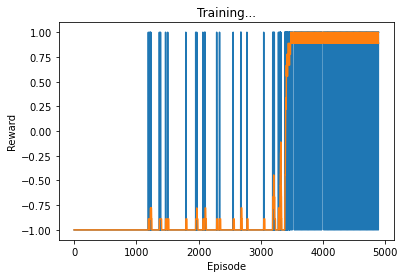

In [123]:
ep4_rewards = []
policy_net.train()
dqnloc_count = [0 for i in range(len(em4.env.tx_locs))]
loc4_errors = [np.abs(20*np.log10(np.abs(x))-20*np.log10(np.abs(y))) for x,y in zip(loc_SNRexh,loc_minSNRexh)]
iter4_avg_error = []
iter4_errors = []

dqn4_epslen=[]
outer = tqdm.notebook.tqdm(total=episodes, desc='training loop: ', position=0)

train_steps = 0
for episode in range(episodes):
    
    #if ((episode+1) > 4100):    
    #    obs = em.test_reset(np.array([[-100,-100,0]]), test_txbdir, em.env.sc_xyz, ch_randvals[episode*(em.env.goal_steps+1)])
    #    test_txbdir = (test_txbdir + 1) % em.env.N_tx
    #else:
    #    #tx_loc_xndx, tx_loc_yndx, tx_dir_ndx =em.env.obs_space.sample()
    tx_num = obs_list[episode]
    
    #policy_net.eval()
    #with torch.no_grad():
    #    action_probs = policy_net(obs).detach().data.cpu().numpy()[0]  
    #policy_net.train()
    #actions= np.argsort(action_probs)[::-1]
    
    obs = em4.reset(tx_num, ch_randvals[episode], dqnloc_count[tx_num]+1)
    tx_num = em4.env.get_txloc_ndx(em4.env.tx_loc)
    dqnloc_count[tx_num] +=1
    #obs = em.test_reset(np.array([[em.env.rx_xcov[tx_loc_xndx],em.env.rx_ycov[tx_loc_yndx], 0]]), tx_dir_ndx, em.env.sc_xyz, ch_randvals[episode*(em.env.goal_steps+1)])
    #dqnloc_maxexhselections[(tx_loc_xndx*len(em.env.rx_ycov)+tx_loc_yndx)*available_actions+tx_dir_ndx]+=1
    
    ep_loss = 0.0
    ep_rwd = 0.0
    timestep = 0
    tx_dirs = [-1.0 for x in range(em4.env.action_space.n)]
    rx_dirs = [-1.0 for x in range(em4.env.action_space.n)]
    data_rates =[np.inf for x in range(em4.env.action_space.n)]
    rssi_vals = [np.complex(0,0) for x in range(em4.env.action_space.n)]
    rwd_vals =[-2.0 for x in range(em4.env.action_space.n)]
    #agent.current_step +=1
    train_steps +=1
    eps = strategy.get_exploration_rate(train_steps)
    done = False
    
    if (episode < len(em4.env.tx_locs)):
        action_list = list(range(em4.env.action_space.n))
        random_actions = random.sample(action_list,len(action_list))
        
    while True:
        #tx_dirs.append(em4.env.tx_bdir*180/np.pi)
        #rx_dirs.append(em.env.rx_bdir[0]*180/np.pi)
        #data_rates.append(em.env.rate)
        #print(em.env.rbdir_ndx)
        #if(em4.env.rbdir_ndx >= 0):
        if (eps == 1.0):
            action = torch.tensor(np.array([random_actions[em4.env.rbdir_count]]), dtype=torch.long).to(device)
        else:
            action = agent.act(obs, policy_net, eps)
        next_obs, reward, done, _ = em4.step(action)#,ch_randvals[episode*(em.env.goal_steps+1)+timestep+1])
        #agent.step(obs, action, reward, next_obs, done)
        tx_dirs[em4.env.rbdir_ndx] = em4.env.rx_bdir*180/np.pi
        rx_dirs[em4.env.rbdir_ndx] = em4.env.rx_bdir*180/np.pi
        data_rates[em4.env.txdir_ndx*em4.env.N_rx+em4.env.rbdir_ndx] = em4.env.rate
        rssi_vals[em4.env.txdir_ndx*em4.env.N_rx+em4.env.rbdir_ndx] = em4.env.rssi_val
        
        rwd_vals[em4.env.txdir_ndx*em4.env.N_rx+em4.env.rbdir_ndx] = reward.item()
        ep_rwd += reward.item()
        
        '''
        if(np.all(em.env.tx_loc == np.array([[100,100,0]]))):
            print("ch_model: {}, sc_xyz: {}, min_exh_rate: {}, max_exh_rate: {}, min_action_ndx: {}, max_action_ndx: {}".format(em.env.ch_model, em.env.sc_xyz, min_exh_rate, max_exh_rate, min_action_ndx, max_action_ndx))
        '''   
        memory.add(obs, action, reward, next_obs, done)
        obs = next_obs
        
        ep4_rewards.append(reward.item())
        exh_rssi = loc_SNRexh[tx_num]
        if data_rates[em4.env.txdir_ndx*em4.env.N_rx+em4.env.rbdir_ndx] == np.inf:
            dqn_rate = 0.0
            dqn_rssi = loc_minSNRexh[tx_num]#np.complex(1,0)
        else:
            dqn_rate = data_rates[em4.env.txdir_ndx*em4.env.N_rx+em4.env.rbdir_ndx]#max(data_rates)
            dqn_rssi = rssi_vals[em4.env.txdir_ndx*em4.env.N_rx+em4.env.rbdir_ndx]
        #SNR_exh = Es * loc_SNRexh[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx]#np.abs(max_rssi_val) ** 2 / (em.env.N0 * em.env.B)
        #error = exh_rate-dqn_rate#np.abs(20*np.log10(np.abs(max_rssi_val))-20*np.log10(np.abs(rssi_val)))#max_exh_rate - dqn_rate
        error = np.abs(20*np.log10(np.abs(exh_rssi))-20*np.log10(np.abs(dqn_rssi)))
        iter4_errors.append(error)
        loc4_errors[tx_num] = error
        iter4_avg_error.append(np.mean(loc4_errors))

        #print("exh_rate: {}, dqn_rate: {}, error: {}, iter_avg_error: {}".format(np.abs(exh_rssi), np.abs(dqn_rssi), error, np.mean(loc4_errors)))
        #print("best_rate: {}, cur_rate: {}, action: {}, tx action: {}, rxaction: {}".format(em4.env.best_rate, em4.env.rate, action.item(), int(action.item()/em4.env.N_rx), int(action.item()%em4.env.N_rx) ))
        print("best_rate: {}, cur_rate: {}, error: {}, action: {}, iter_avg_error: {}".format(em4.env.best_rate, em4.env.rate, error, action.item(),np.mean(loc4_errors)))
        
        if memory.can_provide_sample():
            experiences = memory.sample()
            observations, actions, rewards, next_observations, dones = experiences
            weights, batch_indices = torch.tensor(np.ones_like(rewards.cpu().data.numpy())).to(device), None

            #print(states.shape, states.dtype)
            #print(actions.unsqueeze(-1).shape)
            current_q_values = policy_net(observations).gather(1,index=actions.unsqueeze(-1))#(1-ALPHA)*
            
            next_q_values = target_net(next_observations).detach().max(1)[0]
            target_q_values = ((next_q_values*GAMMA) + rewards)
            #print(policy_net(observations).type())
            #print(target_q_values.unsqueeze(1).type())
            #loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1).float())
            td_errors = ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values)
            #loss = F.mse_loss(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values),  reduction='sum')
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1).float(),  reduction='sum')
            #weighted_loss = torch.mean(weights*loss)
            #print("loss: ", loss)
            #loss = ALPHA*loss
            #ep_loss += weighted_loss.item()
            #ep_loss = torch.mean(loss).detach().numpy()
            ep_loss = loss.item()
            
            optimizer.zero_grad()
            #weighted_loss.backward()
            #ep_loss.backward(torch.ones_like(ep_loss))
            loss.backward(torch.ones_like(loss))
            optimizer.step()
            
        timestep +=1
        if done:
            dqn4_epslen.append(em4.env.rbdir_count)
            #data_rates.append(em.env.rate)
            #data_rates[em4.env.rbdir_ndx] = em4.env.rate
            #rssi_vals[em4.env.rbdir_ndx] = em4.env.rbdir_ndx
            
            #ep_rewards.append(ep_rwd)
            moving_avg_rwd = get_moving_average(len(em4.env.tx_locs), ep4_rewards)
            
            #print('\rEpisode {},\tScore: {:.2f}, eps: {}, moving avg_rwd: {}, ep_loss: {}'.format(episode+1, ep_rwd, eps, moving_avg_rwd[-1], ep_loss), end="\r")
            print('Episode {},\t Score: {:.2f}, eps: {}, moving avg_rwd: {}, ep_loss: {}'.format(episode+1, ep_rwd, eps, moving_avg_rwd[-1], ep_loss))
            #print("TX loc: {}".format(em4.env.tx_loc))
            tx_num = em4.env.get_txloc_ndx(em4.env.tx_loc)
            exh_action_ndx = loc_exhbdir[tx_num]
            #print("TX dirs: {}, episode length: {}".format(tx_dirs, len(tx_dirs)))
            #print("RX dirs: {}".format(rx_dirs))
            best_action_ndx = em4.env.txdir_ndx*em4.env.N_rx+em4.env.rbdir_ndx#data_rates.index(max(data_rates))
            print("dqn action ndx: {}, exh action ndx: {}".format(best_action_ndx, exh_action_ndx))
            #print("dqn rx bdir: {}, exh bdir: {}".format(rx_dirs[best_action_ndx], em4.env.BeamSet[exh_bdir_ndx]*180/np.pi))
            #print("data rates: ", data_rates)
            #print("rwd vals: ", rwd_vals)
 
            print("\n\n")
                            
            timestep = 0
            break
            
    #for local_param, target_param in zip(policy_net.parameters(), target_net.parameters()):
    #    target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)
    
    #Update the policy network
    if episode % UPDATE_EVERY == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    # update tqdm bar
    outer.update(1)
    
#torch.save(policy_net.state_dict(), 'checkpoint.pth')

#timer.finish()
test_rewards = []
plot(ep4_rewards, len(em4.env.tx_locs), test_rewards)


In [124]:
print("Average episode length: {}".format(np.mean(dqn4_epslen)))
print(len(iter4_avg_error))

Average episode length: 3.2613333333333334
4892


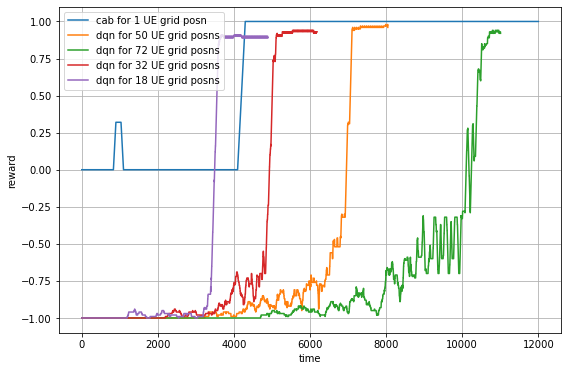

In [128]:
#cab vs dqn1 vs dqn2 vs dqn3 rwd plot

##### from Source.misc_fun.utils import *
fig = plt.figure(figsize=[9, 6])

#loc_ndx = 0
#tbdir_ndx = 3
context_ndx = 0#*len(tx_dirs)+ 4#tbdir_ndx
#context_ndx2 = sel_ctxt_ndices[1]#1*len(tx_dirs)+ 4#tbdir_ndx
#context_ndx3 = sel_ctxt_ndices[2]#2*len(tx_dirs)+ 3#tbdir_ndx
#context_ndx4 = sel_ctxt_ndices[3]#3*len(tx_dirs)+ 3#tbdir_ndx
#train_datarates[context_ndx] = train_datarates[context_ndx][:7001]
tmp_train_datarates = train_datarates[0][:12000]
tmp_ep2_rewards = ep2_rewards[:12000]
tmp_ep_rewards = ep_rewards[:12000]
tmp_ep3_rewards = ep3_rewards[:12000]
tmp_ep4_rewards = ep4_rewards[:12000]

moving_avg_period = 200
cab_movingavg = get_moving_average(moving_avg_period, tmp_train_datarates)

#em.env.obs_space.nvec[3]*len(em.env.tx_locs)
dqn2_movingavg = get_moving_average(moving_avg_period, tmp_ep2_rewards)

dqn1_movingavg = get_moving_average(moving_avg_period, tmp_ep_rewards)
dqn3_movingavg = get_moving_average(moving_avg_period, tmp_ep3_rewards)
dqn4_movingavg = get_moving_average(moving_avg_period, tmp_ep4_rewards)

plt.plot(np.arange(1,len(tmp_train_datarates)+1,1), cab_movingavg, np.arange(1,len(tmp_ep2_rewards)+1,1), dqn2_movingavg, np.arange(1,len(tmp_ep_rewards)+1,1), dqn1_movingavg, np.arange(1,len(tmp_ep3_rewards)+1,1), dqn3_movingavg, np.arange(1,len(tmp_ep4_rewards)+1,1), dqn4_movingavg)
#min_ndx=0
#max_ndx=500
#plt.plot(test_eps_iters[min_ndx:max_ndx])
plt.grid()
plt.legend(['cab for 1 UE grid posn', 'dqn for 50 UE grid posns', 'dqn for 72 UE grid posns', 'dqn for 32 UE grid posns', 'dqn for 18 UE grid posns'])
plt.xlabel('time')
plt.ylabel('reward')
#plt.savefig("021220_cab_dqn_rwdplots.pdf")
plt.show()
#plt.savefig("071020_cab_dqn_rwdplot_2.pdf")

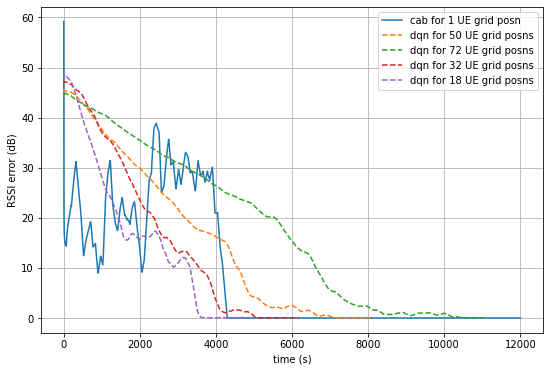

In [127]:
from Source.misc_fun.utils import *
fig = plt.figure(figsize=[9, 6])

#loc_ndx = 0
#tbdir_ndx = 3
context_ndx = 0#0*len(tx_dirs)+ 4#tbdir_ndx
#context_ndx2 = sel_ctxt_ndices[1]#1*len(tx_dirs)+ 4#tbdir_ndx
#context_ndx3 = sel_ctxt_ndices[2]#2*len(tx_dirs)+ 3#tbdir_ndx
#context_ndx4 = sel_ctxt_ndices[3]#3*len(tx_dirs)+ 3#tbdir_ndx
tmp_cabenv_avgerrors = cabenv_avgerrors[:12000]
tmp_iter_avg_error = iter_avg_error[:12000]
tmp_iter2_avg_error = iter2_avg_error[:12000]
tmp_iter3_avg_error = iter3_avg_error[:12000]
tmp_iter4_avg_error = iter4_avg_error[:12000]

moving_avg_period = 200
#plt.plot(np.arange(1,len(cabenv_avgerrors[context_ndx])+1), cabenv_avgerrors[7], np.arange(1,len(iter_avg_error)+1),iter_avg_error)
cab_movingavg = get_moving_average(moving_avg_period, tmp_cabenv_avgerrors)

dqn2_movingavg = get_moving_average(moving_avg_period, tmp_iter2_avg_error)

dqn1_movingavg = get_moving_average(moving_avg_period, tmp_iter_avg_error)

dqn3_movingavg = get_moving_average(moving_avg_period, tmp_iter3_avg_error)

dqn4_movingavg = get_moving_average(moving_avg_period, tmp_iter4_avg_error)

plt.plot(np.arange(1,len(tmp_cabenv_avgerrors)+1,1), cab_movingavg, np.arange(1,len(tmp_iter2_avg_error)+1,1), dqn2_movingavg,'--', np.arange(1,len(tmp_iter_avg_error)+1,1), dqn1_movingavg,'--', np.arange(1,len(tmp_iter3_avg_error)+1,1), dqn3_movingavg,'--',np.arange(1,len(tmp_iter4_avg_error)+1,1), dqn4_movingavg,'--')
#min_ndx=0
#max_ndx=500
#plt.plot(test_eps_iters[min_ndx:max_ndx])
plt.grid()
plt.legend(['cab for 1 UE grid posn', 'dqn for 50 UE grid posns', 'dqn for 72 UE grid posns', 'dqn for 32 UE grid posns', 'dqn for 18 UE grid posns'])
plt.xlabel('time (s)')
plt.ylabel('RSSI error (dB)')
#plt.savefig("021220_cab_dqn_erroplots.pdf")
plt.show()
#plt.savefig("071020_cab_dqn_erroplot_2.pdf")